In [0]:
import pandas as pd
from datetime import datetime
import numpy as np

features = pd.read_csv('features.csv')
labels = pd.read_csv('final_label.csv')

label = []
for i in range(labels.shape[0]):
    x, y = labels['time'].iloc[i].split(' ')
    a,b,c = x.split('-')
    d,e,f = y.split(':')
    label += [datetime(int(a),int(b),int(c),int(d),int(e),int(f))]
labels['time'] = pd.DataFrame(label)

feature = []
for i in range(features.shape[0]):
    x, y = features['daily_discussion_date'].iloc[i].split(' ')
    a,b,c = x.split('-')
    d = y[0]
    e = '00'
    f = '00'
    feature += [datetime(int(a),int(b),int(c),int(d),int(e),int(f))]
features['daily_discussion_date'] = pd.DataFrame(feature)
features.rename(columns=lambda x: 'time' if x =='daily_discussion_date' else x , inplace=True)
labels['label'] = labels['label'].apply(lambda x: int(x) if x != 'nolabel' else x)

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving final_label.csv to final_label.csv
User uploaded file "final_label.csv" with length 1310494 bytes


In [0]:
def drop_nan(data):
  size = []
  for i in range(data.shape[0]):
    try:
      int(data['label'].iloc[i])# == 'Nan':
    except: 
      size += [i]
  data = data.drop(data.index[size])
  data = data.reset_index()
  data = data.drop(['index'],axis = 1)
  
  return data
labels = drop_nan(labels)



/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


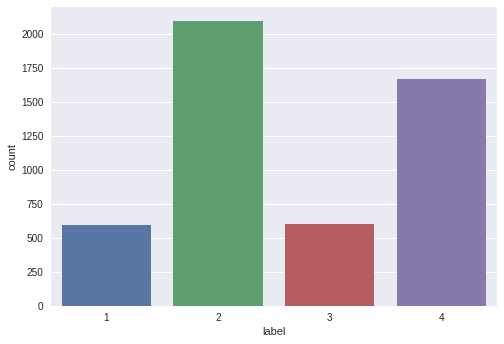

In [5]:
data = pd.merge(features, labels[['time','label']], how='inner', on='time')
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(x="label", data=data)

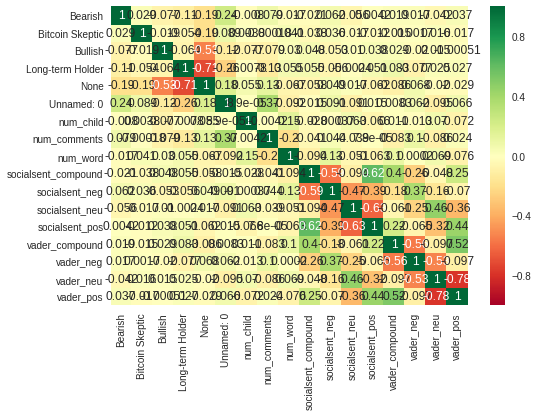

In [6]:
def feature_correlation(data):
    correlation = data.corr()
    #print(correlation)
    sns.heatmap(correlation, annot=True, cbar=True, cmap="RdYlGn")
    

data[data.columns.difference(['time','label'])].describe()

feature_correlation(data[data.columns.difference(['time','label'])])

In [0]:
def decode(y):
  s = []
  for i in range(len(y)):
    index = np.argmax(y[i])
    s.append(index+1)
  return np.array(s)

def one_hot_encoding(data, typed='df'):
    if typed == 'df':
      size = []
      for i in range(data.shape[0]):
          tem = [0 for i in range(4)]

          tem[int(data['label'].iloc[i])-1] = 1

          size.append(tem)
    else:
      size = []
      for i in range(data.shape[0]):
          tem = [0 for i in range(4)]

          tem[int(data[i])-1] = 1

          size.append(tem)
    return np.array(size)
label = one_hot_encoding(data)
features = data[data.columns.difference(['time','label'])]
features = np.array(features)


In [9]:
!pip install -U imbalanced-learn


    100% |████████████████████████████████| 153kB 3.1MB/s 
    100% |████████████████████████████████| 50.0MB 26kB/s 
Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (from imbalanced-learn)
Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (from imbalanced-learn)
  Found existing installation: scipy 0.19.1
    Uninstalling scipy-0.19.1:
      Successfully uninstalled scipy-0.19.1
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [0]:
import numpy as np
from imblearn.over_sampling import SMOTE 

def get_data(windowsize,features,label):
  a = []
  for i in range(windowsize, len(features)):
      temp = []
      for j in range(windowsize):
        temp += [np.array([features[i-j-1]])]

      a += [temp]
  a = np.array(a)
  features = a
  label = label[windowsize::]
  assert(label.shape[0] == features.shape[0])
  features = features.reshape((features.shape[0], features.shape[1], features.shape[3]))
  dim1 = features.shape[0]
  dim2 = features.shape[1]
  dim3 = features.shape[2]
  
  def balanced_data(features,label):
    sm = SMOTE(random_state=42)
    features, label = sm.fit_sample(features, decode(label))
    print(features.shape)
    features = features.reshape((features.shape[0],dim2,dim3))
    label = one_hot_encoding(label,typed='nodf')
    return features,label
  
  features = features.reshape((dim1,dim2*dim3))
  features,label = balanced_data(features,label)
  
  return features, label

#features, label = get_data(30,features,label)


In [11]:
from keras.models import Sequential
from keras.layers import *
from sklearn import metrics
from sklearn.model_selection import train_test_split


def model(features,label,window):
  
    features, label = get_data(window,features,label)
        
    X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3, random_state=42)
    #indices = int(0.9 * X_train.shape[0])
    #X_train, y_train, X_valid, y_valid = X_train[0:indices], y_train[0:indices], X_train[indices::], y_train[indices::]
    
    model = Sequential()
    
    model.add(LSTM(128, input_shape = (features.shape[1],features.shape[2]),
                   return_sequences=False,dropout=0.2, recurrent_dropout=0.2 ))
    
    model.add(Dense(24))
    
    model.add(Dense(4))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

    model.summary()

    history = model.fit(X_train, y_train, epochs=500, batch_size=64,validation_data=(X_test, y_test))
    y_test_hat = model.predict(X_test, verbose=0)
    fpr, tpr, thresholds = metrics.roc_curve(decode(y_test), decode(y_test_hat), pos_label=2)
    f1_score_macro = metrics.f1_score(decode(y_test), decode(y_test_hat), average='macro') 
    f1_score_micro = metrics.f1_score(decode(y_test), decode(y_test_hat), average='micro') 
    auc = metrics.auc(fpr, tpr)
    from sklearn.metrics import precision_score,recall_score
    precision_micro = metrics.precision_score(decode(y_test),decode(y_test_hat),average='micro' )
    precision_macro = metrics.precision_score(decode(y_test),decode(y_test_hat),average='macro' )
    recall_macro = metrics.recall_score(decode(y_test),decode(y_test_hat),average='macro' )
    recall_micro = metrics.recall_score(decode(y_test),decode(y_test_hat),average='micro' )
    
    return f1_score_macro,f1_score_micro,auc,precision_micro,precision_macro,recall_macro,recall_micro, history

result = {} 
for i in {1,2,5,10,24,36,48}:
  f1_score_macro,f1_score_micro,auc,precision_micro,precision_macro,recall_macro,recall_micro, history = model(features, label, i)
  result[i] = {'auc': auc, 'precision_micro':precision_micro,'precision_macro':precision_macro,'recall_macro':recall_macro,'recall_micro':recall_micro,
              'f1_score_macro':f1_score_macro, 'f1_score_micro':f1_score_micro,'history':history}
  print("for window size {}:".format(i), result[i])


Using TensorFlow backend.


(8384, 17)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               74752     
_________________________________________________________________
dense_1 (Dense)              (None, 24)                3096      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 100       
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0         
Total params: 77,948
Trainable params: 77,948
Non-trainable params: 0
_________________________________________________________________
Train on 5868 samples, validate on 2516 samples
Epoch 1/500
5868/5868 [==============================] - 3s 499us/step - loss: 1.4057 - categorical_accuracy: 0.2676 - val_loss: 1.3665 - val_categorical_accuracy: 0.2933
Epoch 2/500
5868/5868 [=================

5868/5868 [==============================] - 1s 218us/step - loss: 1.3821 - categorical_accuracy: 0.2754 - val_loss: 1.3681 - val_categorical_accuracy: 0.2802
Epoch 5/500
5868/5868 [==============================] - 1s 220us/step - loss: 1.3789 - categorical_accuracy: 0.2790 - val_loss: 1.3632 - val_categorical_accuracy: 0.2858
Epoch 6/500
5868/5868 [==============================] - 1s 220us/step - loss: 1.3809 - categorical_accuracy: 0.2740 - val_loss: 1.3682 - val_categorical_accuracy: 0.2734
Epoch 7/500
5868/5868 [==============================] - 1s 215us/step - loss: 1.3760 - categorical_accuracy: 0.2822 - val_loss: 1.3638 - val_categorical_accuracy: 0.2818
Epoch 8/500
5868/5868 [==============================] - 1s 216us/step - loss: 1.3794 - categorical_accuracy: 0.2762 - val_loss: 1.3667 - val_categorical_accuracy: 0.2838
Epoch 9/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3759 - categorical_accuracy: 0.2795 - val_loss: 1.3655 - val_categorical_acc

5868/5868 [==============================] - 1s 218us/step - loss: 1.3760 - categorical_accuracy: 0.2820 - val_loss: 1.3613 - val_categorical_accuracy: 0.2762
Epoch 12/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3786 - categorical_accuracy: 0.2628 - val_loss: 1.3599 - val_categorical_accuracy: 0.2878
Epoch 13/500
5868/5868 [==============================] - 1s 221us/step - loss: 1.3750 - categorical_accuracy: 0.2778 - val_loss: 1.3579 - val_categorical_accuracy: 0.2810
Epoch 14/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3743 - categorical_accuracy: 0.2795 - val_loss: 1.3637 - val_categorical_accuracy: 0.2707
Epoch 15/500
5868/5868 [==============================] - 1s 223us/step - loss: 1.3742 - categorical_accuracy: 0.2771 - val_loss: 1.3574 - val_categorical_accuracy: 0.2854
Epoch 16/500
5868/5868 [==============================] - 1s 214us/step - loss: 1.3716 - categorical_accuracy: 0.2800 - val_loss: 1.3568 - val_categorica

5868/5868 [==============================] - 1s 217us/step - loss: 1.3713 - categorical_accuracy: 0.2858 - val_loss: 1.3733 - val_categorical_accuracy: 0.2524
Epoch 19/500
5868/5868 [==============================] - 1s 220us/step - loss: 1.3744 - categorical_accuracy: 0.2810 - val_loss: 1.3604 - val_categorical_accuracy: 0.2734
Epoch 20/500
5868/5868 [==============================] - 1s 215us/step - loss: 1.3711 - categorical_accuracy: 0.2768 - val_loss: 1.3571 - val_categorical_accuracy: 0.2711
Epoch 21/500
5868/5868 [==============================] - 1s 216us/step - loss: 1.3735 - categorical_accuracy: 0.2774 - val_loss: 1.3642 - val_categorical_accuracy: 0.2810
Epoch 22/500
5868/5868 [==============================] - 1s 220us/step - loss: 1.3710 - categorical_accuracy: 0.2832 - val_loss: 1.3659 - val_categorical_accuracy: 0.2794
Epoch 23/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3716 - categorical_accuracy: 0.2952 - val_loss: 1.3585 - val_categorica

5868/5868 [==============================] - 1s 219us/step - loss: 1.3732 - categorical_accuracy: 0.2802 - val_loss: 1.3539 - val_categorical_accuracy: 0.2874
Epoch 26/500
5868/5868 [==============================] - 1s 221us/step - loss: 1.3727 - categorical_accuracy: 0.2868 - val_loss: 1.3585 - val_categorical_accuracy: 0.2806
Epoch 27/500
5868/5868 [==============================] - 1s 216us/step - loss: 1.3736 - categorical_accuracy: 0.2814 - val_loss: 1.3622 - val_categorical_accuracy: 0.2893
Epoch 28/500
5868/5868 [==============================] - 1s 227us/step - loss: 1.3730 - categorical_accuracy: 0.2851 - val_loss: 1.3586 - val_categorical_accuracy: 0.2850
Epoch 29/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3709 - categorical_accuracy: 0.2844 - val_loss: 1.3630 - val_categorical_accuracy: 0.2731
Epoch 30/500
5868/5868 [==============================] - 1s 221us/step - loss: 1.3724 - categorical_accuracy: 0.2749 - val_loss: 1.3594 - val_categorica

5868/5868 [==============================] - 1s 217us/step - loss: 1.3710 - categorical_accuracy: 0.2822 - val_loss: 1.3583 - val_categorical_accuracy: 0.2742
Epoch 33/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3710 - categorical_accuracy: 0.2776 - val_loss: 1.3613 - val_categorical_accuracy: 0.2850
Epoch 34/500
5868/5868 [==============================] - 1s 224us/step - loss: 1.3709 - categorical_accuracy: 0.2873 - val_loss: 1.3642 - val_categorical_accuracy: 0.2870
Epoch 35/500
5868/5868 [==============================] - 1s 222us/step - loss: 1.3723 - categorical_accuracy: 0.2860 - val_loss: 1.3610 - val_categorical_accuracy: 0.2886
Epoch 36/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3704 - categorical_accuracy: 0.2894 - val_loss: 1.3603 - val_categorical_accuracy: 0.2901
Epoch 37/500
5868/5868 [==============================] - 1s 222us/step - loss: 1.3712 - categorical_accuracy: 0.2769 - val_loss: 1.3683 - val_categorica

5868/5868 [==============================] - 1s 214us/step - loss: 1.3699 - categorical_accuracy: 0.2839 - val_loss: 1.3568 - val_categorical_accuracy: 0.2878
Epoch 40/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3701 - categorical_accuracy: 0.2887 - val_loss: 1.3608 - val_categorical_accuracy: 0.2846
Epoch 41/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3702 - categorical_accuracy: 0.2854 - val_loss: 1.3668 - val_categorical_accuracy: 0.2870
Epoch 42/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3673 - categorical_accuracy: 0.2887 - val_loss: 1.3573 - val_categorical_accuracy: 0.2731
Epoch 43/500
5868/5868 [==============================] - 1s 215us/step - loss: 1.3682 - categorical_accuracy: 0.2926 - val_loss: 1.3617 - val_categorical_accuracy: 0.2603
Epoch 44/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3733 - categorical_accuracy: 0.2774 - val_loss: 1.3593 - val_categorica

5868/5868 [==============================] - 1s 223us/step - loss: 1.3713 - categorical_accuracy: 0.2790 - val_loss: 1.3638 - val_categorical_accuracy: 0.2790
Epoch 47/500
5868/5868 [==============================] - 1s 211us/step - loss: 1.3694 - categorical_accuracy: 0.2849 - val_loss: 1.3603 - val_categorical_accuracy: 0.2603
Epoch 48/500
5868/5868 [==============================] - 1s 210us/step - loss: 1.3692 - categorical_accuracy: 0.2929 - val_loss: 1.3598 - val_categorical_accuracy: 0.2878
Epoch 49/500
5868/5868 [==============================] - 1s 215us/step - loss: 1.3692 - categorical_accuracy: 0.2786 - val_loss: 1.3556 - val_categorical_accuracy: 0.2897
Epoch 50/500
5868/5868 [==============================] - 1s 222us/step - loss: 1.3680 - categorical_accuracy: 0.2832 - val_loss: 1.3589 - val_categorical_accuracy: 0.2707
Epoch 51/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3716 - categorical_accuracy: 0.2805 - val_loss: 1.3586 - val_categorica

5868/5868 [==============================] - 1s 214us/step - loss: 1.3671 - categorical_accuracy: 0.2900 - val_loss: 1.3605 - val_categorical_accuracy: 0.2850
Epoch 54/500
5868/5868 [==============================] - 1s 216us/step - loss: 1.3694 - categorical_accuracy: 0.2868 - val_loss: 1.3619 - val_categorical_accuracy: 0.3025
Epoch 55/500
5868/5868 [==============================] - 1s 215us/step - loss: 1.3707 - categorical_accuracy: 0.2883 - val_loss: 1.3587 - val_categorical_accuracy: 0.2782
Epoch 56/500
5868/5868 [==============================] - 1s 215us/step - loss: 1.3687 - categorical_accuracy: 0.2834 - val_loss: 1.3604 - val_categorical_accuracy: 0.2472
Epoch 57/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3684 - categorical_accuracy: 0.2904 - val_loss: 1.3569 - val_categorical_accuracy: 0.2893
Epoch 58/500
5868/5868 [==============================] - 1s 216us/step - loss: 1.3670 - categorical_accuracy: 0.2863 - val_loss: 1.3655 - val_categorica

5868/5868 [==============================] - 1s 216us/step - loss: 1.3655 - categorical_accuracy: 0.2872 - val_loss: 1.3617 - val_categorical_accuracy: 0.2595
Epoch 61/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3674 - categorical_accuracy: 0.2872 - val_loss: 1.3605 - val_categorical_accuracy: 0.2731
Epoch 62/500
5868/5868 [==============================] - 1s 216us/step - loss: 1.3695 - categorical_accuracy: 0.2779 - val_loss: 1.3574 - val_categorical_accuracy: 0.2977
Epoch 63/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3670 - categorical_accuracy: 0.2993 - val_loss: 1.3646 - val_categorical_accuracy: 0.2893
Epoch 64/500
5868/5868 [==============================] - 1s 216us/step - loss: 1.3714 - categorical_accuracy: 0.2815 - val_loss: 1.3591 - val_categorical_accuracy: 0.2866
Epoch 65/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3655 - categorical_accuracy: 0.2941 - val_loss: 1.3644 - val_categorica

5868/5868 [==============================] - 1s 216us/step - loss: 1.3675 - categorical_accuracy: 0.2793 - val_loss: 1.3599 - val_categorical_accuracy: 0.2782
Epoch 68/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3697 - categorical_accuracy: 0.2906 - val_loss: 1.3615 - val_categorical_accuracy: 0.2810
Epoch 69/500
5868/5868 [==============================] - 1s 215us/step - loss: 1.3685 - categorical_accuracy: 0.2856 - val_loss: 1.3561 - val_categorical_accuracy: 0.2917
Epoch 70/500
5868/5868 [==============================] - 1s 220us/step - loss: 1.3644 - categorical_accuracy: 0.2924 - val_loss: 1.3557 - val_categorical_accuracy: 0.2917
Epoch 71/500
5868/5868 [==============================] - 1s 221us/step - loss: 1.3672 - categorical_accuracy: 0.2822 - val_loss: 1.3592 - val_categorical_accuracy: 0.2921
Epoch 72/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3665 - categorical_accuracy: 0.2918 - val_loss: 1.3633 - val_categorica

5868/5868 [==============================] - 1s 218us/step - loss: 1.3700 - categorical_accuracy: 0.2914 - val_loss: 1.3686 - val_categorical_accuracy: 0.2798
Epoch 75/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3686 - categorical_accuracy: 0.2834 - val_loss: 1.3606 - val_categorical_accuracy: 0.2870
Epoch 76/500
5868/5868 [==============================] - 1s 212us/step - loss: 1.3670 - categorical_accuracy: 0.2820 - val_loss: 1.3569 - val_categorical_accuracy: 0.2905
Epoch 77/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3657 - categorical_accuracy: 0.2810 - val_loss: 1.3618 - val_categorical_accuracy: 0.2897
Epoch 78/500
5868/5868 [==============================] - 1s 211us/step - loss: 1.3650 - categorical_accuracy: 0.2805 - val_loss: 1.3564 - val_categorical_accuracy: 0.2870
Epoch 79/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3664 - categorical_accuracy: 0.2831 - val_loss: 1.3581 - val_categorica

5868/5868 [==============================] - 1s 220us/step - loss: 1.3653 - categorical_accuracy: 0.2912 - val_loss: 1.3554 - val_categorical_accuracy: 0.2834
Epoch 82/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3664 - categorical_accuracy: 0.2907 - val_loss: 1.3533 - val_categorical_accuracy: 0.2901
Epoch 83/500
5868/5868 [==============================] - 1s 220us/step - loss: 1.3635 - categorical_accuracy: 0.2921 - val_loss: 1.3522 - val_categorical_accuracy: 0.2893
Epoch 84/500
5868/5868 [==============================] - 1s 220us/step - loss: 1.3664 - categorical_accuracy: 0.2902 - val_loss: 1.3571 - val_categorical_accuracy: 0.2822
Epoch 85/500
5868/5868 [==============================] - 1s 214us/step - loss: 1.3667 - categorical_accuracy: 0.2890 - val_loss: 1.3557 - val_categorical_accuracy: 0.2909
Epoch 86/500
5868/5868 [==============================] - 1s 223us/step - loss: 1.3672 - categorical_accuracy: 0.2808 - val_loss: 1.3561 - val_categorica

5868/5868 [==============================] - 1s 217us/step - loss: 1.3689 - categorical_accuracy: 0.2744 - val_loss: 1.3589 - val_categorical_accuracy: 0.2854
Epoch 89/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3682 - categorical_accuracy: 0.2819 - val_loss: 1.3586 - val_categorical_accuracy: 0.2917
Epoch 90/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3640 - categorical_accuracy: 0.2907 - val_loss: 1.3651 - val_categorical_accuracy: 0.2631
Epoch 91/500
5868/5868 [==============================] - 1s 221us/step - loss: 1.3660 - categorical_accuracy: 0.2776 - val_loss: 1.3690 - val_categorical_accuracy: 0.2731
Epoch 92/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3660 - categorical_accuracy: 0.2926 - val_loss: 1.3835 - val_categorical_accuracy: 0.2611
Epoch 93/500
5868/5868 [==============================] - 1s 221us/step - loss: 1.3692 - categorical_accuracy: 0.2812 - val_loss: 1.3574 - val_categorica

5868/5868 [==============================] - 1s 217us/step - loss: 1.3648 - categorical_accuracy: 0.2923 - val_loss: 1.3571 - val_categorical_accuracy: 0.2870
Epoch 96/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3659 - categorical_accuracy: 0.2909 - val_loss: 1.3588 - val_categorical_accuracy: 0.2897
Epoch 97/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3683 - categorical_accuracy: 0.2802 - val_loss: 1.3625 - val_categorical_accuracy: 0.2909
Epoch 98/500
5868/5868 [==============================] - 1s 214us/step - loss: 1.3674 - categorical_accuracy: 0.2854 - val_loss: 1.3575 - val_categorical_accuracy: 0.2802
Epoch 99/500
5868/5868 [==============================] - 1s 221us/step - loss: 1.3671 - categorical_accuracy: 0.2904 - val_loss: 1.3596 - val_categorical_accuracy: 0.2802
Epoch 100/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3640 - categorical_accuracy: 0.2883 - val_loss: 1.3598 - val_categoric

5868/5868 [==============================] - 1s 216us/step - loss: 1.3670 - categorical_accuracy: 0.2900 - val_loss: 1.3592 - val_categorical_accuracy: 0.2758
Epoch 103/500
5868/5868 [==============================] - 1s 216us/step - loss: 1.3649 - categorical_accuracy: 0.2900 - val_loss: 1.3626 - val_categorical_accuracy: 0.2603
Epoch 104/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3664 - categorical_accuracy: 0.2941 - val_loss: 1.3563 - val_categorical_accuracy: 0.2886
Epoch 105/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3671 - categorical_accuracy: 0.2860 - val_loss: 1.3682 - val_categorical_accuracy: 0.2611
Epoch 106/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3684 - categorical_accuracy: 0.2819 - val_loss: 1.3620 - val_categorical_accuracy: 0.2854
Epoch 107/500
5868/5868 [==============================] - 1s 221us/step - loss: 1.3696 - categorical_accuracy: 0.2774 - val_loss: 1.3580 - val_categ

5868/5868 [==============================] - 1s 213us/step - loss: 1.3663 - categorical_accuracy: 0.2837 - val_loss: 1.3582 - val_categorical_accuracy: 0.2913
Epoch 110/500
5868/5868 [==============================] - 1s 215us/step - loss: 1.3643 - categorical_accuracy: 0.2805 - val_loss: 1.3575 - val_categorical_accuracy: 0.2941
Epoch 111/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3662 - categorical_accuracy: 0.2870 - val_loss: 1.3583 - val_categorical_accuracy: 0.2822
Epoch 112/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3663 - categorical_accuracy: 0.2696 - val_loss: 1.3538 - val_categorical_accuracy: 0.2893
Epoch 113/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3671 - categorical_accuracy: 0.2829 - val_loss: 1.3622 - val_categorical_accuracy: 0.2663
Epoch 114/500
5868/5868 [==============================] - 1s 215us/step - loss: 1.3635 - categorical_accuracy: 0.2883 - val_loss: 1.3570 - val_categ

5868/5868 [==============================] - 1s 218us/step - loss: 1.3663 - categorical_accuracy: 0.2873 - val_loss: 1.3555 - val_categorical_accuracy: 0.2929
Epoch 117/500
5868/5868 [==============================] - 1s 221us/step - loss: 1.3620 - categorical_accuracy: 0.2889 - val_loss: 1.3579 - val_categorical_accuracy: 0.2802
Epoch 118/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3641 - categorical_accuracy: 0.2902 - val_loss: 1.3566 - val_categorical_accuracy: 0.2766
Epoch 119/500
5868/5868 [==============================] - 1s 221us/step - loss: 1.3668 - categorical_accuracy: 0.2764 - val_loss: 1.3592 - val_categorical_accuracy: 0.2913
Epoch 120/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3670 - categorical_accuracy: 0.2844 - val_loss: 1.3605 - val_categorical_accuracy: 0.2810
Epoch 121/500
5868/5868 [==============================] - 1s 216us/step - loss: 1.3663 - categorical_accuracy: 0.2754 - val_loss: 1.3535 - val_categ

5868/5868 [==============================] - 1s 220us/step - loss: 1.3668 - categorical_accuracy: 0.2798 - val_loss: 1.3542 - val_categorical_accuracy: 0.2766
Epoch 124/500
5868/5868 [==============================] - 1s 220us/step - loss: 1.3641 - categorical_accuracy: 0.2759 - val_loss: 1.3534 - val_categorical_accuracy: 0.2838
Epoch 125/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3678 - categorical_accuracy: 0.2802 - val_loss: 1.3583 - val_categorical_accuracy: 0.2619
Epoch 126/500
5868/5868 [==============================] - 1s 223us/step - loss: 1.3660 - categorical_accuracy: 0.2863 - val_loss: 1.3566 - val_categorical_accuracy: 0.2893
Epoch 127/500
5868/5868 [==============================] - 1s 214us/step - loss: 1.3633 - categorical_accuracy: 0.2831 - val_loss: 1.3603 - val_categorical_accuracy: 0.2814
Epoch 128/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3645 - categorical_accuracy: 0.2865 - val_loss: 1.3607 - val_categ

5868/5868 [==============================] - 1s 213us/step - loss: 1.3620 - categorical_accuracy: 0.2899 - val_loss: 1.3650 - val_categorical_accuracy: 0.2611
Epoch 131/500
5868/5868 [==============================] - 1s 221us/step - loss: 1.3657 - categorical_accuracy: 0.2795 - val_loss: 1.3567 - val_categorical_accuracy: 0.2746
Epoch 132/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3621 - categorical_accuracy: 0.2894 - val_loss: 1.3613 - val_categorical_accuracy: 0.2897
Epoch 133/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3642 - categorical_accuracy: 0.2885 - val_loss: 1.3610 - val_categorical_accuracy: 0.2711
Epoch 134/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3642 - categorical_accuracy: 0.2897 - val_loss: 1.3606 - val_categorical_accuracy: 0.2901
Epoch 135/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3666 - categorical_accuracy: 0.2882 - val_loss: 1.3610 - val_categ

5868/5868 [==============================] - 1s 212us/step - loss: 1.3641 - categorical_accuracy: 0.2776 - val_loss: 1.3605 - val_categorical_accuracy: 0.2599
Epoch 138/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3689 - categorical_accuracy: 0.2822 - val_loss: 1.3590 - val_categorical_accuracy: 0.2818
Epoch 139/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3677 - categorical_accuracy: 0.2737 - val_loss: 1.3607 - val_categorical_accuracy: 0.2750
Epoch 140/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3707 - categorical_accuracy: 0.2745 - val_loss: 1.3529 - val_categorical_accuracy: 0.2882
Epoch 141/500
5868/5868 [==============================] - 1s 216us/step - loss: 1.3649 - categorical_accuracy: 0.2878 - val_loss: 1.3539 - val_categorical_accuracy: 0.2882
Epoch 142/500
5868/5868 [==============================] - 1s 221us/step - loss: 1.3632 - categorical_accuracy: 0.2808 - val_loss: 1.3554 - val_categ

5868/5868 [==============================] - 1s 217us/step - loss: 1.3682 - categorical_accuracy: 0.2875 - val_loss: 1.3572 - val_categorical_accuracy: 0.2854
Epoch 145/500
5868/5868 [==============================] - 1s 214us/step - loss: 1.3639 - categorical_accuracy: 0.2805 - val_loss: 1.3577 - val_categorical_accuracy: 0.2810
Epoch 146/500
5868/5868 [==============================] - 1s 224us/step - loss: 1.3661 - categorical_accuracy: 0.2790 - val_loss: 1.3586 - val_categorical_accuracy: 0.2603
Epoch 147/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3670 - categorical_accuracy: 0.2836 - val_loss: 1.3563 - val_categorical_accuracy: 0.2886
Epoch 148/500
5868/5868 [==============================] - 1s 222us/step - loss: 1.3666 - categorical_accuracy: 0.2785 - val_loss: 1.3585 - val_categorical_accuracy: 0.2882
Epoch 149/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3676 - categorical_accuracy: 0.2803 - val_loss: 1.3593 - val_categ

5868/5868 [==============================] - 1s 216us/step - loss: 1.3638 - categorical_accuracy: 0.2814 - val_loss: 1.3582 - val_categorical_accuracy: 0.2862
Epoch 152/500
5868/5868 [==============================] - 1s 221us/step - loss: 1.3657 - categorical_accuracy: 0.2797 - val_loss: 1.3539 - val_categorical_accuracy: 0.2913
Epoch 153/500
5868/5868 [==============================] - 1s 221us/step - loss: 1.3657 - categorical_accuracy: 0.2861 - val_loss: 1.3565 - val_categorical_accuracy: 0.2890
Epoch 154/500
5868/5868 [==============================] - 1s 215us/step - loss: 1.3635 - categorical_accuracy: 0.2866 - val_loss: 1.3609 - val_categorical_accuracy: 0.2842
Epoch 155/500
5868/5868 [==============================] - 1s 216us/step - loss: 1.3645 - categorical_accuracy: 0.2894 - val_loss: 1.3587 - val_categorical_accuracy: 0.2842
Epoch 156/500
5868/5868 [==============================] - 1s 224us/step - loss: 1.3616 - categorical_accuracy: 0.2955 - val_loss: 1.3563 - val_categ

5868/5868 [==============================] - 1s 217us/step - loss: 1.3629 - categorical_accuracy: 0.2872 - val_loss: 1.3557 - val_categorical_accuracy: 0.2870
Epoch 159/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3636 - categorical_accuracy: 0.2808 - val_loss: 1.3538 - val_categorical_accuracy: 0.2893
Epoch 160/500
5868/5868 [==============================] - 1s 223us/step - loss: 1.3615 - categorical_accuracy: 0.2972 - val_loss: 1.3538 - val_categorical_accuracy: 0.2893
Epoch 161/500
5868/5868 [==============================] - 1s 213us/step - loss: 1.3616 - categorical_accuracy: 0.2873 - val_loss: 1.3540 - val_categorical_accuracy: 0.2921
Epoch 162/500
5868/5868 [==============================] - 1s 222us/step - loss: 1.3638 - categorical_accuracy: 0.2929 - val_loss: 1.3532 - val_categorical_accuracy: 0.2913
Epoch 163/500
5868/5868 [==============================] - 1s 216us/step - loss: 1.3636 - categorical_accuracy: 0.2851 - val_loss: 1.3561 - val_categ

5868/5868 [==============================] - 1s 220us/step - loss: 1.3645 - categorical_accuracy: 0.2952 - val_loss: 1.3615 - val_categorical_accuracy: 0.2882
Epoch 166/500
5868/5868 [==============================] - 1s 216us/step - loss: 1.3618 - categorical_accuracy: 0.2882 - val_loss: 1.3575 - val_categorical_accuracy: 0.2929
Epoch 167/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3604 - categorical_accuracy: 0.2964 - val_loss: 1.3584 - val_categorical_accuracy: 0.2822
Epoch 168/500
5868/5868 [==============================] - 1s 214us/step - loss: 1.3633 - categorical_accuracy: 0.2911 - val_loss: 1.3565 - val_categorical_accuracy: 0.2818
Epoch 169/500
5868/5868 [==============================] - 1s 216us/step - loss: 1.3613 - categorical_accuracy: 0.2890 - val_loss: 1.3536 - val_categorical_accuracy: 0.2874
Epoch 170/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3614 - categorical_accuracy: 0.2900 - val_loss: 1.3550 - val_categ

5868/5868 [==============================] - 1s 215us/step - loss: 1.3620 - categorical_accuracy: 0.2897 - val_loss: 1.3608 - val_categorical_accuracy: 0.2675
Epoch 173/500
5868/5868 [==============================] - 1s 221us/step - loss: 1.3625 - categorical_accuracy: 0.2906 - val_loss: 1.3597 - val_categorical_accuracy: 0.2886
Epoch 174/500
5868/5868 [==============================] - 1s 222us/step - loss: 1.3634 - categorical_accuracy: 0.2928 - val_loss: 1.3599 - val_categorical_accuracy: 0.2878
Epoch 175/500
5868/5868 [==============================] - 1s 224us/step - loss: 1.3622 - categorical_accuracy: 0.2906 - val_loss: 1.3582 - val_categorical_accuracy: 0.2897
Epoch 176/500
5868/5868 [==============================] - 1s 214us/step - loss: 1.3600 - categorical_accuracy: 0.2912 - val_loss: 1.3546 - val_categorical_accuracy: 0.2814
Epoch 177/500
5868/5868 [==============================] - 1s 220us/step - loss: 1.3614 - categorical_accuracy: 0.2909 - val_loss: 1.3538 - val_categ

5868/5868 [==============================] - 1s 217us/step - loss: 1.3617 - categorical_accuracy: 0.2933 - val_loss: 1.3546 - val_categorical_accuracy: 0.2973
Epoch 180/500
5868/5868 [==============================] - 1s 222us/step - loss: 1.3632 - categorical_accuracy: 0.2841 - val_loss: 1.3572 - val_categorical_accuracy: 0.2913
Epoch 181/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3588 - categorical_accuracy: 0.2900 - val_loss: 1.3613 - val_categorical_accuracy: 0.2890
Epoch 182/500
5868/5868 [==============================] - 1s 221us/step - loss: 1.3639 - categorical_accuracy: 0.2866 - val_loss: 1.3571 - val_categorical_accuracy: 0.2921
Epoch 183/500
5868/5868 [==============================] - 1s 220us/step - loss: 1.3642 - categorical_accuracy: 0.2849 - val_loss: 1.3549 - val_categorical_accuracy: 0.2909
Epoch 184/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3598 - categorical_accuracy: 0.2824 - val_loss: 1.3556 - val_categ

5868/5868 [==============================] - 1s 220us/step - loss: 1.3610 - categorical_accuracy: 0.2827 - val_loss: 1.3538 - val_categorical_accuracy: 0.2917
Epoch 187/500
5868/5868 [==============================] - 1s 224us/step - loss: 1.3591 - categorical_accuracy: 0.2870 - val_loss: 1.3559 - val_categorical_accuracy: 0.2937
Epoch 188/500
5868/5868 [==============================] - 1s 221us/step - loss: 1.3631 - categorical_accuracy: 0.2858 - val_loss: 1.3568 - val_categorical_accuracy: 0.2901
Epoch 189/500
5868/5868 [==============================] - 1s 220us/step - loss: 1.3603 - categorical_accuracy: 0.2941 - val_loss: 1.3562 - val_categorical_accuracy: 0.2822
Epoch 190/500
5868/5868 [==============================] - 1s 221us/step - loss: 1.3614 - categorical_accuracy: 0.2941 - val_loss: 1.3577 - val_categorical_accuracy: 0.2870
Epoch 191/500
5868/5868 [==============================] - 1s 225us/step - loss: 1.3608 - categorical_accuracy: 0.2887 - val_loss: 1.3568 - val_categ

5868/5868 [==============================] - 1s 224us/step - loss: 1.3584 - categorical_accuracy: 0.2902 - val_loss: 1.3539 - val_categorical_accuracy: 0.2905
Epoch 194/500
5868/5868 [==============================] - 1s 221us/step - loss: 1.3617 - categorical_accuracy: 0.2887 - val_loss: 1.3581 - val_categorical_accuracy: 0.2754
Epoch 195/500
5868/5868 [==============================] - 1s 214us/step - loss: 1.3598 - categorical_accuracy: 0.2911 - val_loss: 1.3553 - val_categorical_accuracy: 0.2846
Epoch 196/500
5868/5868 [==============================] - 1s 216us/step - loss: 1.3614 - categorical_accuracy: 0.2880 - val_loss: 1.3585 - val_categorical_accuracy: 0.2913
Epoch 197/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3626 - categorical_accuracy: 0.2854 - val_loss: 1.3521 - val_categorical_accuracy: 0.2961
Epoch 198/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3584 - categorical_accuracy: 0.2899 - val_loss: 1.3635 - val_categ

5868/5868 [==============================] - 1s 215us/step - loss: 1.3571 - categorical_accuracy: 0.2967 - val_loss: 1.3555 - val_categorical_accuracy: 0.2874
Epoch 201/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3603 - categorical_accuracy: 0.2892 - val_loss: 1.3571 - val_categorical_accuracy: 0.2850
Epoch 202/500
5868/5868 [==============================] - 1s 223us/step - loss: 1.3603 - categorical_accuracy: 0.2831 - val_loss: 1.3575 - val_categorical_accuracy: 0.2834
Epoch 203/500
5868/5868 [==============================] - 1s 222us/step - loss: 1.3621 - categorical_accuracy: 0.2950 - val_loss: 1.3554 - val_categorical_accuracy: 0.2846
Epoch 204/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3613 - categorical_accuracy: 0.2880 - val_loss: 1.3564 - val_categorical_accuracy: 0.2897
Epoch 205/500
5868/5868 [==============================] - 1s 220us/step - loss: 1.3610 - categorical_accuracy: 0.2839 - val_loss: 1.3541 - val_categ

5868/5868 [==============================] - 1s 222us/step - loss: 1.3605 - categorical_accuracy: 0.2900 - val_loss: 1.3580 - val_categorical_accuracy: 0.2850
Epoch 208/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3596 - categorical_accuracy: 0.2875 - val_loss: 1.3632 - val_categorical_accuracy: 0.2635
Epoch 209/500
5868/5868 [==============================] - 1s 226us/step - loss: 1.3614 - categorical_accuracy: 0.2906 - val_loss: 1.3540 - val_categorical_accuracy: 0.2901
Epoch 210/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3597 - categorical_accuracy: 0.2911 - val_loss: 1.3529 - val_categorical_accuracy: 0.3041
Epoch 211/500
5868/5868 [==============================] - 1s 224us/step - loss: 1.3612 - categorical_accuracy: 0.2923 - val_loss: 1.3499 - val_categorical_accuracy: 0.2886
Epoch 212/500
5868/5868 [==============================] - 1s 214us/step - loss: 1.3629 - categorical_accuracy: 0.2747 - val_loss: 1.3538 - val_categ

5868/5868 [==============================] - 1s 218us/step - loss: 1.3620 - categorical_accuracy: 0.2946 - val_loss: 1.3561 - val_categorical_accuracy: 0.2838
Epoch 215/500
5868/5868 [==============================] - 1s 220us/step - loss: 1.3606 - categorical_accuracy: 0.2877 - val_loss: 1.3551 - val_categorical_accuracy: 0.2854
Epoch 216/500
5868/5868 [==============================] - 1s 223us/step - loss: 1.3626 - categorical_accuracy: 0.2764 - val_loss: 1.3523 - val_categorical_accuracy: 0.2874
Epoch 217/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3604 - categorical_accuracy: 0.2948 - val_loss: 1.3524 - val_categorical_accuracy: 0.2905
Epoch 218/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3615 - categorical_accuracy: 0.2791 - val_loss: 1.3499 - val_categorical_accuracy: 0.2941
Epoch 219/500
5868/5868 [==============================] - 1s 220us/step - loss: 1.3595 - categorical_accuracy: 0.2907 - val_loss: 1.3620 - val_categ

5868/5868 [==============================] - 1s 213us/step - loss: 1.3619 - categorical_accuracy: 0.2873 - val_loss: 1.3538 - val_categorical_accuracy: 0.2890
Epoch 222/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3597 - categorical_accuracy: 0.2856 - val_loss: 1.3536 - val_categorical_accuracy: 0.2738
Epoch 223/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3602 - categorical_accuracy: 0.2953 - val_loss: 1.3572 - val_categorical_accuracy: 0.2850
Epoch 224/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3599 - categorical_accuracy: 0.2892 - val_loss: 1.3544 - val_categorical_accuracy: 0.2890
Epoch 225/500
5868/5868 [==============================] - 1s 213us/step - loss: 1.3598 - categorical_accuracy: 0.2928 - val_loss: 1.3577 - val_categorical_accuracy: 0.2886
Epoch 226/500
5868/5868 [==============================] - 1s 216us/step - loss: 1.3594 - categorical_accuracy: 0.2877 - val_loss: 1.3602 - val_categ

5868/5868 [==============================] - 1s 215us/step - loss: 1.3597 - categorical_accuracy: 0.2844 - val_loss: 1.3566 - val_categorical_accuracy: 0.2858
Epoch 229/500
5868/5868 [==============================] - 1s 221us/step - loss: 1.3595 - categorical_accuracy: 0.2958 - val_loss: 1.3560 - val_categorical_accuracy: 0.2818
Epoch 230/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3631 - categorical_accuracy: 0.2829 - val_loss: 1.3578 - val_categorical_accuracy: 0.2814
Epoch 231/500
5868/5868 [==============================] - 1s 221us/step - loss: 1.3611 - categorical_accuracy: 0.2856 - val_loss: 1.3541 - val_categorical_accuracy: 0.2778
Epoch 232/500
5868/5868 [==============================] - 1s 221us/step - loss: 1.3583 - categorical_accuracy: 0.2935 - val_loss: 1.3589 - val_categorical_accuracy: 0.2882
Epoch 233/500
5868/5868 [==============================] - 1s 220us/step - loss: 1.3619 - categorical_accuracy: 0.2962 - val_loss: 1.3503 - val_categ

5868/5868 [==============================] - 1s 228us/step - loss: 1.3598 - categorical_accuracy: 0.2895 - val_loss: 1.3553 - val_categorical_accuracy: 0.2882
Epoch 236/500
5868/5868 [==============================] - 1s 228us/step - loss: 1.3601 - categorical_accuracy: 0.2914 - val_loss: 1.3568 - val_categorical_accuracy: 0.2810
Epoch 237/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3572 - categorical_accuracy: 0.2885 - val_loss: 1.3540 - val_categorical_accuracy: 0.2949
Epoch 238/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3578 - categorical_accuracy: 0.2883 - val_loss: 1.3616 - val_categorical_accuracy: 0.2603
Epoch 239/500
5868/5868 [==============================] - 1s 222us/step - loss: 1.3592 - categorical_accuracy: 0.2945 - val_loss: 1.3560 - val_categorical_accuracy: 0.2595
Epoch 240/500
5868/5868 [==============================] - 1s 226us/step - loss: 1.3630 - categorical_accuracy: 0.2810 - val_loss: 1.3534 - val_categ

5868/5868 [==============================] - 1s 223us/step - loss: 1.3579 - categorical_accuracy: 0.2858 - val_loss: 1.3558 - val_categorical_accuracy: 0.2794
Epoch 243/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3616 - categorical_accuracy: 0.2848 - val_loss: 1.3546 - val_categorical_accuracy: 0.2925
Epoch 244/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3602 - categorical_accuracy: 0.2768 - val_loss: 1.3593 - val_categorical_accuracy: 0.2603
Epoch 245/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3588 - categorical_accuracy: 0.2858 - val_loss: 1.3530 - val_categorical_accuracy: 0.2830
Epoch 246/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3604 - categorical_accuracy: 0.2846 - val_loss: 1.3530 - val_categorical_accuracy: 0.2627
Epoch 247/500
5868/5868 [==============================] - 1s 220us/step - loss: 1.3605 - categorical_accuracy: 0.2827 - val_loss: 1.3547 - val_categ

5868/5868 [==============================] - 1s 226us/step - loss: 1.3618 - categorical_accuracy: 0.2831 - val_loss: 1.3557 - val_categorical_accuracy: 0.2822
Epoch 250/500
5868/5868 [==============================] - 1s 222us/step - loss: 1.3596 - categorical_accuracy: 0.2882 - val_loss: 1.3544 - val_categorical_accuracy: 0.2778
Epoch 251/500
5868/5868 [==============================] - 1s 226us/step - loss: 1.3599 - categorical_accuracy: 0.2911 - val_loss: 1.3527 - val_categorical_accuracy: 0.2846
Epoch 252/500
5868/5868 [==============================] - 1s 216us/step - loss: 1.3566 - categorical_accuracy: 0.2926 - val_loss: 1.3529 - val_categorical_accuracy: 0.2846
Epoch 253/500
5868/5868 [==============================] - 1s 226us/step - loss: 1.3561 - categorical_accuracy: 0.2929 - val_loss: 1.3524 - val_categorical_accuracy: 0.2583
Epoch 254/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3558 - categorical_accuracy: 0.3032 - val_loss: 1.3570 - val_categ

5868/5868 [==============================] - 1s 219us/step - loss: 1.3587 - categorical_accuracy: 0.2929 - val_loss: 1.3537 - val_categorical_accuracy: 0.2917
Epoch 257/500
5868/5868 [==============================] - 1s 214us/step - loss: 1.3589 - categorical_accuracy: 0.2892 - val_loss: 1.3576 - val_categorical_accuracy: 0.2874
Epoch 258/500
5868/5868 [==============================] - 1s 220us/step - loss: 1.3584 - categorical_accuracy: 0.2984 - val_loss: 1.3520 - val_categorical_accuracy: 0.2933
Epoch 259/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3603 - categorical_accuracy: 0.2933 - val_loss: 1.3527 - val_categorical_accuracy: 0.2846
Epoch 260/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3574 - categorical_accuracy: 0.2989 - val_loss: 1.3550 - val_categorical_accuracy: 0.2810
Epoch 261/500
5868/5868 [==============================] - 1s 214us/step - loss: 1.3559 - categorical_accuracy: 0.2974 - val_loss: 1.3506 - val_categ

5868/5868 [==============================] - 1s 222us/step - loss: 1.3598 - categorical_accuracy: 0.2889 - val_loss: 1.3526 - val_categorical_accuracy: 0.2890
Epoch 264/500
5868/5868 [==============================] - 1s 220us/step - loss: 1.3580 - categorical_accuracy: 0.2890 - val_loss: 1.3549 - val_categorical_accuracy: 0.2870
Epoch 265/500
5868/5868 [==============================] - 1s 216us/step - loss: 1.3573 - categorical_accuracy: 0.2958 - val_loss: 1.3525 - val_categorical_accuracy: 0.2897
Epoch 266/500
5868/5868 [==============================] - 1s 223us/step - loss: 1.3566 - categorical_accuracy: 0.2969 - val_loss: 1.3550 - val_categorical_accuracy: 0.2886
Epoch 267/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3590 - categorical_accuracy: 0.2914 - val_loss: 1.3741 - val_categorical_accuracy: 0.2568
Epoch 268/500
5868/5868 [==============================] - 1s 222us/step - loss: 1.3626 - categorical_accuracy: 0.2761 - val_loss: 1.3554 - val_categ

5868/5868 [==============================] - 1s 218us/step - loss: 1.3581 - categorical_accuracy: 0.2962 - val_loss: 1.3506 - val_categorical_accuracy: 0.2941
Epoch 271/500
5868/5868 [==============================] - 1s 215us/step - loss: 1.3600 - categorical_accuracy: 0.2820 - val_loss: 1.3533 - val_categorical_accuracy: 0.2941
Epoch 272/500
5868/5868 [==============================] - 1s 220us/step - loss: 1.3567 - categorical_accuracy: 0.2916 - val_loss: 1.3525 - val_categorical_accuracy: 0.2758
Epoch 273/500
5868/5868 [==============================] - 1s 223us/step - loss: 1.3615 - categorical_accuracy: 0.2895 - val_loss: 1.3514 - val_categorical_accuracy: 0.2866
Epoch 274/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3603 - categorical_accuracy: 0.2865 - val_loss: 1.3504 - val_categorical_accuracy: 0.2778
Epoch 275/500
5868/5868 [==============================] - 1s 220us/step - loss: 1.3554 - categorical_accuracy: 0.2993 - val_loss: 1.3600 - val_categ

5868/5868 [==============================] - 1s 220us/step - loss: 1.3592 - categorical_accuracy: 0.2941 - val_loss: 1.3504 - val_categorical_accuracy: 0.2909
Epoch 278/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3572 - categorical_accuracy: 0.2943 - val_loss: 1.3551 - val_categorical_accuracy: 0.2818
Epoch 279/500
5868/5868 [==============================] - 1s 216us/step - loss: 1.3584 - categorical_accuracy: 0.2957 - val_loss: 1.3514 - val_categorical_accuracy: 0.2941
Epoch 280/500
5868/5868 [==============================] - 1s 220us/step - loss: 1.3575 - categorical_accuracy: 0.2919 - val_loss: 1.3580 - val_categorical_accuracy: 0.2878
Epoch 281/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3579 - categorical_accuracy: 0.2916 - val_loss: 1.3523 - val_categorical_accuracy: 0.3029
Epoch 282/500
5868/5868 [==============================] - 1s 215us/step - loss: 1.3574 - categorical_accuracy: 0.2957 - val_loss: 1.3541 - val_categ

5868/5868 [==============================] - 1s 223us/step - loss: 1.3598 - categorical_accuracy: 0.2882 - val_loss: 1.3474 - val_categorical_accuracy: 0.2806
Epoch 285/500
5868/5868 [==============================] - 1s 215us/step - loss: 1.3587 - categorical_accuracy: 0.2953 - val_loss: 1.3562 - val_categorical_accuracy: 0.2758
Epoch 286/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3559 - categorical_accuracy: 0.2993 - val_loss: 1.3585 - val_categorical_accuracy: 0.2715
Epoch 287/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3564 - categorical_accuracy: 0.2957 - val_loss: 1.3539 - val_categorical_accuracy: 0.2866
Epoch 288/500
5868/5868 [==============================] - 1s 220us/step - loss: 1.3593 - categorical_accuracy: 0.2981 - val_loss: 1.3539 - val_categorical_accuracy: 0.2913
Epoch 289/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3569 - categorical_accuracy: 0.2935 - val_loss: 1.3494 - val_categ

5868/5868 [==============================] - 1s 218us/step - loss: 1.3542 - categorical_accuracy: 0.2965 - val_loss: 1.3518 - val_categorical_accuracy: 0.2866
Epoch 292/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3589 - categorical_accuracy: 0.2957 - val_loss: 1.3526 - val_categorical_accuracy: 0.2822
Epoch 293/500
5868/5868 [==============================] - 1s 215us/step - loss: 1.3570 - categorical_accuracy: 0.2935 - val_loss: 1.3530 - val_categorical_accuracy: 0.2901
Epoch 294/500
5868/5868 [==============================] - 1s 209us/step - loss: 1.3595 - categorical_accuracy: 0.2938 - val_loss: 1.3511 - val_categorical_accuracy: 0.2953
Epoch 295/500
5868/5868 [==============================] - 1s 211us/step - loss: 1.3570 - categorical_accuracy: 0.2921 - val_loss: 1.3505 - val_categorical_accuracy: 0.2893
Epoch 296/500
5868/5868 [==============================] - 1s 216us/step - loss: 1.3595 - categorical_accuracy: 0.2982 - val_loss: 1.3550 - val_categ

5868/5868 [==============================] - 1s 216us/step - loss: 1.3588 - categorical_accuracy: 0.2885 - val_loss: 1.3500 - val_categorical_accuracy: 0.2993
Epoch 299/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3591 - categorical_accuracy: 0.2967 - val_loss: 1.3600 - val_categorical_accuracy: 0.2810
Epoch 300/500
5868/5868 [==============================] - 1s 224us/step - loss: 1.3593 - categorical_accuracy: 0.3011 - val_loss: 1.3579 - val_categorical_accuracy: 0.3009
Epoch 301/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3563 - categorical_accuracy: 0.3086 - val_loss: 1.3550 - val_categorical_accuracy: 0.2925
Epoch 302/500
5868/5868 [==============================] - 1s 221us/step - loss: 1.3575 - categorical_accuracy: 0.2972 - val_loss: 1.3573 - val_categorical_accuracy: 0.2858
Epoch 303/500
5868/5868 [==============================] - 1s 220us/step - loss: 1.3598 - categorical_accuracy: 0.2890 - val_loss: 1.3495 - val_categ

5868/5868 [==============================] - 1s 216us/step - loss: 1.3605 - categorical_accuracy: 0.3042 - val_loss: 1.3546 - val_categorical_accuracy: 0.2854
Epoch 306/500
5868/5868 [==============================] - 1s 213us/step - loss: 1.3600 - categorical_accuracy: 0.2907 - val_loss: 1.3558 - val_categorical_accuracy: 0.2854
Epoch 307/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3583 - categorical_accuracy: 0.3013 - val_loss: 1.3538 - val_categorical_accuracy: 0.2925
Epoch 308/500
5868/5868 [==============================] - 1s 216us/step - loss: 1.3619 - categorical_accuracy: 0.2882 - val_loss: 1.3559 - val_categorical_accuracy: 0.2890
Epoch 309/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3588 - categorical_accuracy: 0.2958 - val_loss: 1.3547 - val_categorical_accuracy: 0.2913
Epoch 310/500
5868/5868 [==============================] - 1s 221us/step - loss: 1.3580 - categorical_accuracy: 0.2958 - val_loss: 1.3551 - val_categ

5868/5868 [==============================] - 1s 220us/step - loss: 1.3554 - categorical_accuracy: 0.2975 - val_loss: 1.3528 - val_categorical_accuracy: 0.2854
Epoch 313/500
5868/5868 [==============================] - 1s 220us/step - loss: 1.3577 - categorical_accuracy: 0.2972 - val_loss: 1.3500 - val_categorical_accuracy: 0.3013
Epoch 314/500
5868/5868 [==============================] - 1s 220us/step - loss: 1.3540 - categorical_accuracy: 0.3006 - val_loss: 1.3473 - val_categorical_accuracy: 0.2969
Epoch 315/500
5868/5868 [==============================] - 1s 220us/step - loss: 1.3537 - categorical_accuracy: 0.3052 - val_loss: 1.3564 - val_categorical_accuracy: 0.2838
Epoch 316/500
5868/5868 [==============================] - 1s 223us/step - loss: 1.3559 - categorical_accuracy: 0.3032 - val_loss: 1.3564 - val_categorical_accuracy: 0.2886
Epoch 317/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3615 - categorical_accuracy: 0.3033 - val_loss: 1.3549 - val_categ

5868/5868 [==============================] - 1s 216us/step - loss: 1.3568 - categorical_accuracy: 0.3011 - val_loss: 1.3510 - val_categorical_accuracy: 0.2882
Epoch 320/500
5868/5868 [==============================] - 1s 223us/step - loss: 1.3556 - categorical_accuracy: 0.3018 - val_loss: 1.3571 - val_categorical_accuracy: 0.2874
Epoch 321/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3557 - categorical_accuracy: 0.3013 - val_loss: 1.3501 - val_categorical_accuracy: 0.2945
Epoch 322/500
5868/5868 [==============================] - 1s 223us/step - loss: 1.3594 - categorical_accuracy: 0.2955 - val_loss: 1.3559 - val_categorical_accuracy: 0.2854
Epoch 323/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3574 - categorical_accuracy: 0.2967 - val_loss: 1.3527 - val_categorical_accuracy: 0.2802
Epoch 324/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3601 - categorical_accuracy: 0.2872 - val_loss: 1.3539 - val_categ

5868/5868 [==============================] - 1s 218us/step - loss: 1.3579 - categorical_accuracy: 0.2912 - val_loss: 1.3546 - val_categorical_accuracy: 0.2905
Epoch 327/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3582 - categorical_accuracy: 0.2957 - val_loss: 1.3518 - val_categorical_accuracy: 0.2945
Epoch 328/500
5868/5868 [==============================] - 1s 215us/step - loss: 1.3565 - categorical_accuracy: 0.2923 - val_loss: 1.3507 - val_categorical_accuracy: 0.2806
Epoch 329/500
5868/5868 [==============================] - 1s 221us/step - loss: 1.3544 - categorical_accuracy: 0.3039 - val_loss: 1.3546 - val_categorical_accuracy: 0.2890
Epoch 330/500
5868/5868 [==============================] - 1s 214us/step - loss: 1.3558 - categorical_accuracy: 0.2958 - val_loss: 1.3517 - val_categorical_accuracy: 0.2882
Epoch 331/500
5868/5868 [==============================] - 1s 220us/step - loss: 1.3563 - categorical_accuracy: 0.3004 - val_loss: 1.3545 - val_categ

5868/5868 [==============================] - 1s 217us/step - loss: 1.3574 - categorical_accuracy: 0.2964 - val_loss: 1.3591 - val_categorical_accuracy: 0.2818
Epoch 334/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3587 - categorical_accuracy: 0.2958 - val_loss: 1.3550 - val_categorical_accuracy: 0.2866
Epoch 335/500
5868/5868 [==============================] - 1s 220us/step - loss: 1.3551 - categorical_accuracy: 0.3044 - val_loss: 1.3557 - val_categorical_accuracy: 0.2826
Epoch 336/500
5868/5868 [==============================] - 1s 221us/step - loss: 1.3583 - categorical_accuracy: 0.2950 - val_loss: 1.3604 - val_categorical_accuracy: 0.2727
Epoch 337/500
5868/5868 [==============================] - 1s 214us/step - loss: 1.3558 - categorical_accuracy: 0.2889 - val_loss: 1.3519 - val_categorical_accuracy: 0.2802
Epoch 338/500
5868/5868 [==============================] - 1s 224us/step - loss: 1.3581 - categorical_accuracy: 0.2916 - val_loss: 1.3568 - val_categ

5868/5868 [==============================] - 1s 218us/step - loss: 1.3575 - categorical_accuracy: 0.2948 - val_loss: 1.3532 - val_categorical_accuracy: 0.2814
Epoch 341/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3562 - categorical_accuracy: 0.2977 - val_loss: 1.3538 - val_categorical_accuracy: 0.2905
Epoch 342/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3537 - categorical_accuracy: 0.2967 - val_loss: 1.3488 - val_categorical_accuracy: 0.2826
Epoch 343/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3572 - categorical_accuracy: 0.2933 - val_loss: 1.3553 - val_categorical_accuracy: 0.2878
Epoch 344/500
5868/5868 [==============================] - 1s 215us/step - loss: 1.3587 - categorical_accuracy: 0.2940 - val_loss: 1.3500 - val_categorical_accuracy: 0.2846
Epoch 345/500
5868/5868 [==============================] - 1s 220us/step - loss: 1.3530 - categorical_accuracy: 0.2897 - val_loss: 1.3642 - val_categ

5868/5868 [==============================] - 1s 222us/step - loss: 1.3579 - categorical_accuracy: 0.2936 - val_loss: 1.3539 - val_categorical_accuracy: 0.2790
Epoch 348/500
5868/5868 [==============================] - 1s 222us/step - loss: 1.3553 - categorical_accuracy: 0.2909 - val_loss: 1.3695 - val_categorical_accuracy: 0.2611
Epoch 349/500
5868/5868 [==============================] - 1s 227us/step - loss: 1.3557 - categorical_accuracy: 0.2929 - val_loss: 1.3516 - val_categorical_accuracy: 0.2770
Epoch 350/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3574 - categorical_accuracy: 0.2894 - val_loss: 1.3490 - val_categorical_accuracy: 0.2818
Epoch 351/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3547 - categorical_accuracy: 0.2889 - val_loss: 1.3512 - val_categorical_accuracy: 0.2806
Epoch 352/500
5868/5868 [==============================] - 1s 221us/step - loss: 1.3560 - categorical_accuracy: 0.2969 - val_loss: 1.3521 - val_categ

5868/5868 [==============================] - 1s 219us/step - loss: 1.3536 - categorical_accuracy: 0.2935 - val_loss: 1.3543 - val_categorical_accuracy: 0.2842
Epoch 355/500
5868/5868 [==============================] - 1s 222us/step - loss: 1.3549 - categorical_accuracy: 0.3088 - val_loss: 1.3542 - val_categorical_accuracy: 0.2810
Epoch 356/500
5868/5868 [==============================] - 1s 222us/step - loss: 1.3569 - categorical_accuracy: 0.2958 - val_loss: 1.3536 - val_categorical_accuracy: 0.2798
Epoch 357/500
5868/5868 [==============================] - 1s 225us/step - loss: 1.3559 - categorical_accuracy: 0.2962 - val_loss: 1.3537 - val_categorical_accuracy: 0.2754
Epoch 358/500
5868/5868 [==============================] - 1s 220us/step - loss: 1.3555 - categorical_accuracy: 0.2969 - val_loss: 1.3538 - val_categorical_accuracy: 0.2901
Epoch 359/500
5868/5868 [==============================] - 1s 224us/step - loss: 1.3620 - categorical_accuracy: 0.2906 - val_loss: 1.3541 - val_categ

5868/5868 [==============================] - 1s 219us/step - loss: 1.3572 - categorical_accuracy: 0.2941 - val_loss: 1.3524 - val_categorical_accuracy: 0.2866
Epoch 362/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3556 - categorical_accuracy: 0.2875 - val_loss: 1.3532 - val_categorical_accuracy: 0.2834
Epoch 363/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3552 - categorical_accuracy: 0.2955 - val_loss: 1.3536 - val_categorical_accuracy: 0.2905
Epoch 364/500
5868/5868 [==============================] - 1s 220us/step - loss: 1.3565 - categorical_accuracy: 0.2977 - val_loss: 1.3596 - val_categorical_accuracy: 0.2782
Epoch 365/500
5868/5868 [==============================] - 1s 222us/step - loss: 1.3572 - categorical_accuracy: 0.2977 - val_loss: 1.3522 - val_categorical_accuracy: 0.2834
Epoch 366/500
5868/5868 [==============================] - 1s 216us/step - loss: 1.3551 - categorical_accuracy: 0.3021 - val_loss: 1.3500 - val_categ

5868/5868 [==============================] - 1s 221us/step - loss: 1.3559 - categorical_accuracy: 0.3016 - val_loss: 1.3471 - val_categorical_accuracy: 0.3029
Epoch 369/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3546 - categorical_accuracy: 0.2982 - val_loss: 1.3624 - val_categorical_accuracy: 0.2762
Epoch 370/500
5868/5868 [==============================] - 1s 221us/step - loss: 1.3537 - categorical_accuracy: 0.3069 - val_loss: 1.3495 - val_categorical_accuracy: 0.3013
Epoch 371/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3585 - categorical_accuracy: 0.2916 - val_loss: 1.3490 - val_categorical_accuracy: 0.2858
Epoch 372/500
5868/5868 [==============================] - 1s 214us/step - loss: 1.3573 - categorical_accuracy: 0.2941 - val_loss: 1.3551 - val_categorical_accuracy: 0.2782
Epoch 373/500
5868/5868 [==============================] - 1s 216us/step - loss: 1.3550 - categorical_accuracy: 0.3061 - val_loss: 1.3490 - val_categ

5868/5868 [==============================] - 1s 218us/step - loss: 1.3551 - categorical_accuracy: 0.2909 - val_loss: 1.3605 - val_categorical_accuracy: 0.2663
Epoch 376/500
5868/5868 [==============================] - 1s 216us/step - loss: 1.3510 - categorical_accuracy: 0.3027 - val_loss: 1.3500 - val_categorical_accuracy: 0.2913
Epoch 377/500
5868/5868 [==============================] - 1s 220us/step - loss: 1.3546 - categorical_accuracy: 0.3013 - val_loss: 1.3586 - val_categorical_accuracy: 0.2870
Epoch 378/500
5868/5868 [==============================] - 1s 221us/step - loss: 1.3544 - categorical_accuracy: 0.3042 - val_loss: 1.3602 - val_categorical_accuracy: 0.2754
Epoch 379/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3552 - categorical_accuracy: 0.2981 - val_loss: 1.3606 - val_categorical_accuracy: 0.2961
Epoch 380/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3551 - categorical_accuracy: 0.3052 - val_loss: 1.3526 - val_categ

5868/5868 [==============================] - 1s 218us/step - loss: 1.3566 - categorical_accuracy: 0.3021 - val_loss: 1.3535 - val_categorical_accuracy: 0.2981
Epoch 383/500
5868/5868 [==============================] - 1s 222us/step - loss: 1.3545 - categorical_accuracy: 0.2960 - val_loss: 1.3561 - val_categorical_accuracy: 0.2890
Epoch 384/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3541 - categorical_accuracy: 0.2972 - val_loss: 1.3512 - val_categorical_accuracy: 0.2786
Epoch 385/500
5868/5868 [==============================] - 1s 220us/step - loss: 1.3537 - categorical_accuracy: 0.3008 - val_loss: 1.3453 - val_categorical_accuracy: 0.3013
Epoch 386/500
5868/5868 [==============================] - 1s 220us/step - loss: 1.3522 - categorical_accuracy: 0.3039 - val_loss: 1.3489 - val_categorical_accuracy: 0.2953
Epoch 387/500
5868/5868 [==============================] - 1s 215us/step - loss: 1.3577 - categorical_accuracy: 0.2984 - val_loss: 1.3588 - val_categ

5868/5868 [==============================] - 1s 220us/step - loss: 1.3516 - categorical_accuracy: 0.3131 - val_loss: 1.3499 - val_categorical_accuracy: 0.2929
Epoch 390/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3548 - categorical_accuracy: 0.3010 - val_loss: 1.3577 - val_categorical_accuracy: 0.2778
Epoch 391/500
5868/5868 [==============================] - 1s 221us/step - loss: 1.3507 - categorical_accuracy: 0.3078 - val_loss: 1.3468 - val_categorical_accuracy: 0.2973
Epoch 392/500
5868/5868 [==============================] - 1s 213us/step - loss: 1.3536 - categorical_accuracy: 0.2940 - val_loss: 1.3506 - val_categorical_accuracy: 0.2850
Epoch 393/500
5868/5868 [==============================] - 1s 221us/step - loss: 1.3517 - categorical_accuracy: 0.3001 - val_loss: 1.3505 - val_categorical_accuracy: 0.2917
Epoch 394/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3543 - categorical_accuracy: 0.2965 - val_loss: 1.3522 - val_categ

5868/5868 [==============================] - 1s 216us/step - loss: 1.3569 - categorical_accuracy: 0.2865 - val_loss: 1.3551 - val_categorical_accuracy: 0.2738
Epoch 397/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3523 - categorical_accuracy: 0.2923 - val_loss: 1.3525 - val_categorical_accuracy: 0.2981
Epoch 398/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3541 - categorical_accuracy: 0.3050 - val_loss: 1.3512 - val_categorical_accuracy: 0.2893
Epoch 399/500
5868/5868 [==============================] - 1s 214us/step - loss: 1.3512 - categorical_accuracy: 0.3067 - val_loss: 1.3522 - val_categorical_accuracy: 0.2897
Epoch 400/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3507 - categorical_accuracy: 0.3023 - val_loss: 1.3512 - val_categorical_accuracy: 0.2969
Epoch 401/500
5868/5868 [==============================] - 1s 221us/step - loss: 1.3538 - categorical_accuracy: 0.3028 - val_loss: 1.3471 - val_categ

5868/5868 [==============================] - 1s 213us/step - loss: 1.3550 - categorical_accuracy: 0.2918 - val_loss: 1.3483 - val_categorical_accuracy: 0.3009
Epoch 404/500
5868/5868 [==============================] - 1s 222us/step - loss: 1.3552 - categorical_accuracy: 0.3003 - val_loss: 1.3503 - val_categorical_accuracy: 0.2949
Epoch 405/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3549 - categorical_accuracy: 0.2948 - val_loss: 1.3517 - val_categorical_accuracy: 0.2937
Epoch 406/500
5868/5868 [==============================] - 1s 223us/step - loss: 1.3523 - categorical_accuracy: 0.3050 - val_loss: 1.3454 - val_categorical_accuracy: 0.2818
Epoch 407/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3522 - categorical_accuracy: 0.3013 - val_loss: 1.3600 - val_categorical_accuracy: 0.2818
Epoch 408/500
5868/5868 [==============================] - 1s 221us/step - loss: 1.3557 - categorical_accuracy: 0.2991 - val_loss: 1.3476 - val_categ

5868/5868 [==============================] - 1s 220us/step - loss: 1.3547 - categorical_accuracy: 0.2946 - val_loss: 1.3447 - val_categorical_accuracy: 0.2981
Epoch 411/500
5868/5868 [==============================] - 1s 225us/step - loss: 1.3535 - categorical_accuracy: 0.2953 - val_loss: 1.3447 - val_categorical_accuracy: 0.3009
Epoch 412/500
5868/5868 [==============================] - 1s 216us/step - loss: 1.3500 - categorical_accuracy: 0.3119 - val_loss: 1.3519 - val_categorical_accuracy: 0.2953
Epoch 413/500
5868/5868 [==============================] - 1s 223us/step - loss: 1.3529 - categorical_accuracy: 0.2999 - val_loss: 1.3524 - val_categorical_accuracy: 0.2933
Epoch 414/500
5868/5868 [==============================] - 1s 216us/step - loss: 1.3566 - categorical_accuracy: 0.2926 - val_loss: 1.3505 - val_categorical_accuracy: 0.2758
Epoch 415/500
5868/5868 [==============================] - 1s 224us/step - loss: 1.3552 - categorical_accuracy: 0.2935 - val_loss: 1.3517 - val_categ

5868/5868 [==============================] - 1s 217us/step - loss: 1.3534 - categorical_accuracy: 0.3062 - val_loss: 1.3453 - val_categorical_accuracy: 0.2949
Epoch 418/500
5868/5868 [==============================] - 1s 225us/step - loss: 1.3504 - categorical_accuracy: 0.3067 - val_loss: 1.3504 - val_categorical_accuracy: 0.2838
Epoch 419/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3525 - categorical_accuracy: 0.2996 - val_loss: 1.3497 - val_categorical_accuracy: 0.2870
Epoch 420/500
5868/5868 [==============================] - 1s 222us/step - loss: 1.3577 - categorical_accuracy: 0.3006 - val_loss: 1.3513 - val_categorical_accuracy: 0.2997
Epoch 421/500
5868/5868 [==============================] - 1s 221us/step - loss: 1.3531 - categorical_accuracy: 0.3020 - val_loss: 1.3573 - val_categorical_accuracy: 0.3009
Epoch 422/500
5868/5868 [==============================] - 1s 222us/step - loss: 1.3538 - categorical_accuracy: 0.2962 - val_loss: 1.3531 - val_categ

5868/5868 [==============================] - 1s 215us/step - loss: 1.3548 - categorical_accuracy: 0.2936 - val_loss: 1.3527 - val_categorical_accuracy: 0.2929
Epoch 425/500
5868/5868 [==============================] - 1s 215us/step - loss: 1.3523 - categorical_accuracy: 0.3023 - val_loss: 1.3548 - val_categorical_accuracy: 0.2973
Epoch 426/500
5868/5868 [==============================] - 1s 216us/step - loss: 1.3564 - categorical_accuracy: 0.2984 - val_loss: 1.3538 - val_categorical_accuracy: 0.2850
Epoch 427/500
5868/5868 [==============================] - 1s 216us/step - loss: 1.3531 - categorical_accuracy: 0.2943 - val_loss: 1.3592 - val_categorical_accuracy: 0.2850
Epoch 428/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3544 - categorical_accuracy: 0.2998 - val_loss: 1.3550 - val_categorical_accuracy: 0.2878
Epoch 429/500
5868/5868 [==============================] - 1s 220us/step - loss: 1.3542 - categorical_accuracy: 0.3059 - val_loss: 1.3562 - val_categ

5868/5868 [==============================] - 1s 222us/step - loss: 1.3537 - categorical_accuracy: 0.3032 - val_loss: 1.3515 - val_categorical_accuracy: 0.2981
Epoch 432/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3545 - categorical_accuracy: 0.2977 - val_loss: 1.3477 - val_categorical_accuracy: 0.2925
Epoch 433/500
5868/5868 [==============================] - 1s 220us/step - loss: 1.3540 - categorical_accuracy: 0.3010 - val_loss: 1.3592 - val_categorical_accuracy: 0.2786
Epoch 434/500
5868/5868 [==============================] - 1s 222us/step - loss: 1.3510 - categorical_accuracy: 0.3071 - val_loss: 1.3506 - val_categorical_accuracy: 0.2913
Epoch 435/500
5868/5868 [==============================] - 1s 222us/step - loss: 1.3561 - categorical_accuracy: 0.2897 - val_loss: 1.3520 - val_categorical_accuracy: 0.2878
Epoch 436/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3520 - categorical_accuracy: 0.3045 - val_loss: 1.3519 - val_categ

5868/5868 [==============================] - 1s 216us/step - loss: 1.3482 - categorical_accuracy: 0.3049 - val_loss: 1.3561 - val_categorical_accuracy: 0.2695
Epoch 439/500
5868/5868 [==============================] - 1s 221us/step - loss: 1.3550 - categorical_accuracy: 0.2933 - val_loss: 1.3587 - val_categorical_accuracy: 0.2830
Epoch 440/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3537 - categorical_accuracy: 0.3083 - val_loss: 1.3509 - val_categorical_accuracy: 0.2850
Epoch 441/500
5868/5868 [==============================] - 1s 212us/step - loss: 1.3517 - categorical_accuracy: 0.3076 - val_loss: 1.3511 - val_categorical_accuracy: 0.2822
Epoch 442/500
5868/5868 [==============================] - 1s 223us/step - loss: 1.3506 - categorical_accuracy: 0.3008 - val_loss: 1.3530 - val_categorical_accuracy: 0.2905
Epoch 443/500
5868/5868 [==============================] - 1s 211us/step - loss: 1.3528 - categorical_accuracy: 0.3047 - val_loss: 1.3488 - val_categ

5868/5868 [==============================] - 1s 217us/step - loss: 1.3528 - categorical_accuracy: 0.3037 - val_loss: 1.3489 - val_categorical_accuracy: 0.2842
Epoch 446/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3516 - categorical_accuracy: 0.3090 - val_loss: 1.3484 - val_categorical_accuracy: 0.2969
Epoch 447/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3521 - categorical_accuracy: 0.3050 - val_loss: 1.3467 - val_categorical_accuracy: 0.2913
Epoch 448/500
5868/5868 [==============================] - 1s 221us/step - loss: 1.3496 - categorical_accuracy: 0.3016 - val_loss: 1.3500 - val_categorical_accuracy: 0.2850
Epoch 449/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3503 - categorical_accuracy: 0.3056 - val_loss: 1.3610 - val_categorical_accuracy: 0.2806
Epoch 450/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3562 - categorical_accuracy: 0.3008 - val_loss: 1.3524 - val_categ

5868/5868 [==============================] - 1s 223us/step - loss: 1.3547 - categorical_accuracy: 0.2897 - val_loss: 1.3494 - val_categorical_accuracy: 0.3021
Epoch 453/500
5868/5868 [==============================] - 1s 215us/step - loss: 1.3557 - categorical_accuracy: 0.2981 - val_loss: 1.3498 - val_categorical_accuracy: 0.2949
Epoch 454/500
5868/5868 [==============================] - 1s 220us/step - loss: 1.3584 - categorical_accuracy: 0.3001 - val_loss: 1.3567 - val_categorical_accuracy: 0.2850
Epoch 455/500
5868/5868 [==============================] - 1s 222us/step - loss: 1.3559 - categorical_accuracy: 0.2977 - val_loss: 1.3463 - val_categorical_accuracy: 0.2929
Epoch 456/500
5868/5868 [==============================] - 1s 213us/step - loss: 1.3550 - categorical_accuracy: 0.3006 - val_loss: 1.3516 - val_categorical_accuracy: 0.2925
Epoch 457/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3516 - categorical_accuracy: 0.2999 - val_loss: 1.3431 - val_categ

5868/5868 [==============================] - 1s 220us/step - loss: 1.3521 - categorical_accuracy: 0.3035 - val_loss: 1.3451 - val_categorical_accuracy: 0.2953
Epoch 460/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3521 - categorical_accuracy: 0.3010 - val_loss: 1.3483 - val_categorical_accuracy: 0.2905
Epoch 461/500
5868/5868 [==============================] - 1s 216us/step - loss: 1.3545 - categorical_accuracy: 0.3010 - val_loss: 1.3622 - val_categorical_accuracy: 0.2929
Epoch 462/500
5868/5868 [==============================] - 1s 220us/step - loss: 1.3515 - categorical_accuracy: 0.3064 - val_loss: 1.3514 - val_categorical_accuracy: 0.2945
Epoch 463/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3562 - categorical_accuracy: 0.2902 - val_loss: 1.3552 - val_categorical_accuracy: 0.2893
Epoch 464/500
5868/5868 [==============================] - 1s 215us/step - loss: 1.3559 - categorical_accuracy: 0.2916 - val_loss: 1.3484 - val_categ

5868/5868 [==============================] - 1s 222us/step - loss: 1.3533 - categorical_accuracy: 0.2965 - val_loss: 1.3574 - val_categorical_accuracy: 0.2909
Epoch 467/500
5868/5868 [==============================] - 1s 216us/step - loss: 1.3495 - categorical_accuracy: 0.3125 - val_loss: 1.3511 - val_categorical_accuracy: 0.3017
Epoch 468/500
5868/5868 [==============================] - 1s 225us/step - loss: 1.3495 - categorical_accuracy: 0.3081 - val_loss: 1.3451 - val_categorical_accuracy: 0.2957
Epoch 469/500
5868/5868 [==============================] - 1s 223us/step - loss: 1.3530 - categorical_accuracy: 0.3037 - val_loss: 1.3468 - val_categorical_accuracy: 0.2905
Epoch 470/500
5868/5868 [==============================] - 1s 221us/step - loss: 1.3577 - categorical_accuracy: 0.3018 - val_loss: 1.3506 - val_categorical_accuracy: 0.2961
Epoch 471/500
5868/5868 [==============================] - 1s 216us/step - loss: 1.3581 - categorical_accuracy: 0.3015 - val_loss: 1.3470 - val_categ

5868/5868 [==============================] - 1s 220us/step - loss: 1.3541 - categorical_accuracy: 0.2989 - val_loss: 1.3535 - val_categorical_accuracy: 0.2905
Epoch 474/500
5868/5868 [==============================] - 1s 216us/step - loss: 1.3534 - categorical_accuracy: 0.2970 - val_loss: 1.3587 - val_categorical_accuracy: 0.2917
Epoch 475/500
5868/5868 [==============================] - 1s 221us/step - loss: 1.3536 - categorical_accuracy: 0.3061 - val_loss: 1.3472 - val_categorical_accuracy: 0.2985
Epoch 476/500
5868/5868 [==============================] - 1s 214us/step - loss: 1.3552 - categorical_accuracy: 0.2979 - val_loss: 1.3488 - val_categorical_accuracy: 0.2977
Epoch 477/500
5868/5868 [==============================] - 1s 222us/step - loss: 1.3539 - categorical_accuracy: 0.3004 - val_loss: 1.3504 - val_categorical_accuracy: 0.3021
Epoch 478/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3504 - categorical_accuracy: 0.3073 - val_loss: 1.3528 - val_categ

5868/5868 [==============================] - 1s 215us/step - loss: 1.3524 - categorical_accuracy: 0.3023 - val_loss: 1.3482 - val_categorical_accuracy: 0.2909
Epoch 481/500
5868/5868 [==============================] - 1s 220us/step - loss: 1.3519 - categorical_accuracy: 0.3042 - val_loss: 1.3515 - val_categorical_accuracy: 0.2905
Epoch 482/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3518 - categorical_accuracy: 0.2914 - val_loss: 1.3574 - val_categorical_accuracy: 0.2866
Epoch 483/500
5868/5868 [==============================] - 1s 219us/step - loss: 1.3530 - categorical_accuracy: 0.3025 - val_loss: 1.3551 - val_categorical_accuracy: 0.2933
Epoch 484/500
5868/5868 [==============================] - 1s 222us/step - loss: 1.3506 - categorical_accuracy: 0.3088 - val_loss: 1.3544 - val_categorical_accuracy: 0.2858
Epoch 485/500
5868/5868 [==============================] - 1s 227us/step - loss: 1.3525 - categorical_accuracy: 0.3125 - val_loss: 1.3590 - val_categ

5868/5868 [==============================] - 1s 219us/step - loss: 1.3546 - categorical_accuracy: 0.3054 - val_loss: 1.3556 - val_categorical_accuracy: 0.2913
Epoch 488/500
5868/5868 [==============================] - 1s 216us/step - loss: 1.3524 - categorical_accuracy: 0.3102 - val_loss: 1.3539 - val_categorical_accuracy: 0.2981
Epoch 489/500
5868/5868 [==============================] - 1s 218us/step - loss: 1.3526 - categorical_accuracy: 0.2998 - val_loss: 1.3486 - val_categorical_accuracy: 0.3013
Epoch 490/500
5868/5868 [==============================] - 1s 224us/step - loss: 1.3506 - categorical_accuracy: 0.3078 - val_loss: 1.3568 - val_categorical_accuracy: 0.2886
Epoch 491/500
5868/5868 [==============================] - 1s 216us/step - loss: 1.3549 - categorical_accuracy: 0.2975 - val_loss: 1.3509 - val_categorical_accuracy: 0.2806
Epoch 492/500
5868/5868 [==============================] - 1s 215us/step - loss: 1.3504 - categorical_accuracy: 0.3069 - val_loss: 1.3436 - val_categ

5868/5868 [==============================] - 1s 215us/step - loss: 1.3504 - categorical_accuracy: 0.3066 - val_loss: 1.3462 - val_categorical_accuracy: 0.3068
Epoch 495/500
5868/5868 [==============================] - 1s 222us/step - loss: 1.3534 - categorical_accuracy: 0.3006 - val_loss: 1.3484 - val_categorical_accuracy: 0.2941
Epoch 496/500
5868/5868 [==============================] - 1s 216us/step - loss: 1.3496 - categorical_accuracy: 0.3021 - val_loss: 1.3524 - val_categorical_accuracy: 0.2838
Epoch 497/500
5868/5868 [==============================] - 1s 224us/step - loss: 1.3526 - categorical_accuracy: 0.2911 - val_loss: 1.3534 - val_categorical_accuracy: 0.2925
Epoch 498/500
5868/5868 [==============================] - 1s 221us/step - loss: 1.3490 - categorical_accuracy: 0.3039 - val_loss: 1.3685 - val_categorical_accuracy: 0.2886
Epoch 499/500
5868/5868 [==============================] - 1s 217us/step - loss: 1.3570 - categorical_accuracy: 0.3056 - val_loss: 1.3492 - val_categ

5868/5868 [==============================] - 2s 406us/step - loss: 1.4154 - categorical_accuracy: 0.2558 - val_loss: 1.3835 - val_categorical_accuracy: 0.2778
Epoch 2/500
5868/5868 [==============================] - 2s 265us/step - loss: 1.3857 - categorical_accuracy: 0.2822 - val_loss: 1.3644 - val_categorical_accuracy: 0.2917
Epoch 3/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3840 - categorical_accuracy: 0.2851 - val_loss: 1.3791 - val_categorical_accuracy: 0.3037
Epoch 4/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3842 - categorical_accuracy: 0.2863 - val_loss: 1.3633 - val_categorical_accuracy: 0.2882
Epoch 5/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3781 - categorical_accuracy: 0.2889 - val_loss: 1.3717 - val_categorical_accuracy: 0.2707
Epoch 6/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3742 - categorical_accuracy: 0.2962 - val_loss: 1.3701 - val_categorical_acc

5868/5868 [==============================] - 2s 261us/step - loss: 1.3742 - categorical_accuracy: 0.2899 - val_loss: 1.3666 - val_categorical_accuracy: 0.2929
Epoch 8/500
5868/5868 [==============================] - 2s 265us/step - loss: 1.3773 - categorical_accuracy: 0.2798 - val_loss: 1.3582 - val_categorical_accuracy: 0.2917
Epoch 9/500
5868/5868 [==============================] - 2s 272us/step - loss: 1.3704 - categorical_accuracy: 0.2919 - val_loss: 1.3650 - val_categorical_accuracy: 0.2897
Epoch 10/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3728 - categorical_accuracy: 0.2948 - val_loss: 1.3666 - val_categorical_accuracy: 0.2862
Epoch 11/500
5868/5868 [==============================] - 2s 266us/step - loss: 1.3707 - categorical_accuracy: 0.2837 - val_loss: 1.3560 - val_categorical_accuracy: 0.2977
Epoch 12/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3752 - categorical_accuracy: 0.2732 - val_loss: 1.3605 - val_categorical_

5868/5868 [==============================] - 2s 269us/step - loss: 1.3725 - categorical_accuracy: 0.2866 - val_loss: 1.3556 - val_categorical_accuracy: 0.2866
Epoch 14/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3705 - categorical_accuracy: 0.2883 - val_loss: 1.3608 - val_categorical_accuracy: 0.2997
Epoch 15/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3692 - categorical_accuracy: 0.2768 - val_loss: 1.3575 - val_categorical_accuracy: 0.2993
Epoch 16/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3679 - categorical_accuracy: 0.2844 - val_loss: 1.3597 - val_categorical_accuracy: 0.2568
Epoch 17/500
5868/5868 [==============================] - 2s 261us/step - loss: 1.3749 - categorical_accuracy: 0.2779 - val_loss: 1.3610 - val_categorical_accuracy: 0.2917
Epoch 18/500
5868/5868 [==============================] - 2s 270us/step - loss: 1.3709 - categorical_accuracy: 0.2849 - val_loss: 1.3613 - val_categorica

5868/5868 [==============================] - 2s 265us/step - loss: 1.3701 - categorical_accuracy: 0.2834 - val_loss: 1.3632 - val_categorical_accuracy: 0.2806
Epoch 20/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3702 - categorical_accuracy: 0.2742 - val_loss: 1.3591 - val_categorical_accuracy: 0.2925
Epoch 21/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3711 - categorical_accuracy: 0.2885 - val_loss: 1.3691 - val_categorical_accuracy: 0.2953
Epoch 22/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3694 - categorical_accuracy: 0.2904 - val_loss: 1.3610 - val_categorical_accuracy: 0.2770
Epoch 23/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3713 - categorical_accuracy: 0.2880 - val_loss: 1.3577 - val_categorical_accuracy: 0.2989
Epoch 24/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3700 - categorical_accuracy: 0.2870 - val_loss: 1.3624 - val_categorica

5868/5868 [==============================] - 2s 271us/step - loss: 1.3718 - categorical_accuracy: 0.2791 - val_loss: 1.3610 - val_categorical_accuracy: 0.2925
Epoch 26/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3701 - categorical_accuracy: 0.2872 - val_loss: 1.3642 - val_categorical_accuracy: 0.2651
Epoch 27/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3690 - categorical_accuracy: 0.2897 - val_loss: 1.3639 - val_categorical_accuracy: 0.2818
Epoch 28/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3659 - categorical_accuracy: 0.2887 - val_loss: 1.3568 - val_categorical_accuracy: 0.2913
Epoch 29/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3697 - categorical_accuracy: 0.2856 - val_loss: 1.3586 - val_categorical_accuracy: 0.2870
Epoch 30/500
5868/5868 [==============================] - 2s 271us/step - loss: 1.3676 - categorical_accuracy: 0.2895 - val_loss: 1.3568 - val_categorica

5868/5868 [==============================] - 2s 270us/step - loss: 1.3695 - categorical_accuracy: 0.2868 - val_loss: 1.3519 - val_categorical_accuracy: 0.2814
Epoch 32/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3685 - categorical_accuracy: 0.2865 - val_loss: 1.3544 - val_categorical_accuracy: 0.2893
Epoch 33/500
5868/5868 [==============================] - 2s 271us/step - loss: 1.3642 - categorical_accuracy: 0.2938 - val_loss: 1.3603 - val_categorical_accuracy: 0.2746
Epoch 34/500
5868/5868 [==============================] - 2s 266us/step - loss: 1.3697 - categorical_accuracy: 0.2918 - val_loss: 1.3586 - val_categorical_accuracy: 0.2798
Epoch 35/500
5868/5868 [==============================] - 2s 272us/step - loss: 1.3658 - categorical_accuracy: 0.2928 - val_loss: 1.3591 - val_categorical_accuracy: 0.2921
Epoch 36/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3667 - categorical_accuracy: 0.2931 - val_loss: 1.3635 - val_categorica

5868/5868 [==============================] - 2s 272us/step - loss: 1.3667 - categorical_accuracy: 0.2820 - val_loss: 1.3591 - val_categorical_accuracy: 0.2917
Epoch 38/500
5868/5868 [==============================] - 2s 263us/step - loss: 1.3675 - categorical_accuracy: 0.2892 - val_loss: 1.3621 - val_categorical_accuracy: 0.2878
Epoch 39/500
5868/5868 [==============================] - 2s 265us/step - loss: 1.3689 - categorical_accuracy: 0.2941 - val_loss: 1.3643 - val_categorical_accuracy: 0.2989
Epoch 40/500
5868/5868 [==============================] - 2s 263us/step - loss: 1.3668 - categorical_accuracy: 0.2882 - val_loss: 1.3557 - val_categorical_accuracy: 0.2961
Epoch 41/500
5868/5868 [==============================] - 2s 274us/step - loss: 1.3681 - categorical_accuracy: 0.2846 - val_loss: 1.3560 - val_categorical_accuracy: 0.2893
Epoch 42/500
5868/5868 [==============================] - 2s 270us/step - loss: 1.3641 - categorical_accuracy: 0.2868 - val_loss: 1.3574 - val_categorica

5868/5868 [==============================] - 2s 267us/step - loss: 1.3654 - categorical_accuracy: 0.2827 - val_loss: 1.3506 - val_categorical_accuracy: 0.2981
Epoch 44/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3621 - categorical_accuracy: 0.2950 - val_loss: 1.3520 - val_categorical_accuracy: 0.2870
Epoch 45/500
5868/5868 [==============================] - 2s 270us/step - loss: 1.3637 - categorical_accuracy: 0.2941 - val_loss: 1.3528 - val_categorical_accuracy: 0.2997
Epoch 46/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3627 - categorical_accuracy: 0.2909 - val_loss: 1.3543 - val_categorical_accuracy: 0.3045
Epoch 47/500
5868/5868 [==============================] - 2s 272us/step - loss: 1.3670 - categorical_accuracy: 0.2909 - val_loss: 1.3624 - val_categorical_accuracy: 0.2897
Epoch 48/500
5868/5868 [==============================] - 2s 266us/step - loss: 1.3656 - categorical_accuracy: 0.2889 - val_loss: 1.3580 - val_categorica

5868/5868 [==============================] - 2s 273us/step - loss: 1.3646 - categorical_accuracy: 0.2895 - val_loss: 1.3595 - val_categorical_accuracy: 0.2957
Epoch 50/500
5868/5868 [==============================] - 2s 270us/step - loss: 1.3631 - categorical_accuracy: 0.2909 - val_loss: 1.3529 - val_categorical_accuracy: 0.2985
Epoch 51/500
5868/5868 [==============================] - 2s 271us/step - loss: 1.3643 - categorical_accuracy: 0.2822 - val_loss: 1.3525 - val_categorical_accuracy: 0.2921
Epoch 52/500
5868/5868 [==============================] - 2s 271us/step - loss: 1.3625 - categorical_accuracy: 0.2957 - val_loss: 1.3608 - val_categorical_accuracy: 0.2587
Epoch 53/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3639 - categorical_accuracy: 0.2897 - val_loss: 1.3498 - val_categorical_accuracy: 0.2945
Epoch 54/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3639 - categorical_accuracy: 0.2964 - val_loss: 1.3552 - val_categorica

5868/5868 [==============================] - 2s 263us/step - loss: 1.3640 - categorical_accuracy: 0.2870 - val_loss: 1.3618 - val_categorical_accuracy: 0.2949
Epoch 56/500
5868/5868 [==============================] - 2s 271us/step - loss: 1.3609 - categorical_accuracy: 0.2866 - val_loss: 1.3532 - val_categorical_accuracy: 0.2909
Epoch 57/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3624 - categorical_accuracy: 0.2957 - val_loss: 1.3535 - val_categorical_accuracy: 0.2731
Epoch 58/500
5868/5868 [==============================] - 2s 271us/step - loss: 1.3611 - categorical_accuracy: 0.2999 - val_loss: 1.3517 - val_categorical_accuracy: 0.2890
Epoch 59/500
5868/5868 [==============================] - 2s 263us/step - loss: 1.3630 - categorical_accuracy: 0.2943 - val_loss: 1.3647 - val_categorical_accuracy: 0.2591
Epoch 60/500
5868/5868 [==============================] - 2s 270us/step - loss: 1.3609 - categorical_accuracy: 0.2941 - val_loss: 1.3548 - val_categorica

5868/5868 [==============================] - 2s 267us/step - loss: 1.3618 - categorical_accuracy: 0.2970 - val_loss: 1.3548 - val_categorical_accuracy: 0.2897
Epoch 62/500
5868/5868 [==============================] - 2s 270us/step - loss: 1.3617 - categorical_accuracy: 0.2916 - val_loss: 1.3535 - val_categorical_accuracy: 0.2993
Epoch 63/500
5868/5868 [==============================] - 2s 271us/step - loss: 1.3613 - categorical_accuracy: 0.2936 - val_loss: 1.3507 - val_categorical_accuracy: 0.3033
Epoch 64/500
5868/5868 [==============================] - 2s 263us/step - loss: 1.3627 - categorical_accuracy: 0.2965 - val_loss: 1.3497 - val_categorical_accuracy: 0.2909
Epoch 65/500
5868/5868 [==============================] - 2s 277us/step - loss: 1.3666 - categorical_accuracy: 0.2822 - val_loss: 1.3513 - val_categorical_accuracy: 0.2901
Epoch 66/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3602 - categorical_accuracy: 0.2991 - val_loss: 1.3488 - val_categorica

5868/5868 [==============================] - 2s 271us/step - loss: 1.3642 - categorical_accuracy: 0.2912 - val_loss: 1.3525 - val_categorical_accuracy: 0.2905
Epoch 68/500
5868/5868 [==============================] - 2s 263us/step - loss: 1.3599 - categorical_accuracy: 0.2902 - val_loss: 1.3516 - val_categorical_accuracy: 0.2921
Epoch 69/500
5868/5868 [==============================] - 2s 271us/step - loss: 1.3619 - categorical_accuracy: 0.2883 - val_loss: 1.3559 - val_categorical_accuracy: 0.2909
Epoch 70/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3595 - categorical_accuracy: 0.2998 - val_loss: 1.3508 - val_categorical_accuracy: 0.2985
Epoch 71/500
5868/5868 [==============================] - 2s 272us/step - loss: 1.3608 - categorical_accuracy: 0.2929 - val_loss: 1.3700 - val_categorical_accuracy: 0.2615
Epoch 72/500
5868/5868 [==============================] - 2s 270us/step - loss: 1.3629 - categorical_accuracy: 0.2953 - val_loss: 1.3510 - val_categorica

5868/5868 [==============================] - 2s 266us/step - loss: 1.3620 - categorical_accuracy: 0.2877 - val_loss: 1.3518 - val_categorical_accuracy: 0.2997
Epoch 74/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3620 - categorical_accuracy: 0.2996 - val_loss: 1.3538 - val_categorical_accuracy: 0.2985
Epoch 75/500
5868/5868 [==============================] - 2s 265us/step - loss: 1.3626 - categorical_accuracy: 0.2931 - val_loss: 1.3555 - val_categorical_accuracy: 0.2615
Epoch 76/500
5868/5868 [==============================] - 2s 270us/step - loss: 1.3631 - categorical_accuracy: 0.2970 - val_loss: 1.3566 - val_categorical_accuracy: 0.2774
Epoch 77/500
5868/5868 [==============================] - 2s 261us/step - loss: 1.3632 - categorical_accuracy: 0.2936 - val_loss: 1.3513 - val_categorical_accuracy: 0.2933
Epoch 78/500
5868/5868 [==============================] - 2s 273us/step - loss: 1.3615 - categorical_accuracy: 0.2974 - val_loss: 1.3543 - val_categorica

5868/5868 [==============================] - 2s 268us/step - loss: 1.3603 - categorical_accuracy: 0.2967 - val_loss: 1.3569 - val_categorical_accuracy: 0.2933
Epoch 80/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3618 - categorical_accuracy: 0.2919 - val_loss: 1.3534 - val_categorical_accuracy: 0.2965
Epoch 81/500
5868/5868 [==============================] - 2s 266us/step - loss: 1.3593 - categorical_accuracy: 0.2953 - val_loss: 1.3611 - val_categorical_accuracy: 0.2770
Epoch 82/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3652 - categorical_accuracy: 0.2940 - val_loss: 1.3547 - val_categorical_accuracy: 0.2886
Epoch 83/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3616 - categorical_accuracy: 0.2900 - val_loss: 1.3520 - val_categorical_accuracy: 0.2937
Epoch 84/500
5868/5868 [==============================] - 2s 262us/step - loss: 1.3615 - categorical_accuracy: 0.2962 - val_loss: 1.3575 - val_categorica

5868/5868 [==============================] - 2s 267us/step - loss: 1.3619 - categorical_accuracy: 0.2964 - val_loss: 1.3479 - val_categorical_accuracy: 0.3088
Epoch 86/500
5868/5868 [==============================] - 2s 265us/step - loss: 1.3609 - categorical_accuracy: 0.2981 - val_loss: 1.3528 - val_categorical_accuracy: 0.2957
Epoch 87/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3616 - categorical_accuracy: 0.2998 - val_loss: 1.3569 - val_categorical_accuracy: 0.2603
Epoch 88/500
5868/5868 [==============================] - 2s 272us/step - loss: 1.3590 - categorical_accuracy: 0.3006 - val_loss: 1.3528 - val_categorical_accuracy: 0.2897
Epoch 89/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3626 - categorical_accuracy: 0.2916 - val_loss: 1.3647 - val_categorical_accuracy: 0.2595
Epoch 90/500
5868/5868 [==============================] - 2s 265us/step - loss: 1.3613 - categorical_accuracy: 0.2814 - val_loss: 1.3629 - val_categorica

5868/5868 [==============================] - 2s 264us/step - loss: 1.3613 - categorical_accuracy: 0.3033 - val_loss: 1.3510 - val_categorical_accuracy: 0.2969
Epoch 92/500
5868/5868 [==============================] - 2s 266us/step - loss: 1.3635 - categorical_accuracy: 0.2960 - val_loss: 1.3552 - val_categorical_accuracy: 0.2929
Epoch 93/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3616 - categorical_accuracy: 0.2993 - val_loss: 1.3538 - val_categorical_accuracy: 0.3005
Epoch 94/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3578 - categorical_accuracy: 0.2935 - val_loss: 1.3559 - val_categorical_accuracy: 0.3013
Epoch 95/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3609 - categorical_accuracy: 0.2982 - val_loss: 1.3504 - val_categorical_accuracy: 0.3021
Epoch 96/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3581 - categorical_accuracy: 0.3044 - val_loss: 1.3517 - val_categorica

5868/5868 [==============================] - 2s 265us/step - loss: 1.3605 - categorical_accuracy: 0.2952 - val_loss: 1.3512 - val_categorical_accuracy: 0.2961
Epoch 98/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3588 - categorical_accuracy: 0.2929 - val_loss: 1.3508 - val_categorical_accuracy: 0.2965
Epoch 99/500
5868/5868 [==============================] - 2s 264us/step - loss: 1.3574 - categorical_accuracy: 0.2999 - val_loss: 1.3567 - val_categorical_accuracy: 0.2937
Epoch 100/500
5868/5868 [==============================] - 2s 263us/step - loss: 1.3551 - categorical_accuracy: 0.3054 - val_loss: 1.3494 - val_categorical_accuracy: 0.3033
Epoch 101/500
5868/5868 [==============================] - 2s 266us/step - loss: 1.3608 - categorical_accuracy: 0.2977 - val_loss: 1.3487 - val_categorical_accuracy: 0.2977
Epoch 102/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3573 - categorical_accuracy: 0.3004 - val_loss: 1.3499 - val_categor

5868/5868 [==============================] - 2s 274us/step - loss: 1.3578 - categorical_accuracy: 0.2981 - val_loss: 1.3485 - val_categorical_accuracy: 0.2969
Epoch 104/500
5868/5868 [==============================] - 2s 262us/step - loss: 1.3574 - categorical_accuracy: 0.3018 - val_loss: 1.3515 - val_categorical_accuracy: 0.2826
Epoch 105/500
5868/5868 [==============================] - 2s 265us/step - loss: 1.3550 - categorical_accuracy: 0.2972 - val_loss: 1.3487 - val_categorical_accuracy: 0.2905
Epoch 106/500
5868/5868 [==============================] - 2s 270us/step - loss: 1.3580 - categorical_accuracy: 0.3025 - val_loss: 1.3509 - val_categorical_accuracy: 0.2965
Epoch 107/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3603 - categorical_accuracy: 0.2943 - val_loss: 1.3579 - val_categorical_accuracy: 0.2941
Epoch 108/500
5868/5868 [==============================] - 2s 265us/step - loss: 1.3588 - categorical_accuracy: 0.3032 - val_loss: 1.3484 - val_categ

5868/5868 [==============================] - 2s 269us/step - loss: 1.3560 - categorical_accuracy: 0.3073 - val_loss: 1.3537 - val_categorical_accuracy: 0.2890
Epoch 110/500
5868/5868 [==============================] - 2s 275us/step - loss: 1.3586 - categorical_accuracy: 0.3018 - val_loss: 1.3521 - val_categorical_accuracy: 0.2893
Epoch 111/500
5868/5868 [==============================] - 2s 261us/step - loss: 1.3595 - categorical_accuracy: 0.2994 - val_loss: 1.3528 - val_categorical_accuracy: 0.2878
Epoch 112/500
5868/5868 [==============================] - 2s 274us/step - loss: 1.3597 - categorical_accuracy: 0.2962 - val_loss: 1.3492 - val_categorical_accuracy: 0.2953
Epoch 113/500
5868/5868 [==============================] - 2s 264us/step - loss: 1.3583 - categorical_accuracy: 0.2960 - val_loss: 1.3533 - val_categorical_accuracy: 0.2961
Epoch 114/500
5868/5868 [==============================] - 2s 272us/step - loss: 1.3551 - categorical_accuracy: 0.3095 - val_loss: 1.3527 - val_categ

5868/5868 [==============================] - 2s 267us/step - loss: 1.3586 - categorical_accuracy: 0.2981 - val_loss: 1.3516 - val_categorical_accuracy: 0.2977
Epoch 116/500
5868/5868 [==============================] - 2s 265us/step - loss: 1.3568 - categorical_accuracy: 0.3033 - val_loss: 1.3541 - val_categorical_accuracy: 0.2957
Epoch 117/500
5868/5868 [==============================] - 2s 263us/step - loss: 1.3545 - categorical_accuracy: 0.3102 - val_loss: 1.3704 - val_categorical_accuracy: 0.2993
Epoch 118/500
5868/5868 [==============================] - 2s 274us/step - loss: 1.3574 - categorical_accuracy: 0.2989 - val_loss: 1.3503 - val_categorical_accuracy: 0.2957
Epoch 119/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3572 - categorical_accuracy: 0.2926 - val_loss: 1.3545 - val_categorical_accuracy: 0.2925
Epoch 120/500
5868/5868 [==============================] - 2s 274us/step - loss: 1.3582 - categorical_accuracy: 0.2981 - val_loss: 1.3570 - val_categ

5868/5868 [==============================] - 2s 270us/step - loss: 1.3580 - categorical_accuracy: 0.2989 - val_loss: 1.3465 - val_categorical_accuracy: 0.3056
Epoch 122/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3559 - categorical_accuracy: 0.3069 - val_loss: 1.3570 - val_categorical_accuracy: 0.2937
Epoch 123/500
5868/5868 [==============================] - 2s 272us/step - loss: 1.3544 - categorical_accuracy: 0.3025 - val_loss: 1.3477 - val_categorical_accuracy: 0.3009
Epoch 124/500
5868/5868 [==============================] - 2s 270us/step - loss: 1.3540 - categorical_accuracy: 0.3091 - val_loss: 1.3510 - val_categorical_accuracy: 0.2961
Epoch 125/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3586 - categorical_accuracy: 0.2928 - val_loss: 1.3565 - val_categorical_accuracy: 0.2917
Epoch 126/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3571 - categorical_accuracy: 0.2999 - val_loss: 1.3489 - val_categ

5868/5868 [==============================] - 2s 271us/step - loss: 1.3556 - categorical_accuracy: 0.3020 - val_loss: 1.3528 - val_categorical_accuracy: 0.2929
Epoch 128/500
5868/5868 [==============================] - 2s 270us/step - loss: 1.3598 - categorical_accuracy: 0.2882 - val_loss: 1.3557 - val_categorical_accuracy: 0.2941
Epoch 129/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3557 - categorical_accuracy: 0.2996 - val_loss: 1.3499 - val_categorical_accuracy: 0.3009
Epoch 130/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3581 - categorical_accuracy: 0.2953 - val_loss: 1.3517 - val_categorical_accuracy: 0.2985
Epoch 131/500
5868/5868 [==============================] - 2s 265us/step - loss: 1.3547 - categorical_accuracy: 0.3027 - val_loss: 1.3488 - val_categorical_accuracy: 0.2961
Epoch 132/500
5868/5868 [==============================] - 2s 271us/step - loss: 1.3573 - categorical_accuracy: 0.3013 - val_loss: 1.3588 - val_categ

5868/5868 [==============================] - 2s 269us/step - loss: 1.3582 - categorical_accuracy: 0.2974 - val_loss: 1.3510 - val_categorical_accuracy: 0.2961
Epoch 134/500
5868/5868 [==============================] - 2s 263us/step - loss: 1.3547 - categorical_accuracy: 0.3021 - val_loss: 1.3523 - val_categorical_accuracy: 0.3009
Epoch 135/500
5868/5868 [==============================] - 2s 262us/step - loss: 1.3535 - categorical_accuracy: 0.3042 - val_loss: 1.3560 - val_categorical_accuracy: 0.2993
Epoch 136/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3576 - categorical_accuracy: 0.2928 - val_loss: 1.3491 - val_categorical_accuracy: 0.2965
Epoch 137/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3554 - categorical_accuracy: 0.2946 - val_loss: 1.3460 - val_categorical_accuracy: 0.3009
Epoch 138/500
5868/5868 [==============================] - 2s 272us/step - loss: 1.3552 - categorical_accuracy: 0.2941 - val_loss: 1.3545 - val_categ

5868/5868 [==============================] - 2s 265us/step - loss: 1.3546 - categorical_accuracy: 0.3066 - val_loss: 1.3589 - val_categorical_accuracy: 0.2937
Epoch 140/500
5868/5868 [==============================] - 2s 264us/step - loss: 1.3510 - categorical_accuracy: 0.3064 - val_loss: 1.3596 - val_categorical_accuracy: 0.2913
Epoch 141/500
5868/5868 [==============================] - 2s 263us/step - loss: 1.3573 - categorical_accuracy: 0.3015 - val_loss: 1.3518 - val_categorical_accuracy: 0.2989
Epoch 142/500
5868/5868 [==============================] - 2s 272us/step - loss: 1.3554 - categorical_accuracy: 0.3020 - val_loss: 1.3486 - val_categorical_accuracy: 0.2989
Epoch 143/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3585 - categorical_accuracy: 0.3045 - val_loss: 1.3467 - val_categorical_accuracy: 0.3041
Epoch 144/500
5868/5868 [==============================] - 2s 265us/step - loss: 1.3551 - categorical_accuracy: 0.3105 - val_loss: 1.3564 - val_categ

5868/5868 [==============================] - 2s 270us/step - loss: 1.3587 - categorical_accuracy: 0.2953 - val_loss: 1.3473 - val_categorical_accuracy: 0.2965
Epoch 146/500
5868/5868 [==============================] - 2s 265us/step - loss: 1.3554 - categorical_accuracy: 0.2984 - val_loss: 1.3517 - val_categorical_accuracy: 0.2961
Epoch 147/500
5868/5868 [==============================] - 2s 264us/step - loss: 1.3541 - categorical_accuracy: 0.3073 - val_loss: 1.3524 - val_categorical_accuracy: 0.2989
Epoch 148/500
5868/5868 [==============================] - 2s 271us/step - loss: 1.3548 - categorical_accuracy: 0.3073 - val_loss: 1.3521 - val_categorical_accuracy: 0.2969
Epoch 149/500
5868/5868 [==============================] - 2s 270us/step - loss: 1.3530 - categorical_accuracy: 0.3013 - val_loss: 1.3511 - val_categorical_accuracy: 0.2997
Epoch 150/500
5868/5868 [==============================] - 2s 265us/step - loss: 1.3556 - categorical_accuracy: 0.3131 - val_loss: 1.3454 - val_categ

5868/5868 [==============================] - 2s 269us/step - loss: 1.3568 - categorical_accuracy: 0.3010 - val_loss: 1.3514 - val_categorical_accuracy: 0.3045
Epoch 152/500
5868/5868 [==============================] - 2s 272us/step - loss: 1.3543 - categorical_accuracy: 0.3073 - val_loss: 1.3495 - val_categorical_accuracy: 0.2874
Epoch 153/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3518 - categorical_accuracy: 0.3023 - val_loss: 1.3474 - val_categorical_accuracy: 0.3001
Epoch 154/500
5868/5868 [==============================] - 2s 272us/step - loss: 1.3509 - categorical_accuracy: 0.3078 - val_loss: 1.3475 - val_categorical_accuracy: 0.2997
Epoch 155/500
5868/5868 [==============================] - 2s 266us/step - loss: 1.3528 - categorical_accuracy: 0.3117 - val_loss: 1.3500 - val_categorical_accuracy: 0.2929
Epoch 156/500
5868/5868 [==============================] - 2s 265us/step - loss: 1.3525 - categorical_accuracy: 0.2999 - val_loss: 1.3508 - val_categ

5868/5868 [==============================] - 2s 266us/step - loss: 1.3582 - categorical_accuracy: 0.3023 - val_loss: 1.3542 - val_categorical_accuracy: 0.2961
Epoch 158/500
5868/5868 [==============================] - 2s 266us/step - loss: 1.3502 - categorical_accuracy: 0.3074 - val_loss: 1.3468 - val_categorical_accuracy: 0.2985
Epoch 159/500
5868/5868 [==============================] - 2s 262us/step - loss: 1.3515 - categorical_accuracy: 0.3025 - val_loss: 1.3493 - val_categorical_accuracy: 0.2961
Epoch 160/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3565 - categorical_accuracy: 0.3062 - val_loss: 1.3475 - val_categorical_accuracy: 0.2965
Epoch 161/500
5868/5868 [==============================] - 2s 265us/step - loss: 1.3526 - categorical_accuracy: 0.2999 - val_loss: 1.3422 - val_categorical_accuracy: 0.2997
Epoch 162/500
5868/5868 [==============================] - 2s 265us/step - loss: 1.3541 - categorical_accuracy: 0.3027 - val_loss: 1.3453 - val_categ

5868/5868 [==============================] - 2s 269us/step - loss: 1.3537 - categorical_accuracy: 0.3045 - val_loss: 1.3471 - val_categorical_accuracy: 0.2989
Epoch 164/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3549 - categorical_accuracy: 0.3011 - val_loss: 1.3424 - val_categorical_accuracy: 0.3001
Epoch 165/500
5868/5868 [==============================] - 2s 266us/step - loss: 1.3562 - categorical_accuracy: 0.3013 - val_loss: 1.3500 - val_categorical_accuracy: 0.3013
Epoch 166/500
5868/5868 [==============================] - 2s 271us/step - loss: 1.3523 - categorical_accuracy: 0.3042 - val_loss: 1.3495 - val_categorical_accuracy: 0.2977
Epoch 167/500
5868/5868 [==============================] - 2s 266us/step - loss: 1.3530 - categorical_accuracy: 0.3083 - val_loss: 1.3468 - val_categorical_accuracy: 0.2798
Epoch 168/500
5868/5868 [==============================] - 2s 272us/step - loss: 1.3559 - categorical_accuracy: 0.3001 - val_loss: 1.3501 - val_categ

5868/5868 [==============================] - 2s 272us/step - loss: 1.3557 - categorical_accuracy: 0.2914 - val_loss: 1.3440 - val_categorical_accuracy: 0.3021
Epoch 170/500
5868/5868 [==============================] - 2s 266us/step - loss: 1.3541 - categorical_accuracy: 0.3040 - val_loss: 1.3446 - val_categorical_accuracy: 0.2997
Epoch 171/500
5868/5868 [==============================] - 2s 273us/step - loss: 1.3541 - categorical_accuracy: 0.3004 - val_loss: 1.3534 - val_categorical_accuracy: 0.3013
Epoch 172/500
5868/5868 [==============================] - 2s 260us/step - loss: 1.3539 - categorical_accuracy: 0.2868 - val_loss: 1.3515 - val_categorical_accuracy: 0.2711
Epoch 173/500
5868/5868 [==============================] - 2s 263us/step - loss: 1.3571 - categorical_accuracy: 0.2967 - val_loss: 1.3525 - val_categorical_accuracy: 0.2929
Epoch 174/500
5868/5868 [==============================] - 2s 262us/step - loss: 1.3525 - categorical_accuracy: 0.3049 - val_loss: 1.3549 - val_categ

5868/5868 [==============================] - 2s 270us/step - loss: 1.3567 - categorical_accuracy: 0.2945 - val_loss: 1.3457 - val_categorical_accuracy: 0.3068
Epoch 176/500
5868/5868 [==============================] - 2s 266us/step - loss: 1.3561 - categorical_accuracy: 0.2948 - val_loss: 1.3494 - val_categorical_accuracy: 0.2981
Epoch 177/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3543 - categorical_accuracy: 0.2912 - val_loss: 1.3524 - val_categorical_accuracy: 0.2933
Epoch 178/500
5868/5868 [==============================] - 2s 271us/step - loss: 1.3551 - categorical_accuracy: 0.2882 - val_loss: 1.3444 - val_categorical_accuracy: 0.3009
Epoch 179/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3522 - categorical_accuracy: 0.3003 - val_loss: 1.3517 - val_categorical_accuracy: 0.2806
Epoch 180/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3512 - categorical_accuracy: 0.3134 - val_loss: 1.3545 - val_categ

5868/5868 [==============================] - 2s 266us/step - loss: 1.3514 - categorical_accuracy: 0.3119 - val_loss: 1.3451 - val_categorical_accuracy: 0.3013
Epoch 182/500
5868/5868 [==============================] - 2s 270us/step - loss: 1.3548 - categorical_accuracy: 0.3052 - val_loss: 1.3496 - val_categorical_accuracy: 0.2957
Epoch 183/500
5868/5868 [==============================] - 2s 265us/step - loss: 1.3509 - categorical_accuracy: 0.3096 - val_loss: 1.3481 - val_categorical_accuracy: 0.2969
Epoch 184/500
5868/5868 [==============================] - 2s 266us/step - loss: 1.3530 - categorical_accuracy: 0.3088 - val_loss: 1.3516 - val_categorical_accuracy: 0.3037
Epoch 185/500
5868/5868 [==============================] - 2s 270us/step - loss: 1.3521 - categorical_accuracy: 0.3025 - val_loss: 1.3503 - val_categorical_accuracy: 0.2961
Epoch 186/500
5868/5868 [==============================] - 2s 264us/step - loss: 1.3503 - categorical_accuracy: 0.3085 - val_loss: 1.3482 - val_categ

5868/5868 [==============================] - 2s 271us/step - loss: 1.3545 - categorical_accuracy: 0.2977 - val_loss: 1.3529 - val_categorical_accuracy: 0.2917
Epoch 188/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3505 - categorical_accuracy: 0.3131 - val_loss: 1.3562 - val_categorical_accuracy: 0.2917
Epoch 189/500
5868/5868 [==============================] - 2s 264us/step - loss: 1.3532 - categorical_accuracy: 0.3047 - val_loss: 1.3453 - val_categorical_accuracy: 0.2977
Epoch 190/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3528 - categorical_accuracy: 0.2987 - val_loss: 1.3473 - val_categorical_accuracy: 0.2969
Epoch 191/500
5868/5868 [==============================] - 2s 272us/step - loss: 1.3530 - categorical_accuracy: 0.3016 - val_loss: 1.3454 - val_categorical_accuracy: 0.2961
Epoch 192/500
5868/5868 [==============================] - 2s 274us/step - loss: 1.3514 - categorical_accuracy: 0.3117 - val_loss: 1.3543 - val_categ

5868/5868 [==============================] - 2s 272us/step - loss: 1.3516 - categorical_accuracy: 0.3003 - val_loss: 1.3552 - val_categorical_accuracy: 0.3017
Epoch 194/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3553 - categorical_accuracy: 0.2965 - val_loss: 1.3498 - val_categorical_accuracy: 0.3017
Epoch 195/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3575 - categorical_accuracy: 0.2936 - val_loss: 1.3480 - val_categorical_accuracy: 0.2909
Epoch 196/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3506 - categorical_accuracy: 0.3061 - val_loss: 1.3440 - val_categorical_accuracy: 0.3084
Epoch 197/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3541 - categorical_accuracy: 0.3039 - val_loss: 1.3509 - val_categorical_accuracy: 0.2925
Epoch 198/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3530 - categorical_accuracy: 0.3049 - val_loss: 1.3488 - val_categ

5868/5868 [==============================] - 2s 271us/step - loss: 1.3537 - categorical_accuracy: 0.2969 - val_loss: 1.3549 - val_categorical_accuracy: 0.2949
Epoch 200/500
5868/5868 [==============================] - 2s 265us/step - loss: 1.3526 - categorical_accuracy: 0.2994 - val_loss: 1.3468 - val_categorical_accuracy: 0.2977
Epoch 201/500
5868/5868 [==============================] - 2s 266us/step - loss: 1.3505 - categorical_accuracy: 0.3016 - val_loss: 1.3532 - val_categorical_accuracy: 0.2957
Epoch 202/500
5868/5868 [==============================] - 2s 263us/step - loss: 1.3538 - categorical_accuracy: 0.3134 - val_loss: 1.3518 - val_categorical_accuracy: 0.3021
Epoch 203/500
5868/5868 [==============================] - 2s 263us/step - loss: 1.3557 - categorical_accuracy: 0.2948 - val_loss: 1.3501 - val_categorical_accuracy: 0.3009
Epoch 204/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3550 - categorical_accuracy: 0.2900 - val_loss: 1.3499 - val_categ

5868/5868 [==============================] - 2s 268us/step - loss: 1.3555 - categorical_accuracy: 0.2969 - val_loss: 1.3470 - val_categorical_accuracy: 0.3021
Epoch 206/500
5868/5868 [==============================] - 2s 272us/step - loss: 1.3515 - categorical_accuracy: 0.2987 - val_loss: 1.3584 - val_categorical_accuracy: 0.2854
Epoch 207/500
5868/5868 [==============================] - 2s 272us/step - loss: 1.3492 - categorical_accuracy: 0.3057 - val_loss: 1.3586 - val_categorical_accuracy: 0.2981
Epoch 208/500
5868/5868 [==============================] - 2s 278us/step - loss: 1.3522 - categorical_accuracy: 0.2991 - val_loss: 1.3490 - val_categorical_accuracy: 0.2973
Epoch 209/500
5868/5868 [==============================] - 2s 272us/step - loss: 1.3493 - categorical_accuracy: 0.2974 - val_loss: 1.3457 - val_categorical_accuracy: 0.2870
Epoch 210/500
5868/5868 [==============================] - 2s 271us/step - loss: 1.3500 - categorical_accuracy: 0.3032 - val_loss: 1.3503 - val_categ

5868/5868 [==============================] - 2s 270us/step - loss: 1.3531 - categorical_accuracy: 0.2965 - val_loss: 1.3469 - val_categorical_accuracy: 0.3013
Epoch 212/500
5868/5868 [==============================] - 2s 261us/step - loss: 1.3512 - categorical_accuracy: 0.3057 - val_loss: 1.3407 - val_categorical_accuracy: 0.3060
Epoch 213/500
5868/5868 [==============================] - 2s 264us/step - loss: 1.3481 - categorical_accuracy: 0.3045 - val_loss: 1.3440 - val_categorical_accuracy: 0.3084
Epoch 214/500
5868/5868 [==============================] - 2s 266us/step - loss: 1.3546 - categorical_accuracy: 0.2948 - val_loss: 1.3503 - val_categorical_accuracy: 0.2913
Epoch 215/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3530 - categorical_accuracy: 0.2986 - val_loss: 1.3576 - val_categorical_accuracy: 0.2925
Epoch 216/500
5868/5868 [==============================] - 2s 266us/step - loss: 1.3484 - categorical_accuracy: 0.2991 - val_loss: 1.3460 - val_categ

5868/5868 [==============================] - 2s 267us/step - loss: 1.3489 - categorical_accuracy: 0.3091 - val_loss: 1.3486 - val_categorical_accuracy: 0.3005
Epoch 218/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3502 - categorical_accuracy: 0.3018 - val_loss: 1.3484 - val_categorical_accuracy: 0.2985
Epoch 219/500
5868/5868 [==============================] - 2s 276us/step - loss: 1.3567 - categorical_accuracy: 0.2955 - val_loss: 1.3537 - val_categorical_accuracy: 0.2973
Epoch 220/500
5868/5868 [==============================] - 2s 270us/step - loss: 1.3514 - categorical_accuracy: 0.3096 - val_loss: 1.3494 - val_categorical_accuracy: 0.2985
Epoch 221/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3548 - categorical_accuracy: 0.3028 - val_loss: 1.3435 - val_categorical_accuracy: 0.3009
Epoch 222/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3488 - categorical_accuracy: 0.3119 - val_loss: 1.3413 - val_categ

5868/5868 [==============================] - 2s 267us/step - loss: 1.3528 - categorical_accuracy: 0.3040 - val_loss: 1.3439 - val_categorical_accuracy: 0.2997
Epoch 224/500
5868/5868 [==============================] - 2s 270us/step - loss: 1.3474 - categorical_accuracy: 0.3107 - val_loss: 1.3404 - val_categorical_accuracy: 0.3104
Epoch 225/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3499 - categorical_accuracy: 0.2952 - val_loss: 1.3600 - val_categorical_accuracy: 0.2623
Epoch 226/500
5868/5868 [==============================] - 2s 265us/step - loss: 1.3513 - categorical_accuracy: 0.2981 - val_loss: 1.3470 - val_categorical_accuracy: 0.2973
Epoch 227/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3489 - categorical_accuracy: 0.3107 - val_loss: 1.3443 - val_categorical_accuracy: 0.3025
Epoch 228/500
5868/5868 [==============================] - 2s 266us/step - loss: 1.3490 - categorical_accuracy: 0.3061 - val_loss: 1.3432 - val_categ

5868/5868 [==============================] - 2s 268us/step - loss: 1.3510 - categorical_accuracy: 0.3004 - val_loss: 1.3549 - val_categorical_accuracy: 0.2949
Epoch 230/500
5868/5868 [==============================] - 2s 265us/step - loss: 1.3523 - categorical_accuracy: 0.3010 - val_loss: 1.3534 - val_categorical_accuracy: 0.2953
Epoch 231/500
5868/5868 [==============================] - 2s 265us/step - loss: 1.3511 - categorical_accuracy: 0.2993 - val_loss: 1.3471 - val_categorical_accuracy: 0.3017
Epoch 232/500
5868/5868 [==============================] - 2s 265us/step - loss: 1.3487 - categorical_accuracy: 0.3085 - val_loss: 1.3450 - val_categorical_accuracy: 0.3096
Epoch 233/500
5868/5868 [==============================] - 2s 272us/step - loss: 1.3494 - categorical_accuracy: 0.3119 - val_loss: 1.3538 - val_categorical_accuracy: 0.2997
Epoch 234/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3515 - categorical_accuracy: 0.3033 - val_loss: 1.3505 - val_categ

5868/5868 [==============================] - 2s 271us/step - loss: 1.3482 - categorical_accuracy: 0.3042 - val_loss: 1.3482 - val_categorical_accuracy: 0.2973
Epoch 236/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3485 - categorical_accuracy: 0.3035 - val_loss: 1.3438 - val_categorical_accuracy: 0.2989
Epoch 237/500
5868/5868 [==============================] - 2s 271us/step - loss: 1.3523 - categorical_accuracy: 0.3044 - val_loss: 1.3477 - val_categorical_accuracy: 0.3080
Epoch 238/500
5868/5868 [==============================] - 2s 262us/step - loss: 1.3548 - categorical_accuracy: 0.2953 - val_loss: 1.3606 - val_categorical_accuracy: 0.2822
Epoch 239/500
5868/5868 [==============================] - 2s 273us/step - loss: 1.3492 - categorical_accuracy: 0.3047 - val_loss: 1.3431 - val_categorical_accuracy: 0.2961
Epoch 240/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3516 - categorical_accuracy: 0.2987 - val_loss: 1.3451 - val_categ

5868/5868 [==============================] - 2s 269us/step - loss: 1.3515 - categorical_accuracy: 0.3064 - val_loss: 1.3450 - val_categorical_accuracy: 0.3084
Epoch 242/500
5868/5868 [==============================] - 2s 266us/step - loss: 1.3512 - categorical_accuracy: 0.3057 - val_loss: 1.3505 - val_categorical_accuracy: 0.2945
Epoch 243/500
5868/5868 [==============================] - 2s 266us/step - loss: 1.3508 - categorical_accuracy: 0.3085 - val_loss: 1.3382 - val_categorical_accuracy: 0.3037
Epoch 244/500
5868/5868 [==============================] - 2s 264us/step - loss: 1.3500 - categorical_accuracy: 0.3039 - val_loss: 1.3497 - val_categorical_accuracy: 0.2941
Epoch 245/500
5868/5868 [==============================] - 2s 265us/step - loss: 1.3489 - categorical_accuracy: 0.3088 - val_loss: 1.3430 - val_categorical_accuracy: 0.3092
Epoch 246/500
5868/5868 [==============================] - 2s 272us/step - loss: 1.3494 - categorical_accuracy: 0.3057 - val_loss: 1.3496 - val_categ

5868/5868 [==============================] - 2s 270us/step - loss: 1.3509 - categorical_accuracy: 0.3081 - val_loss: 1.3498 - val_categorical_accuracy: 0.2969
Epoch 248/500
5868/5868 [==============================] - 2s 270us/step - loss: 1.3521 - categorical_accuracy: 0.2979 - val_loss: 1.3411 - val_categorical_accuracy: 0.2985
Epoch 249/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3483 - categorical_accuracy: 0.3103 - val_loss: 1.3412 - val_categorical_accuracy: 0.2949
Epoch 250/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3518 - categorical_accuracy: 0.3013 - val_loss: 1.3414 - val_categorical_accuracy: 0.3029
Epoch 251/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3511 - categorical_accuracy: 0.3098 - val_loss: 1.3478 - val_categorical_accuracy: 0.2917
Epoch 252/500
5868/5868 [==============================] - 2s 271us/step - loss: 1.3507 - categorical_accuracy: 0.3057 - val_loss: 1.3455 - val_categ

5868/5868 [==============================] - 2s 271us/step - loss: 1.3501 - categorical_accuracy: 0.3052 - val_loss: 1.3471 - val_categorical_accuracy: 0.2989
Epoch 254/500
5868/5868 [==============================] - 2s 271us/step - loss: 1.3498 - categorical_accuracy: 0.3117 - val_loss: 1.3549 - val_categorical_accuracy: 0.2909
Epoch 255/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3498 - categorical_accuracy: 0.2998 - val_loss: 1.3468 - val_categorical_accuracy: 0.3060
Epoch 256/500
5868/5868 [==============================] - 2s 265us/step - loss: 1.3520 - categorical_accuracy: 0.3021 - val_loss: 1.3469 - val_categorical_accuracy: 0.2985
Epoch 257/500
5868/5868 [==============================] - 2s 270us/step - loss: 1.3486 - categorical_accuracy: 0.2970 - val_loss: 1.3464 - val_categorical_accuracy: 0.3060
Epoch 258/500
5868/5868 [==============================] - 2s 265us/step - loss: 1.3486 - categorical_accuracy: 0.3037 - val_loss: 1.3497 - val_categ

5868/5868 [==============================] - 2s 271us/step - loss: 1.3487 - categorical_accuracy: 0.3105 - val_loss: 1.3490 - val_categorical_accuracy: 0.2961
Epoch 260/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3460 - categorical_accuracy: 0.3115 - val_loss: 1.3472 - val_categorical_accuracy: 0.2997
Epoch 261/500
5868/5868 [==============================] - 2s 266us/step - loss: 1.3492 - categorical_accuracy: 0.3025 - val_loss: 1.3484 - val_categorical_accuracy: 0.2993
Epoch 262/500
5868/5868 [==============================] - 2s 270us/step - loss: 1.3525 - categorical_accuracy: 0.3131 - val_loss: 1.3448 - val_categorical_accuracy: 0.3009
Epoch 263/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3489 - categorical_accuracy: 0.3062 - val_loss: 1.3507 - val_categorical_accuracy: 0.2929
Epoch 264/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3501 - categorical_accuracy: 0.3042 - val_loss: 1.3483 - val_categ

5868/5868 [==============================] - 2s 272us/step - loss: 1.3507 - categorical_accuracy: 0.3091 - val_loss: 1.3507 - val_categorical_accuracy: 0.3013
Epoch 266/500
5868/5868 [==============================] - 2s 266us/step - loss: 1.3477 - categorical_accuracy: 0.3045 - val_loss: 1.3438 - val_categorical_accuracy: 0.2989
Epoch 267/500
5868/5868 [==============================] - 2s 271us/step - loss: 1.3494 - categorical_accuracy: 0.3066 - val_loss: 1.3508 - val_categorical_accuracy: 0.3033
Epoch 268/500
5868/5868 [==============================] - 2s 262us/step - loss: 1.3480 - categorical_accuracy: 0.3033 - val_loss: 1.3596 - val_categorical_accuracy: 0.2933
Epoch 269/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3452 - categorical_accuracy: 0.3149 - val_loss: 1.3480 - val_categorical_accuracy: 0.2993
Epoch 270/500
5868/5868 [==============================] - 2s 264us/step - loss: 1.3490 - categorical_accuracy: 0.3122 - val_loss: 1.3447 - val_categ

5868/5868 [==============================] - 2s 271us/step - loss: 1.3484 - categorical_accuracy: 0.3045 - val_loss: 1.3500 - val_categorical_accuracy: 0.2834
Epoch 272/500
5868/5868 [==============================] - 2s 270us/step - loss: 1.3480 - categorical_accuracy: 0.3061 - val_loss: 1.3464 - val_categorical_accuracy: 0.2842
Epoch 273/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3457 - categorical_accuracy: 0.3124 - val_loss: 1.3607 - val_categorical_accuracy: 0.2611
Epoch 274/500
5868/5868 [==============================] - 2s 263us/step - loss: 1.3445 - categorical_accuracy: 0.3088 - val_loss: 1.3546 - val_categorical_accuracy: 0.2957
Epoch 275/500
5868/5868 [==============================] - 2s 271us/step - loss: 1.3469 - categorical_accuracy: 0.3073 - val_loss: 1.3521 - val_categorical_accuracy: 0.3009
Epoch 276/500
5868/5868 [==============================] - 2s 271us/step - loss: 1.3491 - categorical_accuracy: 0.2991 - val_loss: 1.3476 - val_categ

5868/5868 [==============================] - 2s 263us/step - loss: 1.3530 - categorical_accuracy: 0.3047 - val_loss: 1.3441 - val_categorical_accuracy: 0.2913
Epoch 278/500
5868/5868 [==============================] - 2s 265us/step - loss: 1.3539 - categorical_accuracy: 0.3025 - val_loss: 1.3495 - val_categorical_accuracy: 0.2925
Epoch 279/500
5868/5868 [==============================] - 2s 264us/step - loss: 1.3495 - categorical_accuracy: 0.3125 - val_loss: 1.3514 - val_categorical_accuracy: 0.3033
Epoch 280/500
5868/5868 [==============================] - 2s 271us/step - loss: 1.3471 - categorical_accuracy: 0.3098 - val_loss: 1.3519 - val_categorical_accuracy: 0.2925
Epoch 281/500
5868/5868 [==============================] - 2s 262us/step - loss: 1.3509 - categorical_accuracy: 0.3067 - val_loss: 1.3594 - val_categorical_accuracy: 0.2631
Epoch 282/500
5868/5868 [==============================] - 2s 271us/step - loss: 1.3504 - categorical_accuracy: 0.2975 - val_loss: 1.3418 - val_categ

5868/5868 [==============================] - 2s 269us/step - loss: 1.3463 - categorical_accuracy: 0.3085 - val_loss: 1.3509 - val_categorical_accuracy: 0.3029
Epoch 284/500
5868/5868 [==============================] - 2s 276us/step - loss: 1.3528 - categorical_accuracy: 0.2996 - val_loss: 1.3546 - val_categorical_accuracy: 0.2925
Epoch 285/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3503 - categorical_accuracy: 0.3124 - val_loss: 1.3507 - val_categorical_accuracy: 0.3048
Epoch 286/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3478 - categorical_accuracy: 0.3137 - val_loss: 1.3521 - val_categorical_accuracy: 0.2953
Epoch 287/500
5868/5868 [==============================] - 2s 272us/step - loss: 1.3525 - categorical_accuracy: 0.3010 - val_loss: 1.3482 - val_categorical_accuracy: 0.2957
Epoch 288/500
5868/5868 [==============================] - 2s 270us/step - loss: 1.3519 - categorical_accuracy: 0.2950 - val_loss: 1.3428 - val_categ

5868/5868 [==============================] - 2s 268us/step - loss: 1.3473 - categorical_accuracy: 0.3078 - val_loss: 1.3575 - val_categorical_accuracy: 0.2893
Epoch 290/500
5868/5868 [==============================] - 2s 270us/step - loss: 1.3448 - categorical_accuracy: 0.3117 - val_loss: 1.3498 - val_categorical_accuracy: 0.2945
Epoch 291/500
5868/5868 [==============================] - 2s 263us/step - loss: 1.3470 - categorical_accuracy: 0.3091 - val_loss: 1.3479 - val_categorical_accuracy: 0.3088
Epoch 292/500
5868/5868 [==============================] - 2s 262us/step - loss: 1.3471 - categorical_accuracy: 0.3064 - val_loss: 1.3442 - val_categorical_accuracy: 0.3060
Epoch 293/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3430 - categorical_accuracy: 0.3107 - val_loss: 1.3550 - val_categorical_accuracy: 0.2965
Epoch 294/500
5868/5868 [==============================] - 2s 262us/step - loss: 1.3493 - categorical_accuracy: 0.2981 - val_loss: 1.3433 - val_categ

5868/5868 [==============================] - 2s 266us/step - loss: 1.3469 - categorical_accuracy: 0.3078 - val_loss: 1.3485 - val_categorical_accuracy: 0.2969
Epoch 296/500
5868/5868 [==============================] - 2s 266us/step - loss: 1.3491 - categorical_accuracy: 0.3013 - val_loss: 1.3423 - val_categorical_accuracy: 0.3108
Epoch 297/500
5868/5868 [==============================] - 2s 266us/step - loss: 1.3489 - categorical_accuracy: 0.3085 - val_loss: 1.3464 - val_categorical_accuracy: 0.3005
Epoch 298/500
5868/5868 [==============================] - 2s 261us/step - loss: 1.3493 - categorical_accuracy: 0.3067 - val_loss: 1.3502 - val_categorical_accuracy: 0.3025
Epoch 299/500
5868/5868 [==============================] - 2s 338us/step - loss: 1.3481 - categorical_accuracy: 0.3027 - val_loss: 1.3493 - val_categorical_accuracy: 0.2953
Epoch 300/500
5868/5868 [==============================] - 3s 437us/step - loss: 1.3474 - categorical_accuracy: 0.3108 - val_loss: 1.3512 - val_categ

5868/5868 [==============================] - 2s 263us/step - loss: 1.3460 - categorical_accuracy: 0.3013 - val_loss: 1.3504 - val_categorical_accuracy: 0.3052
Epoch 302/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3460 - categorical_accuracy: 0.3074 - val_loss: 1.3436 - val_categorical_accuracy: 0.2981
Epoch 303/500
5868/5868 [==============================] - 2s 265us/step - loss: 1.3462 - categorical_accuracy: 0.3056 - val_loss: 1.3575 - val_categorical_accuracy: 0.2937
Epoch 304/500
5868/5868 [==============================] - 2s 264us/step - loss: 1.3487 - categorical_accuracy: 0.3047 - val_loss: 1.3466 - val_categorical_accuracy: 0.2977
Epoch 305/500
5868/5868 [==============================] - 2s 266us/step - loss: 1.3472 - categorical_accuracy: 0.3059 - val_loss: 1.3458 - val_categorical_accuracy: 0.2989
Epoch 306/500
5868/5868 [==============================] - 2s 260us/step - loss: 1.3448 - categorical_accuracy: 0.3113 - val_loss: 1.3520 - val_categ

5868/5868 [==============================] - 2s 265us/step - loss: 1.3491 - categorical_accuracy: 0.2984 - val_loss: 1.3483 - val_categorical_accuracy: 0.3033
Epoch 308/500
5868/5868 [==============================] - 2s 263us/step - loss: 1.3502 - categorical_accuracy: 0.2999 - val_loss: 1.3447 - val_categorical_accuracy: 0.2854
Epoch 309/500
5868/5868 [==============================] - 2s 266us/step - loss: 1.3503 - categorical_accuracy: 0.2993 - val_loss: 1.3520 - val_categorical_accuracy: 0.2866
Epoch 310/500
5868/5868 [==============================] - 2s 264us/step - loss: 1.3494 - categorical_accuracy: 0.3028 - val_loss: 1.3520 - val_categorical_accuracy: 0.2957
Epoch 311/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3506 - categorical_accuracy: 0.3064 - val_loss: 1.3477 - val_categorical_accuracy: 0.2941
Epoch 312/500
5868/5868 [==============================] - 2s 273us/step - loss: 1.3473 - categorical_accuracy: 0.3033 - val_loss: 1.3468 - val_categ

5868/5868 [==============================] - 2s 269us/step - loss: 1.3487 - categorical_accuracy: 0.2994 - val_loss: 1.3390 - val_categorical_accuracy: 0.2981
Epoch 314/500
5868/5868 [==============================] - 2s 270us/step - loss: 1.3452 - categorical_accuracy: 0.3085 - val_loss: 1.3500 - val_categorical_accuracy: 0.3037
Epoch 315/500
5868/5868 [==============================] - 2s 266us/step - loss: 1.3482 - categorical_accuracy: 0.3052 - val_loss: 1.3486 - val_categorical_accuracy: 0.2937
Epoch 316/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3462 - categorical_accuracy: 0.3170 - val_loss: 1.3524 - val_categorical_accuracy: 0.2941
Epoch 317/500
5868/5868 [==============================] - 2s 263us/step - loss: 1.3485 - categorical_accuracy: 0.3125 - val_loss: 1.3454 - val_categorical_accuracy: 0.3041
Epoch 318/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3512 - categorical_accuracy: 0.3039 - val_loss: 1.3440 - val_categ

5868/5868 [==============================] - 2s 266us/step - loss: 1.3459 - categorical_accuracy: 0.3040 - val_loss: 1.3460 - val_categorical_accuracy: 0.3052
Epoch 320/500
5868/5868 [==============================] - 2s 266us/step - loss: 1.3491 - categorical_accuracy: 0.2953 - val_loss: 1.3425 - val_categorical_accuracy: 0.3021
Epoch 321/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3502 - categorical_accuracy: 0.2996 - val_loss: 1.3498 - val_categorical_accuracy: 0.2957
Epoch 322/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3484 - categorical_accuracy: 0.3115 - val_loss: 1.3507 - val_categorical_accuracy: 0.3025
Epoch 323/500
5868/5868 [==============================] - 2s 270us/step - loss: 1.3461 - categorical_accuracy: 0.3052 - val_loss: 1.3478 - val_categorical_accuracy: 0.2957
Epoch 324/500
5868/5868 [==============================] - 2s 263us/step - loss: 1.3440 - categorical_accuracy: 0.3158 - val_loss: 1.3528 - val_categ

5868/5868 [==============================] - 2s 267us/step - loss: 1.3498 - categorical_accuracy: 0.3010 - val_loss: 1.3443 - val_categorical_accuracy: 0.3132
Epoch 326/500
5868/5868 [==============================] - 2s 263us/step - loss: 1.3408 - categorical_accuracy: 0.3086 - val_loss: 1.3466 - val_categorical_accuracy: 0.3092
Epoch 327/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3439 - categorical_accuracy: 0.3066 - val_loss: 1.3478 - val_categorical_accuracy: 0.3096
Epoch 328/500
5868/5868 [==============================] - 2s 265us/step - loss: 1.3463 - categorical_accuracy: 0.3079 - val_loss: 1.3445 - val_categorical_accuracy: 0.3009
Epoch 329/500
5868/5868 [==============================] - 2s 266us/step - loss: 1.3445 - categorical_accuracy: 0.3073 - val_loss: 1.3506 - val_categorical_accuracy: 0.2977
Epoch 330/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3487 - categorical_accuracy: 0.3141 - val_loss: 1.3514 - val_categ

5868/5868 [==============================] - 2s 271us/step - loss: 1.3461 - categorical_accuracy: 0.3125 - val_loss: 1.3479 - val_categorical_accuracy: 0.3029
Epoch 332/500
5868/5868 [==============================] - 2s 266us/step - loss: 1.3485 - categorical_accuracy: 0.3093 - val_loss: 1.3429 - val_categorical_accuracy: 0.2977
Epoch 333/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3471 - categorical_accuracy: 0.2987 - val_loss: 1.3482 - val_categorical_accuracy: 0.3025
Epoch 334/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3477 - categorical_accuracy: 0.3100 - val_loss: 1.3580 - val_categorical_accuracy: 0.3017
Epoch 335/500
5868/5868 [==============================] - 2s 265us/step - loss: 1.3450 - categorical_accuracy: 0.3177 - val_loss: 1.3462 - val_categorical_accuracy: 0.2981
Epoch 336/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3461 - categorical_accuracy: 0.3243 - val_loss: 1.3386 - val_categ

5868/5868 [==============================] - 2s 263us/step - loss: 1.3455 - categorical_accuracy: 0.3127 - val_loss: 1.3467 - val_categorical_accuracy: 0.2961
Epoch 338/500
5868/5868 [==============================] - 2s 263us/step - loss: 1.3493 - categorical_accuracy: 0.3067 - val_loss: 1.3552 - val_categorical_accuracy: 0.2969
Epoch 339/500
5868/5868 [==============================] - 2s 272us/step - loss: 1.3460 - categorical_accuracy: 0.2996 - val_loss: 1.3433 - val_categorical_accuracy: 0.2965
Epoch 340/500
5868/5868 [==============================] - 2s 270us/step - loss: 1.3446 - categorical_accuracy: 0.3098 - val_loss: 1.3490 - val_categorical_accuracy: 0.2953
Epoch 341/500
5868/5868 [==============================] - 2s 270us/step - loss: 1.3438 - categorical_accuracy: 0.3122 - val_loss: 1.3473 - val_categorical_accuracy: 0.2973
Epoch 342/500
5868/5868 [==============================] - 2s 270us/step - loss: 1.3480 - categorical_accuracy: 0.3032 - val_loss: 1.3426 - val_categ

5868/5868 [==============================] - 2s 265us/step - loss: 1.3496 - categorical_accuracy: 0.3095 - val_loss: 1.3526 - val_categorical_accuracy: 0.2941
Epoch 344/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3487 - categorical_accuracy: 0.3115 - val_loss: 1.3469 - val_categorical_accuracy: 0.3013
Epoch 345/500
5868/5868 [==============================] - 2s 273us/step - loss: 1.3445 - categorical_accuracy: 0.3173 - val_loss: 1.3415 - val_categorical_accuracy: 0.3156
Epoch 346/500
5868/5868 [==============================] - 2s 265us/step - loss: 1.3427 - categorical_accuracy: 0.3142 - val_loss: 1.3558 - val_categorical_accuracy: 0.2838
Epoch 347/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3454 - categorical_accuracy: 0.3180 - val_loss: 1.3484 - val_categorical_accuracy: 0.2981
Epoch 348/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3450 - categorical_accuracy: 0.3102 - val_loss: 1.3505 - val_categ

5868/5868 [==============================] - 2s 268us/step - loss: 1.3474 - categorical_accuracy: 0.3018 - val_loss: 1.3424 - val_categorical_accuracy: 0.3056
Epoch 350/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3499 - categorical_accuracy: 0.3110 - val_loss: 1.3527 - val_categorical_accuracy: 0.2790
Epoch 351/500
5868/5868 [==============================] - 2s 265us/step - loss: 1.3438 - categorical_accuracy: 0.3086 - val_loss: 1.3494 - val_categorical_accuracy: 0.2993
Epoch 352/500
5868/5868 [==============================] - 2s 264us/step - loss: 1.3437 - categorical_accuracy: 0.3073 - val_loss: 1.3500 - val_categorical_accuracy: 0.3029
Epoch 353/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3445 - categorical_accuracy: 0.3221 - val_loss: 1.3528 - val_categorical_accuracy: 0.3060
Epoch 354/500
5868/5868 [==============================] - 2s 271us/step - loss: 1.3444 - categorical_accuracy: 0.3142 - val_loss: 1.3542 - val_categ

5868/5868 [==============================] - 2s 271us/step - loss: 1.3446 - categorical_accuracy: 0.3033 - val_loss: 1.3467 - val_categorical_accuracy: 0.2913
Epoch 356/500
5868/5868 [==============================] - 2s 271us/step - loss: 1.3411 - categorical_accuracy: 0.3146 - val_loss: 1.3535 - val_categorical_accuracy: 0.2870
Epoch 357/500
5868/5868 [==============================] - 2s 262us/step - loss: 1.3421 - categorical_accuracy: 0.3163 - val_loss: 1.3426 - val_categorical_accuracy: 0.2989
Epoch 358/500
5868/5868 [==============================] - 2s 271us/step - loss: 1.3428 - categorical_accuracy: 0.3122 - val_loss: 1.3454 - val_categorical_accuracy: 0.2985
Epoch 359/500
5868/5868 [==============================] - 2s 264us/step - loss: 1.3421 - categorical_accuracy: 0.3124 - val_loss: 1.3476 - val_categorical_accuracy: 0.3060
Epoch 360/500
5868/5868 [==============================] - 2s 270us/step - loss: 1.3408 - categorical_accuracy: 0.3154 - val_loss: 1.3424 - val_categ

5868/5868 [==============================] - 2s 264us/step - loss: 1.3471 - categorical_accuracy: 0.3107 - val_loss: 1.3461 - val_categorical_accuracy: 0.3025
Epoch 362/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3456 - categorical_accuracy: 0.3056 - val_loss: 1.3453 - val_categorical_accuracy: 0.2917
Epoch 363/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3431 - categorical_accuracy: 0.3125 - val_loss: 1.3428 - val_categorical_accuracy: 0.3136
Epoch 364/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3417 - categorical_accuracy: 0.3134 - val_loss: 1.3492 - val_categorical_accuracy: 0.3100
Epoch 365/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3475 - categorical_accuracy: 0.3027 - val_loss: 1.3447 - val_categorical_accuracy: 0.2905
Epoch 366/500
5868/5868 [==============================] - 2s 265us/step - loss: 1.3415 - categorical_accuracy: 0.3064 - val_loss: 1.3398 - val_categ

5868/5868 [==============================] - 2s 271us/step - loss: 1.3451 - categorical_accuracy: 0.3093 - val_loss: 1.3411 - val_categorical_accuracy: 0.3056
Epoch 368/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3429 - categorical_accuracy: 0.3158 - val_loss: 1.3476 - val_categorical_accuracy: 0.3064
Epoch 369/500
5868/5868 [==============================] - 2s 270us/step - loss: 1.3419 - categorical_accuracy: 0.3168 - val_loss: 1.3375 - val_categorical_accuracy: 0.3168
Epoch 370/500
5868/5868 [==============================] - 2s 271us/step - loss: 1.3418 - categorical_accuracy: 0.3115 - val_loss: 1.3514 - val_categorical_accuracy: 0.2989
Epoch 371/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3434 - categorical_accuracy: 0.3113 - val_loss: 1.3610 - val_categorical_accuracy: 0.2802
Epoch 372/500
5868/5868 [==============================] - 2s 271us/step - loss: 1.3396 - categorical_accuracy: 0.3148 - val_loss: 1.3513 - val_categ

5868/5868 [==============================] - 2s 270us/step - loss: 1.3411 - categorical_accuracy: 0.3136 - val_loss: 1.3497 - val_categorical_accuracy: 0.2961
Epoch 374/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3427 - categorical_accuracy: 0.3066 - val_loss: 1.3513 - val_categorical_accuracy: 0.2941
Epoch 375/500
5868/5868 [==============================] - 2s 270us/step - loss: 1.3438 - categorical_accuracy: 0.3073 - val_loss: 1.3537 - val_categorical_accuracy: 0.2897
Epoch 376/500
5868/5868 [==============================] - 2s 273us/step - loss: 1.3410 - categorical_accuracy: 0.3229 - val_loss: 1.3404 - val_categorical_accuracy: 0.2989
Epoch 377/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3447 - categorical_accuracy: 0.3115 - val_loss: 1.3427 - val_categorical_accuracy: 0.3001
Epoch 378/500
5868/5868 [==============================] - 2s 271us/step - loss: 1.3459 - categorical_accuracy: 0.3115 - val_loss: 1.3355 - val_categ

5868/5868 [==============================] - 2s 270us/step - loss: 1.3442 - categorical_accuracy: 0.3120 - val_loss: 1.3337 - val_categorical_accuracy: 0.3120
Epoch 380/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3465 - categorical_accuracy: 0.3050 - val_loss: 1.3437 - val_categorical_accuracy: 0.3005
Epoch 381/500
5868/5868 [==============================] - 2s 266us/step - loss: 1.3447 - categorical_accuracy: 0.3052 - val_loss: 1.3505 - val_categorical_accuracy: 0.2901
Epoch 382/500
5868/5868 [==============================] - 2s 273us/step - loss: 1.3437 - categorical_accuracy: 0.3083 - val_loss: 1.3539 - val_categorical_accuracy: 0.2603
Epoch 383/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3457 - categorical_accuracy: 0.3054 - val_loss: 1.3446 - val_categorical_accuracy: 0.3076
Epoch 384/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3404 - categorical_accuracy: 0.3137 - val_loss: 1.3452 - val_categ

5868/5868 [==============================] - 2s 270us/step - loss: 1.3447 - categorical_accuracy: 0.3192 - val_loss: 1.3477 - val_categorical_accuracy: 0.2929
Epoch 386/500
5868/5868 [==============================] - 2s 270us/step - loss: 1.3462 - categorical_accuracy: 0.3042 - val_loss: 1.3449 - val_categorical_accuracy: 0.3001
Epoch 387/500
5868/5868 [==============================] - 2s 272us/step - loss: 1.3492 - categorical_accuracy: 0.2996 - val_loss: 1.3566 - val_categorical_accuracy: 0.2949
Epoch 388/500
5868/5868 [==============================] - 2s 273us/step - loss: 1.3434 - categorical_accuracy: 0.3076 - val_loss: 1.3560 - val_categorical_accuracy: 0.2937
Epoch 389/500
5868/5868 [==============================] - 2s 273us/step - loss: 1.3451 - categorical_accuracy: 0.3064 - val_loss: 1.3481 - val_categorical_accuracy: 0.2997
Epoch 390/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3425 - categorical_accuracy: 0.3113 - val_loss: 1.3521 - val_categ

5868/5868 [==============================] - 2s 274us/step - loss: 1.3436 - categorical_accuracy: 0.3103 - val_loss: 1.3484 - val_categorical_accuracy: 0.2957
Epoch 392/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3431 - categorical_accuracy: 0.3137 - val_loss: 1.3547 - val_categorical_accuracy: 0.3037
Epoch 393/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3441 - categorical_accuracy: 0.3091 - val_loss: 1.3595 - val_categorical_accuracy: 0.2774
Epoch 394/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3449 - categorical_accuracy: 0.3035 - val_loss: 1.3418 - val_categorical_accuracy: 0.3045
Epoch 395/500
5868/5868 [==============================] - 2s 271us/step - loss: 1.3441 - categorical_accuracy: 0.3030 - val_loss: 1.3482 - val_categorical_accuracy: 0.2965
Epoch 396/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3459 - categorical_accuracy: 0.3119 - val_loss: 1.3422 - val_categ

5868/5868 [==============================] - 2s 266us/step - loss: 1.3458 - categorical_accuracy: 0.3067 - val_loss: 1.3485 - val_categorical_accuracy: 0.2890
Epoch 398/500
5868/5868 [==============================] - 2s 261us/step - loss: 1.3446 - categorical_accuracy: 0.3056 - val_loss: 1.3467 - val_categorical_accuracy: 0.2921
Epoch 399/500
5868/5868 [==============================] - 2s 262us/step - loss: 1.3409 - categorical_accuracy: 0.3119 - val_loss: 1.3371 - val_categorical_accuracy: 0.3056
Epoch 400/500
5868/5868 [==============================] - 2s 271us/step - loss: 1.3425 - categorical_accuracy: 0.3071 - val_loss: 1.3487 - val_categorical_accuracy: 0.3088
Epoch 401/500
5868/5868 [==============================] - 2s 263us/step - loss: 1.3480 - categorical_accuracy: 0.2952 - val_loss: 1.3584 - val_categorical_accuracy: 0.2750
Epoch 402/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3427 - categorical_accuracy: 0.3156 - val_loss: 1.3576 - val_categ

5868/5868 [==============================] - 2s 263us/step - loss: 1.3460 - categorical_accuracy: 0.3011 - val_loss: 1.3631 - val_categorical_accuracy: 0.2941
Epoch 404/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3434 - categorical_accuracy: 0.3105 - val_loss: 1.3422 - val_categorical_accuracy: 0.2933
Epoch 405/500
5868/5868 [==============================] - 2s 264us/step - loss: 1.3466 - categorical_accuracy: 0.3047 - val_loss: 1.3400 - val_categorical_accuracy: 0.3052
Epoch 406/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3394 - categorical_accuracy: 0.3054 - val_loss: 1.3512 - val_categorical_accuracy: 0.3025
Epoch 407/500
5868/5868 [==============================] - 2s 266us/step - loss: 1.3393 - categorical_accuracy: 0.3160 - val_loss: 1.3396 - val_categorical_accuracy: 0.3096
Epoch 408/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3443 - categorical_accuracy: 0.3149 - val_loss: 1.3470 - val_categ

5868/5868 [==============================] - 2s 266us/step - loss: 1.3440 - categorical_accuracy: 0.3238 - val_loss: 1.3369 - val_categorical_accuracy: 0.3136
Epoch 410/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3428 - categorical_accuracy: 0.3098 - val_loss: 1.3453 - val_categorical_accuracy: 0.2965
Epoch 411/500
5868/5868 [==============================] - 2s 263us/step - loss: 1.3423 - categorical_accuracy: 0.3102 - val_loss: 1.3347 - val_categorical_accuracy: 0.3045
Epoch 412/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3431 - categorical_accuracy: 0.3158 - val_loss: 1.3581 - val_categorical_accuracy: 0.2945
Epoch 413/500
5868/5868 [==============================] - 2s 270us/step - loss: 1.3448 - categorical_accuracy: 0.3069 - val_loss: 1.3424 - val_categorical_accuracy: 0.3068
Epoch 414/500
5868/5868 [==============================] - 2s 266us/step - loss: 1.3408 - categorical_accuracy: 0.3170 - val_loss: 1.3425 - val_categ

5868/5868 [==============================] - 2s 272us/step - loss: 1.3435 - categorical_accuracy: 0.3200 - val_loss: 1.3480 - val_categorical_accuracy: 0.2945
Epoch 416/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3407 - categorical_accuracy: 0.3108 - val_loss: 1.3421 - val_categorical_accuracy: 0.3025
Epoch 417/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3421 - categorical_accuracy: 0.3151 - val_loss: 1.3615 - val_categorical_accuracy: 0.2913
Epoch 418/500
5868/5868 [==============================] - 2s 264us/step - loss: 1.3412 - categorical_accuracy: 0.3086 - val_loss: 1.3372 - val_categorical_accuracy: 0.3068
Epoch 419/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3402 - categorical_accuracy: 0.3144 - val_loss: 1.3446 - val_categorical_accuracy: 0.3045
Epoch 420/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3424 - categorical_accuracy: 0.3192 - val_loss: 1.3397 - val_categ

5868/5868 [==============================] - 2s 266us/step - loss: 1.3448 - categorical_accuracy: 0.3086 - val_loss: 1.3487 - val_categorical_accuracy: 0.3096
Epoch 422/500
5868/5868 [==============================] - 2s 272us/step - loss: 1.3425 - categorical_accuracy: 0.3170 - val_loss: 1.3509 - val_categorical_accuracy: 0.2973
Epoch 423/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3426 - categorical_accuracy: 0.3182 - val_loss: 1.3432 - val_categorical_accuracy: 0.3080
Epoch 424/500
5868/5868 [==============================] - 2s 274us/step - loss: 1.3441 - categorical_accuracy: 0.3204 - val_loss: 1.3464 - val_categorical_accuracy: 0.2985
Epoch 425/500
5868/5868 [==============================] - 2s 264us/step - loss: 1.3404 - categorical_accuracy: 0.3160 - val_loss: 1.3647 - val_categorical_accuracy: 0.3009
Epoch 426/500
5868/5868 [==============================] - 2s 265us/step - loss: 1.3431 - categorical_accuracy: 0.3091 - val_loss: 1.3592 - val_categ

5868/5868 [==============================] - 2s 268us/step - loss: 1.3433 - categorical_accuracy: 0.3122 - val_loss: 1.3490 - val_categorical_accuracy: 0.2997
Epoch 428/500
5868/5868 [==============================] - 2s 266us/step - loss: 1.3458 - categorical_accuracy: 0.3115 - val_loss: 1.3493 - val_categorical_accuracy: 0.2953
Epoch 429/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3422 - categorical_accuracy: 0.3103 - val_loss: 1.3533 - val_categorical_accuracy: 0.2909
Epoch 430/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3408 - categorical_accuracy: 0.3112 - val_loss: 1.3538 - val_categorical_accuracy: 0.2874
Epoch 431/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3414 - categorical_accuracy: 0.3119 - val_loss: 1.3480 - val_categorical_accuracy: 0.2957
Epoch 432/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3415 - categorical_accuracy: 0.3134 - val_loss: 1.3456 - val_categ

5868/5868 [==============================] - 2s 273us/step - loss: 1.3442 - categorical_accuracy: 0.3088 - val_loss: 1.3373 - val_categorical_accuracy: 0.3124
Epoch 434/500
5868/5868 [==============================] - 2s 263us/step - loss: 1.3395 - categorical_accuracy: 0.3141 - val_loss: 1.3422 - val_categorical_accuracy: 0.3100
Epoch 435/500
5868/5868 [==============================] - 2s 270us/step - loss: 1.3395 - categorical_accuracy: 0.3078 - val_loss: 1.3397 - val_categorical_accuracy: 0.3200
Epoch 436/500
5868/5868 [==============================] - 2s 266us/step - loss: 1.3409 - categorical_accuracy: 0.3088 - val_loss: 1.3452 - val_categorical_accuracy: 0.2913
Epoch 437/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3400 - categorical_accuracy: 0.3107 - val_loss: 1.3675 - val_categorical_accuracy: 0.2997
Epoch 438/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3382 - categorical_accuracy: 0.3171 - val_loss: 1.3393 - val_categ

5868/5868 [==============================] - 2s 274us/step - loss: 1.3380 - categorical_accuracy: 0.3211 - val_loss: 1.3514 - val_categorical_accuracy: 0.3013
Epoch 440/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3424 - categorical_accuracy: 0.3105 - val_loss: 1.3522 - val_categorical_accuracy: 0.2925
Epoch 441/500
5868/5868 [==============================] - 2s 264us/step - loss: 1.3439 - categorical_accuracy: 0.3078 - val_loss: 1.3503 - val_categorical_accuracy: 0.2997
Epoch 442/500
5868/5868 [==============================] - 2s 272us/step - loss: 1.3414 - categorical_accuracy: 0.3206 - val_loss: 1.3456 - val_categorical_accuracy: 0.3104
Epoch 443/500
5868/5868 [==============================] - 2s 264us/step - loss: 1.3361 - categorical_accuracy: 0.3178 - val_loss: 1.3566 - val_categorical_accuracy: 0.2905
Epoch 444/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3442 - categorical_accuracy: 0.3074 - val_loss: 1.3416 - val_categ

5868/5868 [==============================] - 2s 264us/step - loss: 1.3414 - categorical_accuracy: 0.3158 - val_loss: 1.3520 - val_categorical_accuracy: 0.2961
Epoch 446/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3411 - categorical_accuracy: 0.3148 - val_loss: 1.3455 - val_categorical_accuracy: 0.3052
Epoch 447/500
5868/5868 [==============================] - 2s 264us/step - loss: 1.3397 - categorical_accuracy: 0.3108 - val_loss: 1.3501 - val_categorical_accuracy: 0.3100
Epoch 448/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3380 - categorical_accuracy: 0.3149 - val_loss: 1.3625 - val_categorical_accuracy: 0.2913
Epoch 449/500
5868/5868 [==============================] - 2s 264us/step - loss: 1.3372 - categorical_accuracy: 0.3108 - val_loss: 1.3526 - val_categorical_accuracy: 0.2699
Epoch 450/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3388 - categorical_accuracy: 0.3131 - val_loss: 1.3376 - val_categ

5868/5868 [==============================] - 2s 267us/step - loss: 1.3374 - categorical_accuracy: 0.3194 - val_loss: 1.3504 - val_categorical_accuracy: 0.3017
Epoch 452/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3394 - categorical_accuracy: 0.3045 - val_loss: 1.3453 - val_categorical_accuracy: 0.3029
Epoch 453/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3362 - categorical_accuracy: 0.3234 - val_loss: 1.3376 - val_categorical_accuracy: 0.3176
Epoch 454/500
5868/5868 [==============================] - 2s 264us/step - loss: 1.3403 - categorical_accuracy: 0.3212 - val_loss: 1.3444 - val_categorical_accuracy: 0.3060
Epoch 455/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3403 - categorical_accuracy: 0.3112 - val_loss: 1.3516 - val_categorical_accuracy: 0.3068
Epoch 456/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3369 - categorical_accuracy: 0.3149 - val_loss: 1.3462 - val_categ

5868/5868 [==============================] - 2s 269us/step - loss: 1.3424 - categorical_accuracy: 0.3107 - val_loss: 1.3517 - val_categorical_accuracy: 0.2925
Epoch 458/500
5868/5868 [==============================] - 2s 264us/step - loss: 1.3434 - categorical_accuracy: 0.3076 - val_loss: 1.3524 - val_categorical_accuracy: 0.2909
Epoch 459/500
5868/5868 [==============================] - 2s 270us/step - loss: 1.3377 - categorical_accuracy: 0.3117 - val_loss: 1.3344 - val_categorical_accuracy: 0.3104
Epoch 460/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3352 - categorical_accuracy: 0.3124 - val_loss: 1.3345 - val_categorical_accuracy: 0.3112
Epoch 461/500
5868/5868 [==============================] - 2s 274us/step - loss: 1.3426 - categorical_accuracy: 0.3185 - val_loss: 1.3406 - val_categorical_accuracy: 0.3033
Epoch 462/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3399 - categorical_accuracy: 0.3112 - val_loss: 1.3335 - val_categ

5868/5868 [==============================] - 2s 264us/step - loss: 1.3399 - categorical_accuracy: 0.3056 - val_loss: 1.3426 - val_categorical_accuracy: 0.2993
Epoch 464/500
5868/5868 [==============================] - 2s 265us/step - loss: 1.3392 - categorical_accuracy: 0.3168 - val_loss: 1.3407 - val_categorical_accuracy: 0.3152
Epoch 465/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3337 - categorical_accuracy: 0.3216 - val_loss: 1.3504 - val_categorical_accuracy: 0.3072
Epoch 466/500
5868/5868 [==============================] - 2s 265us/step - loss: 1.3436 - categorical_accuracy: 0.3090 - val_loss: 1.3463 - val_categorical_accuracy: 0.2953
Epoch 467/500
5868/5868 [==============================] - 2s 271us/step - loss: 1.3400 - categorical_accuracy: 0.3067 - val_loss: 1.3616 - val_categorical_accuracy: 0.2909
Epoch 468/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3412 - categorical_accuracy: 0.3100 - val_loss: 1.3423 - val_categ

5868/5868 [==============================] - 2s 265us/step - loss: 1.3430 - categorical_accuracy: 0.3039 - val_loss: 1.3613 - val_categorical_accuracy: 0.2878
Epoch 470/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3384 - categorical_accuracy: 0.3156 - val_loss: 1.3379 - val_categorical_accuracy: 0.3076
Epoch 471/500
5868/5868 [==============================] - 2s 266us/step - loss: 1.3424 - categorical_accuracy: 0.3110 - val_loss: 1.3414 - val_categorical_accuracy: 0.3192
Epoch 472/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3441 - categorical_accuracy: 0.3056 - val_loss: 1.3465 - val_categorical_accuracy: 0.3100
Epoch 473/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3367 - categorical_accuracy: 0.3190 - val_loss: 1.3513 - val_categorical_accuracy: 0.3025
Epoch 474/500
5868/5868 [==============================] - 2s 263us/step - loss: 1.3375 - categorical_accuracy: 0.3141 - val_loss: 1.3463 - val_categ

5868/5868 [==============================] - 2s 268us/step - loss: 1.3373 - categorical_accuracy: 0.3139 - val_loss: 1.3499 - val_categorical_accuracy: 0.3052
Epoch 476/500
5868/5868 [==============================] - 2s 265us/step - loss: 1.3414 - categorical_accuracy: 0.3078 - val_loss: 1.3550 - val_categorical_accuracy: 0.2917
Epoch 477/500
5868/5868 [==============================] - 2s 271us/step - loss: 1.3441 - categorical_accuracy: 0.3032 - val_loss: 1.3393 - val_categorical_accuracy: 0.3033
Epoch 478/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3402 - categorical_accuracy: 0.3083 - val_loss: 1.3528 - val_categorical_accuracy: 0.2989
Epoch 479/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3403 - categorical_accuracy: 0.3139 - val_loss: 1.3396 - val_categorical_accuracy: 0.2850
Epoch 480/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3393 - categorical_accuracy: 0.3078 - val_loss: 1.3426 - val_categ

5868/5868 [==============================] - 2s 267us/step - loss: 1.3385 - categorical_accuracy: 0.3158 - val_loss: 1.3328 - val_categorical_accuracy: 0.3176
Epoch 482/500
5868/5868 [==============================] - 2s 270us/step - loss: 1.3395 - categorical_accuracy: 0.3228 - val_loss: 1.3464 - val_categorical_accuracy: 0.3100
Epoch 483/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3395 - categorical_accuracy: 0.3050 - val_loss: 1.3638 - val_categorical_accuracy: 0.2838
Epoch 484/500
5868/5868 [==============================] - 2s 266us/step - loss: 1.3408 - categorical_accuracy: 0.3105 - val_loss: 1.3516 - val_categorical_accuracy: 0.2886
Epoch 485/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3371 - categorical_accuracy: 0.3107 - val_loss: 1.3502 - val_categorical_accuracy: 0.3037
Epoch 486/500
5868/5868 [==============================] - 2s 270us/step - loss: 1.3341 - categorical_accuracy: 0.3192 - val_loss: 1.3468 - val_categ

5868/5868 [==============================] - 2s 261us/step - loss: 1.3363 - categorical_accuracy: 0.3171 - val_loss: 1.3477 - val_categorical_accuracy: 0.2917
Epoch 488/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3345 - categorical_accuracy: 0.3170 - val_loss: 1.3565 - val_categorical_accuracy: 0.3013
Epoch 489/500
5868/5868 [==============================] - 2s 266us/step - loss: 1.3394 - categorical_accuracy: 0.3067 - val_loss: 1.3451 - val_categorical_accuracy: 0.3156
Epoch 490/500
5868/5868 [==============================] - 2s 269us/step - loss: 1.3389 - categorical_accuracy: 0.3207 - val_loss: 1.3393 - val_categorical_accuracy: 0.3196
Epoch 491/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3388 - categorical_accuracy: 0.3180 - val_loss: 1.3515 - val_categorical_accuracy: 0.2897
Epoch 492/500
5868/5868 [==============================] - 2s 263us/step - loss: 1.3389 - categorical_accuracy: 0.3177 - val_loss: 1.3546 - val_categ

5868/5868 [==============================] - 2s 269us/step - loss: 1.3393 - categorical_accuracy: 0.3160 - val_loss: 1.3537 - val_categorical_accuracy: 0.2878
Epoch 494/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3374 - categorical_accuracy: 0.3277 - val_loss: 1.3399 - val_categorical_accuracy: 0.3072
Epoch 495/500
5868/5868 [==============================] - 2s 268us/step - loss: 1.3378 - categorical_accuracy: 0.3165 - val_loss: 1.3408 - val_categorical_accuracy: 0.2897
Epoch 496/500
5868/5868 [==============================] - 2s 273us/step - loss: 1.3388 - categorical_accuracy: 0.3144 - val_loss: 1.3392 - val_categorical_accuracy: 0.3120
Epoch 497/500
5868/5868 [==============================] - 2s 265us/step - loss: 1.3388 - categorical_accuracy: 0.3183 - val_loss: 1.3475 - val_categorical_accuracy: 0.3196
Epoch 498/500
5868/5868 [==============================] - 2s 271us/step - loss: 1.3389 - categorical_accuracy: 0.3132 - val_loss: 1.3568 - val_categ

5868/5868 [==============================] - 2s 274us/step - loss: 1.3401 - categorical_accuracy: 0.3185 - val_loss: 1.3452 - val_categorical_accuracy: 0.2997
Epoch 500/500
5868/5868 [==============================] - 2s 267us/step - loss: 1.3399 - categorical_accuracy: 0.3187 - val_loss: 1.3471 - val_categorical_accuracy: 0.3037
for window size 2: {'auc': 0.4937340738971174, 'precision_micro': 0.3036565977742448, 'precision_macro': 0.37160806673001795, 'recall_macro': 0.30761581951669337, 'recall_micro': 0.3036565977742448, 'f1_score_macro': 0.2562278924887215, 'f1_score_micro': 0.3036565977742448, 'history': <keras.callbacks.History object at 0x7f88f5ba3a58>}
(8288, 612)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               74752     
_________________________________________________________________
dense_5 (Dense)              (None, 24)               

5801/5801 [==============================] - 12s 2ms/step - loss: 1.4327 - categorical_accuracy: 0.2779 - val_loss: 1.3661 - val_categorical_accuracy: 0.3076
Epoch 2/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3899 - categorical_accuracy: 0.2829 - val_loss: 1.3549 - val_categorical_accuracy: 0.2971
Epoch 3/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3755 - categorical_accuracy: 0.2920 - val_loss: 1.3519 - val_categorical_accuracy: 0.3004
Epoch 4/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3749 - categorical_accuracy: 0.2934

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3775 - categorical_accuracy: 0.2863 - val_loss: 1.3577 - val_categorical_accuracy: 0.2943
Epoch 5/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3706 - categorical_accuracy: 0.2994 - val_loss: 1.3473 - val_categorical_accuracy: 0.3241
Epoch 6/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3727 - categorical_accuracy: 0.2949 - val_loss: 1.3553 - val_categorical_accuracy: 0.2855
Epoch 7/500
3264/5801 [===============>..............] - ETA: 4s - loss: 1.3772 - categorical_accuracy: 0.2883

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3732 - categorical_accuracy: 0.2893 - val_loss: 1.3520 - val_categorical_accuracy: 0.3221
Epoch 8/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3688 - categorical_accuracy: 0.3010 - val_loss: 1.3437 - val_categorical_accuracy: 0.3104
Epoch 9/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3697 - categorical_accuracy: 0.2937 - val_loss: 1.3510 - val_categorical_accuracy: 0.3124
Epoch 10/500
3264/5801 [===============>..............] - ETA: 4s - loss: 1.3633 - categorical_accuracy: 0.3027

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3648 - categorical_accuracy: 0.2991 - val_loss: 1.3438 - val_categorical_accuracy: 0.3353
Epoch 11/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3682 - categorical_accuracy: 0.3018 - val_loss: 1.3479 - val_categorical_accuracy: 0.3168
Epoch 12/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3638 - categorical_accuracy: 0.2932 - val_loss: 1.3473 - val_categorical_accuracy: 0.3257
Epoch 13/500
3264/5801 [===============>..............] - ETA: 4s - loss: 1.3637 - categorical_accuracy: 0.2981

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3682 - categorical_accuracy: 0.2967 - val_loss: 1.3539 - val_categorical_accuracy: 0.3241
Epoch 14/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3680 - categorical_accuracy: 0.2993 - val_loss: 1.3537 - val_categorical_accuracy: 0.3108
Epoch 15/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3665 - categorical_accuracy: 0.2982 - val_loss: 1.3478 - val_categorical_accuracy: 0.3185
Epoch 16/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3638 - categorical_accuracy: 0.3106

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3657 - categorical_accuracy: 0.3027 - val_loss: 1.3527 - val_categorical_accuracy: 0.3016
Epoch 17/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3614 - categorical_accuracy: 0.3020 - val_loss: 1.3541 - val_categorical_accuracy: 0.3201
Epoch 18/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3678 - categorical_accuracy: 0.2920 - val_loss: 1.3480 - val_categorical_accuracy: 0.3108
Epoch 19/500
3264/5801 [===============>..............] - ETA: 4s - loss: 1.3663 - categorical_accuracy: 0.2935

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3630 - categorical_accuracy: 0.3036 - val_loss: 1.3506 - val_categorical_accuracy: 0.3040
Epoch 20/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3623 - categorical_accuracy: 0.3074 - val_loss: 1.3479 - val_categorical_accuracy: 0.2992
Epoch 21/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3620 - categorical_accuracy: 0.2953 - val_loss: 1.3450 - val_categorical_accuracy: 0.3120
Epoch 22/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3647 - categorical_accuracy: 0.2941

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3617 - categorical_accuracy: 0.3020 - val_loss: 1.3450 - val_categorical_accuracy: 0.3253
Epoch 23/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3570 - categorical_accuracy: 0.3168 - val_loss: 1.3394 - val_categorical_accuracy: 0.3237
Epoch 24/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3637 - categorical_accuracy: 0.3041 - val_loss: 1.3473 - val_categorical_accuracy: 0.3193
Epoch 25/500
3264/5801 [===============>..............] - ETA: 4s - loss: 1.3620 - categorical_accuracy: 0.2969

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3614 - categorical_accuracy: 0.2967 - val_loss: 1.3371 - val_categorical_accuracy: 0.3245
Epoch 26/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3609 - categorical_accuracy: 0.3022 - val_loss: 1.3478 - val_categorical_accuracy: 0.3076
Epoch 27/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3636 - categorical_accuracy: 0.2999 - val_loss: 1.3395 - val_categorical_accuracy: 0.3064
Epoch 28/500
3264/5801 [===============>..............] - ETA: 4s - loss: 1.3579 - categorical_accuracy: 0.3048

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3608 - categorical_accuracy: 0.3082 - val_loss: 1.3479 - val_categorical_accuracy: 0.3060
Epoch 29/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3564 - categorical_accuracy: 0.3039 - val_loss: 1.3456 - val_categorical_accuracy: 0.3140
Epoch 30/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3618 - categorical_accuracy: 0.3024 - val_loss: 1.3395 - val_categorical_accuracy: 0.3225
Epoch 31/500
3264/5801 [===============>..............] - ETA: 4s - loss: 1.3572 - categorical_accuracy: 0.3220

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3559 - categorical_accuracy: 0.3189 - val_loss: 1.3389 - val_categorical_accuracy: 0.3233
Epoch 32/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3575 - categorical_accuracy: 0.3065 - val_loss: 1.3475 - val_categorical_accuracy: 0.3237
Epoch 33/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3572 - categorical_accuracy: 0.3072 - val_loss: 1.3461 - val_categorical_accuracy: 0.3197
Epoch 34/500
3264/5801 [===============>..............] - ETA: 4s - loss: 1.3600 - categorical_accuracy: 0.2938

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3605 - categorical_accuracy: 0.2972 - val_loss: 1.3443 - val_categorical_accuracy: 0.3164
Epoch 35/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3589 - categorical_accuracy: 0.2994 - val_loss: 1.3394 - val_categorical_accuracy: 0.3193
Epoch 36/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3507 - categorical_accuracy: 0.3108 - val_loss: 1.3471 - val_categorical_accuracy: 0.3253
Epoch 37/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3501 - categorical_accuracy: 0.3144

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3546 - categorical_accuracy: 0.3144 - val_loss: 1.3411 - val_categorical_accuracy: 0.3241
Epoch 38/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3518 - categorical_accuracy: 0.3043 - val_loss: 1.3388 - val_categorical_accuracy: 0.3277
Epoch 39/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3497 - categorical_accuracy: 0.3141 - val_loss: 1.3410 - val_categorical_accuracy: 0.3209
Epoch 40/500
3264/5801 [===============>..............] - ETA: 4s - loss: 1.3575 - categorical_accuracy: 0.3055

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3592 - categorical_accuracy: 0.2991 - val_loss: 1.3344 - val_categorical_accuracy: 0.3221
Epoch 41/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3620 - categorical_accuracy: 0.2989 - val_loss: 1.3537 - val_categorical_accuracy: 0.3068
Epoch 42/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3531 - categorical_accuracy: 0.2996 - val_loss: 1.3357 - val_categorical_accuracy: 0.3217
Epoch 43/500
3264/5801 [===============>..............] - ETA: 4s - loss: 1.3531 - categorical_accuracy: 0.3006

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3566 - categorical_accuracy: 0.2996 - val_loss: 1.3360 - val_categorical_accuracy: 0.3181
Epoch 44/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3524 - categorical_accuracy: 0.3174 - val_loss: 1.3393 - val_categorical_accuracy: 0.3004
Epoch 45/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3558 - categorical_accuracy: 0.3015 - val_loss: 1.3349 - val_categorical_accuracy: 0.3000
Epoch 46/500
3072/5801 [==============>...............] - ETA: 4s - loss: 1.3529 - categorical_accuracy: 0.2936

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3559 - categorical_accuracy: 0.2986 - val_loss: 1.3477 - val_categorical_accuracy: 0.3088
Epoch 47/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3571 - categorical_accuracy: 0.3010 - val_loss: 1.3464 - val_categorical_accuracy: 0.3140
Epoch 48/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3546 - categorical_accuracy: 0.3072 - val_loss: 1.3376 - val_categorical_accuracy: 0.3060
Epoch 49/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3539 - categorical_accuracy: 0.3019

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3582 - categorical_accuracy: 0.3005 - val_loss: 1.3373 - val_categorical_accuracy: 0.3209
Epoch 50/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3548 - categorical_accuracy: 0.2998 - val_loss: 1.3363 - val_categorical_accuracy: 0.3048
Epoch 51/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3523 - categorical_accuracy: 0.2977 - val_loss: 1.3344 - val_categorical_accuracy: 0.3249
Epoch 52/500
3264/5801 [===============>..............] - ETA: 4s - loss: 1.3555 - categorical_accuracy: 0.3082

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3532 - categorical_accuracy: 0.3110 - val_loss: 1.3441 - val_categorical_accuracy: 0.3092
Epoch 53/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3532 - categorical_accuracy: 0.3048 - val_loss: 1.3340 - val_categorical_accuracy: 0.3144
Epoch 54/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3574 - categorical_accuracy: 0.3022 - val_loss: 1.3377 - val_categorical_accuracy: 0.3112
Epoch 55/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3510 - categorical_accuracy: 0.3097

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3486 - categorical_accuracy: 0.3137 - val_loss: 1.3375 - val_categorical_accuracy: 0.3185
Epoch 56/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3539 - categorical_accuracy: 0.3113 - val_loss: 1.3441 - val_categorical_accuracy: 0.3205
Epoch 57/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3525 - categorical_accuracy: 0.3118 - val_loss: 1.3423 - val_categorical_accuracy: 0.3221
Epoch 58/500
3264/5801 [===============>..............] - ETA: 4s - loss: 1.3477 - categorical_accuracy: 0.3162

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3495 - categorical_accuracy: 0.3098 - val_loss: 1.3522 - val_categorical_accuracy: 0.2774
Epoch 59/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3629 - categorical_accuracy: 0.3031 - val_loss: 1.3439 - val_categorical_accuracy: 0.3052
Epoch 60/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3543 - categorical_accuracy: 0.3029 - val_loss: 1.3536 - val_categorical_accuracy: 0.2863
Epoch 61/500
3264/5801 [===============>..............] - ETA: 4s - loss: 1.3535 - categorical_accuracy: 0.3122

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3517 - categorical_accuracy: 0.3086 - val_loss: 1.3455 - val_categorical_accuracy: 0.3144
Epoch 62/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3548 - categorical_accuracy: 0.3005 - val_loss: 1.3390 - val_categorical_accuracy: 0.3181
Epoch 63/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3527 - categorical_accuracy: 0.3165 - val_loss: 1.3449 - val_categorical_accuracy: 0.3144
Epoch 64/500
3264/5801 [===============>..............] - ETA: 4s - loss: 1.3505 - categorical_accuracy: 0.3055

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3533 - categorical_accuracy: 0.3041 - val_loss: 1.3419 - val_categorical_accuracy: 0.3128
Epoch 65/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3492 - categorical_accuracy: 0.3082 - val_loss: 1.3425 - val_categorical_accuracy: 0.3096
Epoch 66/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3560 - categorical_accuracy: 0.3068 - val_loss: 1.3465 - val_categorical_accuracy: 0.3040
Epoch 67/500
3264/5801 [===============>..............] - ETA: 4s - loss: 1.3506 - categorical_accuracy: 0.3018

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3548 - categorical_accuracy: 0.3029 - val_loss: 1.3487 - val_categorical_accuracy: 0.3004
Epoch 68/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3551 - categorical_accuracy: 0.3070 - val_loss: 1.3477 - val_categorical_accuracy: 0.2907
Epoch 69/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3503 - categorical_accuracy: 0.3005 - val_loss: 1.3421 - val_categorical_accuracy: 0.3096
Epoch 70/500
3264/5801 [===============>..............] - ETA: 4s - loss: 1.3434 - categorical_accuracy: 0.3248

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3498 - categorical_accuracy: 0.3141 - val_loss: 1.3360 - val_categorical_accuracy: 0.3209
Epoch 71/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3539 - categorical_accuracy: 0.3022 - val_loss: 1.3377 - val_categorical_accuracy: 0.2979
Epoch 72/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3523 - categorical_accuracy: 0.3046 - val_loss: 1.3383 - val_categorical_accuracy: 0.3164
Epoch 73/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3531 - categorical_accuracy: 0.3141

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3523 - categorical_accuracy: 0.3082 - val_loss: 1.3615 - val_categorical_accuracy: 0.2795
Epoch 74/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3507 - categorical_accuracy: 0.3022 - val_loss: 1.3402 - val_categorical_accuracy: 0.3241
Epoch 75/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3528 - categorical_accuracy: 0.3074 - val_loss: 1.3457 - val_categorical_accuracy: 0.3092
Epoch 76/500
3072/5801 [==============>...............] - ETA: 4s - loss: 1.3620 - categorical_accuracy: 0.3076

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3541 - categorical_accuracy: 0.3180 - val_loss: 1.3394 - val_categorical_accuracy: 0.3012
Epoch 77/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3469 - categorical_accuracy: 0.3212 - val_loss: 1.3393 - val_categorical_accuracy: 0.3136
Epoch 78/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3580 - categorical_accuracy: 0.3044 - val_loss: 1.3353 - val_categorical_accuracy: 0.3382
Epoch 79/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3462 - categorical_accuracy: 0.3172

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3514 - categorical_accuracy: 0.3060 - val_loss: 1.3318 - val_categorical_accuracy: 0.3273
Epoch 80/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3509 - categorical_accuracy: 0.3063 - val_loss: 1.3422 - val_categorical_accuracy: 0.3056
Epoch 81/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3543 - categorical_accuracy: 0.3060 - val_loss: 1.3440 - val_categorical_accuracy: 0.3189
Epoch 82/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3508 - categorical_accuracy: 0.3066

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3547 - categorical_accuracy: 0.3041 - val_loss: 1.3561 - val_categorical_accuracy: 0.3100
Epoch 83/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3515 - categorical_accuracy: 0.3089 - val_loss: 1.3403 - val_categorical_accuracy: 0.3120
Epoch 84/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3515 - categorical_accuracy: 0.3155 - val_loss: 1.3513 - val_categorical_accuracy: 0.3136
Epoch 85/500
3264/5801 [===============>..............] - ETA: 4s - loss: 1.3493 - categorical_accuracy: 0.3131

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3516 - categorical_accuracy: 0.3148 - val_loss: 1.3423 - val_categorical_accuracy: 0.3108
Epoch 86/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3451 - categorical_accuracy: 0.3184 - val_loss: 1.3375 - val_categorical_accuracy: 0.2835
Epoch 87/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3509 - categorical_accuracy: 0.3118 - val_loss: 1.3370 - val_categorical_accuracy: 0.3004
Epoch 88/500
3264/5801 [===============>..............] - ETA: 4s - loss: 1.3489 - categorical_accuracy: 0.3070

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3507 - categorical_accuracy: 0.3029 - val_loss: 1.3421 - val_categorical_accuracy: 0.3104
Epoch 89/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3488 - categorical_accuracy: 0.3106 - val_loss: 1.3379 - val_categorical_accuracy: 0.3068
Epoch 90/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3479 - categorical_accuracy: 0.3155 - val_loss: 1.3365 - val_categorical_accuracy: 0.3189
Epoch 91/500
3072/5801 [==============>...............] - ETA: 4s - loss: 1.3459 - categorical_accuracy: 0.3066

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3488 - categorical_accuracy: 0.3020 - val_loss: 1.3543 - val_categorical_accuracy: 0.3032
Epoch 92/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3436 - categorical_accuracy: 0.3143 - val_loss: 1.3377 - val_categorical_accuracy: 0.3233
Epoch 93/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3548 - categorical_accuracy: 0.3005 - val_loss: 1.3420 - val_categorical_accuracy: 0.3172
Epoch 94/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3474 - categorical_accuracy: 0.3050

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3496 - categorical_accuracy: 0.3031 - val_loss: 1.3328 - val_categorical_accuracy: 0.3177
Epoch 95/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3450 - categorical_accuracy: 0.3184 - val_loss: 1.3359 - val_categorical_accuracy: 0.2774
Epoch 96/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3458 - categorical_accuracy: 0.3177 - val_loss: 1.3413 - val_categorical_accuracy: 0.2959
Epoch 97/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3378 - categorical_accuracy: 0.3088

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3458 - categorical_accuracy: 0.3067 - val_loss: 1.3389 - val_categorical_accuracy: 0.3201
Epoch 98/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3439 - categorical_accuracy: 0.2994 - val_loss: 1.3349 - val_categorical_accuracy: 0.2959
Epoch 99/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3474 - categorical_accuracy: 0.3077 - val_loss: 1.3330 - val_categorical_accuracy: 0.2955
Epoch 100/500
3136/5801 [===============>..............] - ETA: 4s - loss: 1.3466 - categorical_accuracy: 0.3074

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3461 - categorical_accuracy: 0.3103 - val_loss: 1.3347 - val_categorical_accuracy: 0.3048
Epoch 101/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3428 - categorical_accuracy: 0.3217 - val_loss: 1.3354 - val_categorical_accuracy: 0.2879
Epoch 102/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3432 - categorical_accuracy: 0.3201 - val_loss: 1.3378 - val_categorical_accuracy: 0.3265
Epoch 103/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3487 - categorical_accuracy: 0.3050

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3455 - categorical_accuracy: 0.3099 - val_loss: 1.3308 - val_categorical_accuracy: 0.3329
Epoch 104/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3446 - categorical_accuracy: 0.3086 - val_loss: 1.3260 - val_categorical_accuracy: 0.3249
Epoch 105/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3416 - categorical_accuracy: 0.3106 - val_loss: 1.3310 - val_categorical_accuracy: 0.3172
Epoch 106/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3443 - categorical_accuracy: 0.3175

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3393 - categorical_accuracy: 0.3258 - val_loss: 1.3254 - val_categorical_accuracy: 0.3108
Epoch 107/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3440 - categorical_accuracy: 0.3203 - val_loss: 1.3405 - val_categorical_accuracy: 0.3088
Epoch 108/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3486 - categorical_accuracy: 0.3182 - val_loss: 1.3353 - val_categorical_accuracy: 0.3124
Epoch 109/500
3072/5801 [==============>...............] - ETA: 4s - loss: 1.3471 - categorical_accuracy: 0.3125

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3426 - categorical_accuracy: 0.3136 - val_loss: 1.3187 - val_categorical_accuracy: 0.3526
Epoch 110/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3404 - categorical_accuracy: 0.3189 - val_loss: 1.3221 - val_categorical_accuracy: 0.3386
Epoch 111/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3441 - categorical_accuracy: 0.3237 - val_loss: 1.3204 - val_categorical_accuracy: 0.3245
Epoch 112/500
3136/5801 [===============>..............] - ETA: 4s - loss: 1.3389 - categorical_accuracy: 0.3281

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3394 - categorical_accuracy: 0.3201 - val_loss: 1.3133 - val_categorical_accuracy: 0.3414
Epoch 113/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3378 - categorical_accuracy: 0.3224 - val_loss: 1.3234 - val_categorical_accuracy: 0.3060
Epoch 114/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3372 - categorical_accuracy: 0.3220 - val_loss: 1.3275 - val_categorical_accuracy: 0.3366
Epoch 115/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3300 - categorical_accuracy: 0.3412

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3359 - categorical_accuracy: 0.3380 - val_loss: 1.3204 - val_categorical_accuracy: 0.3329
Epoch 116/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3402 - categorical_accuracy: 0.3210 - val_loss: 1.3272 - val_categorical_accuracy: 0.2992
Epoch 117/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3400 - categorical_accuracy: 0.3168 - val_loss: 1.3164 - val_categorical_accuracy: 0.3309
Epoch 118/500
2944/5801 [==============>...............] - ETA: 4s - loss: 1.3458 - categorical_accuracy: 0.3227

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3401 - categorical_accuracy: 0.3249 - val_loss: 1.3178 - val_categorical_accuracy: 0.3321
Epoch 119/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3346 - categorical_accuracy: 0.3280 - val_loss: 1.3230 - val_categorical_accuracy: 0.3333
Epoch 120/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3351 - categorical_accuracy: 0.3175 - val_loss: 1.3265 - val_categorical_accuracy: 0.3237
Epoch 121/500
3072/5801 [==============>...............] - ETA: 4s - loss: 1.3420 - categorical_accuracy: 0.3197

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3404 - categorical_accuracy: 0.3268 - val_loss: 1.3144 - val_categorical_accuracy: 0.3410
Epoch 122/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3359 - categorical_accuracy: 0.3243 - val_loss: 1.3190 - val_categorical_accuracy: 0.3353
Epoch 123/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3409 - categorical_accuracy: 0.3127 - val_loss: 1.3203 - val_categorical_accuracy: 0.3366
Epoch 124/500
3072/5801 [==============>...............] - ETA: 4s - loss: 1.3301 - categorical_accuracy: 0.3389

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3373 - categorical_accuracy: 0.3279 - val_loss: 1.3177 - val_categorical_accuracy: 0.3177
Epoch 125/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3353 - categorical_accuracy: 0.3236 - val_loss: 1.3119 - val_categorical_accuracy: 0.3374
Epoch 126/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3352 - categorical_accuracy: 0.3324 - val_loss: 1.3248 - val_categorical_accuracy: 0.3370
Epoch 127/500
2816/5801 [=============>................] - ETA: 4s - loss: 1.3455 - categorical_accuracy: 0.3178

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3382 - categorical_accuracy: 0.3234 - val_loss: 1.3141 - val_categorical_accuracy: 0.3398
Epoch 128/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3326 - categorical_accuracy: 0.3262 - val_loss: 1.3199 - val_categorical_accuracy: 0.3277
Epoch 129/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3360 - categorical_accuracy: 0.3218 - val_loss: 1.3115 - val_categorical_accuracy: 0.3458
Epoch 130/500
3072/5801 [==============>...............] - ETA: 4s - loss: 1.3415 - categorical_accuracy: 0.3171

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3419 - categorical_accuracy: 0.3224 - val_loss: 1.3204 - val_categorical_accuracy: 0.3414
Epoch 131/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3382 - categorical_accuracy: 0.3224 - val_loss: 1.3151 - val_categorical_accuracy: 0.3486
Epoch 132/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3374 - categorical_accuracy: 0.3293 - val_loss: 1.3255 - val_categorical_accuracy: 0.3414
Epoch 133/500
3072/5801 [==============>...............] - ETA: 4s - loss: 1.3411 - categorical_accuracy: 0.3141

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3404 - categorical_accuracy: 0.3137 - val_loss: 1.3204 - val_categorical_accuracy: 0.3193
Epoch 134/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3403 - categorical_accuracy: 0.3251 - val_loss: 1.3179 - val_categorical_accuracy: 0.3406
Epoch 135/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3350 - categorical_accuracy: 0.3277 - val_loss: 1.3145 - val_categorical_accuracy: 0.3554
Epoch 136/500
3008/5801 [==============>...............] - ETA: 4s - loss: 1.3377 - categorical_accuracy: 0.3298

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3347 - categorical_accuracy: 0.3311 - val_loss: 1.3187 - val_categorical_accuracy: 0.3269
Epoch 137/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3379 - categorical_accuracy: 0.3201 - val_loss: 1.3180 - val_categorical_accuracy: 0.3486
Epoch 138/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3400 - categorical_accuracy: 0.3248 - val_loss: 1.3212 - val_categorical_accuracy: 0.3466
Epoch 139/500
3008/5801 [==============>...............] - ETA: 4s - loss: 1.3312 - categorical_accuracy: 0.3285

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3334 - categorical_accuracy: 0.3291 - val_loss: 1.3186 - val_categorical_accuracy: 0.3438
Epoch 140/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3312 - categorical_accuracy: 0.3368 - val_loss: 1.3275 - val_categorical_accuracy: 0.3353
Epoch 141/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3389 - categorical_accuracy: 0.3236 - val_loss: 1.3154 - val_categorical_accuracy: 0.3462
Epoch 142/500
3072/5801 [==============>...............] - ETA: 4s - loss: 1.3397 - categorical_accuracy: 0.3258

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3363 - categorical_accuracy: 0.3311 - val_loss: 1.3106 - val_categorical_accuracy: 0.3494
Epoch 143/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3333 - categorical_accuracy: 0.3318 - val_loss: 1.3206 - val_categorical_accuracy: 0.3273
Epoch 144/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3385 - categorical_accuracy: 0.3205 - val_loss: 1.3226 - val_categorical_accuracy: 0.3237
Epoch 145/500
3008/5801 [==============>...............] - ETA: 4s - loss: 1.3342 - categorical_accuracy: 0.3311

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3342 - categorical_accuracy: 0.3243 - val_loss: 1.3261 - val_categorical_accuracy: 0.3462
Epoch 146/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3395 - categorical_accuracy: 0.3117 - val_loss: 1.3148 - val_categorical_accuracy: 0.3329
Epoch 147/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3313 - categorical_accuracy: 0.3277 - val_loss: 1.3204 - val_categorical_accuracy: 0.3285
Epoch 148/500
3136/5801 [===============>..............] - ETA: 4s - loss: 1.3337 - categorical_accuracy: 0.3272

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3347 - categorical_accuracy: 0.3267 - val_loss: 1.3160 - val_categorical_accuracy: 0.3418
Epoch 149/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3330 - categorical_accuracy: 0.3212 - val_loss: 1.3167 - val_categorical_accuracy: 0.3108
Epoch 150/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3414 - categorical_accuracy: 0.3146 - val_loss: 1.3262 - val_categorical_accuracy: 0.3265
Epoch 151/500
3136/5801 [===============>..............] - ETA: 4s - loss: 1.3364 - categorical_accuracy: 0.3163

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3378 - categorical_accuracy: 0.3139 - val_loss: 1.3223 - val_categorical_accuracy: 0.3414
Epoch 152/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3387 - categorical_accuracy: 0.3205 - val_loss: 1.3299 - val_categorical_accuracy: 0.3370
Epoch 153/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3381 - categorical_accuracy: 0.3137 - val_loss: 1.3274 - val_categorical_accuracy: 0.3249
Epoch 154/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3321 - categorical_accuracy: 0.3284

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3385 - categorical_accuracy: 0.3299 - val_loss: 1.3266 - val_categorical_accuracy: 0.3281
Epoch 155/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3344 - categorical_accuracy: 0.3401 - val_loss: 1.3271 - val_categorical_accuracy: 0.3261
Epoch 156/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3356 - categorical_accuracy: 0.3241 - val_loss: 1.3252 - val_categorical_accuracy: 0.3309
Epoch 157/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3392 - categorical_accuracy: 0.3269

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3429 - categorical_accuracy: 0.3234 - val_loss: 1.3260 - val_categorical_accuracy: 0.3281
Epoch 158/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3362 - categorical_accuracy: 0.3186 - val_loss: 1.3181 - val_categorical_accuracy: 0.3301
Epoch 159/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3368 - categorical_accuracy: 0.3298 - val_loss: 1.3216 - val_categorical_accuracy: 0.3277
Epoch 160/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3400 - categorical_accuracy: 0.3294

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3346 - categorical_accuracy: 0.3336 - val_loss: 1.3126 - val_categorical_accuracy: 0.3502
Epoch 161/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3322 - categorical_accuracy: 0.3296 - val_loss: 1.3103 - val_categorical_accuracy: 0.3526
Epoch 162/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3353 - categorical_accuracy: 0.3215 - val_loss: 1.3199 - val_categorical_accuracy: 0.3583
Epoch 163/500
3136/5801 [===============>..............] - ETA: 4s - loss: 1.3333 - categorical_accuracy: 0.3310

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3303 - categorical_accuracy: 0.3318 - val_loss: 1.3156 - val_categorical_accuracy: 0.3386
Epoch 164/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3333 - categorical_accuracy: 0.3287 - val_loss: 1.3142 - val_categorical_accuracy: 0.3353
Epoch 165/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3293 - categorical_accuracy: 0.3389 - val_loss: 1.3158 - val_categorical_accuracy: 0.3442
Epoch 166/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3301 - categorical_accuracy: 0.3378

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3301 - categorical_accuracy: 0.3346 - val_loss: 1.3181 - val_categorical_accuracy: 0.3406
Epoch 167/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3327 - categorical_accuracy: 0.3325 - val_loss: 1.3058 - val_categorical_accuracy: 0.3534
Epoch 168/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3325 - categorical_accuracy: 0.3344 - val_loss: 1.3101 - val_categorical_accuracy: 0.3518
Epoch 169/500
3136/5801 [===============>..............] - ETA: 4s - loss: 1.3236 - categorical_accuracy: 0.3396

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3291 - categorical_accuracy: 0.3324 - val_loss: 1.3101 - val_categorical_accuracy: 0.3466
Epoch 170/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3326 - categorical_accuracy: 0.3243 - val_loss: 1.3224 - val_categorical_accuracy: 0.3410
Epoch 171/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3331 - categorical_accuracy: 0.3287 - val_loss: 1.3185 - val_categorical_accuracy: 0.3265
Epoch 172/500
3136/5801 [===============>..............] - ETA: 4s - loss: 1.3357 - categorical_accuracy: 0.3268

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3371 - categorical_accuracy: 0.3249 - val_loss: 1.3189 - val_categorical_accuracy: 0.3386
Epoch 173/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3347 - categorical_accuracy: 0.3203 - val_loss: 1.3105 - val_categorical_accuracy: 0.3627
Epoch 174/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3321 - categorical_accuracy: 0.3296 - val_loss: 1.3219 - val_categorical_accuracy: 0.3341
Epoch 175/500
3072/5801 [==============>...............] - ETA: 4s - loss: 1.3263 - categorical_accuracy: 0.3359

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3303 - categorical_accuracy: 0.3287 - val_loss: 1.3086 - val_categorical_accuracy: 0.3410
Epoch 176/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3321 - categorical_accuracy: 0.3289 - val_loss: 1.3077 - val_categorical_accuracy: 0.3357
Epoch 177/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3334 - categorical_accuracy: 0.3291 - val_loss: 1.3220 - val_categorical_accuracy: 0.3366
Epoch 178/500
3136/5801 [===============>..............] - ETA: 4s - loss: 1.3365 - categorical_accuracy: 0.3249

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3365 - categorical_accuracy: 0.3274 - val_loss: 1.3098 - val_categorical_accuracy: 0.3333
Epoch 179/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3305 - categorical_accuracy: 0.3313 - val_loss: 1.3148 - val_categorical_accuracy: 0.3550
Epoch 180/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3317 - categorical_accuracy: 0.3425 - val_loss: 1.3157 - val_categorical_accuracy: 0.3422
Epoch 181/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3282 - categorical_accuracy: 0.3341

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3314 - categorical_accuracy: 0.3317 - val_loss: 1.3143 - val_categorical_accuracy: 0.3349
Epoch 182/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3333 - categorical_accuracy: 0.3317 - val_loss: 1.3225 - val_categorical_accuracy: 0.3281
Epoch 183/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3307 - categorical_accuracy: 0.3318 - val_loss: 1.3283 - val_categorical_accuracy: 0.3398
Epoch 184/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3350 - categorical_accuracy: 0.3309

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3305 - categorical_accuracy: 0.3336 - val_loss: 1.3125 - val_categorical_accuracy: 0.3438
Epoch 185/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3354 - categorical_accuracy: 0.3336 - val_loss: 1.3148 - val_categorical_accuracy: 0.3438
Epoch 186/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3369 - categorical_accuracy: 0.3358 - val_loss: 1.3123 - val_categorical_accuracy: 0.3378
Epoch 187/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3390 - categorical_accuracy: 0.3300

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3297 - categorical_accuracy: 0.3351 - val_loss: 1.3077 - val_categorical_accuracy: 0.3454
Epoch 188/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3370 - categorical_accuracy: 0.3251 - val_loss: 1.3186 - val_categorical_accuracy: 0.3374
Epoch 189/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3300 - categorical_accuracy: 0.3344 - val_loss: 1.3061 - val_categorical_accuracy: 0.3414
Epoch 190/500
3136/5801 [===============>..............] - ETA: 4s - loss: 1.3275 - categorical_accuracy: 0.3450

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3294 - categorical_accuracy: 0.3368 - val_loss: 1.3000 - val_categorical_accuracy: 0.3747
Epoch 191/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3291 - categorical_accuracy: 0.3367 - val_loss: 1.3028 - val_categorical_accuracy: 0.3563
Epoch 192/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3256 - categorical_accuracy: 0.3437 - val_loss: 1.3043 - val_categorical_accuracy: 0.3526
Epoch 193/500
3136/5801 [===============>..............] - ETA: 4s - loss: 1.3349 - categorical_accuracy: 0.3224

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3298 - categorical_accuracy: 0.3263 - val_loss: 1.3127 - val_categorical_accuracy: 0.3538
Epoch 194/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3366 - categorical_accuracy: 0.3230 - val_loss: 1.3181 - val_categorical_accuracy: 0.3253
Epoch 195/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3323 - categorical_accuracy: 0.3243 - val_loss: 1.3272 - val_categorical_accuracy: 0.3370
Epoch 196/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3328 - categorical_accuracy: 0.3337

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3284 - categorical_accuracy: 0.3296 - val_loss: 1.3117 - val_categorical_accuracy: 0.3434
Epoch 197/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3315 - categorical_accuracy: 0.3389 - val_loss: 1.3114 - val_categorical_accuracy: 0.3454
Epoch 198/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3314 - categorical_accuracy: 0.3310 - val_loss: 1.3076 - val_categorical_accuracy: 0.3205
Epoch 199/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3292 - categorical_accuracy: 0.3434

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3278 - categorical_accuracy: 0.3429 - val_loss: 1.3062 - val_categorical_accuracy: 0.3329
Epoch 200/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3243 - categorical_accuracy: 0.3474 - val_loss: 1.3050 - val_categorical_accuracy: 0.3518
Epoch 201/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3369 - categorical_accuracy: 0.3410 - val_loss: 1.3087 - val_categorical_accuracy: 0.3337
Epoch 202/500
3072/5801 [==============>...............] - ETA: 4s - loss: 1.3309 - categorical_accuracy: 0.3294

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3323 - categorical_accuracy: 0.3306 - val_loss: 1.3097 - val_categorical_accuracy: 0.3470
Epoch 203/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3327 - categorical_accuracy: 0.3199 - val_loss: 1.3210 - val_categorical_accuracy: 0.3458
Epoch 204/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3286 - categorical_accuracy: 0.3396 - val_loss: 1.3057 - val_categorical_accuracy: 0.3554
Epoch 205/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3275 - categorical_accuracy: 0.3428

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3290 - categorical_accuracy: 0.3387 - val_loss: 1.3078 - val_categorical_accuracy: 0.3575
Epoch 206/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3250 - categorical_accuracy: 0.3368 - val_loss: 1.3049 - val_categorical_accuracy: 0.3538
Epoch 207/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3284 - categorical_accuracy: 0.3396 - val_loss: 1.3001 - val_categorical_accuracy: 0.3406
Epoch 208/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3291 - categorical_accuracy: 0.3397

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3244 - categorical_accuracy: 0.3355 - val_loss: 1.2949 - val_categorical_accuracy: 0.3583
Epoch 209/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3186 - categorical_accuracy: 0.3425 - val_loss: 1.2908 - val_categorical_accuracy: 0.3587
Epoch 210/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3263 - categorical_accuracy: 0.3370 - val_loss: 1.2911 - val_categorical_accuracy: 0.3643
Epoch 211/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3313 - categorical_accuracy: 0.3281

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3266 - categorical_accuracy: 0.3317 - val_loss: 1.2908 - val_categorical_accuracy: 0.3659
Epoch 212/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3274 - categorical_accuracy: 0.3422 - val_loss: 1.3076 - val_categorical_accuracy: 0.3490
Epoch 213/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3298 - categorical_accuracy: 0.3293 - val_loss: 1.2951 - val_categorical_accuracy: 0.3498
Epoch 214/500
3136/5801 [===============>..............] - ETA: 4s - loss: 1.3291 - categorical_accuracy: 0.3253

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3298 - categorical_accuracy: 0.3243 - val_loss: 1.3006 - val_categorical_accuracy: 0.3281
Epoch 215/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3311 - categorical_accuracy: 0.3303 - val_loss: 1.3073 - val_categorical_accuracy: 0.3490
Epoch 216/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3233 - categorical_accuracy: 0.3455 - val_loss: 1.3110 - val_categorical_accuracy: 0.3559
Epoch 217/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3284 - categorical_accuracy: 0.3372

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3281 - categorical_accuracy: 0.3308 - val_loss: 1.3012 - val_categorical_accuracy: 0.3325
Epoch 218/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3254 - categorical_accuracy: 0.3393 - val_loss: 1.3006 - val_categorical_accuracy: 0.3458
Epoch 219/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3292 - categorical_accuracy: 0.3351 - val_loss: 1.2958 - val_categorical_accuracy: 0.3546
Epoch 220/500
3136/5801 [===============>..............] - ETA: 4s - loss: 1.3271 - categorical_accuracy: 0.3450

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3292 - categorical_accuracy: 0.3418 - val_loss: 1.2943 - val_categorical_accuracy: 0.3434
Epoch 221/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3257 - categorical_accuracy: 0.3351 - val_loss: 1.3045 - val_categorical_accuracy: 0.3571
Epoch 222/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3196 - categorical_accuracy: 0.3425 - val_loss: 1.2906 - val_categorical_accuracy: 0.3446
Epoch 223/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3258 - categorical_accuracy: 0.3319

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3230 - categorical_accuracy: 0.3401 - val_loss: 1.3005 - val_categorical_accuracy: 0.3394
Epoch 224/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3163 - categorical_accuracy: 0.3493 - val_loss: 1.3023 - val_categorical_accuracy: 0.3530
Epoch 225/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3291 - categorical_accuracy: 0.3363 - val_loss: 1.3056 - val_categorical_accuracy: 0.3583
Epoch 226/500
3008/5801 [==============>...............] - ETA: 4s - loss: 1.3193 - categorical_accuracy: 0.3531

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3176 - categorical_accuracy: 0.3472 - val_loss: 1.2959 - val_categorical_accuracy: 0.3579
Epoch 227/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3252 - categorical_accuracy: 0.3344 - val_loss: 1.3011 - val_categorical_accuracy: 0.3559
Epoch 228/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3230 - categorical_accuracy: 0.3353 - val_loss: 1.3014 - val_categorical_accuracy: 0.3498
Epoch 229/500
3072/5801 [==============>...............] - ETA: 4s - loss: 1.3236 - categorical_accuracy: 0.3402

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3217 - categorical_accuracy: 0.3434 - val_loss: 1.2936 - val_categorical_accuracy: 0.3482
Epoch 230/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3301 - categorical_accuracy: 0.3315 - val_loss: 1.3025 - val_categorical_accuracy: 0.3446
Epoch 231/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3210 - categorical_accuracy: 0.3351 - val_loss: 1.2967 - val_categorical_accuracy: 0.3458
Epoch 232/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3205 - categorical_accuracy: 0.3366

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3187 - categorical_accuracy: 0.3460 - val_loss: 1.3029 - val_categorical_accuracy: 0.3478
Epoch 233/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3169 - categorical_accuracy: 0.3470 - val_loss: 1.3084 - val_categorical_accuracy: 0.3559
Epoch 234/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3249 - categorical_accuracy: 0.3430 - val_loss: 1.2999 - val_categorical_accuracy: 0.3611
Epoch 235/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3161 - categorical_accuracy: 0.3463

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3247 - categorical_accuracy: 0.3448 - val_loss: 1.3022 - val_categorical_accuracy: 0.3538
Epoch 236/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3207 - categorical_accuracy: 0.3444 - val_loss: 1.2977 - val_categorical_accuracy: 0.3554
Epoch 237/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3169 - categorical_accuracy: 0.3498 - val_loss: 1.3007 - val_categorical_accuracy: 0.3538
Epoch 238/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3197 - categorical_accuracy: 0.3406

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3186 - categorical_accuracy: 0.3474 - val_loss: 1.3028 - val_categorical_accuracy: 0.3599
Epoch 239/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3184 - categorical_accuracy: 0.3479 - val_loss: 1.3046 - val_categorical_accuracy: 0.3514
Epoch 240/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3213 - categorical_accuracy: 0.3315 - val_loss: 1.3178 - val_categorical_accuracy: 0.3201
Epoch 241/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3299 - categorical_accuracy: 0.3291

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3301 - categorical_accuracy: 0.3324 - val_loss: 1.2997 - val_categorical_accuracy: 0.3394
Epoch 242/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3188 - categorical_accuracy: 0.3348 - val_loss: 1.3003 - val_categorical_accuracy: 0.3426
Epoch 243/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3168 - categorical_accuracy: 0.3408 - val_loss: 1.2982 - val_categorical_accuracy: 0.3434
Epoch 244/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3152 - categorical_accuracy: 0.3331

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3193 - categorical_accuracy: 0.3349 - val_loss: 1.2986 - val_categorical_accuracy: 0.3482
Epoch 245/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3183 - categorical_accuracy: 0.3458 - val_loss: 1.2954 - val_categorical_accuracy: 0.3554
Epoch 246/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3226 - categorical_accuracy: 0.3382 - val_loss: 1.2993 - val_categorical_accuracy: 0.3603
Epoch 247/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3202 - categorical_accuracy: 0.3447

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3222 - categorical_accuracy: 0.3475 - val_loss: 1.2977 - val_categorical_accuracy: 0.3599
Epoch 248/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3240 - categorical_accuracy: 0.3472 - val_loss: 1.2986 - val_categorical_accuracy: 0.3554
Epoch 249/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3237 - categorical_accuracy: 0.3436 - val_loss: 1.2972 - val_categorical_accuracy: 0.3414
Epoch 250/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3295 - categorical_accuracy: 0.3341

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3248 - categorical_accuracy: 0.3453 - val_loss: 1.3009 - val_categorical_accuracy: 0.3615
Epoch 251/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3204 - categorical_accuracy: 0.3484 - val_loss: 1.3059 - val_categorical_accuracy: 0.3177
Epoch 252/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3154 - categorical_accuracy: 0.3532 - val_loss: 1.2988 - val_categorical_accuracy: 0.3534
Epoch 253/500
3136/5801 [===============>..............] - ETA: 4s - loss: 1.3223 - categorical_accuracy: 0.3380

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3141 - categorical_accuracy: 0.3513 - val_loss: 1.2925 - val_categorical_accuracy: 0.3651
Epoch 254/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3176 - categorical_accuracy: 0.3401 - val_loss: 1.3064 - val_categorical_accuracy: 0.3402
Epoch 255/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3176 - categorical_accuracy: 0.3429 - val_loss: 1.2957 - val_categorical_accuracy: 0.3430
Epoch 256/500
3072/5801 [==============>...............] - ETA: 4s - loss: 1.3208 - categorical_accuracy: 0.3460

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3234 - categorical_accuracy: 0.3399 - val_loss: 1.3038 - val_categorical_accuracy: 0.3627
Epoch 257/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3211 - categorical_accuracy: 0.3370 - val_loss: 1.2955 - val_categorical_accuracy: 0.3699
Epoch 258/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3153 - categorical_accuracy: 0.3441 - val_loss: 1.2991 - val_categorical_accuracy: 0.3462
Epoch 259/500
3136/5801 [===============>..............] - ETA: 4s - loss: 1.3180 - categorical_accuracy: 0.3508

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3137 - categorical_accuracy: 0.3486 - val_loss: 1.3007 - val_categorical_accuracy: 0.3329
Epoch 260/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3126 - categorical_accuracy: 0.3539 - val_loss: 1.2917 - val_categorical_accuracy: 0.3506
Epoch 261/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3111 - categorical_accuracy: 0.3489 - val_loss: 1.2977 - val_categorical_accuracy: 0.3554
Epoch 262/500
3136/5801 [===============>..............] - ETA: 4s - loss: 1.3102 - categorical_accuracy: 0.3530

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3182 - categorical_accuracy: 0.3461 - val_loss: 1.3057 - val_categorical_accuracy: 0.3410
Epoch 263/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3186 - categorical_accuracy: 0.3475 - val_loss: 1.3023 - val_categorical_accuracy: 0.3554
Epoch 264/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3222 - categorical_accuracy: 0.3437 - val_loss: 1.3175 - val_categorical_accuracy: 0.3269
Epoch 265/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3251 - categorical_accuracy: 0.3409

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3183 - categorical_accuracy: 0.3472 - val_loss: 1.2972 - val_categorical_accuracy: 0.3321
Epoch 266/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3201 - categorical_accuracy: 0.3487 - val_loss: 1.2967 - val_categorical_accuracy: 0.3418
Epoch 267/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3146 - categorical_accuracy: 0.3494 - val_loss: 1.3028 - val_categorical_accuracy: 0.3466
Epoch 268/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3115 - categorical_accuracy: 0.3422

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3167 - categorical_accuracy: 0.3401 - val_loss: 1.3025 - val_categorical_accuracy: 0.3474
Epoch 269/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3198 - categorical_accuracy: 0.3477 - val_loss: 1.2977 - val_categorical_accuracy: 0.3506
Epoch 270/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3160 - categorical_accuracy: 0.3503 - val_loss: 1.3095 - val_categorical_accuracy: 0.3366
Epoch 271/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3204 - categorical_accuracy: 0.3463

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3232 - categorical_accuracy: 0.3422 - val_loss: 1.2973 - val_categorical_accuracy: 0.3430
Epoch 272/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3153 - categorical_accuracy: 0.3496 - val_loss: 1.3110 - val_categorical_accuracy: 0.3317
Epoch 273/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3147 - categorical_accuracy: 0.3580 - val_loss: 1.2968 - val_categorical_accuracy: 0.3587
Epoch 274/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3220 - categorical_accuracy: 0.3438

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3128 - categorical_accuracy: 0.3506 - val_loss: 1.2913 - val_categorical_accuracy: 0.3474
Epoch 275/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3119 - categorical_accuracy: 0.3510 - val_loss: 1.2914 - val_categorical_accuracy: 0.3651
Epoch 276/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3151 - categorical_accuracy: 0.3494 - val_loss: 1.2933 - val_categorical_accuracy: 0.3458
Epoch 277/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3136 - categorical_accuracy: 0.3500

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3133 - categorical_accuracy: 0.3498 - val_loss: 1.3028 - val_categorical_accuracy: 0.3450
Epoch 278/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3159 - categorical_accuracy: 0.3544 - val_loss: 1.2978 - val_categorical_accuracy: 0.3526
Epoch 279/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3150 - categorical_accuracy: 0.3411 - val_loss: 1.2990 - val_categorical_accuracy: 0.3498
Epoch 280/500
3136/5801 [===============>..............] - ETA: 4s - loss: 1.3227 - categorical_accuracy: 0.3342

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3197 - categorical_accuracy: 0.3396 - val_loss: 1.3049 - val_categorical_accuracy: 0.3430
Epoch 281/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3207 - categorical_accuracy: 0.3482 - val_loss: 1.2964 - val_categorical_accuracy: 0.3607
Epoch 282/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3167 - categorical_accuracy: 0.3622 - val_loss: 1.2996 - val_categorical_accuracy: 0.3366
Epoch 283/500
3136/5801 [===============>..............] - ETA: 4s - loss: 1.3236 - categorical_accuracy: 0.3342

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3185 - categorical_accuracy: 0.3460 - val_loss: 1.3086 - val_categorical_accuracy: 0.3337
Epoch 284/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3155 - categorical_accuracy: 0.3511 - val_loss: 1.3085 - val_categorical_accuracy: 0.3394
Epoch 285/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3133 - categorical_accuracy: 0.3517 - val_loss: 1.3004 - val_categorical_accuracy: 0.3659
Epoch 286/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3177 - categorical_accuracy: 0.3506

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3191 - categorical_accuracy: 0.3484 - val_loss: 1.3087 - val_categorical_accuracy: 0.3699
Epoch 287/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3139 - categorical_accuracy: 0.3630 - val_loss: 1.3115 - val_categorical_accuracy: 0.3530
Epoch 288/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3197 - categorical_accuracy: 0.3418 - val_loss: 1.3007 - val_categorical_accuracy: 0.3643
Epoch 289/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3222 - categorical_accuracy: 0.3375

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3113 - categorical_accuracy: 0.3494 - val_loss: 1.2999 - val_categorical_accuracy: 0.3635
Epoch 290/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3135 - categorical_accuracy: 0.3480 - val_loss: 1.2924 - val_categorical_accuracy: 0.3756
Epoch 291/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3154 - categorical_accuracy: 0.3506 - val_loss: 1.2972 - val_categorical_accuracy: 0.3764
Epoch 292/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3141 - categorical_accuracy: 0.3553

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3149 - categorical_accuracy: 0.3527 - val_loss: 1.2962 - val_categorical_accuracy: 0.3571
Epoch 293/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3135 - categorical_accuracy: 0.3491 - val_loss: 1.2946 - val_categorical_accuracy: 0.3526
Epoch 294/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3174 - categorical_accuracy: 0.3460 - val_loss: 1.2991 - val_categorical_accuracy: 0.3390
Epoch 295/500
3136/5801 [===============>..............] - ETA: 4s - loss: 1.3102 - categorical_accuracy: 0.3571

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3115 - categorical_accuracy: 0.3525 - val_loss: 1.2948 - val_categorical_accuracy: 0.3418
Epoch 296/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3131 - categorical_accuracy: 0.3520 - val_loss: 1.3087 - val_categorical_accuracy: 0.3542
Epoch 297/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3157 - categorical_accuracy: 0.3458 - val_loss: 1.3003 - val_categorical_accuracy: 0.3530
Epoch 298/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3170 - categorical_accuracy: 0.3456

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3160 - categorical_accuracy: 0.3451 - val_loss: 1.3021 - val_categorical_accuracy: 0.3575
Epoch 299/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3135 - categorical_accuracy: 0.3465 - val_loss: 1.2977 - val_categorical_accuracy: 0.3683
Epoch 300/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3169 - categorical_accuracy: 0.3493 - val_loss: 1.3031 - val_categorical_accuracy: 0.3168
Epoch 301/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3120 - categorical_accuracy: 0.3500

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3142 - categorical_accuracy: 0.3491 - val_loss: 1.2986 - val_categorical_accuracy: 0.3438
Epoch 302/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3126 - categorical_accuracy: 0.3524 - val_loss: 1.3012 - val_categorical_accuracy: 0.3695
Epoch 303/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3121 - categorical_accuracy: 0.3520 - val_loss: 1.2913 - val_categorical_accuracy: 0.3800
Epoch 304/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3209 - categorical_accuracy: 0.3394

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3161 - categorical_accuracy: 0.3434 - val_loss: 1.2902 - val_categorical_accuracy: 0.3731
Epoch 305/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3126 - categorical_accuracy: 0.3436 - val_loss: 1.2957 - val_categorical_accuracy: 0.3538
Epoch 306/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3135 - categorical_accuracy: 0.3530 - val_loss: 1.2866 - val_categorical_accuracy: 0.3611
Epoch 307/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3164 - categorical_accuracy: 0.3519

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3116 - categorical_accuracy: 0.3580 - val_loss: 1.2891 - val_categorical_accuracy: 0.3788
Epoch 308/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3033 - categorical_accuracy: 0.3608 - val_loss: 1.3074 - val_categorical_accuracy: 0.3140
Epoch 309/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3173 - categorical_accuracy: 0.3467 - val_loss: 1.3003 - val_categorical_accuracy: 0.3514
Epoch 310/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3100 - categorical_accuracy: 0.3356

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3105 - categorical_accuracy: 0.3441 - val_loss: 1.2973 - val_categorical_accuracy: 0.3478
Epoch 311/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3120 - categorical_accuracy: 0.3549 - val_loss: 1.2966 - val_categorical_accuracy: 0.3546
Epoch 312/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3066 - categorical_accuracy: 0.3617 - val_loss: 1.2972 - val_categorical_accuracy: 0.3534
Epoch 313/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3090 - categorical_accuracy: 0.3638

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3002 - categorical_accuracy: 0.3687 - val_loss: 1.2798 - val_categorical_accuracy: 0.3494
Epoch 314/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3101 - categorical_accuracy: 0.3487 - val_loss: 1.2786 - val_categorical_accuracy: 0.3663
Epoch 315/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3066 - categorical_accuracy: 0.3534 - val_loss: 1.2906 - val_categorical_accuracy: 0.3426
Epoch 316/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3147 - categorical_accuracy: 0.3575

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3129 - categorical_accuracy: 0.3529 - val_loss: 1.2787 - val_categorical_accuracy: 0.3631
Epoch 317/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3031 - categorical_accuracy: 0.3556 - val_loss: 1.2950 - val_categorical_accuracy: 0.3225
Epoch 318/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3038 - categorical_accuracy: 0.3542 - val_loss: 1.2832 - val_categorical_accuracy: 0.3482
Epoch 319/500
3136/5801 [===============>..............] - ETA: 4s - loss: 1.3069 - categorical_accuracy: 0.3473

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3027 - categorical_accuracy: 0.3534 - val_loss: 1.2837 - val_categorical_accuracy: 0.3494
Epoch 320/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3073 - categorical_accuracy: 0.3560 - val_loss: 1.2910 - val_categorical_accuracy: 0.3575
Epoch 321/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3017 - categorical_accuracy: 0.3603 - val_loss: 1.2820 - val_categorical_accuracy: 0.3490
Epoch 322/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3158 - categorical_accuracy: 0.3406

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3077 - categorical_accuracy: 0.3563 - val_loss: 1.2893 - val_categorical_accuracy: 0.3313
Epoch 323/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3065 - categorical_accuracy: 0.3551 - val_loss: 1.2811 - val_categorical_accuracy: 0.3615
Epoch 324/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3055 - categorical_accuracy: 0.3586 - val_loss: 1.2847 - val_categorical_accuracy: 0.3591
Epoch 325/500
3136/5801 [===============>..............] - ETA: 4s - loss: 1.3041 - categorical_accuracy: 0.3607

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3040 - categorical_accuracy: 0.3524 - val_loss: 1.2825 - val_categorical_accuracy: 0.3683
Epoch 326/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3127 - categorical_accuracy: 0.3508 - val_loss: 1.2944 - val_categorical_accuracy: 0.3542
Epoch 327/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3109 - categorical_accuracy: 0.3651 - val_loss: 1.2842 - val_categorical_accuracy: 0.3607
Epoch 328/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3044 - categorical_accuracy: 0.3559

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3040 - categorical_accuracy: 0.3586 - val_loss: 1.2859 - val_categorical_accuracy: 0.3647
Epoch 329/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3169 - categorical_accuracy: 0.3456 - val_loss: 1.2944 - val_categorical_accuracy: 0.3357
Epoch 330/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3073 - categorical_accuracy: 0.3499 - val_loss: 1.2892 - val_categorical_accuracy: 0.3538
Epoch 331/500
3136/5801 [===============>..............] - ETA: 4s - loss: 1.3153 - categorical_accuracy: 0.3540

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3086 - categorical_accuracy: 0.3558 - val_loss: 1.2875 - val_categorical_accuracy: 0.3571
Epoch 332/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3095 - categorical_accuracy: 0.3603 - val_loss: 1.2876 - val_categorical_accuracy: 0.3611
Epoch 333/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3121 - categorical_accuracy: 0.3598 - val_loss: 1.2961 - val_categorical_accuracy: 0.3542
Epoch 334/500
3136/5801 [===============>..............] - ETA: 4s - loss: 1.3133 - categorical_accuracy: 0.3332

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3106 - categorical_accuracy: 0.3477 - val_loss: 1.2936 - val_categorical_accuracy: 0.3607
Epoch 335/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3076 - categorical_accuracy: 0.3567 - val_loss: 1.3050 - val_categorical_accuracy: 0.3747
Epoch 336/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3149 - categorical_accuracy: 0.3484 - val_loss: 1.3025 - val_categorical_accuracy: 0.3526
Epoch 337/500
3136/5801 [===============>..............] - ETA: 4s - loss: 1.3028 - categorical_accuracy: 0.3629

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3075 - categorical_accuracy: 0.3542 - val_loss: 1.2869 - val_categorical_accuracy: 0.3635
Epoch 338/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3117 - categorical_accuracy: 0.3541 - val_loss: 1.2942 - val_categorical_accuracy: 0.3554
Epoch 339/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3134 - categorical_accuracy: 0.3441 - val_loss: 1.3088 - val_categorical_accuracy: 0.3277
Epoch 340/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3117 - categorical_accuracy: 0.3381

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3070 - categorical_accuracy: 0.3439 - val_loss: 1.3048 - val_categorical_accuracy: 0.3506
Epoch 341/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3113 - categorical_accuracy: 0.3439 - val_loss: 1.2863 - val_categorical_accuracy: 0.3534
Epoch 342/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3081 - categorical_accuracy: 0.3549 - val_loss: 1.2974 - val_categorical_accuracy: 0.3450
Epoch 343/500
3136/5801 [===============>..............] - ETA: 4s - loss: 1.3144 - categorical_accuracy: 0.3546

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3162 - categorical_accuracy: 0.3520 - val_loss: 1.2961 - val_categorical_accuracy: 0.3514
Epoch 344/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3061 - categorical_accuracy: 0.3482 - val_loss: 1.2927 - val_categorical_accuracy: 0.3667
Epoch 345/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3135 - categorical_accuracy: 0.3382 - val_loss: 1.2969 - val_categorical_accuracy: 0.3567
Epoch 346/500
3136/5801 [===============>..............] - ETA: 4s - loss: 1.3108 - categorical_accuracy: 0.3504

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3087 - categorical_accuracy: 0.3443 - val_loss: 1.2918 - val_categorical_accuracy: 0.3542
Epoch 347/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3084 - categorical_accuracy: 0.3475 - val_loss: 1.2967 - val_categorical_accuracy: 0.3462
Epoch 348/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3242 - categorical_accuracy: 0.3408 - val_loss: 1.2908 - val_categorical_accuracy: 0.3595
Epoch 349/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3117 - categorical_accuracy: 0.3522

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3133 - categorical_accuracy: 0.3555 - val_loss: 1.2970 - val_categorical_accuracy: 0.3522
Epoch 350/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3152 - categorical_accuracy: 0.3430 - val_loss: 1.2925 - val_categorical_accuracy: 0.3603
Epoch 351/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3165 - categorical_accuracy: 0.3548 - val_loss: 1.2857 - val_categorical_accuracy: 0.3619
Epoch 352/500
3136/5801 [===============>..............] - ETA: 4s - loss: 1.3099 - categorical_accuracy: 0.3485

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3102 - categorical_accuracy: 0.3518 - val_loss: 1.2916 - val_categorical_accuracy: 0.3643
Epoch 353/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3107 - categorical_accuracy: 0.3534 - val_loss: 1.2889 - val_categorical_accuracy: 0.3635
Epoch 354/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3055 - categorical_accuracy: 0.3660 - val_loss: 1.2884 - val_categorical_accuracy: 0.3502
Epoch 355/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3063 - categorical_accuracy: 0.3450

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3101 - categorical_accuracy: 0.3456 - val_loss: 1.2869 - val_categorical_accuracy: 0.3478
Epoch 356/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3060 - categorical_accuracy: 0.3517 - val_loss: 1.2803 - val_categorical_accuracy: 0.3639
Epoch 357/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3112 - categorical_accuracy: 0.3501 - val_loss: 1.2874 - val_categorical_accuracy: 0.3651
Epoch 358/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3140 - categorical_accuracy: 0.3563

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3102 - categorical_accuracy: 0.3610 - val_loss: 1.2894 - val_categorical_accuracy: 0.3466
Epoch 359/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3129 - categorical_accuracy: 0.3405 - val_loss: 1.2885 - val_categorical_accuracy: 0.3567
Epoch 360/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3084 - categorical_accuracy: 0.3489 - val_loss: 1.2941 - val_categorical_accuracy: 0.3615
Epoch 361/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.2998 - categorical_accuracy: 0.3613

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3060 - categorical_accuracy: 0.3525 - val_loss: 1.2899 - val_categorical_accuracy: 0.3538
Epoch 362/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3065 - categorical_accuracy: 0.3532 - val_loss: 1.2912 - val_categorical_accuracy: 0.3567
Epoch 363/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3082 - categorical_accuracy: 0.3565 - val_loss: 1.2861 - val_categorical_accuracy: 0.3723
Epoch 364/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3132 - categorical_accuracy: 0.3447

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3109 - categorical_accuracy: 0.3474 - val_loss: 1.2890 - val_categorical_accuracy: 0.3526
Epoch 365/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3010 - categorical_accuracy: 0.3630 - val_loss: 1.2821 - val_categorical_accuracy: 0.3643
Epoch 366/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3130 - categorical_accuracy: 0.3441 - val_loss: 1.2935 - val_categorical_accuracy: 0.3619
Epoch 367/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.2962 - categorical_accuracy: 0.3597

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3057 - categorical_accuracy: 0.3561 - val_loss: 1.2887 - val_categorical_accuracy: 0.3442
Epoch 368/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3055 - categorical_accuracy: 0.3536 - val_loss: 1.2829 - val_categorical_accuracy: 0.3607
Epoch 369/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3026 - categorical_accuracy: 0.3560 - val_loss: 1.2827 - val_categorical_accuracy: 0.3623
Epoch 370/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3044 - categorical_accuracy: 0.3556

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3039 - categorical_accuracy: 0.3565 - val_loss: 1.2901 - val_categorical_accuracy: 0.3542
Epoch 371/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3176 - categorical_accuracy: 0.3451 - val_loss: 1.2898 - val_categorical_accuracy: 0.3780
Epoch 372/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3167 - categorical_accuracy: 0.3472 - val_loss: 1.2927 - val_categorical_accuracy: 0.3486
Epoch 373/500
3136/5801 [===============>..............] - ETA: 4s - loss: 1.3077 - categorical_accuracy: 0.3571

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3023 - categorical_accuracy: 0.3613 - val_loss: 1.2942 - val_categorical_accuracy: 0.3530
Epoch 374/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3135 - categorical_accuracy: 0.3475 - val_loss: 1.2937 - val_categorical_accuracy: 0.3526
Epoch 375/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3036 - categorical_accuracy: 0.3532 - val_loss: 1.2904 - val_categorical_accuracy: 0.3587
Epoch 376/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3001 - categorical_accuracy: 0.3694

5801/5801 [==============================] - 11s 2ms/step - loss: 1.2996 - categorical_accuracy: 0.3663 - val_loss: 1.2934 - val_categorical_accuracy: 0.3563
Epoch 377/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3013 - categorical_accuracy: 0.3668 - val_loss: 1.2863 - val_categorical_accuracy: 0.3663
Epoch 378/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3095 - categorical_accuracy: 0.3489 - val_loss: 1.2791 - val_categorical_accuracy: 0.3559
Epoch 379/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.2967 - categorical_accuracy: 0.3594

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3000 - categorical_accuracy: 0.3530 - val_loss: 1.2871 - val_categorical_accuracy: 0.3297
Epoch 380/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3051 - categorical_accuracy: 0.3601 - val_loss: 1.2924 - val_categorical_accuracy: 0.3687
Epoch 381/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2988 - categorical_accuracy: 0.3618 - val_loss: 1.2877 - val_categorical_accuracy: 0.3550
Epoch 382/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3048 - categorical_accuracy: 0.3547

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3063 - categorical_accuracy: 0.3441 - val_loss: 1.2773 - val_categorical_accuracy: 0.3559
Epoch 383/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2993 - categorical_accuracy: 0.3649 - val_loss: 1.2778 - val_categorical_accuracy: 0.3651
Epoch 384/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3010 - categorical_accuracy: 0.3537 - val_loss: 1.2823 - val_categorical_accuracy: 0.3554
Epoch 385/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.2999 - categorical_accuracy: 0.3559

5801/5801 [==============================] - 11s 2ms/step - loss: 1.2991 - categorical_accuracy: 0.3555 - val_loss: 1.2745 - val_categorical_accuracy: 0.3812
Epoch 386/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2992 - categorical_accuracy: 0.3580 - val_loss: 1.2881 - val_categorical_accuracy: 0.3575
Epoch 387/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3030 - categorical_accuracy: 0.3575 - val_loss: 1.2995 - val_categorical_accuracy: 0.3398
Epoch 388/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3071 - categorical_accuracy: 0.3450

5801/5801 [==============================] - 11s 2ms/step - loss: 1.2992 - categorical_accuracy: 0.3568 - val_loss: 1.2880 - val_categorical_accuracy: 0.3603
Epoch 389/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3012 - categorical_accuracy: 0.3589 - val_loss: 1.2847 - val_categorical_accuracy: 0.3583
Epoch 390/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3012 - categorical_accuracy: 0.3653 - val_loss: 1.2787 - val_categorical_accuracy: 0.3711
Epoch 391/500
3008/5801 [==============>...............] - ETA: 4s - loss: 1.3070 - categorical_accuracy: 0.3524

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3011 - categorical_accuracy: 0.3532 - val_loss: 1.2748 - val_categorical_accuracy: 0.3671
Epoch 392/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3002 - categorical_accuracy: 0.3630 - val_loss: 1.2715 - val_categorical_accuracy: 0.3727
Epoch 393/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3027 - categorical_accuracy: 0.3499 - val_loss: 1.2848 - val_categorical_accuracy: 0.3542
Epoch 394/500
3136/5801 [===============>..............] - ETA: 4s - loss: 1.2899 - categorical_accuracy: 0.3607

5801/5801 [==============================] - 11s 2ms/step - loss: 1.2976 - categorical_accuracy: 0.3586 - val_loss: 1.2857 - val_categorical_accuracy: 0.3366
Epoch 395/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2985 - categorical_accuracy: 0.3592 - val_loss: 1.2793 - val_categorical_accuracy: 0.3615
Epoch 396/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3080 - categorical_accuracy: 0.3553 - val_loss: 1.2698 - val_categorical_accuracy: 0.3599
Epoch 397/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3032 - categorical_accuracy: 0.3488

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3020 - categorical_accuracy: 0.3522 - val_loss: 1.2739 - val_categorical_accuracy: 0.3671
Epoch 398/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3034 - categorical_accuracy: 0.3465 - val_loss: 1.2837 - val_categorical_accuracy: 0.3538
Epoch 399/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3021 - categorical_accuracy: 0.3542 - val_loss: 1.2751 - val_categorical_accuracy: 0.3494
Epoch 400/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3004 - categorical_accuracy: 0.3597

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3055 - categorical_accuracy: 0.3501 - val_loss: 1.2732 - val_categorical_accuracy: 0.3663
Epoch 401/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2997 - categorical_accuracy: 0.3568 - val_loss: 1.2791 - val_categorical_accuracy: 0.3583
Epoch 402/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3010 - categorical_accuracy: 0.3663 - val_loss: 1.2785 - val_categorical_accuracy: 0.3675
Epoch 403/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.2969 - categorical_accuracy: 0.3659

5801/5801 [==============================] - 11s 2ms/step - loss: 1.2937 - categorical_accuracy: 0.3684 - val_loss: 1.2847 - val_categorical_accuracy: 0.3683
Epoch 404/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3023 - categorical_accuracy: 0.3589 - val_loss: 1.2768 - val_categorical_accuracy: 0.3715
Epoch 405/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2996 - categorical_accuracy: 0.3563 - val_loss: 1.2927 - val_categorical_accuracy: 0.3647
Epoch 406/500
3136/5801 [===============>..............] - ETA: 4s - loss: 1.3067 - categorical_accuracy: 0.3524

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3042 - categorical_accuracy: 0.3520 - val_loss: 1.2845 - val_categorical_accuracy: 0.3514
Epoch 407/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3037 - categorical_accuracy: 0.3549 - val_loss: 1.2907 - val_categorical_accuracy: 0.3567
Epoch 408/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3066 - categorical_accuracy: 0.3463 - val_loss: 1.2834 - val_categorical_accuracy: 0.3579
Epoch 409/500
3136/5801 [===============>..............] - ETA: 4s - loss: 1.2891 - categorical_accuracy: 0.3597

5801/5801 [==============================] - 11s 2ms/step - loss: 1.2972 - categorical_accuracy: 0.3596 - val_loss: 1.2805 - val_categorical_accuracy: 0.3711
Epoch 410/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2990 - categorical_accuracy: 0.3553 - val_loss: 1.2714 - val_categorical_accuracy: 0.3760
Epoch 411/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2941 - categorical_accuracy: 0.3630 - val_loss: 1.2777 - val_categorical_accuracy: 0.3651
Epoch 412/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.2940 - categorical_accuracy: 0.3669

5801/5801 [==============================] - 11s 2ms/step - loss: 1.2984 - categorical_accuracy: 0.3617 - val_loss: 1.2798 - val_categorical_accuracy: 0.3627
Epoch 413/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3019 - categorical_accuracy: 0.3603 - val_loss: 1.2795 - val_categorical_accuracy: 0.3607
Epoch 414/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3067 - categorical_accuracy: 0.3448 - val_loss: 1.2772 - val_categorical_accuracy: 0.3567
Epoch 415/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.2955 - categorical_accuracy: 0.3528

5801/5801 [==============================] - 11s 2ms/step - loss: 1.2929 - categorical_accuracy: 0.3596 - val_loss: 1.2870 - val_categorical_accuracy: 0.3410
Epoch 416/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2996 - categorical_accuracy: 0.3649 - val_loss: 1.2800 - val_categorical_accuracy: 0.3418
Epoch 417/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2994 - categorical_accuracy: 0.3629 - val_loss: 1.2766 - val_categorical_accuracy: 0.3583
Epoch 418/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.2995 - categorical_accuracy: 0.3597

5801/5801 [==============================] - 11s 2ms/step - loss: 1.2947 - categorical_accuracy: 0.3656 - val_loss: 1.2681 - val_categorical_accuracy: 0.3703
Epoch 419/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3020 - categorical_accuracy: 0.3577 - val_loss: 1.2773 - val_categorical_accuracy: 0.3575
Epoch 420/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2930 - categorical_accuracy: 0.3710 - val_loss: 1.2916 - val_categorical_accuracy: 0.3502
Epoch 421/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.2965 - categorical_accuracy: 0.3588

5801/5801 [==============================] - 11s 2ms/step - loss: 1.2977 - categorical_accuracy: 0.3591 - val_loss: 1.2766 - val_categorical_accuracy: 0.3699
Epoch 422/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2992 - categorical_accuracy: 0.3642 - val_loss: 1.2771 - val_categorical_accuracy: 0.3723
Epoch 423/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3000 - categorical_accuracy: 0.3546 - val_loss: 1.2773 - val_categorical_accuracy: 0.3651
Epoch 424/500
3136/5801 [===============>..............] - ETA: 4s - loss: 1.2938 - categorical_accuracy: 0.3648

5801/5801 [==============================] - 11s 2ms/step - loss: 1.2983 - categorical_accuracy: 0.3649 - val_loss: 1.2674 - val_categorical_accuracy: 0.3780
Epoch 425/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2999 - categorical_accuracy: 0.3615 - val_loss: 1.2707 - val_categorical_accuracy: 0.3591
Epoch 426/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2997 - categorical_accuracy: 0.3587 - val_loss: 1.2830 - val_categorical_accuracy: 0.3651
Epoch 427/500
3136/5801 [===============>..............] - ETA: 4s - loss: 1.2976 - categorical_accuracy: 0.3562

5801/5801 [==============================] - 11s 2ms/step - loss: 1.2960 - categorical_accuracy: 0.3586 - val_loss: 1.2724 - val_categorical_accuracy: 0.3651
Epoch 428/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2948 - categorical_accuracy: 0.3689 - val_loss: 1.2681 - val_categorical_accuracy: 0.3719
Epoch 429/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2968 - categorical_accuracy: 0.3649 - val_loss: 1.2789 - val_categorical_accuracy: 0.3776
Epoch 430/500
3008/5801 [==============>...............] - ETA: 4s - loss: 1.2887 - categorical_accuracy: 0.3640

5801/5801 [==============================] - 11s 2ms/step - loss: 1.2940 - categorical_accuracy: 0.3624 - val_loss: 1.2737 - val_categorical_accuracy: 0.3683
Epoch 431/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2958 - categorical_accuracy: 0.3651 - val_loss: 1.2733 - val_categorical_accuracy: 0.3731
Epoch 432/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2995 - categorical_accuracy: 0.3699 - val_loss: 1.2709 - val_categorical_accuracy: 0.3904
Epoch 433/500
3136/5801 [===============>..............] - ETA: 4s - loss: 1.2905 - categorical_accuracy: 0.3562

5801/5801 [==============================] - 11s 2ms/step - loss: 1.2963 - categorical_accuracy: 0.3544 - val_loss: 1.2695 - val_categorical_accuracy: 0.3780
Epoch 434/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2958 - categorical_accuracy: 0.3603 - val_loss: 1.2769 - val_categorical_accuracy: 0.3768
Epoch 435/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2939 - categorical_accuracy: 0.3642 - val_loss: 1.2692 - val_categorical_accuracy: 0.3675
Epoch 436/500
3136/5801 [===============>..............] - ETA: 4s - loss: 1.2919 - categorical_accuracy: 0.3457

5801/5801 [==============================] - 11s 2ms/step - loss: 1.2946 - categorical_accuracy: 0.3567 - val_loss: 1.2758 - val_categorical_accuracy: 0.3691
Epoch 437/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2918 - categorical_accuracy: 0.3587 - val_loss: 1.2773 - val_categorical_accuracy: 0.3764
Epoch 438/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2964 - categorical_accuracy: 0.3632 - val_loss: 1.2814 - val_categorical_accuracy: 0.3655
Epoch 439/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.2973 - categorical_accuracy: 0.3550

5801/5801 [==============================] - 11s 2ms/step - loss: 1.2929 - categorical_accuracy: 0.3596 - val_loss: 1.2625 - val_categorical_accuracy: 0.3788
Epoch 440/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3009 - categorical_accuracy: 0.3686 - val_loss: 1.2702 - val_categorical_accuracy: 0.3723
Epoch 441/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2962 - categorical_accuracy: 0.3703 - val_loss: 1.2649 - val_categorical_accuracy: 0.3675
Epoch 442/500
3136/5801 [===============>..............] - ETA: 4s - loss: 1.3069 - categorical_accuracy: 0.3489

5801/5801 [==============================] - 11s 2ms/step - loss: 1.3001 - categorical_accuracy: 0.3606 - val_loss: 1.2649 - val_categorical_accuracy: 0.3796
Epoch 443/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2918 - categorical_accuracy: 0.3655 - val_loss: 1.2682 - val_categorical_accuracy: 0.3639
Epoch 444/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2883 - categorical_accuracy: 0.3742 - val_loss: 1.2697 - val_categorical_accuracy: 0.3559
Epoch 445/500
3072/5801 [==============>...............] - ETA: 4s - loss: 1.2909 - categorical_accuracy: 0.3695

5801/5801 [==============================] - 11s 2ms/step - loss: 1.2924 - categorical_accuracy: 0.3627 - val_loss: 1.2730 - val_categorical_accuracy: 0.3731
Epoch 446/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3024 - categorical_accuracy: 0.3568 - val_loss: 1.2750 - val_categorical_accuracy: 0.3526
Epoch 447/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2965 - categorical_accuracy: 0.3486 - val_loss: 1.2812 - val_categorical_accuracy: 0.3446
Epoch 448/500
3136/5801 [===============>..............] - ETA: 4s - loss: 1.2973 - categorical_accuracy: 0.3524

5801/5801 [==============================] - 11s 2ms/step - loss: 1.2971 - categorical_accuracy: 0.3529 - val_loss: 1.2756 - val_categorical_accuracy: 0.3607
Epoch 449/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2931 - categorical_accuracy: 0.3599 - val_loss: 1.2810 - val_categorical_accuracy: 0.3739
Epoch 450/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2837 - categorical_accuracy: 0.3748 - val_loss: 1.2724 - val_categorical_accuracy: 0.3739
Epoch 451/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.2885 - categorical_accuracy: 0.3725

5801/5801 [==============================] - 11s 2ms/step - loss: 1.2957 - categorical_accuracy: 0.3656 - val_loss: 1.2831 - val_categorical_accuracy: 0.3667
Epoch 452/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2998 - categorical_accuracy: 0.3601 - val_loss: 1.2753 - val_categorical_accuracy: 0.3450
Epoch 453/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2908 - categorical_accuracy: 0.3601 - val_loss: 1.2729 - val_categorical_accuracy: 0.3530
Epoch 454/500
3136/5801 [===============>..............] - ETA: 4s - loss: 1.2935 - categorical_accuracy: 0.3616

5801/5801 [==============================] - 11s 2ms/step - loss: 1.2929 - categorical_accuracy: 0.3606 - val_loss: 1.2708 - val_categorical_accuracy: 0.3494
Epoch 455/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2860 - categorical_accuracy: 0.3592 - val_loss: 1.2655 - val_categorical_accuracy: 0.3583
Epoch 456/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2880 - categorical_accuracy: 0.3691 - val_loss: 1.2654 - val_categorical_accuracy: 0.3687
Epoch 457/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.2960 - categorical_accuracy: 0.3666

5801/5801 [==============================] - 11s 2ms/step - loss: 1.2969 - categorical_accuracy: 0.3634 - val_loss: 1.2662 - val_categorical_accuracy: 0.3711
Epoch 458/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2928 - categorical_accuracy: 0.3606 - val_loss: 1.2796 - val_categorical_accuracy: 0.3603
Epoch 459/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2928 - categorical_accuracy: 0.3555 - val_loss: 1.2685 - val_categorical_accuracy: 0.3723
Epoch 460/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.2818 - categorical_accuracy: 0.3769

5801/5801 [==============================] - 11s 2ms/step - loss: 1.2867 - categorical_accuracy: 0.3727 - val_loss: 1.2717 - val_categorical_accuracy: 0.3546
Epoch 461/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2952 - categorical_accuracy: 0.3591 - val_loss: 1.2840 - val_categorical_accuracy: 0.3571
Epoch 462/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2977 - categorical_accuracy: 0.3649 - val_loss: 1.2741 - val_categorical_accuracy: 0.3502
Epoch 463/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.2902 - categorical_accuracy: 0.3694

5801/5801 [==============================] - 11s 2ms/step - loss: 1.2938 - categorical_accuracy: 0.3627 - val_loss: 1.2724 - val_categorical_accuracy: 0.3559
Epoch 464/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2925 - categorical_accuracy: 0.3611 - val_loss: 1.2799 - val_categorical_accuracy: 0.3772
Epoch 465/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2954 - categorical_accuracy: 0.3618 - val_loss: 1.2712 - val_categorical_accuracy: 0.3522
Epoch 466/500
3072/5801 [==============>...............] - ETA: 4s - loss: 1.2821 - categorical_accuracy: 0.3636

5801/5801 [==============================] - 11s 2ms/step - loss: 1.2916 - categorical_accuracy: 0.3617 - val_loss: 1.2766 - val_categorical_accuracy: 0.3647
Epoch 467/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2948 - categorical_accuracy: 0.3592 - val_loss: 1.2835 - val_categorical_accuracy: 0.3482
Epoch 468/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2972 - categorical_accuracy: 0.3653 - val_loss: 1.2731 - val_categorical_accuracy: 0.3687
Epoch 469/500
3072/5801 [==============>...............] - ETA: 4s - loss: 1.3001 - categorical_accuracy: 0.3516

5801/5801 [==============================] - 11s 2ms/step - loss: 1.2944 - categorical_accuracy: 0.3586 - val_loss: 1.2732 - val_categorical_accuracy: 0.3514
Epoch 470/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2852 - categorical_accuracy: 0.3687 - val_loss: 1.2749 - val_categorical_accuracy: 0.3715
Epoch 471/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2938 - categorical_accuracy: 0.3625 - val_loss: 1.2656 - val_categorical_accuracy: 0.3764
Epoch 472/500
3136/5801 [===============>..............] - ETA: 4s - loss: 1.2861 - categorical_accuracy: 0.3654

5801/5801 [==============================] - 11s 2ms/step - loss: 1.2894 - categorical_accuracy: 0.3665 - val_loss: 1.2636 - val_categorical_accuracy: 0.3892
Epoch 473/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3005 - categorical_accuracy: 0.3553 - val_loss: 1.2717 - val_categorical_accuracy: 0.3591
Epoch 474/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2899 - categorical_accuracy: 0.3684 - val_loss: 1.2752 - val_categorical_accuracy: 0.3631
Epoch 475/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3007 - categorical_accuracy: 0.3609

5801/5801 [==============================] - 11s 2ms/step - loss: 1.2985 - categorical_accuracy: 0.3617 - val_loss: 1.2661 - val_categorical_accuracy: 0.3406
Epoch 476/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2876 - categorical_accuracy: 0.3655 - val_loss: 1.2665 - val_categorical_accuracy: 0.3699
Epoch 477/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2894 - categorical_accuracy: 0.3703 - val_loss: 1.2816 - val_categorical_accuracy: 0.3414
Epoch 478/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.2946 - categorical_accuracy: 0.3728

5801/5801 [==============================] - 11s 2ms/step - loss: 1.2914 - categorical_accuracy: 0.3677 - val_loss: 1.2824 - val_categorical_accuracy: 0.3587
Epoch 479/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2880 - categorical_accuracy: 0.3622 - val_loss: 1.2564 - val_categorical_accuracy: 0.3832
Epoch 480/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2935 - categorical_accuracy: 0.3542 - val_loss: 1.2593 - val_categorical_accuracy: 0.3743
Epoch 481/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.2944 - categorical_accuracy: 0.3641

5801/5801 [==============================] - 11s 2ms/step - loss: 1.2913 - categorical_accuracy: 0.3667 - val_loss: 1.2856 - val_categorical_accuracy: 0.3679
Epoch 482/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2961 - categorical_accuracy: 0.3630 - val_loss: 1.2744 - val_categorical_accuracy: 0.3695
Epoch 483/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2949 - categorical_accuracy: 0.3563 - val_loss: 1.2796 - val_categorical_accuracy: 0.3595
Epoch 484/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.2904 - categorical_accuracy: 0.3525

5801/5801 [==============================] - 11s 2ms/step - loss: 1.2843 - categorical_accuracy: 0.3617 - val_loss: 1.2886 - val_categorical_accuracy: 0.3430
Epoch 485/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2896 - categorical_accuracy: 0.3574 - val_loss: 1.2771 - val_categorical_accuracy: 0.3639
Epoch 486/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2968 - categorical_accuracy: 0.3615 - val_loss: 1.2717 - val_categorical_accuracy: 0.3848
Epoch 487/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.2956 - categorical_accuracy: 0.3638

5801/5801 [==============================] - 11s 2ms/step - loss: 1.2887 - categorical_accuracy: 0.3696 - val_loss: 1.2849 - val_categorical_accuracy: 0.3599
Epoch 488/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2926 - categorical_accuracy: 0.3591 - val_loss: 1.2971 - val_categorical_accuracy: 0.3450
Epoch 489/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3023 - categorical_accuracy: 0.3601 - val_loss: 1.2726 - val_categorical_accuracy: 0.3607
Epoch 490/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.2954 - categorical_accuracy: 0.3519

5801/5801 [==============================] - 11s 2ms/step - loss: 1.2974 - categorical_accuracy: 0.3529 - val_loss: 1.2691 - val_categorical_accuracy: 0.3587
Epoch 491/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2889 - categorical_accuracy: 0.3630 - val_loss: 1.2767 - val_categorical_accuracy: 0.3796
Epoch 492/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2905 - categorical_accuracy: 0.3620 - val_loss: 1.2687 - val_categorical_accuracy: 0.3687
Epoch 493/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.2930 - categorical_accuracy: 0.3591

5801/5801 [==============================] - 11s 2ms/step - loss: 1.2945 - categorical_accuracy: 0.3568 - val_loss: 1.2765 - val_categorical_accuracy: 0.3623
Epoch 494/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2999 - categorical_accuracy: 0.3587 - val_loss: 1.2792 - val_categorical_accuracy: 0.3458
Epoch 495/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.3029 - categorical_accuracy: 0.3487 - val_loss: 1.2770 - val_categorical_accuracy: 0.3514
Epoch 496/500
3200/5801 [===============>..............] - ETA: 4s - loss: 1.3002 - categorical_accuracy: 0.3594

5801/5801 [==============================] - 11s 2ms/step - loss: 1.2930 - categorical_accuracy: 0.3632 - val_loss: 1.2674 - val_categorical_accuracy: 0.3498
Epoch 497/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2932 - categorical_accuracy: 0.3575 - val_loss: 1.2691 - val_categorical_accuracy: 0.3635
Epoch 498/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2915 - categorical_accuracy: 0.3686 - val_loss: 1.2735 - val_categorical_accuracy: 0.3743
Epoch 499/500
3136/5801 [===============>..............] - ETA: 4s - loss: 1.2893 - categorical_accuracy: 0.3648

5801/5801 [==============================] - 11s 2ms/step - loss: 1.2906 - categorical_accuracy: 0.3656 - val_loss: 1.2743 - val_categorical_accuracy: 0.3747
Epoch 500/500
5801/5801 [==============================] - 11s 2ms/step - loss: 1.2974 - categorical_accuracy: 0.3517 - val_loss: 1.2779 - val_categorical_accuracy: 0.3788
for window size 36: {'auc': 0.5097406713169935, 'precision_micro': 0.37876960193003617, 'precision_macro': 0.43630876734092106, 'recall_macro': 0.3821223732091217, 'recall_micro': 0.37876960193003617, 'f1_score_macro': 0.36816842234685865, 'f1_score_micro': 0.37876960193003617, 'history': <keras.callbacks.History object at 0x7f88f37113c8>}
(8384, 85)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128)               74752     
_________________________________________________________________
dense_7 (Dense)              (None, 24)              

5868/5868 [==============================] - 2s 419us/step - loss: 1.3882 - categorical_accuracy: 0.2694 - val_loss: 1.3755 - val_categorical_accuracy: 0.2973
Epoch 3/500
5868/5868 [==============================] - 2s 421us/step - loss: 1.3841 - categorical_accuracy: 0.2810 - val_loss: 1.3871 - val_categorical_accuracy: 0.2695
Epoch 4/500
5868/5868 [==============================] - 2s 419us/step - loss: 1.3803 - categorical_accuracy: 0.2808 - val_loss: 1.3732 - val_categorical_accuracy: 0.3001
Epoch 5/500
5868/5868 [==============================] - 2s 426us/step - loss: 1.3783 - categorical_accuracy: 0.2820 - val_loss: 1.3696 - val_categorical_accuracy: 0.2874
Epoch 6/500
5868/5868 [==============================] - 2s 422us/step - loss: 1.3790 - categorical_accuracy: 0.2844 - val_loss: 1.3694 - val_categorical_accuracy: 0.2838
Epoch 7/500
3328/5868 [================>.............] - ETA: 0s - loss: 1.3748 - categorical_accuracy: 0.2761

5868/5868 [==============================] - 2s 424us/step - loss: 1.3767 - categorical_accuracy: 0.2752 - val_loss: 1.3674 - val_categorical_accuracy: 0.2937
Epoch 8/500
5868/5868 [==============================] - 2s 416us/step - loss: 1.3799 - categorical_accuracy: 0.2713 - val_loss: 1.3731 - val_categorical_accuracy: 0.2631
Epoch 9/500
5868/5868 [==============================] - 2s 418us/step - loss: 1.3750 - categorical_accuracy: 0.2914 - val_loss: 1.3672 - val_categorical_accuracy: 0.2854
Epoch 10/500
5868/5868 [==============================] - 2s 409us/step - loss: 1.3724 - categorical_accuracy: 0.2906 - val_loss: 1.3630 - val_categorical_accuracy: 0.2997
Epoch 11/500
5868/5868 [==============================] - 2s 419us/step - loss: 1.3708 - categorical_accuracy: 0.2933 - val_loss: 1.3703 - val_categorical_accuracy: 0.2905
Epoch 12/500
3968/5868 [===================>..........] - ETA: 0s - loss: 1.3756 - categorical_accuracy: 0.2802

5868/5868 [==============================] - 2s 419us/step - loss: 1.3746 - categorical_accuracy: 0.2808 - val_loss: 1.3668 - val_categorical_accuracy: 0.2973
Epoch 13/500
5868/5868 [==============================] - 2s 419us/step - loss: 1.3724 - categorical_accuracy: 0.2861 - val_loss: 1.3593 - val_categorical_accuracy: 0.2651
Epoch 14/500
5868/5868 [==============================] - 2s 419us/step - loss: 1.3726 - categorical_accuracy: 0.2892 - val_loss: 1.3620 - val_categorical_accuracy: 0.2929
Epoch 15/500
5868/5868 [==============================] - 2s 426us/step - loss: 1.3718 - categorical_accuracy: 0.2890 - val_loss: 1.3658 - val_categorical_accuracy: 0.2556
Epoch 16/500
5868/5868 [==============================] - 2s 419us/step - loss: 1.3721 - categorical_accuracy: 0.2858 - val_loss: 1.3628 - val_categorical_accuracy: 0.2870
Epoch 17/500
3456/5868 [================>.............] - ETA: 0s - loss: 1.3743 - categorical_accuracy: 0.2905

5868/5868 [==============================] - 2s 417us/step - loss: 1.3725 - categorical_accuracy: 0.2902 - val_loss: 1.3730 - val_categorical_accuracy: 0.2548
Epoch 18/500
5868/5868 [==============================] - 2s 420us/step - loss: 1.3717 - categorical_accuracy: 0.2935 - val_loss: 1.3594 - val_categorical_accuracy: 0.2969
Epoch 19/500
5868/5868 [==============================] - 2s 420us/step - loss: 1.3750 - categorical_accuracy: 0.2808 - val_loss: 1.3554 - val_categorical_accuracy: 0.3092
Epoch 20/500
5868/5868 [==============================] - 2s 419us/step - loss: 1.3750 - categorical_accuracy: 0.2793 - val_loss: 1.3581 - val_categorical_accuracy: 0.3009
Epoch 21/500
5868/5868 [==============================] - 2s 421us/step - loss: 1.3687 - categorical_accuracy: 0.2820 - val_loss: 1.3617 - val_categorical_accuracy: 0.2802
Epoch 22/500
3456/5868 [================>.............] - ETA: 0s - loss: 1.3696 - categorical_accuracy: 0.2899

5868/5868 [==============================] - 2s 414us/step - loss: 1.3702 - categorical_accuracy: 0.2895 - val_loss: 1.3659 - val_categorical_accuracy: 0.2882
Epoch 23/500
5868/5868 [==============================] - 2s 409us/step - loss: 1.3662 - categorical_accuracy: 0.2977 - val_loss: 1.3591 - val_categorical_accuracy: 0.2854
Epoch 24/500
5868/5868 [==============================] - 2s 409us/step - loss: 1.3721 - categorical_accuracy: 0.2878 - val_loss: 1.3640 - val_categorical_accuracy: 0.2957
Epoch 25/500
5868/5868 [==============================] - 2s 414us/step - loss: 1.3683 - categorical_accuracy: 0.2894 - val_loss: 1.3632 - val_categorical_accuracy: 0.2858
Epoch 26/500
5868/5868 [==============================] - 2s 407us/step - loss: 1.3715 - categorical_accuracy: 0.2849 - val_loss: 1.3579 - val_categorical_accuracy: 0.2878
Epoch 27/500
3904/5868 [==================>...........] - ETA: 0s - loss: 1.3678 - categorical_accuracy: 0.2966

5868/5868 [==============================] - 2s 416us/step - loss: 1.3678 - categorical_accuracy: 0.2964 - val_loss: 1.3545 - val_categorical_accuracy: 0.2993
Epoch 28/500
5868/5868 [==============================] - 2s 413us/step - loss: 1.3667 - categorical_accuracy: 0.2938 - val_loss: 1.3560 - val_categorical_accuracy: 0.2941
Epoch 29/500
5868/5868 [==============================] - 2s 418us/step - loss: 1.3713 - categorical_accuracy: 0.2807 - val_loss: 1.3598 - val_categorical_accuracy: 0.2893
Epoch 30/500
5868/5868 [==============================] - 2s 416us/step - loss: 1.3687 - categorical_accuracy: 0.2839 - val_loss: 1.3599 - val_categorical_accuracy: 0.2981
Epoch 31/500
5868/5868 [==============================] - 2s 417us/step - loss: 1.3671 - categorical_accuracy: 0.2950 - val_loss: 1.3525 - val_categorical_accuracy: 0.3068
Epoch 32/500
3584/5868 [=================>............] - ETA: 0s - loss: 1.3676 - categorical_accuracy: 0.2874

5868/5868 [==============================] - 2s 421us/step - loss: 1.3658 - categorical_accuracy: 0.2938 - val_loss: 1.3597 - val_categorical_accuracy: 0.3025
Epoch 33/500
5868/5868 [==============================] - 2s 419us/step - loss: 1.3667 - categorical_accuracy: 0.2820 - val_loss: 1.3653 - val_categorical_accuracy: 0.2905
Epoch 34/500
5868/5868 [==============================] - 2s 422us/step - loss: 1.3665 - categorical_accuracy: 0.2960 - val_loss: 1.3564 - val_categorical_accuracy: 0.2917
Epoch 35/500
5868/5868 [==============================] - 2s 411us/step - loss: 1.3620 - categorical_accuracy: 0.3021 - val_loss: 1.3574 - val_categorical_accuracy: 0.2985
Epoch 36/500
5868/5868 [==============================] - 2s 411us/step - loss: 1.3660 - categorical_accuracy: 0.2870 - val_loss: 1.3648 - val_categorical_accuracy: 0.2854
Epoch 37/500
3968/5868 [===================>..........] - ETA: 0s - loss: 1.3674 - categorical_accuracy: 0.2976

5868/5868 [==============================] - 2s 414us/step - loss: 1.3698 - categorical_accuracy: 0.2928 - val_loss: 1.3525 - val_categorical_accuracy: 0.3076
Epoch 38/500
5868/5868 [==============================] - 2s 411us/step - loss: 1.3630 - categorical_accuracy: 0.2911 - val_loss: 1.3544 - val_categorical_accuracy: 0.2917
Epoch 39/500
5868/5868 [==============================] - 2s 412us/step - loss: 1.3643 - categorical_accuracy: 0.2897 - val_loss: 1.3513 - val_categorical_accuracy: 0.2957
Epoch 40/500
5868/5868 [==============================] - 2s 411us/step - loss: 1.3642 - categorical_accuracy: 0.3021 - val_loss: 1.3588 - val_categorical_accuracy: 0.2909
Epoch 41/500
5868/5868 [==============================] - 2s 413us/step - loss: 1.3665 - categorical_accuracy: 0.2889 - val_loss: 1.3610 - val_categorical_accuracy: 0.2897
Epoch 42/500
3840/5868 [==================>...........] - ETA: 0s - loss: 1.3671 - categorical_accuracy: 0.2945

5868/5868 [==============================] - 2s 420us/step - loss: 1.3654 - categorical_accuracy: 0.2919 - val_loss: 1.3552 - val_categorical_accuracy: 0.3033
Epoch 43/500
5868/5868 [==============================] - 2s 422us/step - loss: 1.3652 - categorical_accuracy: 0.2941 - val_loss: 1.3532 - val_categorical_accuracy: 0.2905
Epoch 44/500
5868/5868 [==============================] - 2s 418us/step - loss: 1.3626 - categorical_accuracy: 0.3008 - val_loss: 1.3507 - val_categorical_accuracy: 0.2969
Epoch 45/500
5868/5868 [==============================] - 2s 424us/step - loss: 1.3639 - categorical_accuracy: 0.2836 - val_loss: 1.3560 - val_categorical_accuracy: 0.2909
Epoch 46/500
5868/5868 [==============================] - 2s 411us/step - loss: 1.3617 - categorical_accuracy: 0.2979 - val_loss: 1.3565 - val_categorical_accuracy: 0.2925
Epoch 47/500
3648/5868 [=================>............] - ETA: 0s - loss: 1.3574 - categorical_accuracy: 0.2993

5868/5868 [==============================] - 2s 417us/step - loss: 1.3606 - categorical_accuracy: 0.2940 - val_loss: 1.3559 - val_categorical_accuracy: 0.2997
Epoch 48/500
5868/5868 [==============================] - 2s 417us/step - loss: 1.3638 - categorical_accuracy: 0.2914 - val_loss: 1.3533 - val_categorical_accuracy: 0.2878
Epoch 49/500
5868/5868 [==============================] - 2s 411us/step - loss: 1.3661 - categorical_accuracy: 0.2856 - val_loss: 1.3565 - val_categorical_accuracy: 0.2886
Epoch 50/500
5868/5868 [==============================] - 2s 412us/step - loss: 1.3654 - categorical_accuracy: 0.2895 - val_loss: 1.3573 - val_categorical_accuracy: 0.3017
Epoch 51/500
5868/5868 [==============================] - 2s 416us/step - loss: 1.3619 - categorical_accuracy: 0.2941 - val_loss: 1.3572 - val_categorical_accuracy: 0.2897
Epoch 52/500
3904/5868 [==================>...........] - ETA: 0s - loss: 1.3574 - categorical_accuracy: 0.2951

5868/5868 [==============================] - 2s 412us/step - loss: 1.3614 - categorical_accuracy: 0.2948 - val_loss: 1.3569 - val_categorical_accuracy: 0.2595
Epoch 53/500
5868/5868 [==============================] - 2s 424us/step - loss: 1.3632 - categorical_accuracy: 0.2906 - val_loss: 1.3584 - val_categorical_accuracy: 0.3013
Epoch 54/500
5868/5868 [==============================] - 2s 421us/step - loss: 1.3624 - categorical_accuracy: 0.2946 - val_loss: 1.3526 - val_categorical_accuracy: 0.2957
Epoch 55/500
5868/5868 [==============================] - 2s 418us/step - loss: 1.3580 - categorical_accuracy: 0.2950 - val_loss: 1.3509 - val_categorical_accuracy: 0.3056
Epoch 56/500
5868/5868 [==============================] - 2s 421us/step - loss: 1.3655 - categorical_accuracy: 0.2945 - val_loss: 1.3499 - val_categorical_accuracy: 0.3104
Epoch 57/500
3648/5868 [=================>............] - ETA: 0s - loss: 1.3625 - categorical_accuracy: 0.2969

5868/5868 [==============================] - 2s 407us/step - loss: 1.3628 - categorical_accuracy: 0.2928 - val_loss: 1.3614 - val_categorical_accuracy: 0.2913
Epoch 58/500
5868/5868 [==============================] - 2s 422us/step - loss: 1.3616 - categorical_accuracy: 0.2873 - val_loss: 1.3564 - val_categorical_accuracy: 0.2953
Epoch 59/500
5868/5868 [==============================] - 2s 410us/step - loss: 1.3611 - categorical_accuracy: 0.2931 - val_loss: 1.3540 - val_categorical_accuracy: 0.2929
Epoch 60/500
5868/5868 [==============================] - 2s 417us/step - loss: 1.3628 - categorical_accuracy: 0.2935 - val_loss: 1.3549 - val_categorical_accuracy: 0.3025
Epoch 61/500
5868/5868 [==============================] - 2s 418us/step - loss: 1.3625 - categorical_accuracy: 0.2952 - val_loss: 1.3548 - val_categorical_accuracy: 0.2929
Epoch 62/500
3840/5868 [==================>...........] - ETA: 0s - loss: 1.3596 - categorical_accuracy: 0.2966

5868/5868 [==============================] - 2s 414us/step - loss: 1.3605 - categorical_accuracy: 0.2914 - val_loss: 1.3526 - val_categorical_accuracy: 0.3005
Epoch 63/500
5868/5868 [==============================] - 2s 422us/step - loss: 1.3646 - categorical_accuracy: 0.2952 - val_loss: 1.3592 - val_categorical_accuracy: 0.2997
Epoch 64/500
5868/5868 [==============================] - 2s 421us/step - loss: 1.3603 - categorical_accuracy: 0.2977 - val_loss: 1.3497 - val_categorical_accuracy: 0.3084
Epoch 65/500
5868/5868 [==============================] - 2s 418us/step - loss: 1.3602 - categorical_accuracy: 0.3004 - val_loss: 1.3560 - val_categorical_accuracy: 0.2937
Epoch 66/500
5868/5868 [==============================] - 2s 417us/step - loss: 1.3616 - categorical_accuracy: 0.2957 - val_loss: 1.3545 - val_categorical_accuracy: 0.2921
Epoch 67/500
3456/5868 [================>.............] - ETA: 0s - loss: 1.3604 - categorical_accuracy: 0.2951

5868/5868 [==============================] - 2s 416us/step - loss: 1.3603 - categorical_accuracy: 0.2970 - val_loss: 1.3505 - val_categorical_accuracy: 0.2973
Epoch 68/500
5868/5868 [==============================] - 2s 416us/step - loss: 1.3593 - categorical_accuracy: 0.2962 - val_loss: 1.3519 - val_categorical_accuracy: 0.2981
Epoch 69/500
5868/5868 [==============================] - 2s 404us/step - loss: 1.3629 - categorical_accuracy: 0.2936 - val_loss: 1.3487 - val_categorical_accuracy: 0.3112
Epoch 70/500
5868/5868 [==============================] - 2s 410us/step - loss: 1.3608 - categorical_accuracy: 0.3033 - val_loss: 1.3670 - val_categorical_accuracy: 0.2540
Epoch 71/500
5868/5868 [==============================] - 2s 414us/step - loss: 1.3584 - categorical_accuracy: 0.2965 - val_loss: 1.3600 - val_categorical_accuracy: 0.2838
Epoch 72/500
3648/5868 [=================>............] - ETA: 0s - loss: 1.3560 - categorical_accuracy: 0.2941

5868/5868 [==============================] - 2s 410us/step - loss: 1.3576 - categorical_accuracy: 0.2989 - val_loss: 1.3528 - val_categorical_accuracy: 0.3104
Epoch 73/500
5868/5868 [==============================] - 2s 416us/step - loss: 1.3617 - categorical_accuracy: 0.2993 - val_loss: 1.3610 - val_categorical_accuracy: 0.2929
Epoch 74/500
5868/5868 [==============================] - 2s 415us/step - loss: 1.3568 - categorical_accuracy: 0.2981 - val_loss: 1.3549 - val_categorical_accuracy: 0.2945
Epoch 75/500
5868/5868 [==============================] - 2s 411us/step - loss: 1.3625 - categorical_accuracy: 0.2965 - val_loss: 1.3493 - val_categorical_accuracy: 0.2977
Epoch 76/500
5868/5868 [==============================] - 2s 414us/step - loss: 1.3586 - categorical_accuracy: 0.2996 - val_loss: 1.3532 - val_categorical_accuracy: 0.2941
Epoch 77/500
4096/5868 [===================>..........] - ETA: 0s - loss: 1.3569 - categorical_accuracy: 0.2976

5868/5868 [==============================] - 2s 414us/step - loss: 1.3585 - categorical_accuracy: 0.2958 - val_loss: 1.3540 - val_categorical_accuracy: 0.2917
Epoch 78/500
5868/5868 [==============================] - 2s 418us/step - loss: 1.3587 - categorical_accuracy: 0.3004 - val_loss: 1.3561 - val_categorical_accuracy: 0.2913
Epoch 79/500
5868/5868 [==============================] - 2s 418us/step - loss: 1.3626 - categorical_accuracy: 0.2906 - val_loss: 1.3520 - val_categorical_accuracy: 0.3128
Epoch 80/500
5868/5868 [==============================] - 2s 414us/step - loss: 1.3633 - categorical_accuracy: 0.2958 - val_loss: 1.3608 - val_categorical_accuracy: 0.2560
Epoch 81/500
5868/5868 [==============================] - 2s 413us/step - loss: 1.3629 - categorical_accuracy: 0.2964 - val_loss: 1.3552 - val_categorical_accuracy: 0.3021
Epoch 82/500
3968/5868 [===================>..........] - ETA: 0s - loss: 1.3593 - categorical_accuracy: 0.2979

5868/5868 [==============================] - 2s 417us/step - loss: 1.3607 - categorical_accuracy: 0.3021 - val_loss: 1.3556 - val_categorical_accuracy: 0.3092
Epoch 83/500
5868/5868 [==============================] - 2s 414us/step - loss: 1.3579 - categorical_accuracy: 0.3008 - val_loss: 1.3649 - val_categorical_accuracy: 0.2862
Epoch 84/500
5868/5868 [==============================] - 2s 416us/step - loss: 1.3560 - categorical_accuracy: 0.3037 - val_loss: 1.3559 - val_categorical_accuracy: 0.2921
Epoch 85/500
5868/5868 [==============================] - 2s 415us/step - loss: 1.3610 - categorical_accuracy: 0.2948 - val_loss: 1.3475 - val_categorical_accuracy: 0.3120
Epoch 86/500
5868/5868 [==============================] - 2s 415us/step - loss: 1.3589 - categorical_accuracy: 0.2955 - val_loss: 1.3522 - val_categorical_accuracy: 0.3045
Epoch 87/500
3968/5868 [===================>..........] - ETA: 0s - loss: 1.3583 - categorical_accuracy: 0.3082

5868/5868 [==============================] - 2s 416us/step - loss: 1.3586 - categorical_accuracy: 0.3020 - val_loss: 1.3534 - val_categorical_accuracy: 0.2913
Epoch 88/500
5868/5868 [==============================] - 2s 414us/step - loss: 1.3584 - categorical_accuracy: 0.2975 - val_loss: 1.3503 - val_categorical_accuracy: 0.2957
Epoch 89/500
5868/5868 [==============================] - 2s 422us/step - loss: 1.3569 - categorical_accuracy: 0.2993 - val_loss: 1.3535 - val_categorical_accuracy: 0.3080
Epoch 90/500
5868/5868 [==============================] - 2s 416us/step - loss: 1.3585 - categorical_accuracy: 0.2993 - val_loss: 1.3650 - val_categorical_accuracy: 0.2941
Epoch 91/500
5868/5868 [==============================] - 2s 414us/step - loss: 1.3660 - categorical_accuracy: 0.2889 - val_loss: 1.3498 - val_categorical_accuracy: 0.2925
Epoch 92/500
3776/5868 [==================>...........] - ETA: 0s - loss: 1.3571 - categorical_accuracy: 0.2937

5868/5868 [==============================] - 2s 420us/step - loss: 1.3604 - categorical_accuracy: 0.2894 - val_loss: 1.3483 - val_categorical_accuracy: 0.3096
Epoch 93/500
5868/5868 [==============================] - 2s 420us/step - loss: 1.3571 - categorical_accuracy: 0.3013 - val_loss: 1.3520 - val_categorical_accuracy: 0.2909
Epoch 94/500
5868/5868 [==============================] - 2s 417us/step - loss: 1.3568 - categorical_accuracy: 0.3054 - val_loss: 1.3538 - val_categorical_accuracy: 0.3064
Epoch 95/500
5868/5868 [==============================] - 2s 416us/step - loss: 1.3539 - categorical_accuracy: 0.3015 - val_loss: 1.3479 - val_categorical_accuracy: 0.2925
Epoch 96/500
5868/5868 [==============================] - 2s 423us/step - loss: 1.3547 - categorical_accuracy: 0.3050 - val_loss: 1.3511 - val_categorical_accuracy: 0.2977
Epoch 97/500
3776/5868 [==================>...........] - ETA: 0s - loss: 1.3604 - categorical_accuracy: 0.2977

5868/5868 [==============================] - 2s 422us/step - loss: 1.3597 - categorical_accuracy: 0.2955 - val_loss: 1.3477 - val_categorical_accuracy: 0.2905
Epoch 98/500
5868/5868 [==============================] - 2s 421us/step - loss: 1.3572 - categorical_accuracy: 0.3129 - val_loss: 1.3594 - val_categorical_accuracy: 0.2842
Epoch 99/500
5868/5868 [==============================] - 2s 422us/step - loss: 1.3610 - categorical_accuracy: 0.2986 - val_loss: 1.3512 - val_categorical_accuracy: 0.2997
Epoch 100/500
5868/5868 [==============================] - 3s 430us/step - loss: 1.3555 - categorical_accuracy: 0.3028 - val_loss: 1.3486 - val_categorical_accuracy: 0.3084
Epoch 101/500
5868/5868 [==============================] - 2s 413us/step - loss: 1.3588 - categorical_accuracy: 0.3010 - val_loss: 1.3565 - val_categorical_accuracy: 0.2973
Epoch 102/500
3264/5868 [===============>..............] - ETA: 0s - loss: 1.3571 - categorical_accuracy: 0.3079

5868/5868 [==============================] - 2s 422us/step - loss: 1.3571 - categorical_accuracy: 0.3035 - val_loss: 1.3564 - val_categorical_accuracy: 0.2933
Epoch 103/500
5868/5868 [==============================] - 2s 422us/step - loss: 1.3541 - categorical_accuracy: 0.3066 - val_loss: 1.3593 - val_categorical_accuracy: 0.2905
Epoch 104/500
5868/5868 [==============================] - 2s 422us/step - loss: 1.3604 - categorical_accuracy: 0.2935 - val_loss: 1.3530 - val_categorical_accuracy: 0.3056
Epoch 105/500
5868/5868 [==============================] - 3s 426us/step - loss: 1.3593 - categorical_accuracy: 0.3008 - val_loss: 1.3583 - val_categorical_accuracy: 0.2794
Epoch 106/500
5868/5868 [==============================] - 2s 425us/step - loss: 1.3589 - categorical_accuracy: 0.2967 - val_loss: 1.3498 - val_categorical_accuracy: 0.3060
Epoch 107/500
3200/5868 [===============>..............] - ETA: 1s - loss: 1.3595 - categorical_accuracy: 0.2991

5868/5868 [==============================] - 2s 423us/step - loss: 1.3598 - categorical_accuracy: 0.2945 - val_loss: 1.3784 - val_categorical_accuracy: 0.2651
Epoch 108/500
5868/5868 [==============================] - 2s 411us/step - loss: 1.3607 - categorical_accuracy: 0.2982 - val_loss: 1.3622 - val_categorical_accuracy: 0.2842
Epoch 109/500
5868/5868 [==============================] - 2s 407us/step - loss: 1.3586 - categorical_accuracy: 0.2975 - val_loss: 1.3555 - val_categorical_accuracy: 0.2961
Epoch 110/500
5868/5868 [==============================] - 2s 409us/step - loss: 1.3562 - categorical_accuracy: 0.2996 - val_loss: 1.3562 - val_categorical_accuracy: 0.2897
Epoch 111/500
5868/5868 [==============================] - 2s 408us/step - loss: 1.3614 - categorical_accuracy: 0.2914 - val_loss: 1.3575 - val_categorical_accuracy: 0.2595
Epoch 112/500
3968/5868 [===================>..........] - ETA: 0s - loss: 1.3578 - categorical_accuracy: 0.3014

5868/5868 [==============================] - 2s 420us/step - loss: 1.3565 - categorical_accuracy: 0.3023 - val_loss: 1.3526 - val_categorical_accuracy: 0.2874
Epoch 113/500
5868/5868 [==============================] - 2s 419us/step - loss: 1.3602 - categorical_accuracy: 0.2979 - val_loss: 1.3499 - val_categorical_accuracy: 0.3080
Epoch 114/500
5868/5868 [==============================] - 2s 419us/step - loss: 1.3594 - categorical_accuracy: 0.3016 - val_loss: 1.3512 - val_categorical_accuracy: 0.2969
Epoch 115/500
5868/5868 [==============================] - 2s 406us/step - loss: 1.3608 - categorical_accuracy: 0.2899 - val_loss: 1.3490 - val_categorical_accuracy: 0.3128
Epoch 116/500
5868/5868 [==============================] - 2s 409us/step - loss: 1.3561 - categorical_accuracy: 0.3056 - val_loss: 1.3593 - val_categorical_accuracy: 0.2770
Epoch 117/500
4160/5868 [====================>.........] - ETA: 0s - loss: 1.3659 - categorical_accuracy: 0.3048

5868/5868 [==============================] - 2s 405us/step - loss: 1.3607 - categorical_accuracy: 0.3120 - val_loss: 1.3574 - val_categorical_accuracy: 0.2854
Epoch 118/500
5868/5868 [==============================] - 2s 421us/step - loss: 1.3558 - categorical_accuracy: 0.3057 - val_loss: 1.3503 - val_categorical_accuracy: 0.3064
Epoch 119/500
5868/5868 [==============================] - 2s 412us/step - loss: 1.3573 - categorical_accuracy: 0.3049 - val_loss: 1.3472 - val_categorical_accuracy: 0.3068
Epoch 120/500
5868/5868 [==============================] - 2s 425us/step - loss: 1.3600 - categorical_accuracy: 0.3049 - val_loss: 1.3525 - val_categorical_accuracy: 0.2794
Epoch 121/500
5868/5868 [==============================] - 2s 413us/step - loss: 1.3554 - categorical_accuracy: 0.3054 - val_loss: 1.3551 - val_categorical_accuracy: 0.3009
Epoch 122/500
3776/5868 [==================>...........] - ETA: 0s - loss: 1.3568 - categorical_accuracy: 0.3109

5868/5868 [==============================] - 2s 415us/step - loss: 1.3592 - categorical_accuracy: 0.3039 - val_loss: 1.3487 - val_categorical_accuracy: 0.2953
Epoch 123/500
5868/5868 [==============================] - 2s 418us/step - loss: 1.3601 - categorical_accuracy: 0.2981 - val_loss: 1.3534 - val_categorical_accuracy: 0.2897
Epoch 124/500
5868/5868 [==============================] - 2s 421us/step - loss: 1.3560 - categorical_accuracy: 0.3067 - val_loss: 1.3655 - val_categorical_accuracy: 0.2548
Epoch 125/500
5868/5868 [==============================] - 2s 422us/step - loss: 1.3554 - categorical_accuracy: 0.3037 - val_loss: 1.3560 - val_categorical_accuracy: 0.2560
Epoch 126/500
5868/5868 [==============================] - 2s 421us/step - loss: 1.3563 - categorical_accuracy: 0.2979 - val_loss: 1.3482 - val_categorical_accuracy: 0.3056
Epoch 127/500
3648/5868 [=================>............] - ETA: 0s - loss: 1.3564 - categorical_accuracy: 0.3067

5868/5868 [==============================] - 2s 414us/step - loss: 1.3569 - categorical_accuracy: 0.3032 - val_loss: 1.3489 - val_categorical_accuracy: 0.2890
Epoch 128/500
5868/5868 [==============================] - 2s 412us/step - loss: 1.3584 - categorical_accuracy: 0.2952 - val_loss: 1.3506 - val_categorical_accuracy: 0.2985
Epoch 129/500
5868/5868 [==============================] - 2s 416us/step - loss: 1.3576 - categorical_accuracy: 0.2979 - val_loss: 1.3607 - val_categorical_accuracy: 0.2925
Epoch 130/500
5868/5868 [==============================] - 2s 415us/step - loss: 1.3568 - categorical_accuracy: 0.2952 - val_loss: 1.3487 - val_categorical_accuracy: 0.3124
Epoch 131/500
5868/5868 [==============================] - 2s 415us/step - loss: 1.3571 - categorical_accuracy: 0.3004 - val_loss: 1.3531 - val_categorical_accuracy: 0.3025
Epoch 132/500
3712/5868 [=================>............] - ETA: 0s - loss: 1.3601 - categorical_accuracy: 0.2936

5868/5868 [==============================] - 2s 421us/step - loss: 1.3595 - categorical_accuracy: 0.2989 - val_loss: 1.3518 - val_categorical_accuracy: 0.3025
Epoch 133/500
5868/5868 [==============================] - 2s 418us/step - loss: 1.3570 - categorical_accuracy: 0.3030 - val_loss: 1.3487 - val_categorical_accuracy: 0.3136
Epoch 134/500
5868/5868 [==============================] - 2s 418us/step - loss: 1.3540 - categorical_accuracy: 0.2914 - val_loss: 1.3492 - val_categorical_accuracy: 0.3156
Epoch 135/500
5868/5868 [==============================] - 2s 410us/step - loss: 1.3580 - categorical_accuracy: 0.3067 - val_loss: 1.3486 - val_categorical_accuracy: 0.3033
Epoch 136/500
5868/5868 [==============================] - 2s 418us/step - loss: 1.3526 - categorical_accuracy: 0.3008 - val_loss: 1.3579 - val_categorical_accuracy: 0.2965
Epoch 137/500
3968/5868 [===================>..........] - ETA: 0s - loss: 1.3534 - categorical_accuracy: 0.3095

5868/5868 [==============================] - 2s 418us/step - loss: 1.3555 - categorical_accuracy: 0.2982 - val_loss: 1.3525 - val_categorical_accuracy: 0.3005
Epoch 138/500
5868/5868 [==============================] - 2s 415us/step - loss: 1.3545 - categorical_accuracy: 0.3098 - val_loss: 1.3485 - val_categorical_accuracy: 0.3064
Epoch 139/500
5868/5868 [==============================] - 2s 419us/step - loss: 1.3536 - categorical_accuracy: 0.2924 - val_loss: 1.3531 - val_categorical_accuracy: 0.2854
Epoch 140/500
5868/5868 [==============================] - 2s 417us/step - loss: 1.3550 - categorical_accuracy: 0.2969 - val_loss: 1.3548 - val_categorical_accuracy: 0.2874
Epoch 141/500
5868/5868 [==============================] - 2s 422us/step - loss: 1.3530 - categorical_accuracy: 0.3086 - val_loss: 1.3531 - val_categorical_accuracy: 0.2878
Epoch 142/500
3520/5868 [================>.............] - ETA: 0s - loss: 1.3562 - categorical_accuracy: 0.3085

5868/5868 [==============================] - 2s 424us/step - loss: 1.3531 - categorical_accuracy: 0.3021 - val_loss: 1.3490 - val_categorical_accuracy: 0.3080
Epoch 143/500
5868/5868 [==============================] - 2s 419us/step - loss: 1.3567 - categorical_accuracy: 0.3078 - val_loss: 1.3472 - val_categorical_accuracy: 0.3112
Epoch 144/500
5868/5868 [==============================] - 2s 419us/step - loss: 1.3549 - categorical_accuracy: 0.3008 - val_loss: 1.3518 - val_categorical_accuracy: 0.2969
Epoch 145/500
5868/5868 [==============================] - 2s 418us/step - loss: 1.3515 - categorical_accuracy: 0.3008 - val_loss: 1.3517 - val_categorical_accuracy: 0.2957
Epoch 146/500
5868/5868 [==============================] - 2s 418us/step - loss: 1.3576 - categorical_accuracy: 0.3059 - val_loss: 1.3417 - val_categorical_accuracy: 0.3188
Epoch 147/500
3968/5868 [===================>..........] - ETA: 0s - loss: 1.3504 - categorical_accuracy: 0.3138

5868/5868 [==============================] - 2s 411us/step - loss: 1.3510 - categorical_accuracy: 0.3153 - val_loss: 1.3611 - val_categorical_accuracy: 0.2599
Epoch 148/500
5868/5868 [==============================] - 2s 415us/step - loss: 1.3533 - categorical_accuracy: 0.3047 - val_loss: 1.3530 - val_categorical_accuracy: 0.3029
Epoch 149/500
5868/5868 [==============================] - 2s 415us/step - loss: 1.3542 - categorical_accuracy: 0.3037 - val_loss: 1.3461 - val_categorical_accuracy: 0.3009
Epoch 150/500
5868/5868 [==============================] - 2s 420us/step - loss: 1.3531 - categorical_accuracy: 0.3010 - val_loss: 1.3550 - val_categorical_accuracy: 0.3092
Epoch 151/500
5868/5868 [==============================] - 2s 418us/step - loss: 1.3538 - categorical_accuracy: 0.3083 - val_loss: 1.3518 - val_categorical_accuracy: 0.3037
Epoch 152/500
3328/5868 [================>.............] - ETA: 0s - loss: 1.3538 - categorical_accuracy: 0.3020

5868/5868 [==============================] - 2s 425us/step - loss: 1.3507 - categorical_accuracy: 0.3023 - val_loss: 1.3559 - val_categorical_accuracy: 0.2615
Epoch 153/500
5868/5868 [==============================] - 2s 420us/step - loss: 1.3569 - categorical_accuracy: 0.2974 - val_loss: 1.3455 - val_categorical_accuracy: 0.3037
Epoch 154/500
5868/5868 [==============================] - 2s 424us/step - loss: 1.3528 - categorical_accuracy: 0.3073 - val_loss: 1.3475 - val_categorical_accuracy: 0.3009
Epoch 155/500
5868/5868 [==============================] - 2s 420us/step - loss: 1.3545 - categorical_accuracy: 0.2946 - val_loss: 1.3419 - val_categorical_accuracy: 0.3092
Epoch 156/500
5868/5868 [==============================] - 2s 425us/step - loss: 1.3525 - categorical_accuracy: 0.2964 - val_loss: 1.3434 - val_categorical_accuracy: 0.2961
Epoch 157/500
3328/5868 [================>.............] - ETA: 0s - loss: 1.3529 - categorical_accuracy: 0.3017

5868/5868 [==============================] - 2s 421us/step - loss: 1.3523 - categorical_accuracy: 0.2991 - val_loss: 1.3508 - val_categorical_accuracy: 0.3100
Epoch 158/500
5868/5868 [==============================] - 2s 421us/step - loss: 1.3516 - categorical_accuracy: 0.3079 - val_loss: 1.3503 - val_categorical_accuracy: 0.2981
Epoch 159/500
5868/5868 [==============================] - 2s 420us/step - loss: 1.3532 - categorical_accuracy: 0.3071 - val_loss: 1.3686 - val_categorical_accuracy: 0.2627
Epoch 160/500
5868/5868 [==============================] - 2s 418us/step - loss: 1.3553 - categorical_accuracy: 0.3102 - val_loss: 1.3571 - val_categorical_accuracy: 0.2540
Epoch 161/500
5868/5868 [==============================] - 2s 410us/step - loss: 1.3546 - categorical_accuracy: 0.3054 - val_loss: 1.3494 - val_categorical_accuracy: 0.2921
Epoch 162/500
3840/5868 [==================>...........] - ETA: 0s - loss: 1.3570 - categorical_accuracy: 0.2984

5868/5868 [==============================] - 2s 411us/step - loss: 1.3563 - categorical_accuracy: 0.3076 - val_loss: 1.3498 - val_categorical_accuracy: 0.3029
Epoch 163/500
5868/5868 [==============================] - 2s 422us/step - loss: 1.3551 - categorical_accuracy: 0.2957 - val_loss: 1.3550 - val_categorical_accuracy: 0.3033
Epoch 164/500
5868/5868 [==============================] - 2s 414us/step - loss: 1.3496 - categorical_accuracy: 0.3021 - val_loss: 1.3493 - val_categorical_accuracy: 0.2941
Epoch 165/500
5868/5868 [==============================] - 2s 418us/step - loss: 1.3532 - categorical_accuracy: 0.3018 - val_loss: 1.3424 - val_categorical_accuracy: 0.3140
Epoch 166/500
5868/5868 [==============================] - 2s 417us/step - loss: 1.3519 - categorical_accuracy: 0.3032 - val_loss: 1.3526 - val_categorical_accuracy: 0.3072
Epoch 167/500
3264/5868 [===============>..............] - ETA: 0s - loss: 1.3588 - categorical_accuracy: 0.2972

5868/5868 [==============================] - 2s 418us/step - loss: 1.3513 - categorical_accuracy: 0.3071 - val_loss: 1.3502 - val_categorical_accuracy: 0.3084
Epoch 168/500
5868/5868 [==============================] - 2s 422us/step - loss: 1.3501 - categorical_accuracy: 0.3110 - val_loss: 1.3459 - val_categorical_accuracy: 0.2957
Epoch 169/500
5868/5868 [==============================] - 2s 419us/step - loss: 1.3532 - categorical_accuracy: 0.3045 - val_loss: 1.3451 - val_categorical_accuracy: 0.2997
Epoch 170/500
5868/5868 [==============================] - 2s 425us/step - loss: 1.3517 - categorical_accuracy: 0.3010 - val_loss: 1.3466 - val_categorical_accuracy: 0.2937
Epoch 171/500
5868/5868 [==============================] - 2s 413us/step - loss: 1.3492 - categorical_accuracy: 0.3050 - val_loss: 1.3439 - val_categorical_accuracy: 0.2993
Epoch 172/500
2944/5868 [==============>...............] - ETA: 1s - loss: 1.3491 - categorical_accuracy: 0.3125

5868/5868 [==============================] - 3s 428us/step - loss: 1.3502 - categorical_accuracy: 0.3090 - val_loss: 1.3381 - val_categorical_accuracy: 0.3339
Epoch 173/500
5868/5868 [==============================] - 2s 422us/step - loss: 1.3486 - categorical_accuracy: 0.3139 - val_loss: 1.3481 - val_categorical_accuracy: 0.3104
Epoch 174/500
5868/5868 [==============================] - 2s 422us/step - loss: 1.3513 - categorical_accuracy: 0.3049 - val_loss: 1.3499 - val_categorical_accuracy: 0.3108
Epoch 175/500
5868/5868 [==============================] - 2s 413us/step - loss: 1.3518 - categorical_accuracy: 0.3011 - val_loss: 1.3425 - val_categorical_accuracy: 0.3021
Epoch 176/500
5868/5868 [==============================] - 2s 419us/step - loss: 1.3538 - categorical_accuracy: 0.3008 - val_loss: 1.3551 - val_categorical_accuracy: 0.2997
Epoch 177/500
3456/5868 [================>.............] - ETA: 0s - loss: 1.3499 - categorical_accuracy: 0.3134

5868/5868 [==============================] - 2s 417us/step - loss: 1.3482 - categorical_accuracy: 0.3105 - val_loss: 1.3484 - val_categorical_accuracy: 0.2941
Epoch 178/500
5868/5868 [==============================] - 2s 418us/step - loss: 1.3494 - categorical_accuracy: 0.3083 - val_loss: 1.3571 - val_categorical_accuracy: 0.3025
Epoch 179/500
5868/5868 [==============================] - 2s 417us/step - loss: 1.3488 - categorical_accuracy: 0.3018 - val_loss: 1.3411 - val_categorical_accuracy: 0.3045
Epoch 180/500
5868/5868 [==============================] - 2s 423us/step - loss: 1.3460 - categorical_accuracy: 0.3040 - val_loss: 1.3576 - val_categorical_accuracy: 0.2647
Epoch 181/500
5868/5868 [==============================] - 2s 422us/step - loss: 1.3531 - categorical_accuracy: 0.2970 - val_loss: 1.3439 - val_categorical_accuracy: 0.3200
Epoch 182/500
3520/5868 [================>.............] - ETA: 0s - loss: 1.3542 - categorical_accuracy: 0.2963

5868/5868 [==============================] - 2s 422us/step - loss: 1.3509 - categorical_accuracy: 0.3044 - val_loss: 1.3492 - val_categorical_accuracy: 0.2913
Epoch 183/500
5868/5868 [==============================] - 2s 423us/step - loss: 1.3497 - categorical_accuracy: 0.3120 - val_loss: 1.3474 - val_categorical_accuracy: 0.3116
Epoch 184/500
5868/5868 [==============================] - 2s 418us/step - loss: 1.3520 - categorical_accuracy: 0.3078 - val_loss: 1.3438 - val_categorical_accuracy: 0.2949
Epoch 185/500
5868/5868 [==============================] - 2s 417us/step - loss: 1.3494 - categorical_accuracy: 0.3013 - val_loss: 1.3414 - val_categorical_accuracy: 0.3104
Epoch 186/500
5868/5868 [==============================] - 2s 419us/step - loss: 1.3464 - categorical_accuracy: 0.3149 - val_loss: 1.3490 - val_categorical_accuracy: 0.2957
Epoch 187/500
3456/5868 [================>.............] - ETA: 0s - loss: 1.3478 - categorical_accuracy: 0.2980

5868/5868 [==============================] - 2s 421us/step - loss: 1.3467 - categorical_accuracy: 0.3023 - val_loss: 1.3462 - val_categorical_accuracy: 0.3088
Epoch 188/500
5868/5868 [==============================] - 2s 417us/step - loss: 1.3484 - categorical_accuracy: 0.3008 - val_loss: 1.3419 - val_categorical_accuracy: 0.3112
Epoch 189/500
5868/5868 [==============================] - 2s 423us/step - loss: 1.3495 - categorical_accuracy: 0.3015 - val_loss: 1.3541 - val_categorical_accuracy: 0.3096
Epoch 190/500
5868/5868 [==============================] - 2s 417us/step - loss: 1.3498 - categorical_accuracy: 0.3054 - val_loss: 1.3435 - val_categorical_accuracy: 0.2985
Epoch 191/500
5868/5868 [==============================] - 2s 420us/step - loss: 1.3486 - categorical_accuracy: 0.3061 - val_loss: 1.3468 - val_categorical_accuracy: 0.3144
Epoch 192/500
3648/5868 [=================>............] - ETA: 0s - loss: 1.3523 - categorical_accuracy: 0.3048

5868/5868 [==============================] - 2s 419us/step - loss: 1.3491 - categorical_accuracy: 0.3125 - val_loss: 1.3559 - val_categorical_accuracy: 0.2997
Epoch 193/500
5868/5868 [==============================] - 2s 425us/step - loss: 1.3485 - categorical_accuracy: 0.3124 - val_loss: 1.3422 - val_categorical_accuracy: 0.3080
Epoch 194/500
5868/5868 [==============================] - 2s 412us/step - loss: 1.3505 - categorical_accuracy: 0.3018 - val_loss: 1.3437 - val_categorical_accuracy: 0.3048
Epoch 195/500
5868/5868 [==============================] - 2s 415us/step - loss: 1.3498 - categorical_accuracy: 0.3083 - val_loss: 1.3482 - val_categorical_accuracy: 0.3072
Epoch 196/500
5868/5868 [==============================] - 2s 419us/step - loss: 1.3470 - categorical_accuracy: 0.3120 - val_loss: 1.3508 - val_categorical_accuracy: 0.3001
Epoch 197/500
3904/5868 [==================>...........] - ETA: 0s - loss: 1.3456 - categorical_accuracy: 0.3107

5868/5868 [==============================] - 2s 414us/step - loss: 1.3473 - categorical_accuracy: 0.3069 - val_loss: 1.3445 - val_categorical_accuracy: 0.2973
Epoch 198/500
5868/5868 [==============================] - 2s 413us/step - loss: 1.3480 - categorical_accuracy: 0.3131 - val_loss: 1.3463 - val_categorical_accuracy: 0.3100
Epoch 199/500
5868/5868 [==============================] - 2s 416us/step - loss: 1.3499 - categorical_accuracy: 0.3125 - val_loss: 1.3595 - val_categorical_accuracy: 0.2683
Epoch 200/500
5868/5868 [==============================] - 2s 420us/step - loss: 1.3466 - categorical_accuracy: 0.3142 - val_loss: 1.3449 - val_categorical_accuracy: 0.2969
Epoch 201/500
5868/5868 [==============================] - 2s 418us/step - loss: 1.3492 - categorical_accuracy: 0.3095 - val_loss: 1.3558 - val_categorical_accuracy: 0.2715
Epoch 202/500
3584/5868 [=================>............] - ETA: 0s - loss: 1.3454 - categorical_accuracy: 0.3136

5868/5868 [==============================] - 2s 420us/step - loss: 1.3481 - categorical_accuracy: 0.3098 - val_loss: 1.3629 - val_categorical_accuracy: 0.2778
Epoch 203/500
5868/5868 [==============================] - 2s 425us/step - loss: 1.3477 - categorical_accuracy: 0.3004 - val_loss: 1.3522 - val_categorical_accuracy: 0.3128
Epoch 204/500
5868/5868 [==============================] - 2s 417us/step - loss: 1.3489 - categorical_accuracy: 0.2993 - val_loss: 1.3456 - val_categorical_accuracy: 0.2790
Epoch 205/500
5868/5868 [==============================] - 2s 424us/step - loss: 1.3514 - categorical_accuracy: 0.3052 - val_loss: 1.3470 - val_categorical_accuracy: 0.2957
Epoch 206/500
5868/5868 [==============================] - 2s 419us/step - loss: 1.3453 - categorical_accuracy: 0.3073 - val_loss: 1.3410 - val_categorical_accuracy: 0.2981
Epoch 207/500
3584/5868 [=================>............] - ETA: 0s - loss: 1.3452 - categorical_accuracy: 0.3111

5868/5868 [==============================] - 2s 416us/step - loss: 1.3497 - categorical_accuracy: 0.3119 - val_loss: 1.3421 - val_categorical_accuracy: 0.3064
Epoch 208/500
5868/5868 [==============================] - 2s 411us/step - loss: 1.3482 - categorical_accuracy: 0.3090 - val_loss: 1.3534 - val_categorical_accuracy: 0.2941
Epoch 209/500
5868/5868 [==============================] - 2s 412us/step - loss: 1.3422 - categorical_accuracy: 0.3146 - val_loss: 1.3407 - val_categorical_accuracy: 0.3045
Epoch 210/500
5868/5868 [==============================] - 2s 413us/step - loss: 1.3485 - categorical_accuracy: 0.3011 - val_loss: 1.3386 - val_categorical_accuracy: 0.3172
Epoch 211/500
5868/5868 [==============================] - 2s 412us/step - loss: 1.3441 - categorical_accuracy: 0.3190 - val_loss: 1.3407 - val_categorical_accuracy: 0.3247
Epoch 212/500
3904/5868 [==================>...........] - ETA: 0s - loss: 1.3436 - categorical_accuracy: 0.3197

5868/5868 [==============================] - 2s 419us/step - loss: 1.3433 - categorical_accuracy: 0.3206 - val_loss: 1.3439 - val_categorical_accuracy: 0.3076
Epoch 213/500
5868/5868 [==============================] - 2s 418us/step - loss: 1.3496 - categorical_accuracy: 0.3096 - val_loss: 1.3433 - val_categorical_accuracy: 0.2965
Epoch 214/500
5868/5868 [==============================] - 2s 413us/step - loss: 1.3495 - categorical_accuracy: 0.3136 - val_loss: 1.3389 - val_categorical_accuracy: 0.3144
Epoch 215/500
5868/5868 [==============================] - 2s 415us/step - loss: 1.3493 - categorical_accuracy: 0.3042 - val_loss: 1.3471 - val_categorical_accuracy: 0.2834
Epoch 216/500
5868/5868 [==============================] - 2s 413us/step - loss: 1.3498 - categorical_accuracy: 0.3050 - val_loss: 1.3473 - val_categorical_accuracy: 0.3029
Epoch 217/500
3712/5868 [=================>............] - ETA: 0s - loss: 1.3419 - categorical_accuracy: 0.3222

5868/5868 [==============================] - 2s 417us/step - loss: 1.3427 - categorical_accuracy: 0.3153 - val_loss: 1.3357 - val_categorical_accuracy: 0.3116
Epoch 218/500
5868/5868 [==============================] - 2s 420us/step - loss: 1.3482 - categorical_accuracy: 0.3015 - val_loss: 1.3447 - val_categorical_accuracy: 0.3025
Epoch 219/500
5868/5868 [==============================] - 2s 420us/step - loss: 1.3436 - categorical_accuracy: 0.3052 - val_loss: 1.3494 - val_categorical_accuracy: 0.2925
Epoch 220/500
5868/5868 [==============================] - 2s 420us/step - loss: 1.3447 - categorical_accuracy: 0.3216 - val_loss: 1.3438 - val_categorical_accuracy: 0.3060
Epoch 221/500
5868/5868 [==============================] - 2s 413us/step - loss: 1.3474 - categorical_accuracy: 0.2981 - val_loss: 1.3511 - val_categorical_accuracy: 0.2615
Epoch 222/500
3648/5868 [=================>............] - ETA: 0s - loss: 1.3528 - categorical_accuracy: 0.3100

5868/5868 [==============================] - 2s 417us/step - loss: 1.3529 - categorical_accuracy: 0.3021 - val_loss: 1.3475 - val_categorical_accuracy: 0.2957
Epoch 223/500
5868/5868 [==============================] - 2s 415us/step - loss: 1.3494 - categorical_accuracy: 0.3090 - val_loss: 1.3367 - val_categorical_accuracy: 0.3275
Epoch 224/500
5868/5868 [==============================] - 2s 417us/step - loss: 1.3494 - categorical_accuracy: 0.3100 - val_loss: 1.3459 - val_categorical_accuracy: 0.3092
Epoch 225/500
5868/5868 [==============================] - 2s 419us/step - loss: 1.3445 - categorical_accuracy: 0.3098 - val_loss: 1.3487 - val_categorical_accuracy: 0.3168
Epoch 226/500
5868/5868 [==============================] - 2s 412us/step - loss: 1.3446 - categorical_accuracy: 0.3197 - val_loss: 1.3406 - val_categorical_accuracy: 0.3033
Epoch 227/500
3712/5868 [=================>............] - ETA: 0s - loss: 1.3502 - categorical_accuracy: 0.3093

5868/5868 [==============================] - 3s 434us/step - loss: 1.3447 - categorical_accuracy: 0.3144 - val_loss: 1.3532 - val_categorical_accuracy: 0.2965
Epoch 228/500
5868/5868 [==============================] - 3s 444us/step - loss: 1.3430 - categorical_accuracy: 0.3098 - val_loss: 1.3606 - val_categorical_accuracy: 0.2818
Epoch 229/500
5868/5868 [==============================] - 2s 421us/step - loss: 1.3467 - categorical_accuracy: 0.3139 - val_loss: 1.3355 - val_categorical_accuracy: 0.3192
Epoch 230/500
5868/5868 [==============================] - 2s 413us/step - loss: 1.3428 - categorical_accuracy: 0.3124 - val_loss: 1.3477 - val_categorical_accuracy: 0.2691
Epoch 231/500
5868/5868 [==============================] - 2s 419us/step - loss: 1.3460 - categorical_accuracy: 0.3096 - val_loss: 1.3404 - val_categorical_accuracy: 0.3184
Epoch 232/500
3392/5868 [================>.............] - ETA: 0s - loss: 1.3359 - categorical_accuracy: 0.3264

5868/5868 [==============================] - 2s 412us/step - loss: 1.3412 - categorical_accuracy: 0.3192 - val_loss: 1.3365 - val_categorical_accuracy: 0.3025
Epoch 233/500
5868/5868 [==============================] - 2s 418us/step - loss: 1.3456 - categorical_accuracy: 0.3056 - val_loss: 1.3440 - val_categorical_accuracy: 0.3104
Epoch 234/500
5868/5868 [==============================] - 2s 416us/step - loss: 1.3437 - categorical_accuracy: 0.3124 - val_loss: 1.3479 - val_categorical_accuracy: 0.3160
Epoch 235/500
5868/5868 [==============================] - 2s 416us/step - loss: 1.3432 - categorical_accuracy: 0.3134 - val_loss: 1.3466 - val_categorical_accuracy: 0.3068
Epoch 236/500
5868/5868 [==============================] - 2s 409us/step - loss: 1.3415 - categorical_accuracy: 0.3078 - val_loss: 1.3369 - val_categorical_accuracy: 0.3092
Epoch 237/500
3456/5868 [================>.............] - ETA: 0s - loss: 1.3399 - categorical_accuracy: 0.3189

5868/5868 [==============================] - 3s 427us/step - loss: 1.3420 - categorical_accuracy: 0.3141 - val_loss: 1.3462 - val_categorical_accuracy: 0.2882
Epoch 238/500
5868/5868 [==============================] - 2s 423us/step - loss: 1.3423 - categorical_accuracy: 0.3165 - val_loss: 1.3461 - val_categorical_accuracy: 0.3064
Epoch 239/500
5868/5868 [==============================] - 2s 424us/step - loss: 1.3471 - categorical_accuracy: 0.3108 - val_loss: 1.3382 - val_categorical_accuracy: 0.3160
Epoch 240/500
5868/5868 [==============================] - 3s 427us/step - loss: 1.3423 - categorical_accuracy: 0.3131 - val_loss: 1.3432 - val_categorical_accuracy: 0.3116
Epoch 241/500
5868/5868 [==============================] - 2s 418us/step - loss: 1.3449 - categorical_accuracy: 0.3119 - val_loss: 1.3496 - val_categorical_accuracy: 0.3052
Epoch 242/500
3648/5868 [=================>............] - ETA: 0s - loss: 1.3459 - categorical_accuracy: 0.3059

5868/5868 [==============================] - 2s 418us/step - loss: 1.3450 - categorical_accuracy: 0.3071 - val_loss: 1.3525 - val_categorical_accuracy: 0.2965
Epoch 243/500
5868/5868 [==============================] - 2s 413us/step - loss: 1.3461 - categorical_accuracy: 0.3057 - val_loss: 1.3545 - val_categorical_accuracy: 0.2905
Epoch 244/500
5868/5868 [==============================] - 2s 417us/step - loss: 1.3486 - categorical_accuracy: 0.3226 - val_loss: 1.3393 - val_categorical_accuracy: 0.3120
Epoch 245/500
5868/5868 [==============================] - 2s 418us/step - loss: 1.3441 - categorical_accuracy: 0.3112 - val_loss: 1.3497 - val_categorical_accuracy: 0.2997
Epoch 246/500
5868/5868 [==============================] - 2s 420us/step - loss: 1.3466 - categorical_accuracy: 0.3103 - val_loss: 1.3470 - val_categorical_accuracy: 0.2949
Epoch 247/500
3328/5868 [================>.............] - ETA: 0s - loss: 1.3483 - categorical_accuracy: 0.3230

5868/5868 [==============================] - 2s 412us/step - loss: 1.3488 - categorical_accuracy: 0.3142 - val_loss: 1.3406 - val_categorical_accuracy: 0.2957
Epoch 248/500
5868/5868 [==============================] - 2s 413us/step - loss: 1.3466 - categorical_accuracy: 0.3178 - val_loss: 1.3381 - val_categorical_accuracy: 0.3168
Epoch 249/500
5868/5868 [==============================] - 2s 403us/step - loss: 1.3467 - categorical_accuracy: 0.3066 - val_loss: 1.3528 - val_categorical_accuracy: 0.3064
Epoch 250/500
5868/5868 [==============================] - 2s 410us/step - loss: 1.3461 - categorical_accuracy: 0.3173 - val_loss: 1.3488 - val_categorical_accuracy: 0.2985
Epoch 251/500
5868/5868 [==============================] - 2s 406us/step - loss: 1.3457 - categorical_accuracy: 0.3122 - val_loss: 1.3561 - val_categorical_accuracy: 0.3052
Epoch 252/500
3776/5868 [==================>...........] - ETA: 0s - loss: 1.3461 - categorical_accuracy: 0.3014

5868/5868 [==============================] - 2s 417us/step - loss: 1.3455 - categorical_accuracy: 0.3044 - val_loss: 1.3477 - val_categorical_accuracy: 0.3025
Epoch 253/500
5868/5868 [==============================] - 2s 407us/step - loss: 1.3445 - categorical_accuracy: 0.3088 - val_loss: 1.3402 - val_categorical_accuracy: 0.3025
Epoch 254/500
5868/5868 [==============================] - 2s 416us/step - loss: 1.3419 - categorical_accuracy: 0.3226 - val_loss: 1.3465 - val_categorical_accuracy: 0.3068
Epoch 255/500
5868/5868 [==============================] - 2s 419us/step - loss: 1.3437 - categorical_accuracy: 0.3154 - val_loss: 1.3399 - val_categorical_accuracy: 0.3184
Epoch 256/500
5868/5868 [==============================] - 2s 416us/step - loss: 1.3451 - categorical_accuracy: 0.3153 - val_loss: 1.3481 - val_categorical_accuracy: 0.3180
Epoch 257/500
3904/5868 [==================>...........] - ETA: 0s - loss: 1.3389 - categorical_accuracy: 0.3220

5868/5868 [==============================] - 2s 410us/step - loss: 1.3443 - categorical_accuracy: 0.3136 - val_loss: 1.3436 - val_categorical_accuracy: 0.2707
Epoch 258/500
5868/5868 [==============================] - 2s 416us/step - loss: 1.3426 - categorical_accuracy: 0.3108 - val_loss: 1.3419 - val_categorical_accuracy: 0.3132
Epoch 259/500
5868/5868 [==============================] - 2s 410us/step - loss: 1.3428 - categorical_accuracy: 0.3112 - val_loss: 1.3513 - val_categorical_accuracy: 0.3009
Epoch 260/500
5868/5868 [==============================] - 2s 415us/step - loss: 1.3462 - categorical_accuracy: 0.3095 - val_loss: 1.3410 - val_categorical_accuracy: 0.3136
Epoch 261/500
5868/5868 [==============================] - 2s 410us/step - loss: 1.3387 - categorical_accuracy: 0.3069 - val_loss: 1.3482 - val_categorical_accuracy: 0.3180
Epoch 262/500
4032/5868 [===================>..........] - ETA: 0s - loss: 1.3440 - categorical_accuracy: 0.3123

5868/5868 [==============================] - 2s 413us/step - loss: 1.3428 - categorical_accuracy: 0.3144 - val_loss: 1.3485 - val_categorical_accuracy: 0.3088
Epoch 263/500
5868/5868 [==============================] - 2s 411us/step - loss: 1.3477 - categorical_accuracy: 0.3095 - val_loss: 1.3390 - val_categorical_accuracy: 0.3140
Epoch 264/500
5868/5868 [==============================] - 2s 415us/step - loss: 1.3445 - categorical_accuracy: 0.3136 - val_loss: 1.3468 - val_categorical_accuracy: 0.2643
Epoch 265/500
5868/5868 [==============================] - 2s 409us/step - loss: 1.3396 - categorical_accuracy: 0.3177 - val_loss: 1.3509 - val_categorical_accuracy: 0.3188
Epoch 266/500
5868/5868 [==============================] - 2s 414us/step - loss: 1.3429 - categorical_accuracy: 0.3085 - val_loss: 1.3485 - val_categorical_accuracy: 0.3100
Epoch 267/500
4416/5868 [=====================>........] - ETA: 0s - loss: 1.3454 - categorical_accuracy: 0.3127

5868/5868 [==============================] - 2s 407us/step - loss: 1.3436 - categorical_accuracy: 0.3132 - val_loss: 1.3381 - val_categorical_accuracy: 0.3219
Epoch 268/500
5868/5868 [==============================] - 2s 415us/step - loss: 1.3454 - categorical_accuracy: 0.3228 - val_loss: 1.3419 - val_categorical_accuracy: 0.3108
Epoch 269/500
5868/5868 [==============================] - 2s 411us/step - loss: 1.3457 - categorical_accuracy: 0.3044 - val_loss: 1.3423 - val_categorical_accuracy: 0.3255
Epoch 270/500
5868/5868 [==============================] - 2s 417us/step - loss: 1.3447 - categorical_accuracy: 0.3107 - val_loss: 1.3367 - val_categorical_accuracy: 0.2957
Epoch 271/500
5868/5868 [==============================] - 2s 407us/step - loss: 1.3461 - categorical_accuracy: 0.2994 - val_loss: 1.3487 - val_categorical_accuracy: 0.2647
Epoch 272/500
4160/5868 [====================>.........] - ETA: 0s - loss: 1.3470 - categorical_accuracy: 0.3096

5868/5868 [==============================] - 2s 416us/step - loss: 1.3452 - categorical_accuracy: 0.3125 - val_loss: 1.3423 - val_categorical_accuracy: 0.3092
Epoch 273/500
5868/5868 [==============================] - 3s 427us/step - loss: 1.3407 - categorical_accuracy: 0.3151 - val_loss: 1.3514 - val_categorical_accuracy: 0.2989
Epoch 274/500
5868/5868 [==============================] - 2s 417us/step - loss: 1.3419 - categorical_accuracy: 0.3219 - val_loss: 1.3453 - val_categorical_accuracy: 0.3120
Epoch 275/500
5868/5868 [==============================] - 2s 407us/step - loss: 1.3409 - categorical_accuracy: 0.3066 - val_loss: 1.3538 - val_categorical_accuracy: 0.2536
Epoch 276/500
5868/5868 [==============================] - 2s 417us/step - loss: 1.3459 - categorical_accuracy: 0.3006 - val_loss: 1.3426 - val_categorical_accuracy: 0.2989
Epoch 277/500
3840/5868 [==================>...........] - ETA: 0s - loss: 1.3459 - categorical_accuracy: 0.3146

5868/5868 [==============================] - 2s 413us/step - loss: 1.3434 - categorical_accuracy: 0.3154 - val_loss: 1.3474 - val_categorical_accuracy: 0.2699
Epoch 278/500
5868/5868 [==============================] - 2s 416us/step - loss: 1.3433 - categorical_accuracy: 0.3119 - val_loss: 1.3446 - val_categorical_accuracy: 0.3025
Epoch 279/500
5868/5868 [==============================] - 2s 416us/step - loss: 1.3455 - categorical_accuracy: 0.3093 - val_loss: 1.3396 - val_categorical_accuracy: 0.2989
Epoch 280/500
5868/5868 [==============================] - 2s 424us/step - loss: 1.3412 - categorical_accuracy: 0.3224 - val_loss: 1.3510 - val_categorical_accuracy: 0.3021
Epoch 281/500
5868/5868 [==============================] - 2s 423us/step - loss: 1.3476 - categorical_accuracy: 0.3056 - val_loss: 1.3401 - val_categorical_accuracy: 0.3120
Epoch 282/500
3200/5868 [===============>..............] - ETA: 1s - loss: 1.3489 - categorical_accuracy: 0.3025

5868/5868 [==============================] - 2s 415us/step - loss: 1.3426 - categorical_accuracy: 0.3078 - val_loss: 1.3461 - val_categorical_accuracy: 0.2997
Epoch 283/500
5868/5868 [==============================] - 2s 413us/step - loss: 1.3477 - categorical_accuracy: 0.3001 - val_loss: 1.3438 - val_categorical_accuracy: 0.3001
Epoch 284/500
5868/5868 [==============================] - 2s 411us/step - loss: 1.3429 - categorical_accuracy: 0.3083 - val_loss: 1.3531 - val_categorical_accuracy: 0.2647
Epoch 285/500
5868/5868 [==============================] - 2s 418us/step - loss: 1.3428 - categorical_accuracy: 0.3069 - val_loss: 1.3353 - val_categorical_accuracy: 0.3303
Epoch 286/500
5868/5868 [==============================] - 2s 418us/step - loss: 1.3440 - categorical_accuracy: 0.3100 - val_loss: 1.3468 - val_categorical_accuracy: 0.3045
Epoch 287/500
3840/5868 [==================>...........] - ETA: 0s - loss: 1.3443 - categorical_accuracy: 0.3049

5868/5868 [==============================] - 2s 411us/step - loss: 1.3468 - categorical_accuracy: 0.3010 - val_loss: 1.3424 - val_categorical_accuracy: 0.3096
Epoch 288/500
5868/5868 [==============================] - 2s 415us/step - loss: 1.3459 - categorical_accuracy: 0.3096 - val_loss: 1.3464 - val_categorical_accuracy: 0.2937
Epoch 289/500
5868/5868 [==============================] - 2s 417us/step - loss: 1.3407 - categorical_accuracy: 0.3166 - val_loss: 1.3421 - val_categorical_accuracy: 0.3013
Epoch 290/500
5868/5868 [==============================] - 2s 412us/step - loss: 1.3428 - categorical_accuracy: 0.3107 - val_loss: 1.3392 - val_categorical_accuracy: 0.3021
Epoch 291/500
5868/5868 [==============================] - 2s 420us/step - loss: 1.3447 - categorical_accuracy: 0.3076 - val_loss: 1.3455 - val_categorical_accuracy: 0.3108
Epoch 292/500
3520/5868 [================>.............] - ETA: 0s - loss: 1.3377 - categorical_accuracy: 0.3205

5868/5868 [==============================] - 2s 415us/step - loss: 1.3427 - categorical_accuracy: 0.3142 - val_loss: 1.3410 - val_categorical_accuracy: 0.3084
Epoch 293/500
5868/5868 [==============================] - 2s 408us/step - loss: 1.3435 - categorical_accuracy: 0.3098 - val_loss: 1.3516 - val_categorical_accuracy: 0.3064
Epoch 294/500
5868/5868 [==============================] - 2s 411us/step - loss: 1.3425 - categorical_accuracy: 0.3158 - val_loss: 1.3402 - val_categorical_accuracy: 0.2738
Epoch 295/500
5868/5868 [==============================] - 2s 402us/step - loss: 1.3446 - categorical_accuracy: 0.3136 - val_loss: 1.3408 - val_categorical_accuracy: 0.3136
Epoch 296/500
5868/5868 [==============================] - 2s 415us/step - loss: 1.3407 - categorical_accuracy: 0.3023 - val_loss: 1.3481 - val_categorical_accuracy: 0.3112
Epoch 297/500
4160/5868 [====================>.........] - ETA: 0s - loss: 1.3404 - categorical_accuracy: 0.3127

5868/5868 [==============================] - 2s 411us/step - loss: 1.3413 - categorical_accuracy: 0.3131 - val_loss: 1.3358 - val_categorical_accuracy: 0.3124
Epoch 298/500
5868/5868 [==============================] - 2s 412us/step - loss: 1.3468 - categorical_accuracy: 0.3100 - val_loss: 1.3421 - val_categorical_accuracy: 0.2973
Epoch 299/500
5868/5868 [==============================] - 2s 410us/step - loss: 1.3441 - categorical_accuracy: 0.3110 - val_loss: 1.3350 - val_categorical_accuracy: 0.3156
Epoch 300/500
5868/5868 [==============================] - 2s 404us/step - loss: 1.3406 - categorical_accuracy: 0.3144 - val_loss: 1.3542 - val_categorical_accuracy: 0.3048
Epoch 301/500
5868/5868 [==============================] - 2s 413us/step - loss: 1.3372 - categorical_accuracy: 0.3168 - val_loss: 1.3363 - val_categorical_accuracy: 0.3088
Epoch 302/500
4032/5868 [===================>..........] - ETA: 0s - loss: 1.3395 - categorical_accuracy: 0.3167

5868/5868 [==============================] - 2s 413us/step - loss: 1.3402 - categorical_accuracy: 0.3192 - val_loss: 1.3466 - val_categorical_accuracy: 0.3132
Epoch 303/500
5868/5868 [==============================] - 2s 418us/step - loss: 1.3402 - categorical_accuracy: 0.3236 - val_loss: 1.3342 - val_categorical_accuracy: 0.3100
Epoch 304/500
5868/5868 [==============================] - 2s 422us/step - loss: 1.3421 - categorical_accuracy: 0.3166 - val_loss: 1.3438 - val_categorical_accuracy: 0.2762
Epoch 305/500
5868/5868 [==============================] - 2s 414us/step - loss: 1.3383 - categorical_accuracy: 0.3263 - val_loss: 1.3516 - val_categorical_accuracy: 0.2802
Epoch 306/500
5868/5868 [==============================] - 2s 411us/step - loss: 1.3443 - categorical_accuracy: 0.2989 - val_loss: 1.3372 - val_categorical_accuracy: 0.3124
Epoch 307/500
3712/5868 [=================>............] - ETA: 0s - loss: 1.3351 - categorical_accuracy: 0.3160

5868/5868 [==============================] - 2s 413us/step - loss: 1.3406 - categorical_accuracy: 0.3177 - val_loss: 1.3358 - val_categorical_accuracy: 0.3180
Epoch 308/500
5868/5868 [==============================] - 2s 414us/step - loss: 1.3428 - categorical_accuracy: 0.3183 - val_loss: 1.3508 - val_categorical_accuracy: 0.2560
Epoch 309/500
5868/5868 [==============================] - 2s 414us/step - loss: 1.3416 - categorical_accuracy: 0.3107 - val_loss: 1.3488 - val_categorical_accuracy: 0.3009
Epoch 310/500
5868/5868 [==============================] - 2s 414us/step - loss: 1.3405 - categorical_accuracy: 0.3059 - val_loss: 1.3529 - val_categorical_accuracy: 0.2901
Epoch 311/500
5868/5868 [==============================] - 2s 418us/step - loss: 1.3382 - categorical_accuracy: 0.3185 - val_loss: 1.3382 - val_categorical_accuracy: 0.3120
Epoch 312/500
3520/5868 [================>.............] - ETA: 0s - loss: 1.3406 - categorical_accuracy: 0.3196

5868/5868 [==============================] - 2s 417us/step - loss: 1.3438 - categorical_accuracy: 0.3088 - val_loss: 1.3573 - val_categorical_accuracy: 0.2639
Epoch 313/500
5868/5868 [==============================] - 2s 415us/step - loss: 1.3380 - categorical_accuracy: 0.3122 - val_loss: 1.3359 - val_categorical_accuracy: 0.3188
Epoch 314/500
5868/5868 [==============================] - 2s 418us/step - loss: 1.3402 - categorical_accuracy: 0.3226 - val_loss: 1.3344 - val_categorical_accuracy: 0.3231
Epoch 315/500
5868/5868 [==============================] - 2s 418us/step - loss: 1.3437 - categorical_accuracy: 0.3096 - val_loss: 1.3401 - val_categorical_accuracy: 0.3196
Epoch 316/500
5868/5868 [==============================] - 2s 414us/step - loss: 1.3391 - categorical_accuracy: 0.3187 - val_loss: 1.3488 - val_categorical_accuracy: 0.3136
Epoch 317/500
3776/5868 [==================>...........] - ETA: 0s - loss: 1.3466 - categorical_accuracy: 0.3167

5868/5868 [==============================] - 2s 416us/step - loss: 1.3460 - categorical_accuracy: 0.3137 - val_loss: 1.3406 - val_categorical_accuracy: 0.3076
Epoch 318/500
5868/5868 [==============================] - 2s 411us/step - loss: 1.3385 - categorical_accuracy: 0.3085 - val_loss: 1.3380 - val_categorical_accuracy: 0.3203
Epoch 319/500
5868/5868 [==============================] - 2s 425us/step - loss: 1.3389 - categorical_accuracy: 0.3187 - val_loss: 1.3403 - val_categorical_accuracy: 0.3017
Epoch 320/500
5868/5868 [==============================] - 2s 414us/step - loss: 1.3426 - categorical_accuracy: 0.3132 - val_loss: 1.3540 - val_categorical_accuracy: 0.2611
Epoch 321/500
5868/5868 [==============================] - 2s 415us/step - loss: 1.3431 - categorical_accuracy: 0.3083 - val_loss: 1.3436 - val_categorical_accuracy: 0.2766
Epoch 322/500
3520/5868 [================>.............] - ETA: 0s - loss: 1.3403 - categorical_accuracy: 0.3131

5868/5868 [==============================] - 2s 414us/step - loss: 1.3394 - categorical_accuracy: 0.3125 - val_loss: 1.3360 - val_categorical_accuracy: 0.3259
Epoch 323/500
5868/5868 [==============================] - 2s 417us/step - loss: 1.3424 - categorical_accuracy: 0.3207 - val_loss: 1.3379 - val_categorical_accuracy: 0.3267
Epoch 324/500
5868/5868 [==============================] - 2s 412us/step - loss: 1.3388 - categorical_accuracy: 0.3158 - val_loss: 1.3419 - val_categorical_accuracy: 0.3168
Epoch 325/500
5868/5868 [==============================] - 2s 417us/step - loss: 1.3392 - categorical_accuracy: 0.3091 - val_loss: 1.3382 - val_categorical_accuracy: 0.3041
Epoch 326/500
5868/5868 [==============================] - 2s 420us/step - loss: 1.3391 - categorical_accuracy: 0.3122 - val_loss: 1.3402 - val_categorical_accuracy: 0.3116
Epoch 327/500
3520/5868 [================>.............] - ETA: 0s - loss: 1.3363 - categorical_accuracy: 0.3222

5868/5868 [==============================] - 2s 415us/step - loss: 1.3371 - categorical_accuracy: 0.3171 - val_loss: 1.3475 - val_categorical_accuracy: 0.2842
Epoch 328/500
5868/5868 [==============================] - 2s 412us/step - loss: 1.3403 - categorical_accuracy: 0.3110 - val_loss: 1.3358 - val_categorical_accuracy: 0.3211
Epoch 329/500
5868/5868 [==============================] - 2s 418us/step - loss: 1.3412 - categorical_accuracy: 0.3144 - val_loss: 1.3436 - val_categorical_accuracy: 0.2703
Epoch 330/500
5868/5868 [==============================] - 2s 417us/step - loss: 1.3395 - categorical_accuracy: 0.3216 - val_loss: 1.3392 - val_categorical_accuracy: 0.3037
Epoch 331/500
5868/5868 [==============================] - 2s 416us/step - loss: 1.3396 - categorical_accuracy: 0.3160 - val_loss: 1.3394 - val_categorical_accuracy: 0.3132
Epoch 332/500
3904/5868 [==================>...........] - ETA: 0s - loss: 1.3441 - categorical_accuracy: 0.3115

5868/5868 [==============================] - 2s 413us/step - loss: 1.3436 - categorical_accuracy: 0.3091 - val_loss: 1.3458 - val_categorical_accuracy: 0.3060
Epoch 333/500
5868/5868 [==============================] - 2s 417us/step - loss: 1.3378 - categorical_accuracy: 0.3071 - val_loss: 1.3393 - val_categorical_accuracy: 0.2989
Epoch 334/500
5868/5868 [==============================] - 2s 424us/step - loss: 1.3401 - categorical_accuracy: 0.3166 - val_loss: 1.3364 - val_categorical_accuracy: 0.3080
Epoch 335/500
5868/5868 [==============================] - 2s 418us/step - loss: 1.3450 - categorical_accuracy: 0.3069 - val_loss: 1.3407 - val_categorical_accuracy: 0.3176
Epoch 336/500
5868/5868 [==============================] - 2s 417us/step - loss: 1.3413 - categorical_accuracy: 0.3175 - val_loss: 1.3343 - val_categorical_accuracy: 0.3247
Epoch 337/500
3648/5868 [=================>............] - ETA: 0s - loss: 1.3380 - categorical_accuracy: 0.3021

5868/5868 [==============================] - 2s 411us/step - loss: 1.3369 - categorical_accuracy: 0.3127 - val_loss: 1.3400 - val_categorical_accuracy: 0.3108
Epoch 338/500
5868/5868 [==============================] - 2s 422us/step - loss: 1.3405 - categorical_accuracy: 0.3069 - val_loss: 1.3348 - val_categorical_accuracy: 0.3168
Epoch 339/500
5868/5868 [==============================] - 2s 416us/step - loss: 1.3417 - categorical_accuracy: 0.3115 - val_loss: 1.3449 - val_categorical_accuracy: 0.3005
Epoch 340/500
5868/5868 [==============================] - 2s 417us/step - loss: 1.3422 - categorical_accuracy: 0.3142 - val_loss: 1.3437 - val_categorical_accuracy: 0.3084
Epoch 341/500
5868/5868 [==============================] - 2s 423us/step - loss: 1.3393 - categorical_accuracy: 0.3183 - val_loss: 1.3430 - val_categorical_accuracy: 0.3096
Epoch 342/500
3584/5868 [=================>............] - ETA: 0s - loss: 1.3409 - categorical_accuracy: 0.3066

5868/5868 [==============================] - 2s 418us/step - loss: 1.3403 - categorical_accuracy: 0.3096 - val_loss: 1.3306 - val_categorical_accuracy: 0.3188
Epoch 343/500
5868/5868 [==============================] - 2s 420us/step - loss: 1.3368 - categorical_accuracy: 0.3161 - val_loss: 1.3428 - val_categorical_accuracy: 0.3136
Epoch 344/500
5868/5868 [==============================] - 2s 416us/step - loss: 1.3448 - categorical_accuracy: 0.2952 - val_loss: 1.3361 - val_categorical_accuracy: 0.3203
Epoch 345/500
5868/5868 [==============================] - 2s 410us/step - loss: 1.3415 - categorical_accuracy: 0.3102 - val_loss: 1.3335 - val_categorical_accuracy: 0.3172
Epoch 346/500
5868/5868 [==============================] - 2s 410us/step - loss: 1.3336 - categorical_accuracy: 0.3243 - val_loss: 1.3428 - val_categorical_accuracy: 0.3060
Epoch 347/500
3712/5868 [=================>............] - ETA: 0s - loss: 1.3424 - categorical_accuracy: 0.3173

5868/5868 [==============================] - 2s 422us/step - loss: 1.3426 - categorical_accuracy: 0.3158 - val_loss: 1.3475 - val_categorical_accuracy: 0.2786
Epoch 348/500
5868/5868 [==============================] - 2s 421us/step - loss: 1.3358 - categorical_accuracy: 0.3224 - val_loss: 1.3345 - val_categorical_accuracy: 0.3231
Epoch 349/500
5868/5868 [==============================] - 2s 418us/step - loss: 1.3493 - categorical_accuracy: 0.3190 - val_loss: 1.3622 - val_categorical_accuracy: 0.2707
Epoch 350/500
5868/5868 [==============================] - 2s 412us/step - loss: 1.3400 - categorical_accuracy: 0.3262 - val_loss: 1.3561 - val_categorical_accuracy: 0.3188
Epoch 351/500
5868/5868 [==============================] - 2s 415us/step - loss: 1.3391 - categorical_accuracy: 0.3153 - val_loss: 1.3497 - val_categorical_accuracy: 0.3211
Epoch 352/500
3840/5868 [==================>...........] - ETA: 0s - loss: 1.3369 - categorical_accuracy: 0.3312

5868/5868 [==============================] - 2s 412us/step - loss: 1.3399 - categorical_accuracy: 0.3204 - val_loss: 1.3429 - val_categorical_accuracy: 0.3180
Epoch 353/500
5868/5868 [==============================] - 2s 418us/step - loss: 1.3363 - categorical_accuracy: 0.3243 - val_loss: 1.3391 - val_categorical_accuracy: 0.3096
Epoch 354/500
5868/5868 [==============================] - 2s 421us/step - loss: 1.3377 - categorical_accuracy: 0.3139 - val_loss: 1.3383 - val_categorical_accuracy: 0.3295
Epoch 355/500
5868/5868 [==============================] - 2s 415us/step - loss: 1.3349 - categorical_accuracy: 0.3188 - val_loss: 1.3492 - val_categorical_accuracy: 0.3041
Epoch 356/500
5868/5868 [==============================] - 2s 410us/step - loss: 1.3405 - categorical_accuracy: 0.3151 - val_loss: 1.3376 - val_categorical_accuracy: 0.3104
Epoch 357/500
4096/5868 [===================>..........] - ETA: 0s - loss: 1.3365 - categorical_accuracy: 0.3191

5868/5868 [==============================] - 2s 408us/step - loss: 1.3360 - categorical_accuracy: 0.3200 - val_loss: 1.3369 - val_categorical_accuracy: 0.3136
Epoch 358/500
5868/5868 [==============================] - 2s 405us/step - loss: 1.3384 - categorical_accuracy: 0.3160 - val_loss: 1.3349 - val_categorical_accuracy: 0.3148
Epoch 359/500
5868/5868 [==============================] - 2s 419us/step - loss: 1.3378 - categorical_accuracy: 0.3168 - val_loss: 1.3406 - val_categorical_accuracy: 0.3231
Epoch 360/500
5868/5868 [==============================] - 2s 399us/step - loss: 1.3389 - categorical_accuracy: 0.3219 - val_loss: 1.3422 - val_categorical_accuracy: 0.3207
Epoch 361/500
5868/5868 [==============================] - 2s 396us/step - loss: 1.3374 - categorical_accuracy: 0.3185 - val_loss: 1.3399 - val_categorical_accuracy: 0.3267
Epoch 362/500
3712/5868 [=================>............] - ETA: 0s - loss: 1.3313 - categorical_accuracy: 0.3268

5868/5868 [==============================] - 2s 415us/step - loss: 1.3346 - categorical_accuracy: 0.3246 - val_loss: 1.3361 - val_categorical_accuracy: 0.3100
Epoch 363/500
5868/5868 [==============================] - 2s 411us/step - loss: 1.3371 - categorical_accuracy: 0.3190 - val_loss: 1.3473 - val_categorical_accuracy: 0.3068
Epoch 364/500
5868/5868 [==============================] - 2s 426us/step - loss: 1.3413 - categorical_accuracy: 0.3183 - val_loss: 1.3352 - val_categorical_accuracy: 0.3172
Epoch 365/500
5868/5868 [==============================] - 2s 424us/step - loss: 1.3358 - categorical_accuracy: 0.3240 - val_loss: 1.3328 - val_categorical_accuracy: 0.3263
Epoch 366/500
5868/5868 [==============================] - 2s 424us/step - loss: 1.3386 - categorical_accuracy: 0.3231 - val_loss: 1.3331 - val_categorical_accuracy: 0.3331
Epoch 367/500
3456/5868 [================>.............] - ETA: 0s - loss: 1.3312 - categorical_accuracy: 0.3278

5868/5868 [==============================] - 2s 411us/step - loss: 1.3329 - categorical_accuracy: 0.3211 - val_loss: 1.3323 - val_categorical_accuracy: 0.3382
Epoch 368/500
5868/5868 [==============================] - 2s 412us/step - loss: 1.3340 - categorical_accuracy: 0.3161 - val_loss: 1.3333 - val_categorical_accuracy: 0.3323
Epoch 369/500
5868/5868 [==============================] - 2s 414us/step - loss: 1.3363 - categorical_accuracy: 0.3206 - val_loss: 1.3338 - val_categorical_accuracy: 0.3251
Epoch 370/500
5868/5868 [==============================] - 2s 417us/step - loss: 1.3352 - categorical_accuracy: 0.3246 - val_loss: 1.3419 - val_categorical_accuracy: 0.3219
Epoch 371/500
5868/5868 [==============================] - 2s 410us/step - loss: 1.3376 - categorical_accuracy: 0.3180 - val_loss: 1.3397 - val_categorical_accuracy: 0.3192
Epoch 372/500
4096/5868 [===================>..........] - ETA: 0s - loss: 1.3320 - categorical_accuracy: 0.3188

5868/5868 [==============================] - 2s 412us/step - loss: 1.3339 - categorical_accuracy: 0.3246 - val_loss: 1.3459 - val_categorical_accuracy: 0.3144
Epoch 373/500
5868/5868 [==============================] - 2s 422us/step - loss: 1.3360 - categorical_accuracy: 0.3270 - val_loss: 1.3441 - val_categorical_accuracy: 0.3271
Epoch 374/500
5868/5868 [==============================] - 2s 416us/step - loss: 1.3366 - categorical_accuracy: 0.3281 - val_loss: 1.3282 - val_categorical_accuracy: 0.3160
Epoch 375/500
5868/5868 [==============================] - 2s 417us/step - loss: 1.3358 - categorical_accuracy: 0.3226 - val_loss: 1.3410 - val_categorical_accuracy: 0.3207
Epoch 376/500
5868/5868 [==============================] - 2s 410us/step - loss: 1.3450 - categorical_accuracy: 0.3161 - val_loss: 1.3343 - val_categorical_accuracy: 0.3255
Epoch 377/500
3584/5868 [=================>............] - ETA: 0s - loss: 1.3393 - categorical_accuracy: 0.3175

5868/5868 [==============================] - 2s 420us/step - loss: 1.3416 - categorical_accuracy: 0.3197 - val_loss: 1.3362 - val_categorical_accuracy: 0.2993
Epoch 378/500
5868/5868 [==============================] - 2s 419us/step - loss: 1.3403 - categorical_accuracy: 0.3248 - val_loss: 1.3368 - val_categorical_accuracy: 0.3223
Epoch 379/500
5868/5868 [==============================] - 2s 412us/step - loss: 1.3382 - categorical_accuracy: 0.3250 - val_loss: 1.3414 - val_categorical_accuracy: 0.3088
Epoch 380/500
5868/5868 [==============================] - 2s 408us/step - loss: 1.3337 - categorical_accuracy: 0.3255 - val_loss: 1.3279 - val_categorical_accuracy: 0.3319
Epoch 381/500
5868/5868 [==============================] - 2s 409us/step - loss: 1.3372 - categorical_accuracy: 0.3260 - val_loss: 1.3369 - val_categorical_accuracy: 0.3184
Epoch 382/500
3648/5868 [=================>............] - ETA: 0s - loss: 1.3373 - categorical_accuracy: 0.3246

5868/5868 [==============================] - 2s 415us/step - loss: 1.3384 - categorical_accuracy: 0.3204 - val_loss: 1.3329 - val_categorical_accuracy: 0.3144
Epoch 383/500
5868/5868 [==============================] - 2s 423us/step - loss: 1.3363 - categorical_accuracy: 0.3146 - val_loss: 1.3439 - val_categorical_accuracy: 0.2985
Epoch 384/500
5868/5868 [==============================] - 3s 429us/step - loss: 1.3361 - categorical_accuracy: 0.3224 - val_loss: 1.3366 - val_categorical_accuracy: 0.3052
Epoch 385/500
5868/5868 [==============================] - 3s 427us/step - loss: 1.3364 - categorical_accuracy: 0.3219 - val_loss: 1.3406 - val_categorical_accuracy: 0.2933
Epoch 386/500
5868/5868 [==============================] - 2s 426us/step - loss: 1.3384 - categorical_accuracy: 0.3148 - val_loss: 1.3383 - val_categorical_accuracy: 0.3192
Epoch 387/500
3392/5868 [================>.............] - ETA: 0s - loss: 1.3378 - categorical_accuracy: 0.3258

5868/5868 [==============================] - 2s 426us/step - loss: 1.3433 - categorical_accuracy: 0.3182 - val_loss: 1.3412 - val_categorical_accuracy: 0.2675
Epoch 388/500
5868/5868 [==============================] - 2s 413us/step - loss: 1.3454 - categorical_accuracy: 0.3149 - val_loss: 1.3316 - val_categorical_accuracy: 0.3295
Epoch 389/500
5868/5868 [==============================] - 2s 420us/step - loss: 1.3424 - categorical_accuracy: 0.3108 - val_loss: 1.3357 - val_categorical_accuracy: 0.3156
Epoch 390/500
5868/5868 [==============================] - 2s 422us/step - loss: 1.3545 - categorical_accuracy: 0.3004 - val_loss: 1.3474 - val_categorical_accuracy: 0.3029
Epoch 391/500
5868/5868 [==============================] - 2s 404us/step - loss: 1.3442 - categorical_accuracy: 0.3177 - val_loss: 1.3459 - val_categorical_accuracy: 0.3080
Epoch 392/500
4480/5868 [=====================>........] - ETA: 0s - loss: 1.3429 - categorical_accuracy: 0.3203

5868/5868 [==============================] - 2s 403us/step - loss: 1.3425 - categorical_accuracy: 0.3200 - val_loss: 1.3462 - val_categorical_accuracy: 0.3152
Epoch 393/500
5868/5868 [==============================] - 2s 400us/step - loss: 1.3405 - categorical_accuracy: 0.3182 - val_loss: 1.3463 - val_categorical_accuracy: 0.3188
Epoch 394/500
5868/5868 [==============================] - 2s 411us/step - loss: 1.3348 - categorical_accuracy: 0.3296 - val_loss: 1.3446 - val_categorical_accuracy: 0.3148
Epoch 395/500
5868/5868 [==============================] - 2s 410us/step - loss: 1.3449 - categorical_accuracy: 0.3108 - val_loss: 1.3516 - val_categorical_accuracy: 0.3009
Epoch 396/500
5868/5868 [==============================] - 2s 407us/step - loss: 1.3431 - categorical_accuracy: 0.3199 - val_loss: 1.3439 - val_categorical_accuracy: 0.3160
Epoch 397/500
4800/5868 [=======================>......] - ETA: 0s - loss: 1.3414 - categorical_accuracy: 0.3296

5868/5868 [==============================] - 2s 397us/step - loss: 1.3414 - categorical_accuracy: 0.3262 - val_loss: 1.3266 - val_categorical_accuracy: 0.3335
Epoch 398/500
5868/5868 [==============================] - 2s 412us/step - loss: 1.3352 - categorical_accuracy: 0.3212 - val_loss: 1.3336 - val_categorical_accuracy: 0.3184
Epoch 399/500
5868/5868 [==============================] - 2s 410us/step - loss: 1.3421 - categorical_accuracy: 0.3149 - val_loss: 1.3481 - val_categorical_accuracy: 0.3156
Epoch 400/500
5868/5868 [==============================] - 2s 413us/step - loss: 1.3403 - categorical_accuracy: 0.3195 - val_loss: 1.3381 - val_categorical_accuracy: 0.3096
Epoch 401/500
5868/5868 [==============================] - 2s 407us/step - loss: 1.3373 - categorical_accuracy: 0.3113 - val_loss: 1.3448 - val_categorical_accuracy: 0.3037
Epoch 402/500
4544/5868 [======================>.......] - ETA: 0s - loss: 1.3449 - categorical_accuracy: 0.3193

5868/5868 [==============================] - 2s 403us/step - loss: 1.3433 - categorical_accuracy: 0.3197 - val_loss: 1.3357 - val_categorical_accuracy: 0.3235
Epoch 403/500
5868/5868 [==============================] - 2s 404us/step - loss: 1.3437 - categorical_accuracy: 0.3057 - val_loss: 1.3413 - val_categorical_accuracy: 0.3172
Epoch 404/500
5868/5868 [==============================] - 2s 401us/step - loss: 1.3388 - categorical_accuracy: 0.3156 - val_loss: 1.3290 - val_categorical_accuracy: 0.3203
Epoch 405/500
5868/5868 [==============================] - 2s 391us/step - loss: 1.3360 - categorical_accuracy: 0.3209 - val_loss: 1.3239 - val_categorical_accuracy: 0.3259
Epoch 406/500
5868/5868 [==============================] - 2s 405us/step - loss: 1.3395 - categorical_accuracy: 0.3171 - val_loss: 1.3302 - val_categorical_accuracy: 0.3315
Epoch 407/500
4672/5868 [======================>.......] - ETA: 0s - loss: 1.3390 - categorical_accuracy: 0.3249

5868/5868 [==============================] - 2s 403us/step - loss: 1.3372 - categorical_accuracy: 0.3257 - val_loss: 1.3402 - val_categorical_accuracy: 0.3231
Epoch 408/500
5868/5868 [==============================] - 2s 406us/step - loss: 1.3378 - categorical_accuracy: 0.3255 - val_loss: 1.3318 - val_categorical_accuracy: 0.3303
Epoch 409/500
5868/5868 [==============================] - 2s 408us/step - loss: 1.3370 - categorical_accuracy: 0.3197 - val_loss: 1.3430 - val_categorical_accuracy: 0.3243
Epoch 410/500
5868/5868 [==============================] - 2s 406us/step - loss: 1.3383 - categorical_accuracy: 0.3248 - val_loss: 1.3282 - val_categorical_accuracy: 0.3200
Epoch 411/500
5868/5868 [==============================] - 2s 409us/step - loss: 1.3456 - categorical_accuracy: 0.3137 - val_loss: 1.3286 - val_categorical_accuracy: 0.3200
Epoch 412/500
4416/5868 [=====================>........] - ETA: 0s - loss: 1.3483 - categorical_accuracy: 0.3139

5868/5868 [==============================] - 2s 413us/step - loss: 1.3461 - categorical_accuracy: 0.3142 - val_loss: 1.3287 - val_categorical_accuracy: 0.3303
Epoch 413/500
5868/5868 [==============================] - 2s 412us/step - loss: 1.3383 - categorical_accuracy: 0.3197 - val_loss: 1.3332 - val_categorical_accuracy: 0.3184
Epoch 414/500
5868/5868 [==============================] - 2s 410us/step - loss: 1.3401 - categorical_accuracy: 0.3183 - val_loss: 1.3315 - val_categorical_accuracy: 0.3148
Epoch 415/500
5868/5868 [==============================] - 2s 408us/step - loss: 1.3415 - categorical_accuracy: 0.3165 - val_loss: 1.3442 - val_categorical_accuracy: 0.3160
Epoch 416/500
5868/5868 [==============================] - 2s 407us/step - loss: 1.3376 - categorical_accuracy: 0.3246 - val_loss: 1.3344 - val_categorical_accuracy: 0.3215
Epoch 417/500
4224/5868 [====================>.........] - ETA: 0s - loss: 1.3397 - categorical_accuracy: 0.3220

5868/5868 [==============================] - 2s 416us/step - loss: 1.3381 - categorical_accuracy: 0.3240 - val_loss: 1.3378 - val_categorical_accuracy: 0.3152
Epoch 418/500
5868/5868 [==============================] - 2s 413us/step - loss: 1.3337 - categorical_accuracy: 0.3224 - val_loss: 1.3365 - val_categorical_accuracy: 0.3152
Epoch 419/500
5868/5868 [==============================] - 2s 405us/step - loss: 1.3412 - categorical_accuracy: 0.3166 - val_loss: 1.3343 - val_categorical_accuracy: 0.3279
Epoch 420/500
5868/5868 [==============================] - 2s 412us/step - loss: 1.3373 - categorical_accuracy: 0.3214 - val_loss: 1.3422 - val_categorical_accuracy: 0.3080
Epoch 421/500
5868/5868 [==============================] - 2s 411us/step - loss: 1.3374 - categorical_accuracy: 0.3272 - val_loss: 1.3325 - val_categorical_accuracy: 0.3275
Epoch 422/500
4480/5868 [=====================>........] - ETA: 0s - loss: 1.3386 - categorical_accuracy: 0.3158

5868/5868 [==============================] - 2s 403us/step - loss: 1.3399 - categorical_accuracy: 0.3153 - val_loss: 1.3340 - val_categorical_accuracy: 0.3207
Epoch 423/500
5868/5868 [==============================] - 2s 398us/step - loss: 1.3393 - categorical_accuracy: 0.3250 - val_loss: 1.3478 - val_categorical_accuracy: 0.3033
Epoch 424/500
5868/5868 [==============================] - 2s 406us/step - loss: 1.3388 - categorical_accuracy: 0.3177 - val_loss: 1.3406 - val_categorical_accuracy: 0.3017
Epoch 425/500
5868/5868 [==============================] - 2s 412us/step - loss: 1.3382 - categorical_accuracy: 0.3229 - val_loss: 1.3422 - val_categorical_accuracy: 0.3168
Epoch 426/500
5868/5868 [==============================] - 2s 410us/step - loss: 1.3377 - categorical_accuracy: 0.3171 - val_loss: 1.3426 - val_categorical_accuracy: 0.2703
Epoch 427/500
4416/5868 [=====================>........] - ETA: 0s - loss: 1.3374 - categorical_accuracy: 0.3134

5868/5868 [==============================] - 2s 417us/step - loss: 1.3356 - categorical_accuracy: 0.3173 - val_loss: 1.3447 - val_categorical_accuracy: 0.3156
Epoch 428/500
5868/5868 [==============================] - 2s 412us/step - loss: 1.3363 - categorical_accuracy: 0.3257 - val_loss: 1.3469 - val_categorical_accuracy: 0.3056
Epoch 429/500
5868/5868 [==============================] - 2s 409us/step - loss: 1.3399 - categorical_accuracy: 0.3212 - val_loss: 1.3402 - val_categorical_accuracy: 0.3068
Epoch 430/500
5868/5868 [==============================] - 2s 402us/step - loss: 1.3326 - categorical_accuracy: 0.3226 - val_loss: 1.3500 - val_categorical_accuracy: 0.3176
Epoch 431/500
5868/5868 [==============================] - 2s 413us/step - loss: 1.3365 - categorical_accuracy: 0.3142 - val_loss: 1.3425 - val_categorical_accuracy: 0.3128
Epoch 432/500
4736/5868 [=======================>......] - ETA: 0s - loss: 1.3423 - categorical_accuracy: 0.3159

5868/5868 [==============================] - 2s 417us/step - loss: 1.3391 - categorical_accuracy: 0.3206 - val_loss: 1.3324 - val_categorical_accuracy: 0.3144
Epoch 433/500
5868/5868 [==============================] - 2s 417us/step - loss: 1.3392 - categorical_accuracy: 0.3190 - val_loss: 1.3422 - val_categorical_accuracy: 0.3128
Epoch 434/500
5868/5868 [==============================] - 2s 416us/step - loss: 1.3359 - categorical_accuracy: 0.3166 - val_loss: 1.3492 - val_categorical_accuracy: 0.3084
Epoch 435/500
5868/5868 [==============================] - 2s 411us/step - loss: 1.3360 - categorical_accuracy: 0.3224 - val_loss: 1.3234 - val_categorical_accuracy: 0.3267
Epoch 436/500
5868/5868 [==============================] - 2s 412us/step - loss: 1.3379 - categorical_accuracy: 0.3156 - val_loss: 1.3443 - val_categorical_accuracy: 0.3219
Epoch 437/500
4672/5868 [======================>.......] - ETA: 0s - loss: 1.3348 - categorical_accuracy: 0.3236

5868/5868 [==============================] - 2s 404us/step - loss: 1.3379 - categorical_accuracy: 0.3245 - val_loss: 1.3323 - val_categorical_accuracy: 0.3315
Epoch 438/500
5868/5868 [==============================] - 2s 410us/step - loss: 1.3375 - categorical_accuracy: 0.3093 - val_loss: 1.3414 - val_categorical_accuracy: 0.2663
Epoch 439/500
5868/5868 [==============================] - 2s 408us/step - loss: 1.3352 - categorical_accuracy: 0.3207 - val_loss: 1.3510 - val_categorical_accuracy: 0.3124
Epoch 440/500
5868/5868 [==============================] - 2s 409us/step - loss: 1.3420 - categorical_accuracy: 0.3044 - val_loss: 1.3376 - val_categorical_accuracy: 0.3168
Epoch 441/500
5868/5868 [==============================] - 2s 409us/step - loss: 1.3386 - categorical_accuracy: 0.3212 - val_loss: 1.3444 - val_categorical_accuracy: 0.3275
Epoch 442/500
4544/5868 [======================>.......] - ETA: 0s - loss: 1.3352 - categorical_accuracy: 0.3158

5868/5868 [==============================] - 2s 404us/step - loss: 1.3334 - categorical_accuracy: 0.3195 - val_loss: 1.3318 - val_categorical_accuracy: 0.3168
Epoch 443/500
5868/5868 [==============================] - 2s 407us/step - loss: 1.3368 - categorical_accuracy: 0.3262 - val_loss: 1.3334 - val_categorical_accuracy: 0.3132
Epoch 444/500
5868/5868 [==============================] - 2s 410us/step - loss: 1.3391 - categorical_accuracy: 0.3233 - val_loss: 1.3295 - val_categorical_accuracy: 0.3319
Epoch 445/500
5868/5868 [==============================] - 2s 411us/step - loss: 1.3368 - categorical_accuracy: 0.3180 - val_loss: 1.3415 - val_categorical_accuracy: 0.3068
Epoch 446/500
5868/5868 [==============================] - 2s 412us/step - loss: 1.3366 - categorical_accuracy: 0.3197 - val_loss: 1.3356 - val_categorical_accuracy: 0.3251
Epoch 447/500
4608/5868 [======================>.......] - ETA: 0s - loss: 1.3339 - categorical_accuracy: 0.3292

5868/5868 [==============================] - 2s 415us/step - loss: 1.3361 - categorical_accuracy: 0.3217 - val_loss: 1.3319 - val_categorical_accuracy: 0.3160
Epoch 448/500
5868/5868 [==============================] - 2s 410us/step - loss: 1.3382 - categorical_accuracy: 0.3098 - val_loss: 1.3299 - val_categorical_accuracy: 0.3215
Epoch 449/500
5868/5868 [==============================] - 2s 411us/step - loss: 1.3375 - categorical_accuracy: 0.3217 - val_loss: 1.3404 - val_categorical_accuracy: 0.2842
Epoch 450/500
5868/5868 [==============================] - 2s 412us/step - loss: 1.3383 - categorical_accuracy: 0.3226 - val_loss: 1.3305 - val_categorical_accuracy: 0.3231
Epoch 451/500
5868/5868 [==============================] - 2s 408us/step - loss: 1.3289 - categorical_accuracy: 0.3282 - val_loss: 1.3307 - val_categorical_accuracy: 0.3168
Epoch 452/500
4672/5868 [======================>.......] - ETA: 0s - loss: 1.3301 - categorical_accuracy: 0.3221

5868/5868 [==============================] - 2s 410us/step - loss: 1.3325 - categorical_accuracy: 0.3224 - val_loss: 1.3240 - val_categorical_accuracy: 0.3223
Epoch 453/500
5868/5868 [==============================] - 2s 411us/step - loss: 1.3397 - categorical_accuracy: 0.3144 - val_loss: 1.3364 - val_categorical_accuracy: 0.3164
Epoch 454/500
5868/5868 [==============================] - 2s 406us/step - loss: 1.3399 - categorical_accuracy: 0.3257 - val_loss: 1.3273 - val_categorical_accuracy: 0.3267
Epoch 455/500
5868/5868 [==============================] - 2s 414us/step - loss: 1.3323 - categorical_accuracy: 0.3245 - val_loss: 1.3310 - val_categorical_accuracy: 0.3200
Epoch 456/500
5868/5868 [==============================] - 2s 415us/step - loss: 1.3349 - categorical_accuracy: 0.3221 - val_loss: 1.3314 - val_categorical_accuracy: 0.3227
Epoch 457/500
4608/5868 [======================>.......] - ETA: 0s - loss: 1.3366 - categorical_accuracy: 0.3162

5868/5868 [==============================] - 2s 416us/step - loss: 1.3358 - categorical_accuracy: 0.3137 - val_loss: 1.3305 - val_categorical_accuracy: 0.3207
Epoch 458/500
5868/5868 [==============================] - 2s 412us/step - loss: 1.3309 - categorical_accuracy: 0.3284 - val_loss: 1.3378 - val_categorical_accuracy: 0.2850
Epoch 459/500
5868/5868 [==============================] - 2s 413us/step - loss: 1.3335 - categorical_accuracy: 0.3246 - val_loss: 1.3280 - val_categorical_accuracy: 0.3176
Epoch 460/500
5868/5868 [==============================] - 2s 413us/step - loss: 1.3338 - categorical_accuracy: 0.3168 - val_loss: 1.3341 - val_categorical_accuracy: 0.3124
Epoch 461/500
5868/5868 [==============================] - 2s 407us/step - loss: 1.3314 - categorical_accuracy: 0.3262 - val_loss: 1.3285 - val_categorical_accuracy: 0.3104
Epoch 462/500
5120/5868 [=========================>....] - ETA: 0s - loss: 1.3435 - categorical_accuracy: 0.3232

5868/5868 [==============================] - 2s 404us/step - loss: 1.3432 - categorical_accuracy: 0.3233 - val_loss: 1.3399 - val_categorical_accuracy: 0.2957
Epoch 463/500
5868/5868 [==============================] - 2s 407us/step - loss: 1.3375 - categorical_accuracy: 0.3199 - val_loss: 1.3384 - val_categorical_accuracy: 0.2738
Epoch 464/500
5868/5868 [==============================] - 2s 409us/step - loss: 1.3412 - categorical_accuracy: 0.3037 - val_loss: 1.3240 - val_categorical_accuracy: 0.3243
Epoch 465/500
5868/5868 [==============================] - 2s 409us/step - loss: 1.3371 - categorical_accuracy: 0.3192 - val_loss: 1.3245 - val_categorical_accuracy: 0.3291
Epoch 466/500
5868/5868 [==============================] - 2s 408us/step - loss: 1.3365 - categorical_accuracy: 0.3108 - val_loss: 1.3378 - val_categorical_accuracy: 0.3180
Epoch 467/500
4928/5868 [========================>.....] - ETA: 0s - loss: 1.3349 - categorical_accuracy: 0.3267

5868/5868 [==============================] - 2s 409us/step - loss: 1.3375 - categorical_accuracy: 0.3194 - val_loss: 1.3359 - val_categorical_accuracy: 0.3200
Epoch 468/500
5868/5868 [==============================] - 2s 412us/step - loss: 1.3389 - categorical_accuracy: 0.3171 - val_loss: 1.3344 - val_categorical_accuracy: 0.3176
Epoch 469/500
5868/5868 [==============================] - 2s 417us/step - loss: 1.3359 - categorical_accuracy: 0.3245 - val_loss: 1.3288 - val_categorical_accuracy: 0.3255
Epoch 470/500
5868/5868 [==============================] - 2s 418us/step - loss: 1.3378 - categorical_accuracy: 0.3229 - val_loss: 1.3356 - val_categorical_accuracy: 0.3215
Epoch 471/500
5868/5868 [==============================] - 2s 406us/step - loss: 1.3334 - categorical_accuracy: 0.3299 - val_loss: 1.3351 - val_categorical_accuracy: 0.3140
Epoch 472/500
4544/5868 [======================>.......] - ETA: 0s - loss: 1.3410 - categorical_accuracy: 0.3112

5868/5868 [==============================] - 2s 423us/step - loss: 1.3400 - categorical_accuracy: 0.3142 - val_loss: 1.3338 - val_categorical_accuracy: 0.3176
Epoch 473/500
5868/5868 [==============================] - 2s 410us/step - loss: 1.3374 - categorical_accuracy: 0.3221 - val_loss: 1.3267 - val_categorical_accuracy: 0.3156
Epoch 474/500
5868/5868 [==============================] - 2s 417us/step - loss: 1.3352 - categorical_accuracy: 0.3212 - val_loss: 1.3355 - val_categorical_accuracy: 0.3136
Epoch 475/500
5868/5868 [==============================] - 2s 421us/step - loss: 1.3379 - categorical_accuracy: 0.3212 - val_loss: 1.3315 - val_categorical_accuracy: 0.3251
Epoch 476/500
5868/5868 [==============================] - 2s 409us/step - loss: 1.3336 - categorical_accuracy: 0.3270 - val_loss: 1.3423 - val_categorical_accuracy: 0.3315
Epoch 477/500
3904/5868 [==================>...........] - ETA: 0s - loss: 1.3334 - categorical_accuracy: 0.3235

5868/5868 [==============================] - 2s 414us/step - loss: 1.3340 - categorical_accuracy: 0.3255 - val_loss: 1.3387 - val_categorical_accuracy: 0.3088
Epoch 478/500
5868/5868 [==============================] - 2s 402us/step - loss: 1.3353 - categorical_accuracy: 0.3275 - val_loss: 1.3344 - val_categorical_accuracy: 0.3136
Epoch 479/500
5868/5868 [==============================] - 2s 413us/step - loss: 1.3323 - categorical_accuracy: 0.3154 - val_loss: 1.3369 - val_categorical_accuracy: 0.3211
Epoch 480/500
5868/5868 [==============================] - 2s 411us/step - loss: 1.3331 - categorical_accuracy: 0.3277 - val_loss: 1.3349 - val_categorical_accuracy: 0.2727
Epoch 481/500
5868/5868 [==============================] - 2s 408us/step - loss: 1.3340 - categorical_accuracy: 0.3275 - val_loss: 1.3206 - val_categorical_accuracy: 0.3347
Epoch 482/500
4672/5868 [======================>.......] - ETA: 0s - loss: 1.3364 - categorical_accuracy: 0.3211

5868/5868 [==============================] - 2s 404us/step - loss: 1.3371 - categorical_accuracy: 0.3228 - val_loss: 1.3349 - val_categorical_accuracy: 0.3283
Epoch 483/500
5868/5868 [==============================] - 2s 415us/step - loss: 1.3299 - categorical_accuracy: 0.3316 - val_loss: 1.3241 - val_categorical_accuracy: 0.3307
Epoch 484/500
5868/5868 [==============================] - 2s 411us/step - loss: 1.3364 - categorical_accuracy: 0.3211 - val_loss: 1.3311 - val_categorical_accuracy: 0.2890
Epoch 485/500
5868/5868 [==============================] - 2s 406us/step - loss: 1.3409 - categorical_accuracy: 0.3252 - val_loss: 1.3286 - val_categorical_accuracy: 0.3307
Epoch 486/500
5868/5868 [==============================] - 2s 420us/step - loss: 1.3363 - categorical_accuracy: 0.3241 - val_loss: 1.3284 - val_categorical_accuracy: 0.3307
Epoch 487/500
4160/5868 [====================>.........] - ETA: 0s - loss: 1.3371 - categorical_accuracy: 0.3202

5868/5868 [==============================] - 3s 427us/step - loss: 1.3348 - categorical_accuracy: 0.3253 - val_loss: 1.3516 - val_categorical_accuracy: 0.3251
Epoch 488/500
5868/5868 [==============================] - 2s 413us/step - loss: 1.3403 - categorical_accuracy: 0.3168 - val_loss: 1.3497 - val_categorical_accuracy: 0.3052
Epoch 489/500
5868/5868 [==============================] - 2s 410us/step - loss: 1.3373 - categorical_accuracy: 0.3153 - val_loss: 1.3429 - val_categorical_accuracy: 0.3176
Epoch 490/500
5868/5868 [==============================] - 2s 422us/step - loss: 1.3366 - categorical_accuracy: 0.3180 - val_loss: 1.3452 - val_categorical_accuracy: 0.3160
Epoch 491/500
5868/5868 [==============================] - 2s 422us/step - loss: 1.3367 - categorical_accuracy: 0.3252 - val_loss: 1.3338 - val_categorical_accuracy: 0.3327
Epoch 492/500
4160/5868 [====================>.........] - ETA: 0s - loss: 1.3366 - categorical_accuracy: 0.3200

5868/5868 [==============================] - 2s 412us/step - loss: 1.3361 - categorical_accuracy: 0.3188 - val_loss: 1.3256 - val_categorical_accuracy: 0.3366
Epoch 493/500
5868/5868 [==============================] - 2s 416us/step - loss: 1.3407 - categorical_accuracy: 0.3187 - val_loss: 1.3294 - val_categorical_accuracy: 0.3168
Epoch 494/500
5868/5868 [==============================] - 2s 417us/step - loss: 1.3375 - categorical_accuracy: 0.3110 - val_loss: 1.3313 - val_categorical_accuracy: 0.3168
Epoch 495/500
5868/5868 [==============================] - 2s 419us/step - loss: 1.3378 - categorical_accuracy: 0.3267 - val_loss: 1.3294 - val_categorical_accuracy: 0.3414
Epoch 496/500
5868/5868 [==============================] - 2s 410us/step - loss: 1.3327 - categorical_accuracy: 0.3214 - val_loss: 1.3441 - val_categorical_accuracy: 0.3172
Epoch 497/500
4480/5868 [=====================>........] - ETA: 0s - loss: 1.3349 - categorical_accuracy: 0.3286

5868/5868 [==============================] - 2s 412us/step - loss: 1.3352 - categorical_accuracy: 0.3257 - val_loss: 1.3285 - val_categorical_accuracy: 0.2798
Epoch 498/500
5868/5868 [==============================] - 2s 410us/step - loss: 1.3328 - categorical_accuracy: 0.3299 - val_loss: 1.3263 - val_categorical_accuracy: 0.3211
Epoch 499/500
5868/5868 [==============================] - 2s 410us/step - loss: 1.3353 - categorical_accuracy: 0.3224 - val_loss: 1.3345 - val_categorical_accuracy: 0.3152
Epoch 500/500
5868/5868 [==============================] - 2s 414us/step - loss: 1.3384 - categorical_accuracy: 0.3163 - val_loss: 1.3518 - val_categorical_accuracy: 0.2687
for window size 5: {'auc': 0.4850085234723315, 'precision_micro': 0.2686804451510334, 'precision_macro': 0.4125927180993261, 'recall_macro': 0.2810781968125163, 'recall_micro': 0.2686804451510334, 'f1_score_macro': 0.180461788870343, 'f1_score_micro': 0.2686804451510334, 'history': <keras.callbacks.History object at 0x7f

5868/5868 [==============================] - 5s 842us/step - loss: 1.4077 - categorical_accuracy: 0.2670 - val_loss: 1.3683 - val_categorical_accuracy: 0.2909
Epoch 2/500
5868/5868 [==============================] - 4s 652us/step - loss: 1.3841 - categorical_accuracy: 0.2805 - val_loss: 1.3696 - val_categorical_accuracy: 0.2826
Epoch 3/500
5868/5868 [==============================] - 4s 644us/step - loss: 1.3817 - categorical_accuracy: 0.2812 - val_loss: 1.3605 - val_categorical_accuracy: 0.2925
Epoch 4/500
5868/5868 [==============================] - 4s 641us/step - loss: 1.3757 - categorical_accuracy: 0.2817 - val_loss: 1.3630 - val_categorical_accuracy: 0.2949
Epoch 5/500
5568/5868 [===========================>..] - ETA: 0s - loss: 1.3743 - categorical_accuracy: 0.2883

5868/5868 [==============================] - 4s 652us/step - loss: 1.3728 - categorical_accuracy: 0.2906 - val_loss: 1.3607 - val_categorical_accuracy: 0.2957
Epoch 6/500
5868/5868 [==============================] - 4s 643us/step - loss: 1.3721 - categorical_accuracy: 0.2940 - val_loss: 1.3578 - val_categorical_accuracy: 0.2949
Epoch 7/500
5868/5868 [==============================] - 4s 649us/step - loss: 1.3717 - categorical_accuracy: 0.2924 - val_loss: 1.3670 - val_categorical_accuracy: 0.2949
Epoch 8/500
5868/5868 [==============================] - 4s 658us/step - loss: 1.3680 - categorical_accuracy: 0.2882 - val_loss: 1.3629 - val_categorical_accuracy: 0.2683
Epoch 9/500
5868/5868 [==============================] - 4s 652us/step - loss: 1.3687 - categorical_accuracy: 0.2969 - val_loss: 1.3637 - val_categorical_accuracy: 0.2703


Epoch 10/500
5868/5868 [==============================] - 4s 653us/step - loss: 1.3696 - categorical_accuracy: 0.2890 - val_loss: 1.3578 - val_categorical_accuracy: 0.2846
Epoch 11/500
5868/5868 [==============================] - 4s 653us/step - loss: 1.3706 - categorical_accuracy: 0.2825 - val_loss: 1.3599 - val_categorical_accuracy: 0.2890
Epoch 12/500
5868/5868 [==============================] - 4s 647us/step - loss: 1.3737 - categorical_accuracy: 0.2790 - val_loss: 1.3600 - val_categorical_accuracy: 0.2866
Epoch 13/500
5868/5868 [==============================] - 4s 657us/step - loss: 1.3666 - categorical_accuracy: 0.2827 - val_loss: 1.3556 - val_categorical_accuracy: 0.2901
Epoch 14/500
4800/5868 [=======================>......] - ETA: 0s - loss: 1.3653 - categorical_accuracy: 0.2917

5868/5868 [==============================] - 4s 656us/step - loss: 1.3630 - categorical_accuracy: 0.2877 - val_loss: 1.3527 - val_categorical_accuracy: 0.2985
Epoch 15/500
5868/5868 [==============================] - 4s 651us/step - loss: 1.3621 - categorical_accuracy: 0.2918 - val_loss: 1.3636 - val_categorical_accuracy: 0.2953
Epoch 16/500
5868/5868 [==============================] - 4s 660us/step - loss: 1.3676 - categorical_accuracy: 0.2909 - val_loss: 1.3670 - val_categorical_accuracy: 0.2834
Epoch 17/500
5868/5868 [==============================] - 4s 649us/step - loss: 1.3641 - categorical_accuracy: 0.2967 - val_loss: 1.3538 - val_categorical_accuracy: 0.2973
Epoch 18/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3672 - categorical_accuracy: 0.2788

5868/5868 [==============================] - 4s 651us/step - loss: 1.3675 - categorical_accuracy: 0.2785 - val_loss: 1.3528 - val_categorical_accuracy: 0.2738
Epoch 19/500
5868/5868 [==============================] - 4s 650us/step - loss: 1.3678 - categorical_accuracy: 0.2892 - val_loss: 1.3601 - val_categorical_accuracy: 0.2854
Epoch 20/500
5868/5868 [==============================] - 4s 657us/step - loss: 1.3616 - categorical_accuracy: 0.2883 - val_loss: 1.3603 - val_categorical_accuracy: 0.2727
Epoch 21/500
5868/5868 [==============================] - 4s 646us/step - loss: 1.3632 - categorical_accuracy: 0.2902 - val_loss: 1.3608 - val_categorical_accuracy: 0.2886
Epoch 22/500
5868/5868 [==============================] - 4s 646us/step - loss: 1.3647 - categorical_accuracy: 0.2894 - val_loss: 1.3656 - val_categorical_accuracy: 0.3001


Epoch 23/500
5868/5868 [==============================] - 4s 653us/step - loss: 1.3618 - categorical_accuracy: 0.2945 - val_loss: 1.3541 - val_categorical_accuracy: 0.2941
Epoch 24/500
5868/5868 [==============================] - 4s 651us/step - loss: 1.3603 - categorical_accuracy: 0.3006 - val_loss: 1.3457 - val_categorical_accuracy: 0.3080
Epoch 25/500
5868/5868 [==============================] - 4s 654us/step - loss: 1.3594 - categorical_accuracy: 0.3004 - val_loss: 1.3501 - val_categorical_accuracy: 0.2929
Epoch 26/500
5868/5868 [==============================] - 4s 656us/step - loss: 1.3635 - categorical_accuracy: 0.2999 - val_loss: 1.3508 - val_categorical_accuracy: 0.3112
Epoch 27/500
4800/5868 [=======================>......] - ETA: 0s - loss: 1.3651 - categorical_accuracy: 0.2967

5868/5868 [==============================] - 4s 647us/step - loss: 1.3634 - categorical_accuracy: 0.2965 - val_loss: 1.3510 - val_categorical_accuracy: 0.3160
Epoch 28/500
5868/5868 [==============================] - 4s 655us/step - loss: 1.3598 - categorical_accuracy: 0.2946 - val_loss: 1.3609 - val_categorical_accuracy: 0.2909
Epoch 29/500
5868/5868 [==============================] - 4s 657us/step - loss: 1.3617 - categorical_accuracy: 0.2948 - val_loss: 1.3519 - val_categorical_accuracy: 0.2858
Epoch 30/500
5868/5868 [==============================] - 4s 664us/step - loss: 1.3629 - categorical_accuracy: 0.2943 - val_loss: 1.3590 - val_categorical_accuracy: 0.2929
Epoch 31/500
5696/5868 [============================>.] - ETA: 0s - loss: 1.3613 - categorical_accuracy: 0.2963

5868/5868 [==============================] - 4s 661us/step - loss: 1.3613 - categorical_accuracy: 0.2969 - val_loss: 1.3564 - val_categorical_accuracy: 0.2933
Epoch 32/500
5868/5868 [==============================] - 4s 655us/step - loss: 1.3625 - categorical_accuracy: 0.2820 - val_loss: 1.3578 - val_categorical_accuracy: 0.2778
Epoch 33/500
5868/5868 [==============================] - 4s 648us/step - loss: 1.3608 - categorical_accuracy: 0.2868 - val_loss: 1.3547 - val_categorical_accuracy: 0.2806
Epoch 34/500
5868/5868 [==============================] - 4s 654us/step - loss: 1.3628 - categorical_accuracy: 0.2866 - val_loss: 1.3537 - val_categorical_accuracy: 0.2917
Epoch 35/500
5868/5868 [==============================] - 4s 652us/step - loss: 1.3539 - categorical_accuracy: 0.3021 - val_loss: 1.3539 - val_categorical_accuracy: 0.3041


Epoch 36/500
5868/5868 [==============================] - 4s 652us/step - loss: 1.3608 - categorical_accuracy: 0.3004 - val_loss: 1.3591 - val_categorical_accuracy: 0.2981
Epoch 37/500
5868/5868 [==============================] - 4s 647us/step - loss: 1.3570 - categorical_accuracy: 0.2967 - val_loss: 1.3553 - val_categorical_accuracy: 0.3025
Epoch 38/500
5868/5868 [==============================] - 4s 646us/step - loss: 1.3561 - categorical_accuracy: 0.2965 - val_loss: 1.3516 - val_categorical_accuracy: 0.3029
Epoch 39/500
5868/5868 [==============================] - 4s 667us/step - loss: 1.3559 - categorical_accuracy: 0.2996 - val_loss: 1.3530 - val_categorical_accuracy: 0.2941
Epoch 40/500
4480/5868 [=====================>........] - ETA: 0s - loss: 1.3637 - categorical_accuracy: 0.2991

5868/5868 [==============================] - 4s 661us/step - loss: 1.3627 - categorical_accuracy: 0.3025 - val_loss: 1.3508 - val_categorical_accuracy: 0.2949
Epoch 41/500
5868/5868 [==============================] - 4s 664us/step - loss: 1.3617 - categorical_accuracy: 0.2916 - val_loss: 1.3531 - val_categorical_accuracy: 0.2933
Epoch 42/500
5868/5868 [==============================] - 4s 668us/step - loss: 1.3599 - categorical_accuracy: 0.2958 - val_loss: 1.3589 - val_categorical_accuracy: 0.2890
Epoch 43/500
5868/5868 [==============================] - 4s 666us/step - loss: 1.3599 - categorical_accuracy: 0.2982 - val_loss: 1.3578 - val_categorical_accuracy: 0.2679
Epoch 44/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3613 - categorical_accuracy: 0.2979

5868/5868 [==============================] - 4s 653us/step - loss: 1.3617 - categorical_accuracy: 0.2969 - val_loss: 1.3485 - val_categorical_accuracy: 0.3088
Epoch 45/500
5868/5868 [==============================] - 4s 658us/step - loss: 1.3603 - categorical_accuracy: 0.2815 - val_loss: 1.3495 - val_categorical_accuracy: 0.2941
Epoch 46/500
5868/5868 [==============================] - 4s 673us/step - loss: 1.3550 - categorical_accuracy: 0.2989 - val_loss: 1.3489 - val_categorical_accuracy: 0.3064
Epoch 47/500
5868/5868 [==============================] - 4s 672us/step - loss: 1.3607 - categorical_accuracy: 0.3013 - val_loss: 1.3533 - val_categorical_accuracy: 0.2997
Epoch 48/500
5868/5868 [==============================] - 4s 662us/step - loss: 1.3582 - categorical_accuracy: 0.2964 - val_loss: 1.3471 - val_categorical_accuracy: 0.3100


Epoch 49/500
5868/5868 [==============================] - 4s 664us/step - loss: 1.3587 - categorical_accuracy: 0.2955 - val_loss: 1.3467 - val_categorical_accuracy: 0.2949
Epoch 50/500
5868/5868 [==============================] - 4s 662us/step - loss: 1.3560 - categorical_accuracy: 0.3033 - val_loss: 1.3515 - val_categorical_accuracy: 0.2897
Epoch 51/500
5868/5868 [==============================] - 4s 665us/step - loss: 1.3573 - categorical_accuracy: 0.2964 - val_loss: 1.3515 - val_categorical_accuracy: 0.2973
Epoch 52/500
5868/5868 [==============================] - 4s 666us/step - loss: 1.3551 - categorical_accuracy: 0.2926 - val_loss: 1.3559 - val_categorical_accuracy: 0.3084
Epoch 53/500
4672/5868 [======================>.......] - ETA: 0s - loss: 1.3543 - categorical_accuracy: 0.2956

5868/5868 [==============================] - 4s 670us/step - loss: 1.3544 - categorical_accuracy: 0.2970 - val_loss: 1.3639 - val_categorical_accuracy: 0.2711
Epoch 54/500
5868/5868 [==============================] - 4s 667us/step - loss: 1.3568 - categorical_accuracy: 0.2948 - val_loss: 1.3588 - val_categorical_accuracy: 0.2893
Epoch 55/500
5868/5868 [==============================] - 4s 663us/step - loss: 1.3577 - categorical_accuracy: 0.3018 - val_loss: 1.3509 - val_categorical_accuracy: 0.3021
Epoch 56/500
5868/5868 [==============================] - 4s 639us/step - loss: 1.3561 - categorical_accuracy: 0.2989 - val_loss: 1.3587 - val_categorical_accuracy: 0.2925
Epoch 57/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3585 - categorical_accuracy: 0.2998

5868/5868 [==============================] - 4s 644us/step - loss: 1.3588 - categorical_accuracy: 0.2991 - val_loss: 1.3500 - val_categorical_accuracy: 0.3052
Epoch 58/500
5868/5868 [==============================] - 4s 644us/step - loss: 1.3547 - categorical_accuracy: 0.2945 - val_loss: 1.3472 - val_categorical_accuracy: 0.3056
Epoch 59/500
5868/5868 [==============================] - 4s 654us/step - loss: 1.3524 - categorical_accuracy: 0.2984 - val_loss: 1.3502 - val_categorical_accuracy: 0.3104
Epoch 60/500
5868/5868 [==============================] - 4s 647us/step - loss: 1.3571 - categorical_accuracy: 0.2967 - val_loss: 1.3471 - val_categorical_accuracy: 0.2969
Epoch 61/500
5868/5868 [==============================] - 4s 652us/step - loss: 1.3545 - categorical_accuracy: 0.3110 - val_loss: 1.3529 - val_categorical_accuracy: 0.3048


Epoch 62/500
5868/5868 [==============================] - 4s 658us/step - loss: 1.3527 - categorical_accuracy: 0.3059 - val_loss: 1.3520 - val_categorical_accuracy: 0.3343
Epoch 63/500
5868/5868 [==============================] - 4s 658us/step - loss: 1.3536 - categorical_accuracy: 0.2955 - val_loss: 1.3485 - val_categorical_accuracy: 0.2909
Epoch 64/500
5868/5868 [==============================] - 4s 678us/step - loss: 1.3522 - categorical_accuracy: 0.3083 - val_loss: 1.3463 - val_categorical_accuracy: 0.3144
Epoch 65/500
5868/5868 [==============================] - 4s 655us/step - loss: 1.3524 - categorical_accuracy: 0.3035 - val_loss: 1.3484 - val_categorical_accuracy: 0.2703
Epoch 66/500
4800/5868 [=======================>......] - ETA: 0s - loss: 1.3478 - categorical_accuracy: 0.3013

5868/5868 [==============================] - 4s 652us/step - loss: 1.3496 - categorical_accuracy: 0.3042 - val_loss: 1.3454 - val_categorical_accuracy: 0.2886
Epoch 67/500
5868/5868 [==============================] - 4s 639us/step - loss: 1.3516 - categorical_accuracy: 0.3083 - val_loss: 1.3416 - val_categorical_accuracy: 0.3410
Epoch 68/500
5868/5868 [==============================] - 4s 631us/step - loss: 1.3508 - categorical_accuracy: 0.2998 - val_loss: 1.3488 - val_categorical_accuracy: 0.3005
Epoch 69/500
5868/5868 [==============================] - 4s 644us/step - loss: 1.3529 - categorical_accuracy: 0.3047 - val_loss: 1.3475 - val_categorical_accuracy: 0.3144
Epoch 70/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3551 - categorical_accuracy: 0.3008

5868/5868 [==============================] - 4s 651us/step - loss: 1.3554 - categorical_accuracy: 0.3010 - val_loss: 1.3469 - val_categorical_accuracy: 0.3271
Epoch 71/500
5868/5868 [==============================] - 4s 659us/step - loss: 1.3508 - categorical_accuracy: 0.2969 - val_loss: 1.3476 - val_categorical_accuracy: 0.2727
Epoch 72/500
5868/5868 [==============================] - 4s 649us/step - loss: 1.3514 - categorical_accuracy: 0.3049 - val_loss: 1.3535 - val_categorical_accuracy: 0.2941
Epoch 73/500
5868/5868 [==============================] - 4s 645us/step - loss: 1.3515 - categorical_accuracy: 0.3040 - val_loss: 1.3398 - val_categorical_accuracy: 0.3315
Epoch 74/500
5868/5868 [==============================] - 4s 651us/step - loss: 1.3476 - categorical_accuracy: 0.3085 - val_loss: 1.3426 - val_categorical_accuracy: 0.3100


Epoch 75/500
5868/5868 [==============================] - 4s 657us/step - loss: 1.3491 - categorical_accuracy: 0.3052 - val_loss: 1.3446 - val_categorical_accuracy: 0.3196
Epoch 76/500
5868/5868 [==============================] - 4s 654us/step - loss: 1.3506 - categorical_accuracy: 0.3032 - val_loss: 1.3383 - val_categorical_accuracy: 0.3390
Epoch 77/500
5868/5868 [==============================] - 4s 665us/step - loss: 1.3512 - categorical_accuracy: 0.2986 - val_loss: 1.3430 - val_categorical_accuracy: 0.3295
Epoch 78/500
5868/5868 [==============================] - 4s 649us/step - loss: 1.3494 - categorical_accuracy: 0.3132 - val_loss: 1.3429 - val_categorical_accuracy: 0.3211
Epoch 79/500
4800/5868 [=======================>......] - ETA: 0s - loss: 1.3545 - categorical_accuracy: 0.2969

5868/5868 [==============================] - 4s 655us/step - loss: 1.3544 - categorical_accuracy: 0.3004 - val_loss: 1.3375 - val_categorical_accuracy: 0.3287
Epoch 80/500
5868/5868 [==============================] - 4s 654us/step - loss: 1.3489 - categorical_accuracy: 0.3105 - val_loss: 1.3408 - val_categorical_accuracy: 0.3315
Epoch 81/500
5868/5868 [==============================] - 4s 651us/step - loss: 1.3530 - categorical_accuracy: 0.3073 - val_loss: 1.3414 - val_categorical_accuracy: 0.3132
Epoch 82/500
5868/5868 [==============================] - 4s 649us/step - loss: 1.3473 - categorical_accuracy: 0.3163 - val_loss: 1.3363 - val_categorical_accuracy: 0.3188
Epoch 83/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3452 - categorical_accuracy: 0.3161

5868/5868 [==============================] - 4s 653us/step - loss: 1.3451 - categorical_accuracy: 0.3168 - val_loss: 1.3375 - val_categorical_accuracy: 0.3196
Epoch 84/500
5868/5868 [==============================] - 4s 654us/step - loss: 1.3459 - categorical_accuracy: 0.3194 - val_loss: 1.3290 - val_categorical_accuracy: 0.3374
Epoch 85/500
5868/5868 [==============================] - 4s 663us/step - loss: 1.3456 - categorical_accuracy: 0.3187 - val_loss: 1.3475 - val_categorical_accuracy: 0.3013
Epoch 86/500
5868/5868 [==============================] - 4s 669us/step - loss: 1.3524 - categorical_accuracy: 0.3074 - val_loss: 1.3342 - val_categorical_accuracy: 0.3291
Epoch 87/500
5868/5868 [==============================] - 4s 656us/step - loss: 1.3484 - categorical_accuracy: 0.3115 - val_loss: 1.3435 - val_categorical_accuracy: 0.3172


Epoch 88/500
5868/5868 [==============================] - 4s 656us/step - loss: 1.3487 - categorical_accuracy: 0.3158 - val_loss: 1.3632 - val_categorical_accuracy: 0.2997
Epoch 89/500
5868/5868 [==============================] - 4s 664us/step - loss: 1.3469 - categorical_accuracy: 0.3122 - val_loss: 1.3353 - val_categorical_accuracy: 0.3283
Epoch 90/500
5868/5868 [==============================] - 4s 661us/step - loss: 1.3500 - categorical_accuracy: 0.3139 - val_loss: 1.3376 - val_categorical_accuracy: 0.3180
Epoch 91/500
5868/5868 [==============================] - 4s 668us/step - loss: 1.3509 - categorical_accuracy: 0.3062 - val_loss: 1.3379 - val_categorical_accuracy: 0.3041
Epoch 92/500
4800/5868 [=======================>......] - ETA: 0s - loss: 1.3467 - categorical_accuracy: 0.3110

5868/5868 [==============================] - 4s 666us/step - loss: 1.3479 - categorical_accuracy: 0.3076 - val_loss: 1.3403 - val_categorical_accuracy: 0.3255
Epoch 93/500
5868/5868 [==============================] - 4s 651us/step - loss: 1.3457 - categorical_accuracy: 0.3204 - val_loss: 1.3335 - val_categorical_accuracy: 0.3339
Epoch 94/500
5868/5868 [==============================] - 4s 654us/step - loss: 1.3414 - categorical_accuracy: 0.3223 - val_loss: 1.3490 - val_categorical_accuracy: 0.3033
Epoch 95/500
5868/5868 [==============================] - 4s 661us/step - loss: 1.3480 - categorical_accuracy: 0.3078 - val_loss: 1.3382 - val_categorical_accuracy: 0.3370
Epoch 96/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3468 - categorical_accuracy: 0.3053

5868/5868 [==============================] - 4s 672us/step - loss: 1.3470 - categorical_accuracy: 0.3054 - val_loss: 1.3431 - val_categorical_accuracy: 0.2814
Epoch 97/500
5868/5868 [==============================] - 4s 667us/step - loss: 1.3481 - categorical_accuracy: 0.3168 - val_loss: 1.3305 - val_categorical_accuracy: 0.3366
Epoch 98/500
5868/5868 [==============================] - 4s 667us/step - loss: 1.3434 - categorical_accuracy: 0.3102 - val_loss: 1.3356 - val_categorical_accuracy: 0.3279
Epoch 99/500
5868/5868 [==============================] - 4s 656us/step - loss: 1.3424 - categorical_accuracy: 0.3209 - val_loss: 1.3427 - val_categorical_accuracy: 0.3211
Epoch 100/500
5868/5868 [==============================] - 4s 659us/step - loss: 1.3451 - categorical_accuracy: 0.3149 - val_loss: 1.3369 - val_categorical_accuracy: 0.3156


Epoch 101/500
5868/5868 [==============================] - 4s 661us/step - loss: 1.3466 - categorical_accuracy: 0.3197 - val_loss: 1.3337 - val_categorical_accuracy: 0.3112
Epoch 102/500
5868/5868 [==============================] - 4s 664us/step - loss: 1.3452 - categorical_accuracy: 0.3171 - val_loss: 1.3548 - val_categorical_accuracy: 0.2890
Epoch 103/500
5868/5868 [==============================] - 4s 672us/step - loss: 1.3409 - categorical_accuracy: 0.3199 - val_loss: 1.3366 - val_categorical_accuracy: 0.3168
Epoch 104/500
5868/5868 [==============================] - 4s 662us/step - loss: 1.3427 - categorical_accuracy: 0.3194 - val_loss: 1.3317 - val_categorical_accuracy: 0.3259
Epoch 105/500
4672/5868 [======================>.......] - ETA: 0s - loss: 1.3446 - categorical_accuracy: 0.3106

5868/5868 [==============================] - 4s 666us/step - loss: 1.3451 - categorical_accuracy: 0.3098 - val_loss: 1.3352 - val_categorical_accuracy: 0.3152
Epoch 106/500
5868/5868 [==============================] - 4s 655us/step - loss: 1.3422 - categorical_accuracy: 0.3175 - val_loss: 1.3297 - val_categorical_accuracy: 0.3315
Epoch 107/500
5868/5868 [==============================] - 4s 659us/step - loss: 1.3490 - categorical_accuracy: 0.3110 - val_loss: 1.3276 - val_categorical_accuracy: 0.3279
Epoch 108/500
5868/5868 [==============================] - 4s 666us/step - loss: 1.3433 - categorical_accuracy: 0.3296 - val_loss: 1.3408 - val_categorical_accuracy: 0.3144
Epoch 109/500
5696/5868 [============================>.] - ETA: 0s - loss: 1.3372 - categorical_accuracy: 0.3199

5868/5868 [==============================] - 4s 662us/step - loss: 1.3377 - categorical_accuracy: 0.3185 - val_loss: 1.3362 - val_categorical_accuracy: 0.3188
Epoch 110/500
5868/5868 [==============================] - 4s 659us/step - loss: 1.3448 - categorical_accuracy: 0.3175 - val_loss: 1.3289 - val_categorical_accuracy: 0.3287
Epoch 111/500
5868/5868 [==============================] - 4s 665us/step - loss: 1.3396 - categorical_accuracy: 0.3219 - val_loss: 1.3297 - val_categorical_accuracy: 0.3243
Epoch 112/500
5868/5868 [==============================] - 4s 656us/step - loss: 1.3440 - categorical_accuracy: 0.3209 - val_loss: 1.3302 - val_categorical_accuracy: 0.3359
Epoch 113/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3412 - categorical_accuracy: 0.3255

5868/5868 [==============================] - 4s 663us/step - loss: 1.3408 - categorical_accuracy: 0.3263 - val_loss: 1.3362 - val_categorical_accuracy: 0.3203
Epoch 114/500
5868/5868 [==============================] - 4s 656us/step - loss: 1.3435 - categorical_accuracy: 0.3153 - val_loss: 1.3241 - val_categorical_accuracy: 0.3311
Epoch 115/500
5868/5868 [==============================] - 4s 658us/step - loss: 1.3366 - categorical_accuracy: 0.3211 - val_loss: 1.3348 - val_categorical_accuracy: 0.3219
Epoch 116/500
5868/5868 [==============================] - 4s 655us/step - loss: 1.3422 - categorical_accuracy: 0.3178 - val_loss: 1.3298 - val_categorical_accuracy: 0.3136
Epoch 117/500
5760/5868 [============================>.] - ETA: 0s - loss: 1.3499 - categorical_accuracy: 0.3194

5868/5868 [==============================] - 4s 658us/step - loss: 1.3502 - categorical_accuracy: 0.3197 - val_loss: 1.3222 - val_categorical_accuracy: 0.3347
Epoch 118/500
5868/5868 [==============================] - 4s 670us/step - loss: 1.3411 - categorical_accuracy: 0.3224 - val_loss: 1.3353 - val_categorical_accuracy: 0.3112
Epoch 119/500
5868/5868 [==============================] - 4s 658us/step - loss: 1.3355 - categorical_accuracy: 0.3223 - val_loss: 1.3327 - val_categorical_accuracy: 0.3152
Epoch 120/500
5868/5868 [==============================] - 4s 669us/step - loss: 1.3416 - categorical_accuracy: 0.3177 - val_loss: 1.3313 - val_categorical_accuracy: 0.3506
Epoch 121/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3441 - categorical_accuracy: 0.3211

5868/5868 [==============================] - 4s 669us/step - loss: 1.3446 - categorical_accuracy: 0.3202 - val_loss: 1.3301 - val_categorical_accuracy: 0.3283
Epoch 122/500
5868/5868 [==============================] - 4s 660us/step - loss: 1.3418 - categorical_accuracy: 0.3246 - val_loss: 1.3343 - val_categorical_accuracy: 0.3184
Epoch 123/500
5868/5868 [==============================] - 4s 669us/step - loss: 1.3379 - categorical_accuracy: 0.3223 - val_loss: 1.3335 - val_categorical_accuracy: 0.3215
Epoch 124/500
5868/5868 [==============================] - 4s 671us/step - loss: 1.3352 - categorical_accuracy: 0.3183 - val_loss: 1.3324 - val_categorical_accuracy: 0.3311
Epoch 125/500
5632/5868 [===========================>..] - ETA: 0s - loss: 1.3404 - categorical_accuracy: 0.3191

5868/5868 [==============================] - 4s 674us/step - loss: 1.3407 - categorical_accuracy: 0.3187 - val_loss: 1.3268 - val_categorical_accuracy: 0.3215
Epoch 126/500
5868/5868 [==============================] - 4s 679us/step - loss: 1.3408 - categorical_accuracy: 0.3257 - val_loss: 1.3324 - val_categorical_accuracy: 0.3347
Epoch 127/500
5868/5868 [==============================] - 4s 673us/step - loss: 1.3381 - categorical_accuracy: 0.3294 - val_loss: 1.3310 - val_categorical_accuracy: 0.3394
Epoch 128/500
5868/5868 [==============================] - 4s 682us/step - loss: 1.3379 - categorical_accuracy: 0.3308 - val_loss: 1.3261 - val_categorical_accuracy: 0.3347
Epoch 129/500
5632/5868 [===========================>..] - ETA: 0s - loss: 1.3386 - categorical_accuracy: 0.3208

5868/5868 [==============================] - 4s 672us/step - loss: 1.3392 - categorical_accuracy: 0.3204 - val_loss: 1.3271 - val_categorical_accuracy: 0.3398
Epoch 130/500
5868/5868 [==============================] - 4s 671us/step - loss: 1.3413 - categorical_accuracy: 0.3141 - val_loss: 1.3283 - val_categorical_accuracy: 0.3347
Epoch 131/500
5868/5868 [==============================] - 4s 679us/step - loss: 1.3407 - categorical_accuracy: 0.3129 - val_loss: 1.3257 - val_categorical_accuracy: 0.3291
Epoch 132/500
5868/5868 [==============================] - 4s 677us/step - loss: 1.3374 - categorical_accuracy: 0.3270 - val_loss: 1.3385 - val_categorical_accuracy: 0.3196
Epoch 133/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3389 - categorical_accuracy: 0.3170

5868/5868 [==============================] - 4s 664us/step - loss: 1.3391 - categorical_accuracy: 0.3170 - val_loss: 1.3372 - val_categorical_accuracy: 0.3366
Epoch 134/500
5868/5868 [==============================] - 4s 671us/step - loss: 1.3434 - categorical_accuracy: 0.3195 - val_loss: 1.3200 - val_categorical_accuracy: 0.3466
Epoch 135/500
5868/5868 [==============================] - 4s 677us/step - loss: 1.3415 - categorical_accuracy: 0.3190 - val_loss: 1.3221 - val_categorical_accuracy: 0.3470
Epoch 136/500
5868/5868 [==============================] - 4s 664us/step - loss: 1.3405 - categorical_accuracy: 0.3197 - val_loss: 1.3231 - val_categorical_accuracy: 0.3323
Epoch 137/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3413 - categorical_accuracy: 0.3202

5868/5868 [==============================] - 4s 665us/step - loss: 1.3415 - categorical_accuracy: 0.3206 - val_loss: 1.3320 - val_categorical_accuracy: 0.3398
Epoch 138/500
5868/5868 [==============================] - 4s 671us/step - loss: 1.3407 - categorical_accuracy: 0.3246 - val_loss: 1.3274 - val_categorical_accuracy: 0.3442
Epoch 139/500
5868/5868 [==============================] - 4s 671us/step - loss: 1.3393 - categorical_accuracy: 0.3192 - val_loss: 1.3206 - val_categorical_accuracy: 0.3454
Epoch 140/500
5868/5868 [==============================] - 4s 669us/step - loss: 1.3358 - categorical_accuracy: 0.3362 - val_loss: 1.3259 - val_categorical_accuracy: 0.3406
Epoch 141/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3389 - categorical_accuracy: 0.3255

5868/5868 [==============================] - 4s 665us/step - loss: 1.3384 - categorical_accuracy: 0.3255 - val_loss: 1.3220 - val_categorical_accuracy: 0.3478
Epoch 142/500
5868/5868 [==============================] - 4s 671us/step - loss: 1.3360 - categorical_accuracy: 0.3192 - val_loss: 1.3280 - val_categorical_accuracy: 0.3362
Epoch 143/500
5868/5868 [==============================] - 4s 669us/step - loss: 1.3380 - categorical_accuracy: 0.3243 - val_loss: 1.3192 - val_categorical_accuracy: 0.3541
Epoch 144/500
5868/5868 [==============================] - 4s 664us/step - loss: 1.3444 - categorical_accuracy: 0.3207 - val_loss: 1.3268 - val_categorical_accuracy: 0.3410
Epoch 145/500
5696/5868 [============================>.] - ETA: 0s - loss: 1.3429 - categorical_accuracy: 0.3199

5868/5868 [==============================] - 4s 663us/step - loss: 1.3449 - categorical_accuracy: 0.3178 - val_loss: 1.3531 - val_categorical_accuracy: 0.2790
Epoch 146/500
5868/5868 [==============================] - 4s 663us/step - loss: 1.3409 - categorical_accuracy: 0.3190 - val_loss: 1.3308 - val_categorical_accuracy: 0.3458
Epoch 147/500
5868/5868 [==============================] - 4s 670us/step - loss: 1.3424 - categorical_accuracy: 0.3194 - val_loss: 1.3347 - val_categorical_accuracy: 0.3100
Epoch 148/500
5868/5868 [==============================] - 4s 660us/step - loss: 1.3369 - categorical_accuracy: 0.3194 - val_loss: 1.3307 - val_categorical_accuracy: 0.3140
Epoch 149/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3346 - categorical_accuracy: 0.3305

5868/5868 [==============================] - 4s 659us/step - loss: 1.3348 - categorical_accuracy: 0.3301 - val_loss: 1.3253 - val_categorical_accuracy: 0.3366
Epoch 150/500
5868/5868 [==============================] - 4s 666us/step - loss: 1.3465 - categorical_accuracy: 0.3134 - val_loss: 1.3225 - val_categorical_accuracy: 0.3581
Epoch 151/500
5868/5868 [==============================] - 4s 658us/step - loss: 1.3380 - categorical_accuracy: 0.3265 - val_loss: 1.3241 - val_categorical_accuracy: 0.3343
Epoch 152/500
5868/5868 [==============================] - 4s 665us/step - loss: 1.3389 - categorical_accuracy: 0.3284 - val_loss: 1.3219 - val_categorical_accuracy: 0.3438
Epoch 153/500
5632/5868 [===========================>..] - ETA: 0s - loss: 1.3438 - categorical_accuracy: 0.3212

5868/5868 [==============================] - 4s 665us/step - loss: 1.3442 - categorical_accuracy: 0.3207 - val_loss: 1.3204 - val_categorical_accuracy: 0.3366
Epoch 154/500
5868/5868 [==============================] - 4s 658us/step - loss: 1.3415 - categorical_accuracy: 0.3195 - val_loss: 1.3276 - val_categorical_accuracy: 0.3394
Epoch 155/500
5868/5868 [==============================] - 4s 665us/step - loss: 1.3375 - categorical_accuracy: 0.3226 - val_loss: 1.3271 - val_categorical_accuracy: 0.3422
Epoch 156/500
5868/5868 [==============================] - 4s 659us/step - loss: 1.3371 - categorical_accuracy: 0.3253 - val_loss: 1.3209 - val_categorical_accuracy: 0.3482
Epoch 157/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3331 - categorical_accuracy: 0.3211

5868/5868 [==============================] - 4s 668us/step - loss: 1.3331 - categorical_accuracy: 0.3209 - val_loss: 1.3245 - val_categorical_accuracy: 0.3494
Epoch 158/500
5868/5868 [==============================] - 4s 652us/step - loss: 1.3371 - categorical_accuracy: 0.3340 - val_loss: 1.3254 - val_categorical_accuracy: 0.3378
Epoch 159/500
5868/5868 [==============================] - 4s 658us/step - loss: 1.3385 - categorical_accuracy: 0.3160 - val_loss: 1.3255 - val_categorical_accuracy: 0.3378
Epoch 160/500
5868/5868 [==============================] - 4s 669us/step - loss: 1.3431 - categorical_accuracy: 0.3144 - val_loss: 1.3371 - val_categorical_accuracy: 0.3263
Epoch 161/500
5696/5868 [============================>.] - ETA: 0s - loss: 1.3407 - categorical_accuracy: 0.3195

5868/5868 [==============================] - 4s 667us/step - loss: 1.3409 - categorical_accuracy: 0.3207 - val_loss: 1.3402 - val_categorical_accuracy: 0.3351
Epoch 162/500
5868/5868 [==============================] - 4s 668us/step - loss: 1.3405 - categorical_accuracy: 0.3231 - val_loss: 1.3386 - val_categorical_accuracy: 0.2826
Epoch 163/500
5868/5868 [==============================] - 4s 665us/step - loss: 1.3332 - categorical_accuracy: 0.3332 - val_loss: 1.3279 - val_categorical_accuracy: 0.3378
Epoch 164/500
5868/5868 [==============================] - 4s 660us/step - loss: 1.3353 - categorical_accuracy: 0.3257 - val_loss: 1.3240 - val_categorical_accuracy: 0.3434
Epoch 165/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3362 - categorical_accuracy: 0.3304

5868/5868 [==============================] - 4s 661us/step - loss: 1.3365 - categorical_accuracy: 0.3303 - val_loss: 1.3315 - val_categorical_accuracy: 0.3291
Epoch 166/500
5868/5868 [==============================] - 4s 658us/step - loss: 1.3397 - categorical_accuracy: 0.3214 - val_loss: 1.3332 - val_categorical_accuracy: 0.3386
Epoch 167/500
5868/5868 [==============================] - 4s 649us/step - loss: 1.3365 - categorical_accuracy: 0.3243 - val_loss: 1.3271 - val_categorical_accuracy: 0.3319
Epoch 168/500
5868/5868 [==============================] - 4s 656us/step - loss: 1.3376 - categorical_accuracy: 0.3200 - val_loss: 1.3325 - val_categorical_accuracy: 0.3251
Epoch 169/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3383 - categorical_accuracy: 0.3189

5868/5868 [==============================] - 4s 646us/step - loss: 1.3377 - categorical_accuracy: 0.3188 - val_loss: 1.3334 - val_categorical_accuracy: 0.3339
Epoch 170/500
5868/5868 [==============================] - 4s 652us/step - loss: 1.3382 - categorical_accuracy: 0.3223 - val_loss: 1.3373 - val_categorical_accuracy: 0.3104
Epoch 171/500
5868/5868 [==============================] - 4s 649us/step - loss: 1.3285 - categorical_accuracy: 0.3364 - val_loss: 1.3336 - val_categorical_accuracy: 0.3295
Epoch 172/500
5868/5868 [==============================] - 4s 652us/step - loss: 1.3380 - categorical_accuracy: 0.3199 - val_loss: 1.3317 - val_categorical_accuracy: 0.3351
Epoch 173/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3402 - categorical_accuracy: 0.3269

5868/5868 [==============================] - 4s 648us/step - loss: 1.3401 - categorical_accuracy: 0.3265 - val_loss: 1.3283 - val_categorical_accuracy: 0.3406
Epoch 174/500
5868/5868 [==============================] - 4s 656us/step - loss: 1.3376 - categorical_accuracy: 0.3177 - val_loss: 1.3290 - val_categorical_accuracy: 0.3370
Epoch 175/500
5868/5868 [==============================] - 4s 652us/step - loss: 1.3389 - categorical_accuracy: 0.3200 - val_loss: 1.3283 - val_categorical_accuracy: 0.3390
Epoch 176/500
5868/5868 [==============================] - 4s 665us/step - loss: 1.3401 - categorical_accuracy: 0.3161 - val_loss: 1.3324 - val_categorical_accuracy: 0.3343
Epoch 177/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3339 - categorical_accuracy: 0.3312

5868/5868 [==============================] - 4s 648us/step - loss: 1.3343 - categorical_accuracy: 0.3306 - val_loss: 1.3450 - val_categorical_accuracy: 0.3267
Epoch 178/500
5868/5868 [==============================] - 4s 650us/step - loss: 1.3413 - categorical_accuracy: 0.3151 - val_loss: 1.3255 - val_categorical_accuracy: 0.3510
Epoch 179/500
5868/5868 [==============================] - 4s 638us/step - loss: 1.3371 - categorical_accuracy: 0.3233 - val_loss: 1.3297 - val_categorical_accuracy: 0.3192
Epoch 180/500
5868/5868 [==============================] - 4s 644us/step - loss: 1.3394 - categorical_accuracy: 0.3194 - val_loss: 1.3254 - val_categorical_accuracy: 0.3486
Epoch 181/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3401 - categorical_accuracy: 0.3245

5868/5868 [==============================] - 4s 650us/step - loss: 1.3397 - categorical_accuracy: 0.3246 - val_loss: 1.3237 - val_categorical_accuracy: 0.3470
Epoch 182/500
5868/5868 [==============================] - 4s 652us/step - loss: 1.3349 - categorical_accuracy: 0.3277 - val_loss: 1.3311 - val_categorical_accuracy: 0.3327
Epoch 183/500
5868/5868 [==============================] - 4s 644us/step - loss: 1.3337 - categorical_accuracy: 0.3345 - val_loss: 1.3284 - val_categorical_accuracy: 0.3327
Epoch 184/500
5868/5868 [==============================] - 4s 660us/step - loss: 1.3358 - categorical_accuracy: 0.3373 - val_loss: 1.3243 - val_categorical_accuracy: 0.3525
Epoch 185/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3337 - categorical_accuracy: 0.3317

5868/5868 [==============================] - 4s 650us/step - loss: 1.3338 - categorical_accuracy: 0.3313 - val_loss: 1.3268 - val_categorical_accuracy: 0.3466
Epoch 186/500
5868/5868 [==============================] - 4s 660us/step - loss: 1.3324 - categorical_accuracy: 0.3315 - val_loss: 1.3341 - val_categorical_accuracy: 0.3378
Epoch 187/500
5868/5868 [==============================] - 4s 658us/step - loss: 1.3293 - categorical_accuracy: 0.3355 - val_loss: 1.3208 - val_categorical_accuracy: 0.3569
Epoch 188/500
5868/5868 [==============================] - 4s 644us/step - loss: 1.3357 - categorical_accuracy: 0.3286 - val_loss: 1.3221 - val_categorical_accuracy: 0.3525
Epoch 189/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3294 - categorical_accuracy: 0.3346

5868/5868 [==============================] - 4s 651us/step - loss: 1.3297 - categorical_accuracy: 0.3344 - val_loss: 1.3327 - val_categorical_accuracy: 0.3370
Epoch 190/500
5868/5868 [==============================] - 4s 649us/step - loss: 1.3301 - categorical_accuracy: 0.3337 - val_loss: 1.3240 - val_categorical_accuracy: 0.3490
Epoch 191/500
5868/5868 [==============================] - 4s 636us/step - loss: 1.3326 - categorical_accuracy: 0.3366 - val_loss: 1.3292 - val_categorical_accuracy: 0.3275
Epoch 192/500
5868/5868 [==============================] - 4s 651us/step - loss: 1.3369 - categorical_accuracy: 0.3209 - val_loss: 1.3226 - val_categorical_accuracy: 0.3359
Epoch 193/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3318 - categorical_accuracy: 0.3314

5868/5868 [==============================] - 4s 657us/step - loss: 1.3316 - categorical_accuracy: 0.3313 - val_loss: 1.3324 - val_categorical_accuracy: 0.3247
Epoch 194/500
5868/5868 [==============================] - 4s 655us/step - loss: 1.3291 - categorical_accuracy: 0.3424 - val_loss: 1.3272 - val_categorical_accuracy: 0.3144
Epoch 195/500
5868/5868 [==============================] - 4s 659us/step - loss: 1.3263 - categorical_accuracy: 0.3340 - val_loss: 1.3300 - val_categorical_accuracy: 0.3442
Epoch 196/500
5868/5868 [==============================] - 4s 661us/step - loss: 1.3302 - categorical_accuracy: 0.3366 - val_loss: 1.3225 - val_categorical_accuracy: 0.3482
Epoch 197/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3315 - categorical_accuracy: 0.3401

5868/5868 [==============================] - 4s 653us/step - loss: 1.3307 - categorical_accuracy: 0.3400 - val_loss: 1.3321 - val_categorical_accuracy: 0.3279
Epoch 198/500
5868/5868 [==============================] - 4s 662us/step - loss: 1.3380 - categorical_accuracy: 0.3245 - val_loss: 1.3229 - val_categorical_accuracy: 0.3430
Epoch 199/500
5868/5868 [==============================] - 4s 656us/step - loss: 1.3311 - categorical_accuracy: 0.3373 - val_loss: 1.3279 - val_categorical_accuracy: 0.3438
Epoch 200/500
5868/5868 [==============================] - 4s 662us/step - loss: 1.3346 - categorical_accuracy: 0.3296 - val_loss: 1.3220 - val_categorical_accuracy: 0.3458
Epoch 201/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3256 - categorical_accuracy: 0.3438

5868/5868 [==============================] - 4s 663us/step - loss: 1.3258 - categorical_accuracy: 0.3436 - val_loss: 1.3286 - val_categorical_accuracy: 0.3510
Epoch 202/500
5868/5868 [==============================] - 4s 657us/step - loss: 1.3354 - categorical_accuracy: 0.3263 - val_loss: 1.3334 - val_categorical_accuracy: 0.3243
Epoch 203/500
5868/5868 [==============================] - 4s 669us/step - loss: 1.3260 - categorical_accuracy: 0.3366 - val_loss: 1.3297 - val_categorical_accuracy: 0.3446
Epoch 204/500
5868/5868 [==============================] - 4s 667us/step - loss: 1.3314 - categorical_accuracy: 0.3233 - val_loss: 1.3224 - val_categorical_accuracy: 0.3355
Epoch 205/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3339 - categorical_accuracy: 0.3259

5868/5868 [==============================] - 4s 660us/step - loss: 1.3340 - categorical_accuracy: 0.3258 - val_loss: 1.3188 - val_categorical_accuracy: 0.3597
Epoch 206/500
5868/5868 [==============================] - 4s 664us/step - loss: 1.3298 - categorical_accuracy: 0.3407 - val_loss: 1.3147 - val_categorical_accuracy: 0.3521
Epoch 207/500
5868/5868 [==============================] - 4s 666us/step - loss: 1.3310 - categorical_accuracy: 0.3405 - val_loss: 1.3124 - val_categorical_accuracy: 0.3514
Epoch 208/500
5868/5868 [==============================] - 4s 663us/step - loss: 1.3302 - categorical_accuracy: 0.3342 - val_loss: 1.3177 - val_categorical_accuracy: 0.3454
Epoch 209/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3267 - categorical_accuracy: 0.3415

5868/5868 [==============================] - 4s 667us/step - loss: 1.3263 - categorical_accuracy: 0.3422 - val_loss: 1.3168 - val_categorical_accuracy: 0.3482
Epoch 210/500
5868/5868 [==============================] - 4s 657us/step - loss: 1.3287 - categorical_accuracy: 0.3320 - val_loss: 1.3175 - val_categorical_accuracy: 0.3494
Epoch 211/500
5868/5868 [==============================] - 4s 674us/step - loss: 1.3288 - categorical_accuracy: 0.3303 - val_loss: 1.3198 - val_categorical_accuracy: 0.3410
Epoch 212/500
5868/5868 [==============================] - 4s 661us/step - loss: 1.3294 - categorical_accuracy: 0.3371 - val_loss: 1.3228 - val_categorical_accuracy: 0.3362
Epoch 213/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3301 - categorical_accuracy: 0.3352

5868/5868 [==============================] - 4s 656us/step - loss: 1.3301 - categorical_accuracy: 0.3359 - val_loss: 1.3271 - val_categorical_accuracy: 0.3430
Epoch 214/500
5868/5868 [==============================] - 4s 659us/step - loss: 1.3267 - categorical_accuracy: 0.3354 - val_loss: 1.3152 - val_categorical_accuracy: 0.3549
Epoch 215/500
5868/5868 [==============================] - 4s 663us/step - loss: 1.3254 - categorical_accuracy: 0.3316 - val_loss: 1.3244 - val_categorical_accuracy: 0.3442
Epoch 216/500
5868/5868 [==============================] - 4s 669us/step - loss: 1.3263 - categorical_accuracy: 0.3378 - val_loss: 1.3257 - val_categorical_accuracy: 0.3414
Epoch 217/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3296 - categorical_accuracy: 0.3395

5868/5868 [==============================] - 4s 669us/step - loss: 1.3297 - categorical_accuracy: 0.3388 - val_loss: 1.3147 - val_categorical_accuracy: 0.3577
Epoch 218/500
5868/5868 [==============================] - 4s 667us/step - loss: 1.3219 - categorical_accuracy: 0.3434 - val_loss: 1.3278 - val_categorical_accuracy: 0.3315
Epoch 219/500
5868/5868 [==============================] - 4s 664us/step - loss: 1.3257 - categorical_accuracy: 0.3429 - val_loss: 1.3071 - val_categorical_accuracy: 0.3712
Epoch 220/500
5868/5868 [==============================] - 4s 663us/step - loss: 1.3267 - categorical_accuracy: 0.3417 - val_loss: 1.3097 - val_categorical_accuracy: 0.3577
Epoch 221/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3185 - categorical_accuracy: 0.3472

5868/5868 [==============================] - 4s 665us/step - loss: 1.3183 - categorical_accuracy: 0.3470 - val_loss: 1.3290 - val_categorical_accuracy: 0.3275
Epoch 222/500
5868/5868 [==============================] - 4s 659us/step - loss: 1.3327 - categorical_accuracy: 0.3400 - val_loss: 1.3240 - val_categorical_accuracy: 0.3426
Epoch 223/500
5868/5868 [==============================] - 4s 654us/step - loss: 1.3249 - categorical_accuracy: 0.3417 - val_loss: 1.3322 - val_categorical_accuracy: 0.3323
Epoch 224/500
5868/5868 [==============================] - 4s 656us/step - loss: 1.3267 - categorical_accuracy: 0.3328 - val_loss: 1.3068 - val_categorical_accuracy: 0.3561
Epoch 225/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3219 - categorical_accuracy: 0.3563

5868/5868 [==============================] - 4s 660us/step - loss: 1.3215 - categorical_accuracy: 0.3565 - val_loss: 1.3183 - val_categorical_accuracy: 0.3474
Epoch 226/500
5868/5868 [==============================] - 4s 669us/step - loss: 1.3260 - categorical_accuracy: 0.3289 - val_loss: 1.3100 - val_categorical_accuracy: 0.3649
Epoch 227/500
5868/5868 [==============================] - 4s 665us/step - loss: 1.3163 - categorical_accuracy: 0.3563 - val_loss: 1.3194 - val_categorical_accuracy: 0.3263
Epoch 228/500
5868/5868 [==============================] - 4s 674us/step - loss: 1.3283 - categorical_accuracy: 0.3403 - val_loss: 1.3189 - val_categorical_accuracy: 0.3462
Epoch 229/500
5696/5868 [============================>.] - ETA: 0s - loss: 1.3198 - categorical_accuracy: 0.3517

5868/5868 [==============================] - 4s 664us/step - loss: 1.3206 - categorical_accuracy: 0.3517 - val_loss: 1.3069 - val_categorical_accuracy: 0.3569
Epoch 230/500
5868/5868 [==============================] - 4s 649us/step - loss: 1.3199 - categorical_accuracy: 0.3473 - val_loss: 1.3085 - val_categorical_accuracy: 0.3796
Epoch 231/500
5868/5868 [==============================] - 4s 667us/step - loss: 1.3246 - categorical_accuracy: 0.3439 - val_loss: 1.3200 - val_categorical_accuracy: 0.3613
Epoch 232/500
5868/5868 [==============================] - 4s 665us/step - loss: 1.3214 - categorical_accuracy: 0.3476 - val_loss: 1.3226 - val_categorical_accuracy: 0.3490
Epoch 233/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3208 - categorical_accuracy: 0.3427

5868/5868 [==============================] - 4s 668us/step - loss: 1.3202 - categorical_accuracy: 0.3430 - val_loss: 1.3091 - val_categorical_accuracy: 0.3474
Epoch 234/500
5868/5868 [==============================] - 4s 663us/step - loss: 1.3203 - categorical_accuracy: 0.3494 - val_loss: 1.3391 - val_categorical_accuracy: 0.3096
Epoch 235/500
5868/5868 [==============================] - 4s 668us/step - loss: 1.3231 - categorical_accuracy: 0.3401 - val_loss: 1.3159 - val_categorical_accuracy: 0.3573
Epoch 236/500
5868/5868 [==============================] - 4s 672us/step - loss: 1.3244 - categorical_accuracy: 0.3419 - val_loss: 1.3054 - val_categorical_accuracy: 0.3931
Epoch 237/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3248 - categorical_accuracy: 0.3443

5868/5868 [==============================] - 4s 660us/step - loss: 1.3242 - categorical_accuracy: 0.3442 - val_loss: 1.3116 - val_categorical_accuracy: 0.3641
Epoch 238/500
5868/5868 [==============================] - 4s 664us/step - loss: 1.3210 - categorical_accuracy: 0.3485 - val_loss: 1.3160 - val_categorical_accuracy: 0.3573
Epoch 239/500
5868/5868 [==============================] - 4s 666us/step - loss: 1.3249 - categorical_accuracy: 0.3407 - val_loss: 1.3040 - val_categorical_accuracy: 0.3728
Epoch 240/500
5868/5868 [==============================] - 4s 669us/step - loss: 1.3236 - categorical_accuracy: 0.3374 - val_loss: 1.3106 - val_categorical_accuracy: 0.3633
Epoch 241/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3226 - categorical_accuracy: 0.3367

5868/5868 [==============================] - 4s 673us/step - loss: 1.3228 - categorical_accuracy: 0.3364 - val_loss: 1.3244 - val_categorical_accuracy: 0.3215
Epoch 242/500
5868/5868 [==============================] - 4s 663us/step - loss: 1.3156 - categorical_accuracy: 0.3451 - val_loss: 1.3121 - val_categorical_accuracy: 0.3541
Epoch 243/500
5868/5868 [==============================] - 4s 665us/step - loss: 1.3178 - categorical_accuracy: 0.3514 - val_loss: 1.3120 - val_categorical_accuracy: 0.3704
Epoch 244/500
5868/5868 [==============================] - 4s 670us/step - loss: 1.3193 - categorical_accuracy: 0.3441 - val_loss: 1.3357 - val_categorical_accuracy: 0.3370
Epoch 245/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3163 - categorical_accuracy: 0.3513

5868/5868 [==============================] - 4s 667us/step - loss: 1.3170 - categorical_accuracy: 0.3505 - val_loss: 1.3180 - val_categorical_accuracy: 0.3494
Epoch 246/500
5868/5868 [==============================] - 4s 670us/step - loss: 1.3204 - categorical_accuracy: 0.3483 - val_loss: 1.3138 - val_categorical_accuracy: 0.3597
Epoch 247/500
5868/5868 [==============================] - 4s 665us/step - loss: 1.3267 - categorical_accuracy: 0.3270 - val_loss: 1.3132 - val_categorical_accuracy: 0.3573
Epoch 248/500
5868/5868 [==============================] - 4s 671us/step - loss: 1.3204 - categorical_accuracy: 0.3373 - val_loss: 1.3240 - val_categorical_accuracy: 0.3351
Epoch 249/500
5760/5868 [============================>.] - ETA: 0s - loss: 1.3142 - categorical_accuracy: 0.3455

5868/5868 [==============================] - 4s 669us/step - loss: 1.3135 - categorical_accuracy: 0.3459 - val_loss: 1.3098 - val_categorical_accuracy: 0.3521
Epoch 250/500
5868/5868 [==============================] - 4s 659us/step - loss: 1.3128 - categorical_accuracy: 0.3507 - val_loss: 1.3049 - val_categorical_accuracy: 0.3633
Epoch 251/500
5868/5868 [==============================] - 4s 663us/step - loss: 1.3246 - categorical_accuracy: 0.3424 - val_loss: 1.3064 - val_categorical_accuracy: 0.3657
Epoch 252/500
5868/5868 [==============================] - 4s 656us/step - loss: 1.3181 - categorical_accuracy: 0.3453 - val_loss: 1.3112 - val_categorical_accuracy: 0.3490
Epoch 253/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3186 - categorical_accuracy: 0.3465

5868/5868 [==============================] - 4s 655us/step - loss: 1.3189 - categorical_accuracy: 0.3463 - val_loss: 1.3070 - val_categorical_accuracy: 0.3549
Epoch 254/500
5868/5868 [==============================] - 4s 667us/step - loss: 1.3136 - categorical_accuracy: 0.3434 - val_loss: 1.3083 - val_categorical_accuracy: 0.3569
Epoch 255/500
5868/5868 [==============================] - 4s 663us/step - loss: 1.3189 - categorical_accuracy: 0.3470 - val_loss: 1.3056 - val_categorical_accuracy: 0.3565
Epoch 256/500
5868/5868 [==============================] - 4s 659us/step - loss: 1.3215 - categorical_accuracy: 0.3384 - val_loss: 1.3090 - val_categorical_accuracy: 0.3482
Epoch 257/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3154 - categorical_accuracy: 0.3374

5868/5868 [==============================] - 4s 657us/step - loss: 1.3159 - categorical_accuracy: 0.3373 - val_loss: 1.3136 - val_categorical_accuracy: 0.3541
Epoch 258/500
5868/5868 [==============================] - 4s 664us/step - loss: 1.3163 - categorical_accuracy: 0.3522 - val_loss: 1.3139 - val_categorical_accuracy: 0.3514
Epoch 259/500
5868/5868 [==============================] - 4s 665us/step - loss: 1.3177 - categorical_accuracy: 0.3502 - val_loss: 1.2974 - val_categorical_accuracy: 0.3744
Epoch 260/500
5868/5868 [==============================] - 4s 658us/step - loss: 1.3181 - categorical_accuracy: 0.3459 - val_loss: 1.3096 - val_categorical_accuracy: 0.3665
Epoch 261/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3226 - categorical_accuracy: 0.3438

5868/5868 [==============================] - 4s 658us/step - loss: 1.3220 - categorical_accuracy: 0.3441 - val_loss: 1.3202 - val_categorical_accuracy: 0.3641
Epoch 262/500
5868/5868 [==============================] - 4s 656us/step - loss: 1.3157 - categorical_accuracy: 0.3487 - val_loss: 1.3008 - val_categorical_accuracy: 0.3601
Epoch 263/500
5868/5868 [==============================] - 4s 655us/step - loss: 1.3122 - categorical_accuracy: 0.3470 - val_loss: 1.3067 - val_categorical_accuracy: 0.3629
Epoch 264/500
5868/5868 [==============================] - 4s 659us/step - loss: 1.3164 - categorical_accuracy: 0.3488 - val_loss: 1.3073 - val_categorical_accuracy: 0.3502
Epoch 265/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3176 - categorical_accuracy: 0.3396

5868/5868 [==============================] - 4s 654us/step - loss: 1.3184 - categorical_accuracy: 0.3391 - val_loss: 1.3013 - val_categorical_accuracy: 0.3740
Epoch 266/500
5868/5868 [==============================] - 4s 666us/step - loss: 1.3202 - categorical_accuracy: 0.3408 - val_loss: 1.3083 - val_categorical_accuracy: 0.3661
Epoch 267/500
5868/5868 [==============================] - 4s 666us/step - loss: 1.3134 - categorical_accuracy: 0.3514 - val_loss: 1.3130 - val_categorical_accuracy: 0.3521
Epoch 268/500
5868/5868 [==============================] - 4s 660us/step - loss: 1.3137 - categorical_accuracy: 0.3398 - val_loss: 1.2959 - val_categorical_accuracy: 0.3696
Epoch 269/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3267 - categorical_accuracy: 0.3403

5868/5868 [==============================] - 4s 659us/step - loss: 1.3261 - categorical_accuracy: 0.3407 - val_loss: 1.3133 - val_categorical_accuracy: 0.3390
Epoch 270/500
5868/5868 [==============================] - 4s 656us/step - loss: 1.3186 - categorical_accuracy: 0.3441 - val_loss: 1.3098 - val_categorical_accuracy: 0.3645
Epoch 271/500
5868/5868 [==============================] - 4s 659us/step - loss: 1.3153 - categorical_accuracy: 0.3407 - val_loss: 1.2975 - val_categorical_accuracy: 0.3696
Epoch 272/500
5868/5868 [==============================] - 4s 662us/step - loss: 1.3183 - categorical_accuracy: 0.3483 - val_loss: 1.3226 - val_categorical_accuracy: 0.3398
Epoch 273/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3131 - categorical_accuracy: 0.3568

5868/5868 [==============================] - 4s 663us/step - loss: 1.3134 - categorical_accuracy: 0.3567 - val_loss: 1.3037 - val_categorical_accuracy: 0.3605
Epoch 274/500
5868/5868 [==============================] - 4s 667us/step - loss: 1.3202 - categorical_accuracy: 0.3478 - val_loss: 1.3267 - val_categorical_accuracy: 0.3386
Epoch 275/500
5868/5868 [==============================] - 4s 662us/step - loss: 1.3184 - categorical_accuracy: 0.3504 - val_loss: 1.2940 - val_categorical_accuracy: 0.3788
Epoch 276/500
5868/5868 [==============================] - 4s 664us/step - loss: 1.3168 - categorical_accuracy: 0.3436 - val_loss: 1.3039 - val_categorical_accuracy: 0.3871
Epoch 277/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3173 - categorical_accuracy: 0.3432

5868/5868 [==============================] - 4s 664us/step - loss: 1.3175 - categorical_accuracy: 0.3436 - val_loss: 1.3104 - val_categorical_accuracy: 0.3446
Epoch 278/500
5868/5868 [==============================] - 4s 669us/step - loss: 1.3093 - categorical_accuracy: 0.3502 - val_loss: 1.3041 - val_categorical_accuracy: 0.3474
Epoch 279/500
5868/5868 [==============================] - 4s 668us/step - loss: 1.3153 - categorical_accuracy: 0.3379 - val_loss: 1.3118 - val_categorical_accuracy: 0.3549
Epoch 280/500
5868/5868 [==============================] - 4s 666us/step - loss: 1.3071 - categorical_accuracy: 0.3604 - val_loss: 1.2986 - val_categorical_accuracy: 0.3684
Epoch 281/500
5760/5868 [============================>.] - ETA: 0s - loss: 1.3149 - categorical_accuracy: 0.3465

5868/5868 [==============================] - 4s 664us/step - loss: 1.3140 - categorical_accuracy: 0.3478 - val_loss: 1.2958 - val_categorical_accuracy: 0.3641
Epoch 282/500
5868/5868 [==============================] - 4s 665us/step - loss: 1.3166 - categorical_accuracy: 0.3412 - val_loss: 1.3327 - val_categorical_accuracy: 0.3426
Epoch 283/500
5868/5868 [==============================] - 4s 667us/step - loss: 1.3150 - categorical_accuracy: 0.3500 - val_loss: 1.3262 - val_categorical_accuracy: 0.3517
Epoch 284/500
5868/5868 [==============================] - 4s 662us/step - loss: 1.3210 - categorical_accuracy: 0.3424 - val_loss: 1.3104 - val_categorical_accuracy: 0.3597
Epoch 285/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3155 - categorical_accuracy: 0.3518

5868/5868 [==============================] - 4s 668us/step - loss: 1.3151 - categorical_accuracy: 0.3521 - val_loss: 1.2970 - val_categorical_accuracy: 0.3704
Epoch 286/500
5868/5868 [==============================] - 4s 679us/step - loss: 1.3167 - categorical_accuracy: 0.3529 - val_loss: 1.3020 - val_categorical_accuracy: 0.3585
Epoch 287/500
5868/5868 [==============================] - 4s 678us/step - loss: 1.3142 - categorical_accuracy: 0.3442 - val_loss: 1.3094 - val_categorical_accuracy: 0.3633
Epoch 288/500
5868/5868 [==============================] - 4s 678us/step - loss: 1.3159 - categorical_accuracy: 0.3444 - val_loss: 1.2926 - val_categorical_accuracy: 0.3780
Epoch 289/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3171 - categorical_accuracy: 0.3420

5868/5868 [==============================] - 4s 675us/step - loss: 1.3171 - categorical_accuracy: 0.3420 - val_loss: 1.2917 - val_categorical_accuracy: 0.3728
Epoch 290/500
5868/5868 [==============================] - 4s 671us/step - loss: 1.3189 - categorical_accuracy: 0.3519 - val_loss: 1.3066 - val_categorical_accuracy: 0.3704
Epoch 291/500
5868/5868 [==============================] - 4s 679us/step - loss: 1.3216 - categorical_accuracy: 0.3373 - val_loss: 1.2970 - val_categorical_accuracy: 0.3736
Epoch 292/500
5868/5868 [==============================] - 4s 671us/step - loss: 1.3119 - categorical_accuracy: 0.3485 - val_loss: 1.3078 - val_categorical_accuracy: 0.3553
Epoch 293/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3133 - categorical_accuracy: 0.3556

5868/5868 [==============================] - 4s 664us/step - loss: 1.3135 - categorical_accuracy: 0.3550 - val_loss: 1.3170 - val_categorical_accuracy: 0.3052
Epoch 294/500
5868/5868 [==============================] - 4s 659us/step - loss: 1.3118 - categorical_accuracy: 0.3497 - val_loss: 1.2789 - val_categorical_accuracy: 0.4149
Epoch 295/500
5868/5868 [==============================] - 4s 651us/step - loss: 1.3119 - categorical_accuracy: 0.3514 - val_loss: 1.2968 - val_categorical_accuracy: 0.3514
Epoch 296/500
5868/5868 [==============================] - 4s 656us/step - loss: 1.3167 - categorical_accuracy: 0.3388 - val_loss: 1.3096 - val_categorical_accuracy: 0.3525
Epoch 297/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3154 - categorical_accuracy: 0.3425

5868/5868 [==============================] - 4s 649us/step - loss: 1.3151 - categorical_accuracy: 0.3427 - val_loss: 1.2932 - val_categorical_accuracy: 0.3680
Epoch 298/500
5868/5868 [==============================] - 4s 648us/step - loss: 1.3142 - categorical_accuracy: 0.3575 - val_loss: 1.2901 - val_categorical_accuracy: 0.3696
Epoch 299/500
5868/5868 [==============================] - 4s 651us/step - loss: 1.3063 - categorical_accuracy: 0.3545 - val_loss: 1.3061 - val_categorical_accuracy: 0.3649
Epoch 300/500
5868/5868 [==============================] - 4s 652us/step - loss: 1.3160 - categorical_accuracy: 0.3519 - val_loss: 1.3037 - val_categorical_accuracy: 0.3641
Epoch 301/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3138 - categorical_accuracy: 0.3525

5868/5868 [==============================] - 4s 662us/step - loss: 1.3141 - categorical_accuracy: 0.3519 - val_loss: 1.3286 - val_categorical_accuracy: 0.3112
Epoch 302/500
5868/5868 [==============================] - 4s 667us/step - loss: 1.3111 - categorical_accuracy: 0.3490 - val_loss: 1.3001 - val_categorical_accuracy: 0.3621
Epoch 303/500
5868/5868 [==============================] - 4s 660us/step - loss: 1.3153 - categorical_accuracy: 0.3480 - val_loss: 1.2971 - val_categorical_accuracy: 0.3688
Epoch 304/500
5868/5868 [==============================] - 4s 666us/step - loss: 1.3147 - categorical_accuracy: 0.3494 - val_loss: 1.3082 - val_categorical_accuracy: 0.3645
Epoch 305/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3126 - categorical_accuracy: 0.3432

5868/5868 [==============================] - 4s 668us/step - loss: 1.3132 - categorical_accuracy: 0.3430 - val_loss: 1.2956 - val_categorical_accuracy: 0.3661
Epoch 306/500
5868/5868 [==============================] - 4s 667us/step - loss: 1.3156 - categorical_accuracy: 0.3541 - val_loss: 1.3038 - val_categorical_accuracy: 0.3704
Epoch 307/500
5868/5868 [==============================] - 4s 659us/step - loss: 1.3120 - categorical_accuracy: 0.3456 - val_loss: 1.2875 - val_categorical_accuracy: 0.3887
Epoch 308/500
5868/5868 [==============================] - 4s 668us/step - loss: 1.3100 - categorical_accuracy: 0.3514 - val_loss: 1.3000 - val_categorical_accuracy: 0.3665
Epoch 309/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3169 - categorical_accuracy: 0.3462

5868/5868 [==============================] - 4s 666us/step - loss: 1.3166 - categorical_accuracy: 0.3465 - val_loss: 1.3053 - val_categorical_accuracy: 0.3704
Epoch 310/500
5868/5868 [==============================] - 4s 666us/step - loss: 1.3186 - categorical_accuracy: 0.3367 - val_loss: 1.3033 - val_categorical_accuracy: 0.3601
Epoch 311/500
5868/5868 [==============================] - 4s 663us/step - loss: 1.3146 - categorical_accuracy: 0.3430 - val_loss: 1.2928 - val_categorical_accuracy: 0.3724
Epoch 312/500
5868/5868 [==============================] - 4s 666us/step - loss: 1.3171 - categorical_accuracy: 0.3454 - val_loss: 1.2954 - val_categorical_accuracy: 0.3772
Epoch 313/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3184 - categorical_accuracy: 0.3420

5868/5868 [==============================] - 4s 659us/step - loss: 1.3183 - categorical_accuracy: 0.3415 - val_loss: 1.2998 - val_categorical_accuracy: 0.3812
Epoch 314/500
5868/5868 [==============================] - 4s 654us/step - loss: 1.3130 - categorical_accuracy: 0.3647 - val_loss: 1.2984 - val_categorical_accuracy: 0.3239
Epoch 315/500
5868/5868 [==============================] - 4s 659us/step - loss: 1.3109 - categorical_accuracy: 0.3540 - val_loss: 1.3060 - val_categorical_accuracy: 0.3768
Epoch 316/500
5868/5868 [==============================] - 4s 659us/step - loss: 1.3090 - categorical_accuracy: 0.3596 - val_loss: 1.2879 - val_categorical_accuracy: 0.3847
Epoch 317/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3143 - categorical_accuracy: 0.3439

5868/5868 [==============================] - 4s 661us/step - loss: 1.3143 - categorical_accuracy: 0.3441 - val_loss: 1.3142 - val_categorical_accuracy: 0.3494
Epoch 318/500
5868/5868 [==============================] - 4s 667us/step - loss: 1.3132 - categorical_accuracy: 0.3582 - val_loss: 1.2915 - val_categorical_accuracy: 0.3764
Epoch 319/500
5868/5868 [==============================] - 4s 670us/step - loss: 1.3074 - categorical_accuracy: 0.3509 - val_loss: 1.3033 - val_categorical_accuracy: 0.3633
Epoch 320/500
5868/5868 [==============================] - 4s 665us/step - loss: 1.3170 - categorical_accuracy: 0.3507 - val_loss: 1.2857 - val_categorical_accuracy: 0.4074
Epoch 321/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3069 - categorical_accuracy: 0.3577

5868/5868 [==============================] - 4s 671us/step - loss: 1.3076 - categorical_accuracy: 0.3567 - val_loss: 1.2889 - val_categorical_accuracy: 0.3712
Epoch 322/500
5868/5868 [==============================] - 4s 666us/step - loss: 1.3158 - categorical_accuracy: 0.3514 - val_loss: 1.2820 - val_categorical_accuracy: 0.3951
Epoch 323/500
5868/5868 [==============================] - 4s 666us/step - loss: 1.3087 - categorical_accuracy: 0.3637 - val_loss: 1.2870 - val_categorical_accuracy: 0.3955
Epoch 324/500
5868/5868 [==============================] - 4s 660us/step - loss: 1.3103 - categorical_accuracy: 0.3534 - val_loss: 1.2967 - val_categorical_accuracy: 0.3708
Epoch 325/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3109 - categorical_accuracy: 0.3484

5868/5868 [==============================] - 4s 660us/step - loss: 1.3107 - categorical_accuracy: 0.3482 - val_loss: 1.2965 - val_categorical_accuracy: 0.3605
Epoch 326/500
5868/5868 [==============================] - 4s 669us/step - loss: 1.3104 - categorical_accuracy: 0.3531 - val_loss: 1.3055 - val_categorical_accuracy: 0.3613
Epoch 327/500
5868/5868 [==============================] - 4s 663us/step - loss: 1.3138 - categorical_accuracy: 0.3492 - val_loss: 1.3098 - val_categorical_accuracy: 0.3700
Epoch 328/500
5868/5868 [==============================] - 4s 667us/step - loss: 1.3045 - categorical_accuracy: 0.3575 - val_loss: 1.2977 - val_categorical_accuracy: 0.3653
Epoch 329/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3064 - categorical_accuracy: 0.3616

5868/5868 [==============================] - 4s 668us/step - loss: 1.3069 - categorical_accuracy: 0.3616 - val_loss: 1.3003 - val_categorical_accuracy: 0.3621
Epoch 330/500
5868/5868 [==============================] - 4s 665us/step - loss: 1.3097 - categorical_accuracy: 0.3512 - val_loss: 1.2973 - val_categorical_accuracy: 0.3692
Epoch 331/500
5868/5868 [==============================] - 4s 670us/step - loss: 1.3119 - categorical_accuracy: 0.3482 - val_loss: 1.2886 - val_categorical_accuracy: 0.3768
Epoch 332/500
5868/5868 [==============================] - 4s 671us/step - loss: 1.3143 - categorical_accuracy: 0.3471 - val_loss: 1.3059 - val_categorical_accuracy: 0.3776
Epoch 333/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3136 - categorical_accuracy: 0.3546

5868/5868 [==============================] - 4s 664us/step - loss: 1.3130 - categorical_accuracy: 0.3557 - val_loss: 1.2973 - val_categorical_accuracy: 0.3621
Epoch 334/500
5868/5868 [==============================] - 4s 667us/step - loss: 1.3116 - categorical_accuracy: 0.3448 - val_loss: 1.3030 - val_categorical_accuracy: 0.3593
Epoch 335/500
5868/5868 [==============================] - 4s 665us/step - loss: 1.3082 - categorical_accuracy: 0.3529 - val_loss: 1.3100 - val_categorical_accuracy: 0.3196
Epoch 336/500
5868/5868 [==============================] - 4s 663us/step - loss: 1.3079 - categorical_accuracy: 0.3524 - val_loss: 1.3071 - val_categorical_accuracy: 0.3458
Epoch 337/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3212 - categorical_accuracy: 0.3388

5868/5868 [==============================] - 4s 669us/step - loss: 1.3209 - categorical_accuracy: 0.3386 - val_loss: 1.2987 - val_categorical_accuracy: 0.3764
Epoch 338/500
5868/5868 [==============================] - 4s 665us/step - loss: 1.3187 - categorical_accuracy: 0.3461 - val_loss: 1.3015 - val_categorical_accuracy: 0.3800
Epoch 339/500
5868/5868 [==============================] - 4s 668us/step - loss: 1.3127 - categorical_accuracy: 0.3550 - val_loss: 1.3158 - val_categorical_accuracy: 0.3605
Epoch 340/500
5868/5868 [==============================] - 4s 668us/step - loss: 1.3160 - categorical_accuracy: 0.3507 - val_loss: 1.2835 - val_categorical_accuracy: 0.4030
Epoch 341/500
5760/5868 [============================>.] - ETA: 0s - loss: 1.3105 - categorical_accuracy: 0.3538

5868/5868 [==============================] - 4s 664us/step - loss: 1.3108 - categorical_accuracy: 0.3540 - val_loss: 1.3035 - val_categorical_accuracy: 0.3609
Epoch 342/500
5868/5868 [==============================] - 4s 650us/step - loss: 1.3076 - categorical_accuracy: 0.3473 - val_loss: 1.3012 - val_categorical_accuracy: 0.3494
Epoch 343/500
5868/5868 [==============================] - 4s 661us/step - loss: 1.3074 - categorical_accuracy: 0.3522 - val_loss: 1.2873 - val_categorical_accuracy: 0.4010
Epoch 344/500
5868/5868 [==============================] - 4s 658us/step - loss: 1.3121 - categorical_accuracy: 0.3529 - val_loss: 1.2879 - val_categorical_accuracy: 0.3959
Epoch 345/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3054 - categorical_accuracy: 0.3566

5868/5868 [==============================] - 4s 665us/step - loss: 1.3057 - categorical_accuracy: 0.3565 - val_loss: 1.2988 - val_categorical_accuracy: 0.3374
Epoch 346/500
5868/5868 [==============================] - 4s 667us/step - loss: 1.3021 - categorical_accuracy: 0.3606 - val_loss: 1.3161 - val_categorical_accuracy: 0.3450
Epoch 347/500
5868/5868 [==============================] - 4s 666us/step - loss: 1.3084 - categorical_accuracy: 0.3572 - val_loss: 1.3014 - val_categorical_accuracy: 0.3514
Epoch 348/500
5868/5868 [==============================] - 4s 663us/step - loss: 1.3043 - categorical_accuracy: 0.3666 - val_loss: 1.3086 - val_categorical_accuracy: 0.3525
Epoch 349/500
5760/5868 [============================>.] - ETA: 0s - loss: 1.3079 - categorical_accuracy: 0.3634

5868/5868 [==============================] - 4s 664us/step - loss: 1.3079 - categorical_accuracy: 0.3623 - val_loss: 1.3117 - val_categorical_accuracy: 0.3669
Epoch 350/500
5868/5868 [==============================] - 4s 668us/step - loss: 1.3068 - categorical_accuracy: 0.3497 - val_loss: 1.2939 - val_categorical_accuracy: 0.3998
Epoch 351/500
5868/5868 [==============================] - 4s 661us/step - loss: 1.3058 - categorical_accuracy: 0.3659 - val_loss: 1.2806 - val_categorical_accuracy: 0.3994
Epoch 352/500
5868/5868 [==============================] - 4s 660us/step - loss: 1.3071 - categorical_accuracy: 0.3623 - val_loss: 1.2971 - val_categorical_accuracy: 0.3808
Epoch 353/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3134 - categorical_accuracy: 0.3537

5868/5868 [==============================] - 4s 643us/step - loss: 1.3135 - categorical_accuracy: 0.3534 - val_loss: 1.3004 - val_categorical_accuracy: 0.3537
Epoch 354/500
5868/5868 [==============================] - 4s 661us/step - loss: 1.3043 - categorical_accuracy: 0.3519 - val_loss: 1.3056 - val_categorical_accuracy: 0.3291
Epoch 355/500
5868/5868 [==============================] - 4s 665us/step - loss: 1.3149 - categorical_accuracy: 0.3511 - val_loss: 1.2859 - val_categorical_accuracy: 0.4034
Epoch 356/500
5868/5868 [==============================] - 4s 674us/step - loss: 1.3099 - categorical_accuracy: 0.3591 - val_loss: 1.2917 - val_categorical_accuracy: 0.3903
Epoch 357/500
5760/5868 [============================>.] - ETA: 0s - loss: 1.3089 - categorical_accuracy: 0.3538

5868/5868 [==============================] - 4s 670us/step - loss: 1.3094 - categorical_accuracy: 0.3534 - val_loss: 1.3061 - val_categorical_accuracy: 0.3661
Epoch 358/500
5868/5868 [==============================] - 4s 671us/step - loss: 1.3099 - categorical_accuracy: 0.3524 - val_loss: 1.2858 - val_categorical_accuracy: 0.3843
Epoch 359/500
5868/5868 [==============================] - 4s 666us/step - loss: 1.3128 - categorical_accuracy: 0.3541 - val_loss: 1.2889 - val_categorical_accuracy: 0.3653
Epoch 360/500
5868/5868 [==============================] - 4s 668us/step - loss: 1.3081 - categorical_accuracy: 0.3517 - val_loss: 1.2974 - val_categorical_accuracy: 0.3625
Epoch 361/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3096 - categorical_accuracy: 0.3515

5868/5868 [==============================] - 4s 670us/step - loss: 1.3097 - categorical_accuracy: 0.3514 - val_loss: 1.3054 - val_categorical_accuracy: 0.3557
Epoch 362/500
5868/5868 [==============================] - 4s 669us/step - loss: 1.3010 - categorical_accuracy: 0.3550 - val_loss: 1.2878 - val_categorical_accuracy: 0.3720
Epoch 363/500
5868/5868 [==============================] - 4s 668us/step - loss: 1.3047 - categorical_accuracy: 0.3514 - val_loss: 1.2907 - val_categorical_accuracy: 0.3796
Epoch 364/500
5868/5868 [==============================] - 4s 669us/step - loss: 1.3080 - categorical_accuracy: 0.3623 - val_loss: 1.2949 - val_categorical_accuracy: 0.3649
Epoch 365/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3079 - categorical_accuracy: 0.3542

5868/5868 [==============================] - 4s 668us/step - loss: 1.3081 - categorical_accuracy: 0.3543 - val_loss: 1.2928 - val_categorical_accuracy: 0.3633
Epoch 366/500
5868/5868 [==============================] - 4s 675us/step - loss: 1.3106 - categorical_accuracy: 0.3541 - val_loss: 1.2896 - val_categorical_accuracy: 0.3756
Epoch 367/500
5868/5868 [==============================] - 4s 676us/step - loss: 1.3074 - categorical_accuracy: 0.3597 - val_loss: 1.3032 - val_categorical_accuracy: 0.3510
Epoch 368/500
5868/5868 [==============================] - 4s 666us/step - loss: 1.3035 - categorical_accuracy: 0.3529 - val_loss: 1.2869 - val_categorical_accuracy: 0.3919
Epoch 369/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3066 - categorical_accuracy: 0.3559

5868/5868 [==============================] - 4s 666us/step - loss: 1.3063 - categorical_accuracy: 0.3560 - val_loss: 1.2864 - val_categorical_accuracy: 0.3601
Epoch 370/500
5868/5868 [==============================] - 4s 669us/step - loss: 1.3019 - categorical_accuracy: 0.3587 - val_loss: 1.2994 - val_categorical_accuracy: 0.3680
Epoch 371/500
5868/5868 [==============================] - 4s 665us/step - loss: 1.3079 - categorical_accuracy: 0.3594 - val_loss: 1.3080 - val_categorical_accuracy: 0.3645
Epoch 372/500
5868/5868 [==============================] - 4s 671us/step - loss: 1.3063 - categorical_accuracy: 0.3538 - val_loss: 1.3259 - val_categorical_accuracy: 0.3259
Epoch 373/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3020 - categorical_accuracy: 0.3589

5868/5868 [==============================] - 4s 674us/step - loss: 1.3024 - categorical_accuracy: 0.3586 - val_loss: 1.2867 - val_categorical_accuracy: 0.3804
Epoch 374/500
5868/5868 [==============================] - 4s 677us/step - loss: 1.3002 - categorical_accuracy: 0.3642 - val_loss: 1.2940 - val_categorical_accuracy: 0.3752
Epoch 375/500
5868/5868 [==============================] - 4s 670us/step - loss: 1.2999 - categorical_accuracy: 0.3540 - val_loss: 1.3042 - val_categorical_accuracy: 0.3426
Epoch 376/500
5868/5868 [==============================] - 4s 663us/step - loss: 1.3086 - categorical_accuracy: 0.3490 - val_loss: 1.2855 - val_categorical_accuracy: 0.3533
Epoch 377/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3040 - categorical_accuracy: 0.3556

5868/5868 [==============================] - 4s 666us/step - loss: 1.3039 - categorical_accuracy: 0.3558 - val_loss: 1.2822 - val_categorical_accuracy: 0.3843
Epoch 378/500
5868/5868 [==============================] - 4s 655us/step - loss: 1.3026 - categorical_accuracy: 0.3618 - val_loss: 1.2831 - val_categorical_accuracy: 0.3788
Epoch 379/500
5868/5868 [==============================] - 4s 670us/step - loss: 1.3052 - categorical_accuracy: 0.3545 - val_loss: 1.2946 - val_categorical_accuracy: 0.3625
Epoch 380/500
5868/5868 [==============================] - 4s 665us/step - loss: 1.3105 - categorical_accuracy: 0.3563 - val_loss: 1.2908 - val_categorical_accuracy: 0.3728
Epoch 381/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3020 - categorical_accuracy: 0.3580

5868/5868 [==============================] - 4s 664us/step - loss: 1.3007 - categorical_accuracy: 0.3594 - val_loss: 1.3030 - val_categorical_accuracy: 0.3529
Epoch 382/500
5868/5868 [==============================] - 4s 663us/step - loss: 1.3076 - categorical_accuracy: 0.3599 - val_loss: 1.2941 - val_categorical_accuracy: 0.3812
Epoch 383/500
5868/5868 [==============================] - 4s 666us/step - loss: 1.3097 - categorical_accuracy: 0.3603 - val_loss: 1.2888 - val_categorical_accuracy: 0.3657
Epoch 384/500
5868/5868 [==============================] - 4s 669us/step - loss: 1.3020 - categorical_accuracy: 0.3551 - val_loss: 1.2927 - val_categorical_accuracy: 0.3593
Epoch 385/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3062 - categorical_accuracy: 0.3577

5868/5868 [==============================] - 4s 671us/step - loss: 1.3064 - categorical_accuracy: 0.3574 - val_loss: 1.2890 - val_categorical_accuracy: 0.3847
Epoch 386/500
5868/5868 [==============================] - 4s 665us/step - loss: 1.3078 - categorical_accuracy: 0.3419 - val_loss: 1.2912 - val_categorical_accuracy: 0.3776
Epoch 387/500
5868/5868 [==============================] - 4s 675us/step - loss: 1.3053 - categorical_accuracy: 0.3528 - val_loss: 1.3036 - val_categorical_accuracy: 0.3629
Epoch 388/500
5868/5868 [==============================] - 4s 662us/step - loss: 1.3055 - categorical_accuracy: 0.3548 - val_loss: 1.2809 - val_categorical_accuracy: 0.3732
Epoch 389/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3048 - categorical_accuracy: 0.3606

5868/5868 [==============================] - 4s 659us/step - loss: 1.3052 - categorical_accuracy: 0.3601 - val_loss: 1.2810 - val_categorical_accuracy: 0.3661
Epoch 390/500
5868/5868 [==============================] - 4s 674us/step - loss: 1.2988 - categorical_accuracy: 0.3635 - val_loss: 1.2967 - val_categorical_accuracy: 0.3621
Epoch 391/500
5868/5868 [==============================] - 4s 668us/step - loss: 1.3035 - categorical_accuracy: 0.3620 - val_loss: 1.2915 - val_categorical_accuracy: 0.3855
Epoch 392/500
5868/5868 [==============================] - 4s 667us/step - loss: 1.2956 - categorical_accuracy: 0.3690 - val_loss: 1.2925 - val_categorical_accuracy: 0.3736
Epoch 393/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3104 - categorical_accuracy: 0.3535

5868/5868 [==============================] - 4s 664us/step - loss: 1.3100 - categorical_accuracy: 0.3545 - val_loss: 1.2971 - val_categorical_accuracy: 0.3776
Epoch 394/500
5868/5868 [==============================] - 4s 671us/step - loss: 1.3029 - categorical_accuracy: 0.3630 - val_loss: 1.3080 - val_categorical_accuracy: 0.3474
Epoch 395/500
5868/5868 [==============================] - 4s 673us/step - loss: 1.3090 - categorical_accuracy: 0.3505 - val_loss: 1.3208 - val_categorical_accuracy: 0.3136
Epoch 396/500
5868/5868 [==============================] - 4s 666us/step - loss: 1.3155 - categorical_accuracy: 0.3408 - val_loss: 1.2974 - val_categorical_accuracy: 0.3744
Epoch 397/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3071 - categorical_accuracy: 0.3544

5868/5868 [==============================] - 4s 670us/step - loss: 1.3073 - categorical_accuracy: 0.3541 - val_loss: 1.2959 - val_categorical_accuracy: 0.3502
Epoch 398/500
5868/5868 [==============================] - 4s 677us/step - loss: 1.3082 - categorical_accuracy: 0.3495 - val_loss: 1.3019 - val_categorical_accuracy: 0.3478
Epoch 399/500
5868/5868 [==============================] - 4s 668us/step - loss: 1.2999 - categorical_accuracy: 0.3620 - val_loss: 1.2776 - val_categorical_accuracy: 0.3824
Epoch 400/500
5868/5868 [==============================] - 4s 670us/step - loss: 1.3094 - categorical_accuracy: 0.3524 - val_loss: 1.2903 - val_categorical_accuracy: 0.3788
Epoch 401/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3070 - categorical_accuracy: 0.3443

5868/5868 [==============================] - 4s 671us/step - loss: 1.3070 - categorical_accuracy: 0.3449 - val_loss: 1.2947 - val_categorical_accuracy: 0.3676
Epoch 402/500
5868/5868 [==============================] - 4s 667us/step - loss: 1.3048 - categorical_accuracy: 0.3643 - val_loss: 1.2906 - val_categorical_accuracy: 0.3760
Epoch 403/500
5868/5868 [==============================] - 4s 651us/step - loss: 1.3018 - categorical_accuracy: 0.3611 - val_loss: 1.2991 - val_categorical_accuracy: 0.3768
Epoch 404/500
5868/5868 [==============================] - 4s 649us/step - loss: 1.2989 - categorical_accuracy: 0.3632 - val_loss: 1.2902 - val_categorical_accuracy: 0.3390
Epoch 405/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3038 - categorical_accuracy: 0.3522

5868/5868 [==============================] - 4s 657us/step - loss: 1.3043 - categorical_accuracy: 0.3519 - val_loss: 1.2941 - val_categorical_accuracy: 0.3577
Epoch 406/500
5868/5868 [==============================] - 4s 657us/step - loss: 1.3032 - categorical_accuracy: 0.3534 - val_loss: 1.2909 - val_categorical_accuracy: 0.3629
Epoch 407/500
5868/5868 [==============================] - 4s 653us/step - loss: 1.3024 - categorical_accuracy: 0.3567 - val_loss: 1.2923 - val_categorical_accuracy: 0.3728
Epoch 408/500
5868/5868 [==============================] - 4s 653us/step - loss: 1.3046 - categorical_accuracy: 0.3557 - val_loss: 1.2742 - val_categorical_accuracy: 0.3621
Epoch 409/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3056 - categorical_accuracy: 0.3674

5868/5868 [==============================] - 4s 653us/step - loss: 1.3053 - categorical_accuracy: 0.3681 - val_loss: 1.2744 - val_categorical_accuracy: 0.3971
Epoch 410/500
5868/5868 [==============================] - 4s 659us/step - loss: 1.3018 - categorical_accuracy: 0.3603 - val_loss: 1.2805 - val_categorical_accuracy: 0.3816
Epoch 411/500
5868/5868 [==============================] - 4s 670us/step - loss: 1.3026 - categorical_accuracy: 0.3497 - val_loss: 1.2978 - val_categorical_accuracy: 0.3553
Epoch 412/500
5868/5868 [==============================] - 4s 667us/step - loss: 1.3028 - categorical_accuracy: 0.3678 - val_loss: 1.2887 - val_categorical_accuracy: 0.3748
Epoch 413/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.2992 - categorical_accuracy: 0.3571

5868/5868 [==============================] - 4s 663us/step - loss: 1.2993 - categorical_accuracy: 0.3574 - val_loss: 1.2914 - val_categorical_accuracy: 0.3645
Epoch 414/500
5868/5868 [==============================] - 4s 650us/step - loss: 1.3018 - categorical_accuracy: 0.3633 - val_loss: 1.2834 - val_categorical_accuracy: 0.3744
Epoch 415/500
5868/5868 [==============================] - 4s 642us/step - loss: 1.2981 - categorical_accuracy: 0.3652 - val_loss: 1.2837 - val_categorical_accuracy: 0.3788
Epoch 416/500
5868/5868 [==============================] - 4s 661us/step - loss: 1.3002 - categorical_accuracy: 0.3580 - val_loss: 1.2868 - val_categorical_accuracy: 0.3875
Epoch 417/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.2950 - categorical_accuracy: 0.3767

5868/5868 [==============================] - 4s 659us/step - loss: 1.2953 - categorical_accuracy: 0.3768 - val_loss: 1.2945 - val_categorical_accuracy: 0.3756
Epoch 418/500
5868/5868 [==============================] - 4s 653us/step - loss: 1.2977 - categorical_accuracy: 0.3642 - val_loss: 1.2877 - val_categorical_accuracy: 0.3708
Epoch 419/500
5868/5868 [==============================] - 4s 659us/step - loss: 1.2982 - categorical_accuracy: 0.3678 - val_loss: 1.2944 - val_categorical_accuracy: 0.3625
Epoch 420/500
5868/5868 [==============================] - 4s 657us/step - loss: 1.2987 - categorical_accuracy: 0.3661 - val_loss: 1.2907 - val_categorical_accuracy: 0.3680
Epoch 421/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.2972 - categorical_accuracy: 0.3669

5868/5868 [==============================] - 4s 654us/step - loss: 1.2975 - categorical_accuracy: 0.3678 - val_loss: 1.2941 - val_categorical_accuracy: 0.3752
Epoch 422/500
5868/5868 [==============================] - 4s 658us/step - loss: 1.2969 - categorical_accuracy: 0.3630 - val_loss: 1.2948 - val_categorical_accuracy: 0.3593
Epoch 423/500
5868/5868 [==============================] - 4s 648us/step - loss: 1.3011 - categorical_accuracy: 0.3550 - val_loss: 1.2925 - val_categorical_accuracy: 0.3776
Epoch 424/500
5868/5868 [==============================] - 4s 656us/step - loss: 1.2949 - categorical_accuracy: 0.3603 - val_loss: 1.3115 - val_categorical_accuracy: 0.3259
Epoch 425/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.2993 - categorical_accuracy: 0.3650

5868/5868 [==============================] - 4s 653us/step - loss: 1.3000 - categorical_accuracy: 0.3650 - val_loss: 1.3012 - val_categorical_accuracy: 0.3502
Epoch 426/500
5868/5868 [==============================] - 4s 656us/step - loss: 1.3032 - categorical_accuracy: 0.3599 - val_loss: 1.2934 - val_categorical_accuracy: 0.3760
Epoch 427/500
5868/5868 [==============================] - 4s 656us/step - loss: 1.3016 - categorical_accuracy: 0.3664 - val_loss: 1.3022 - val_categorical_accuracy: 0.3720
Epoch 428/500
5868/5868 [==============================] - 4s 654us/step - loss: 1.2986 - categorical_accuracy: 0.3572 - val_loss: 1.2917 - val_categorical_accuracy: 0.3704
Epoch 429/500
5760/5868 [============================>.] - ETA: 0s - loss: 1.3008 - categorical_accuracy: 0.3604

5868/5868 [==============================] - 4s 665us/step - loss: 1.3001 - categorical_accuracy: 0.3611 - val_loss: 1.2946 - val_categorical_accuracy: 0.3792
Epoch 430/500
5868/5868 [==============================] - 4s 666us/step - loss: 1.2972 - categorical_accuracy: 0.3664 - val_loss: 1.2887 - val_categorical_accuracy: 0.3792
Epoch 431/500
5868/5868 [==============================] - 4s 659us/step - loss: 1.2988 - categorical_accuracy: 0.3712 - val_loss: 1.2738 - val_categorical_accuracy: 0.3804
Epoch 432/500
5868/5868 [==============================] - 4s 657us/step - loss: 1.3050 - categorical_accuracy: 0.3507 - val_loss: 1.3064 - val_categorical_accuracy: 0.3645
Epoch 433/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3059 - categorical_accuracy: 0.3561

5868/5868 [==============================] - 4s 662us/step - loss: 1.3061 - categorical_accuracy: 0.3555 - val_loss: 1.2786 - val_categorical_accuracy: 0.3724
Epoch 434/500
5868/5868 [==============================] - 4s 666us/step - loss: 1.2951 - categorical_accuracy: 0.3625 - val_loss: 1.2804 - val_categorical_accuracy: 0.3820
Epoch 435/500
5868/5868 [==============================] - 4s 668us/step - loss: 1.2971 - categorical_accuracy: 0.3565 - val_loss: 1.2848 - val_categorical_accuracy: 0.3831
Epoch 436/500
5868/5868 [==============================] - 4s 659us/step - loss: 1.2972 - categorical_accuracy: 0.3684 - val_loss: 1.2943 - val_categorical_accuracy: 0.3613
Epoch 437/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3074 - categorical_accuracy: 0.3554

5868/5868 [==============================] - 4s 663us/step - loss: 1.3081 - categorical_accuracy: 0.3545 - val_loss: 1.2999 - val_categorical_accuracy: 0.3824
Epoch 438/500
5868/5868 [==============================] - 4s 651us/step - loss: 1.3087 - categorical_accuracy: 0.3439 - val_loss: 1.2859 - val_categorical_accuracy: 0.3692
Epoch 439/500
5868/5868 [==============================] - 4s 657us/step - loss: 1.2964 - categorical_accuracy: 0.3666 - val_loss: 1.2875 - val_categorical_accuracy: 0.3887
Epoch 440/500
5868/5868 [==============================] - 4s 655us/step - loss: 1.2995 - categorical_accuracy: 0.3582 - val_loss: 1.2803 - val_categorical_accuracy: 0.3732
Epoch 441/500
5760/5868 [============================>.] - ETA: 0s - loss: 1.3018 - categorical_accuracy: 0.3592

5868/5868 [==============================] - 4s 659us/step - loss: 1.3014 - categorical_accuracy: 0.3584 - val_loss: 1.2925 - val_categorical_accuracy: 0.3549
Epoch 442/500
5868/5868 [==============================] - 4s 675us/step - loss: 1.2974 - categorical_accuracy: 0.3616 - val_loss: 1.2940 - val_categorical_accuracy: 0.3641
Epoch 443/500
5868/5868 [==============================] - 4s 659us/step - loss: 1.3054 - categorical_accuracy: 0.3623 - val_loss: 1.2819 - val_categorical_accuracy: 0.3895
Epoch 444/500
5868/5868 [==============================] - 4s 666us/step - loss: 1.3004 - categorical_accuracy: 0.3594 - val_loss: 1.2844 - val_categorical_accuracy: 0.3696
Epoch 445/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3022 - categorical_accuracy: 0.3633

5868/5868 [==============================] - 4s 664us/step - loss: 1.3020 - categorical_accuracy: 0.3640 - val_loss: 1.2867 - val_categorical_accuracy: 0.3728
Epoch 446/500
5868/5868 [==============================] - 4s 662us/step - loss: 1.3003 - categorical_accuracy: 0.3473 - val_loss: 1.2779 - val_categorical_accuracy: 0.3859
Epoch 447/500
5868/5868 [==============================] - 4s 670us/step - loss: 1.2960 - categorical_accuracy: 0.3650 - val_loss: 1.2897 - val_categorical_accuracy: 0.3756
Epoch 448/500
5868/5868 [==============================] - 4s 662us/step - loss: 1.2989 - categorical_accuracy: 0.3550 - val_loss: 1.2898 - val_categorical_accuracy: 0.3613
Epoch 449/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3007 - categorical_accuracy: 0.3556

5868/5868 [==============================] - 4s 669us/step - loss: 1.3013 - categorical_accuracy: 0.3545 - val_loss: 1.3111 - val_categorical_accuracy: 0.3422
Epoch 450/500
5868/5868 [==============================] - 4s 674us/step - loss: 1.2982 - categorical_accuracy: 0.3609 - val_loss: 1.2884 - val_categorical_accuracy: 0.3672
Epoch 451/500
5868/5868 [==============================] - 4s 668us/step - loss: 1.2997 - categorical_accuracy: 0.3713 - val_loss: 1.2871 - val_categorical_accuracy: 0.3728
Epoch 452/500
5868/5868 [==============================] - 4s 668us/step - loss: 1.2998 - categorical_accuracy: 0.3715 - val_loss: 1.2914 - val_categorical_accuracy: 0.3831
Epoch 453/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.2936 - categorical_accuracy: 0.3632

5868/5868 [==============================] - 4s 668us/step - loss: 1.2938 - categorical_accuracy: 0.3630 - val_loss: 1.2838 - val_categorical_accuracy: 0.3728
Epoch 454/500
5868/5868 [==============================] - 4s 653us/step - loss: 1.2957 - categorical_accuracy: 0.3652 - val_loss: 1.2880 - val_categorical_accuracy: 0.3820
Epoch 455/500
5868/5868 [==============================] - 4s 673us/step - loss: 1.3000 - categorical_accuracy: 0.3592 - val_loss: 1.2777 - val_categorical_accuracy: 0.3831
Epoch 456/500
5868/5868 [==============================] - 4s 671us/step - loss: 1.3043 - categorical_accuracy: 0.3563 - val_loss: 1.2958 - val_categorical_accuracy: 0.3784
Epoch 457/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3020 - categorical_accuracy: 0.3585

5868/5868 [==============================] - 4s 671us/step - loss: 1.3022 - categorical_accuracy: 0.3589 - val_loss: 1.3009 - val_categorical_accuracy: 0.3728
Epoch 458/500
5868/5868 [==============================] - 4s 659us/step - loss: 1.2970 - categorical_accuracy: 0.3718 - val_loss: 1.2891 - val_categorical_accuracy: 0.3708
Epoch 459/500
5868/5868 [==============================] - 4s 666us/step - loss: 1.3047 - categorical_accuracy: 0.3608 - val_loss: 1.2821 - val_categorical_accuracy: 0.3843
Epoch 460/500
5868/5868 [==============================] - 4s 665us/step - loss: 1.2999 - categorical_accuracy: 0.3601 - val_loss: 1.2948 - val_categorical_accuracy: 0.3637
Epoch 461/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.2998 - categorical_accuracy: 0.3630

5868/5868 [==============================] - 4s 662us/step - loss: 1.2996 - categorical_accuracy: 0.3628 - val_loss: 1.2824 - val_categorical_accuracy: 0.3828
Epoch 462/500
5868/5868 [==============================] - 4s 671us/step - loss: 1.2972 - categorical_accuracy: 0.3620 - val_loss: 1.2937 - val_categorical_accuracy: 0.3641
Epoch 463/500
5868/5868 [==============================] - 4s 663us/step - loss: 1.3061 - categorical_accuracy: 0.3630 - val_loss: 1.3074 - val_categorical_accuracy: 0.3684
Epoch 464/500
5868/5868 [==============================] - 4s 672us/step - loss: 1.3065 - categorical_accuracy: 0.3538 - val_loss: 1.2844 - val_categorical_accuracy: 0.3704
Epoch 465/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.2958 - categorical_accuracy: 0.3638

5868/5868 [==============================] - 4s 660us/step - loss: 1.2963 - categorical_accuracy: 0.3635 - val_loss: 1.2881 - val_categorical_accuracy: 0.3792
Epoch 466/500
5868/5868 [==============================] - 4s 670us/step - loss: 1.2974 - categorical_accuracy: 0.3616 - val_loss: 1.2935 - val_categorical_accuracy: 0.3724
Epoch 467/500
5868/5868 [==============================] - 4s 666us/step - loss: 1.2968 - categorical_accuracy: 0.3597 - val_loss: 1.3094 - val_categorical_accuracy: 0.3577
Epoch 468/500
5868/5868 [==============================] - 4s 664us/step - loss: 1.3007 - categorical_accuracy: 0.3705 - val_loss: 1.3008 - val_categorical_accuracy: 0.3724
Epoch 469/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3015 - categorical_accuracy: 0.3618

5868/5868 [==============================] - 4s 660us/step - loss: 1.3011 - categorical_accuracy: 0.3625 - val_loss: 1.2739 - val_categorical_accuracy: 0.4034
Epoch 470/500
5868/5868 [==============================] - 4s 660us/step - loss: 1.2926 - categorical_accuracy: 0.3666 - val_loss: 1.2990 - val_categorical_accuracy: 0.3529
Epoch 471/500
5868/5868 [==============================] - 4s 664us/step - loss: 1.2899 - categorical_accuracy: 0.3732 - val_loss: 1.2973 - val_categorical_accuracy: 0.3736
Epoch 472/500
5868/5868 [==============================] - 4s 669us/step - loss: 1.2984 - categorical_accuracy: 0.3574 - val_loss: 1.2818 - val_categorical_accuracy: 0.3700
Epoch 473/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.2965 - categorical_accuracy: 0.3628

5868/5868 [==============================] - 4s 674us/step - loss: 1.2950 - categorical_accuracy: 0.3647 - val_loss: 1.2793 - val_categorical_accuracy: 0.3835
Epoch 474/500
5868/5868 [==============================] - 4s 666us/step - loss: 1.3000 - categorical_accuracy: 0.3596 - val_loss: 1.3102 - val_categorical_accuracy: 0.3641
Epoch 475/500
5868/5868 [==============================] - 4s 665us/step - loss: 1.2990 - categorical_accuracy: 0.3616 - val_loss: 1.2942 - val_categorical_accuracy: 0.3804
Epoch 476/500
5868/5868 [==============================] - 4s 665us/step - loss: 1.3102 - categorical_accuracy: 0.3594 - val_loss: 1.2864 - val_categorical_accuracy: 0.3855
Epoch 477/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3004 - categorical_accuracy: 0.3633

5868/5868 [==============================] - 4s 669us/step - loss: 1.3003 - categorical_accuracy: 0.3633 - val_loss: 1.2818 - val_categorical_accuracy: 0.3772
Epoch 478/500
5868/5868 [==============================] - 4s 669us/step - loss: 1.2985 - categorical_accuracy: 0.3676 - val_loss: 1.2850 - val_categorical_accuracy: 0.3661
Epoch 479/500
5868/5868 [==============================] - 4s 667us/step - loss: 1.2979 - categorical_accuracy: 0.3545 - val_loss: 1.2876 - val_categorical_accuracy: 0.3589
Epoch 480/500
5868/5868 [==============================] - 4s 677us/step - loss: 1.3055 - categorical_accuracy: 0.3594 - val_loss: 1.2905 - val_categorical_accuracy: 0.3772
Epoch 481/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3032 - categorical_accuracy: 0.3568

5868/5868 [==============================] - 4s 667us/step - loss: 1.3024 - categorical_accuracy: 0.3575 - val_loss: 1.3010 - val_categorical_accuracy: 0.3728
Epoch 482/500
5868/5868 [==============================] - 4s 671us/step - loss: 1.3035 - categorical_accuracy: 0.3517 - val_loss: 1.2864 - val_categorical_accuracy: 0.3680
Epoch 483/500
5868/5868 [==============================] - 4s 663us/step - loss: 1.2995 - categorical_accuracy: 0.3621 - val_loss: 1.2849 - val_categorical_accuracy: 0.3708
Epoch 484/500
5868/5868 [==============================] - 4s 666us/step - loss: 1.3057 - categorical_accuracy: 0.3507 - val_loss: 1.2882 - val_categorical_accuracy: 0.3796
Epoch 485/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.2992 - categorical_accuracy: 0.3652

5868/5868 [==============================] - 4s 656us/step - loss: 1.2993 - categorical_accuracy: 0.3645 - val_loss: 1.2821 - val_categorical_accuracy: 0.3748
Epoch 486/500
5868/5868 [==============================] - 4s 664us/step - loss: 1.3009 - categorical_accuracy: 0.3536 - val_loss: 1.2761 - val_categorical_accuracy: 0.3828
Epoch 487/500
5868/5868 [==============================] - 4s 670us/step - loss: 1.3012 - categorical_accuracy: 0.3628 - val_loss: 1.2940 - val_categorical_accuracy: 0.3712
Epoch 488/500
5868/5868 [==============================] - 4s 672us/step - loss: 1.3033 - categorical_accuracy: 0.3615 - val_loss: 1.2912 - val_categorical_accuracy: 0.3804
Epoch 489/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.2915 - categorical_accuracy: 0.3673

5868/5868 [==============================] - 4s 666us/step - loss: 1.2915 - categorical_accuracy: 0.3671 - val_loss: 1.2880 - val_categorical_accuracy: 0.3812
Epoch 490/500
5868/5868 [==============================] - 4s 666us/step - loss: 1.3175 - categorical_accuracy: 0.3524 - val_loss: 1.2901 - val_categorical_accuracy: 0.3744
Epoch 491/500
5868/5868 [==============================] - 4s 663us/step - loss: 1.3048 - categorical_accuracy: 0.3560 - val_loss: 1.2805 - val_categorical_accuracy: 0.3971
Epoch 492/500
5868/5868 [==============================] - 4s 668us/step - loss: 1.2949 - categorical_accuracy: 0.3691 - val_loss: 1.2839 - val_categorical_accuracy: 0.3625
Epoch 493/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.2995 - categorical_accuracy: 0.3580

5868/5868 [==============================] - 4s 671us/step - loss: 1.3002 - categorical_accuracy: 0.3567 - val_loss: 1.2842 - val_categorical_accuracy: 0.3740
Epoch 494/500
5868/5868 [==============================] - 4s 670us/step - loss: 1.3042 - categorical_accuracy: 0.3540 - val_loss: 1.3011 - val_categorical_accuracy: 0.3549
Epoch 495/500
5868/5868 [==============================] - 4s 659us/step - loss: 1.2986 - categorical_accuracy: 0.3642 - val_loss: 1.2890 - val_categorical_accuracy: 0.3859
Epoch 496/500
5868/5868 [==============================] - 4s 644us/step - loss: 1.3031 - categorical_accuracy: 0.3603 - val_loss: 1.2870 - val_categorical_accuracy: 0.3843
Epoch 497/500
5824/5868 [============================>.] - ETA: 0s - loss: 1.3118 - categorical_accuracy: 0.3525

5868/5868 [==============================] - 4s 643us/step - loss: 1.3124 - categorical_accuracy: 0.3512 - val_loss: 1.2947 - val_categorical_accuracy: 0.3684
Epoch 498/500
5868/5868 [==============================] - 4s 649us/step - loss: 1.2990 - categorical_accuracy: 0.3681 - val_loss: 1.2876 - val_categorical_accuracy: 0.3728
Epoch 499/500
5868/5868 [==============================] - 4s 648us/step - loss: 1.2989 - categorical_accuracy: 0.3632 - val_loss: 1.2855 - val_categorical_accuracy: 0.3931
Epoch 500/500
5868/5868 [==============================] - 4s 664us/step - loss: 1.3017 - categorical_accuracy: 0.3655 - val_loss: 1.2901 - val_categorical_accuracy: 0.3796
for window size 10: {'auc': 0.5183935587307739, 'precision_micro': 0.37957074721780604, 'precision_macro': 0.44115257104977723, 'recall_macro': 0.3824470305660593, 'recall_micro': 0.37957074721780604, 'f1_score_macro': 0.34361857974894605, 'f1_score_micro': 0.37957074721780604, 'history': <keras.callbacks.History object 

5801/5801 [==============================] - 16s 3ms/step - loss: 1.4205 - categorical_accuracy: 0.2648 - val_loss: 1.3601 - val_categorical_accuracy: 0.3080
Epoch 2/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3890 - categorical_accuracy: 0.2746 - val_loss: 1.3573 - val_categorical_accuracy: 0.3096
Epoch 3/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3792 - categorical_accuracy: 0.2784 - val_loss: 1.3574 - val_categorical_accuracy: 0.3156
Epoch 4/500
2880/5801 [=============>................] - ETA: 6s - loss: 1.3808 - categorical_accuracy: 0.2726

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3818 - categorical_accuracy: 0.2768 - val_loss: 1.3628 - val_categorical_accuracy: 0.2975
Epoch 5/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3788 - categorical_accuracy: 0.2887 - val_loss: 1.3562 - val_categorical_accuracy: 0.3044
Epoch 6/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3761 - categorical_accuracy: 0.2900 - val_loss: 1.3685 - val_categorical_accuracy: 0.2935
Epoch 7/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3728 - categorical_accuracy: 0.2825

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3736 - categorical_accuracy: 0.2839 - val_loss: 1.3679 - val_categorical_accuracy: 0.2875
Epoch 8/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3749 - categorical_accuracy: 0.2813 - val_loss: 1.3567 - val_categorical_accuracy: 0.3008
Epoch 9/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3743 - categorical_accuracy: 0.2877 - val_loss: 1.3508 - val_categorical_accuracy: 0.3000
Epoch 10/500
3264/5801 [===============>..............] - ETA: 5s - loss: 1.3722 - categorical_accuracy: 0.2892

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3690 - categorical_accuracy: 0.2915 - val_loss: 1.3474 - val_categorical_accuracy: 0.3048
Epoch 11/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3623 - categorical_accuracy: 0.2932 - val_loss: 1.3670 - val_categorical_accuracy: 0.2975
Epoch 12/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3685 - categorical_accuracy: 0.2958 - val_loss: 1.3708 - val_categorical_accuracy: 0.2951
Epoch 13/500
3264/5801 [===============>..............] - ETA: 5s - loss: 1.3658 - categorical_accuracy: 0.3015

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3679 - categorical_accuracy: 0.2946 - val_loss: 1.3495 - val_categorical_accuracy: 0.3036
Epoch 14/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3669 - categorical_accuracy: 0.2910 - val_loss: 1.3483 - val_categorical_accuracy: 0.3020
Epoch 15/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3675 - categorical_accuracy: 0.2893 - val_loss: 1.3545 - val_categorical_accuracy: 0.2907
Epoch 16/500
3264/5801 [===============>..............] - ETA: 5s - loss: 1.3606 - categorical_accuracy: 0.3082

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3610 - categorical_accuracy: 0.3012 - val_loss: 1.3461 - val_categorical_accuracy: 0.3044
Epoch 17/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3622 - categorical_accuracy: 0.2937 - val_loss: 1.3593 - val_categorical_accuracy: 0.2750
Epoch 18/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3661 - categorical_accuracy: 0.2932 - val_loss: 1.3438 - val_categorical_accuracy: 0.3132
Epoch 19/500
3264/5801 [===============>..............] - ETA: 5s - loss: 1.3611 - categorical_accuracy: 0.2963

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3638 - categorical_accuracy: 0.2949 - val_loss: 1.3491 - val_categorical_accuracy: 0.3052
Epoch 20/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3612 - categorical_accuracy: 0.3079 - val_loss: 1.3364 - val_categorical_accuracy: 0.3193
Epoch 21/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3605 - categorical_accuracy: 0.3084 - val_loss: 1.3380 - val_categorical_accuracy: 0.3273
Epoch 22/500
3264/5801 [===============>..............] - ETA: 5s - loss: 1.3627 - categorical_accuracy: 0.2837

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3593 - categorical_accuracy: 0.2870 - val_loss: 1.3497 - val_categorical_accuracy: 0.3132
Epoch 23/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3590 - categorical_accuracy: 0.3037 - val_loss: 1.3389 - val_categorical_accuracy: 0.3092
Epoch 24/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3583 - categorical_accuracy: 0.3012 - val_loss: 1.3610 - val_categorical_accuracy: 0.3080
Epoch 25/500
3264/5801 [===============>..............] - ETA: 5s - loss: 1.3630 - categorical_accuracy: 0.2950

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3636 - categorical_accuracy: 0.2984 - val_loss: 1.3386 - val_categorical_accuracy: 0.3128
Epoch 26/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3603 - categorical_accuracy: 0.2968 - val_loss: 1.3372 - val_categorical_accuracy: 0.3285
Epoch 27/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3592 - categorical_accuracy: 0.3056 - val_loss: 1.3408 - val_categorical_accuracy: 0.3269
Epoch 28/500
3264/5801 [===============>..............] - ETA: 5s - loss: 1.3635 - categorical_accuracy: 0.3100

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3595 - categorical_accuracy: 0.3130 - val_loss: 1.3413 - val_categorical_accuracy: 0.3297
Epoch 29/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3625 - categorical_accuracy: 0.3041 - val_loss: 1.3413 - val_categorical_accuracy: 0.3257
Epoch 30/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3657 - categorical_accuracy: 0.2934 - val_loss: 1.3426 - val_categorical_accuracy: 0.3140
Epoch 31/500
3264/5801 [===============>..............] - ETA: 5s - loss: 1.3608 - categorical_accuracy: 0.3021

5801/5801 [==============================] - 15s 3ms/step - loss: 1.3657 - categorical_accuracy: 0.2987 - val_loss: 1.3395 - val_categorical_accuracy: 0.3329
Epoch 32/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3618 - categorical_accuracy: 0.3008 - val_loss: 1.3376 - val_categorical_accuracy: 0.3168
Epoch 33/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3562 - categorical_accuracy: 0.3037 - val_loss: 1.3424 - val_categorical_accuracy: 0.2835
Epoch 34/500
3264/5801 [===============>..............] - ETA: 5s - loss: 1.3550 - categorical_accuracy: 0.3107

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3556 - categorical_accuracy: 0.3103 - val_loss: 1.3320 - val_categorical_accuracy: 0.3329
Epoch 35/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3555 - categorical_accuracy: 0.2963 - val_loss: 1.3312 - val_categorical_accuracy: 0.3261
Epoch 36/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3522 - categorical_accuracy: 0.3129 - val_loss: 1.3287 - val_categorical_accuracy: 0.3221
Epoch 37/500
3264/5801 [===============>..............] - ETA: 5s - loss: 1.3514 - categorical_accuracy: 0.3012

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3522 - categorical_accuracy: 0.3093 - val_loss: 1.3316 - val_categorical_accuracy: 0.3209
Epoch 38/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3537 - categorical_accuracy: 0.3074 - val_loss: 1.3341 - val_categorical_accuracy: 0.3313
Epoch 39/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3536 - categorical_accuracy: 0.3081 - val_loss: 1.3320 - val_categorical_accuracy: 0.3337
Epoch 40/500
3264/5801 [===============>..............] - ETA: 5s - loss: 1.3479 - categorical_accuracy: 0.3079

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3518 - categorical_accuracy: 0.3053 - val_loss: 1.3364 - val_categorical_accuracy: 0.3305
Epoch 41/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3519 - categorical_accuracy: 0.3146 - val_loss: 1.3300 - val_categorical_accuracy: 0.3124
Epoch 42/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3524 - categorical_accuracy: 0.3082 - val_loss: 1.3290 - val_categorical_accuracy: 0.3128
Epoch 43/500
3264/5801 [===============>..............] - ETA: 5s - loss: 1.3465 - categorical_accuracy: 0.3214

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3483 - categorical_accuracy: 0.3155 - val_loss: 1.3487 - val_categorical_accuracy: 0.3064
Epoch 44/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3542 - categorical_accuracy: 0.3058 - val_loss: 1.3300 - val_categorical_accuracy: 0.3193
Epoch 45/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3483 - categorical_accuracy: 0.3084 - val_loss: 1.3281 - val_categorical_accuracy: 0.3229
Epoch 46/500
3264/5801 [===============>..............] - ETA: 5s - loss: 1.3494 - categorical_accuracy: 0.2987

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3519 - categorical_accuracy: 0.3025 - val_loss: 1.3301 - val_categorical_accuracy: 0.3333
Epoch 47/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3506 - categorical_accuracy: 0.3113 - val_loss: 1.3260 - val_categorical_accuracy: 0.3474
Epoch 48/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3491 - categorical_accuracy: 0.3191 - val_loss: 1.3315 - val_categorical_accuracy: 0.3249
Epoch 49/500
3264/5801 [===============>..............] - ETA: 5s - loss: 1.3537 - categorical_accuracy: 0.3058

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3521 - categorical_accuracy: 0.3087 - val_loss: 1.3297 - val_categorical_accuracy: 0.3313
Epoch 50/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3509 - categorical_accuracy: 0.3156 - val_loss: 1.3310 - val_categorical_accuracy: 0.3168
Epoch 51/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3514 - categorical_accuracy: 0.3124 - val_loss: 1.3292 - val_categorical_accuracy: 0.3285
Epoch 52/500
3264/5801 [===============>..............] - ETA: 5s - loss: 1.3481 - categorical_accuracy: 0.3100

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3497 - categorical_accuracy: 0.3079 - val_loss: 1.3275 - val_categorical_accuracy: 0.3140
Epoch 53/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3518 - categorical_accuracy: 0.2975 - val_loss: 1.3331 - val_categorical_accuracy: 0.3297
Epoch 54/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3546 - categorical_accuracy: 0.3056 - val_loss: 1.3326 - val_categorical_accuracy: 0.3217
Epoch 55/500
3264/5801 [===============>..............] - ETA: 5s - loss: 1.3517 - categorical_accuracy: 0.3061

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3530 - categorical_accuracy: 0.3051 - val_loss: 1.3373 - val_categorical_accuracy: 0.3189
Epoch 56/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3518 - categorical_accuracy: 0.3001 - val_loss: 1.3405 - val_categorical_accuracy: 0.3132
Epoch 57/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3508 - categorical_accuracy: 0.3098 - val_loss: 1.3379 - val_categorical_accuracy: 0.3245
Epoch 58/500
3264/5801 [===============>..............] - ETA: 5s - loss: 1.3554 - categorical_accuracy: 0.3024

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3524 - categorical_accuracy: 0.3091 - val_loss: 1.3388 - val_categorical_accuracy: 0.3233
Epoch 59/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3522 - categorical_accuracy: 0.3124 - val_loss: 1.3408 - val_categorical_accuracy: 0.3237
Epoch 60/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3514 - categorical_accuracy: 0.3003 - val_loss: 1.3377 - val_categorical_accuracy: 0.3193
Epoch 61/500
3264/5801 [===============>..............] - ETA: 5s - loss: 1.3510 - categorical_accuracy: 0.3214

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3472 - categorical_accuracy: 0.3182 - val_loss: 1.3250 - val_categorical_accuracy: 0.3297
Epoch 62/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3459 - categorical_accuracy: 0.3130 - val_loss: 1.3286 - val_categorical_accuracy: 0.3136
Epoch 63/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3438 - categorical_accuracy: 0.3215 - val_loss: 1.3278 - val_categorical_accuracy: 0.3068
Epoch 64/500
3264/5801 [===============>..............] - ETA: 5s - loss: 1.3411 - categorical_accuracy: 0.3272

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3462 - categorical_accuracy: 0.3165 - val_loss: 1.3273 - val_categorical_accuracy: 0.3265
Epoch 65/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3446 - categorical_accuracy: 0.3230 - val_loss: 1.3266 - val_categorical_accuracy: 0.3341
Epoch 66/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3456 - categorical_accuracy: 0.3106 - val_loss: 1.3504 - val_categorical_accuracy: 0.3084
Epoch 67/500
3264/5801 [===============>..............] - ETA: 5s - loss: 1.3500 - categorical_accuracy: 0.3229

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3543 - categorical_accuracy: 0.3136 - val_loss: 1.3333 - val_categorical_accuracy: 0.3510
Epoch 68/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3499 - categorical_accuracy: 0.3134 - val_loss: 1.3291 - val_categorical_accuracy: 0.3498
Epoch 69/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3465 - categorical_accuracy: 0.3103 - val_loss: 1.3312 - val_categorical_accuracy: 0.3245
Epoch 70/500
3264/5801 [===============>..............] - ETA: 5s - loss: 1.3447 - categorical_accuracy: 0.3097

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3476 - categorical_accuracy: 0.3077 - val_loss: 1.3457 - val_categorical_accuracy: 0.3193
Epoch 71/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3511 - categorical_accuracy: 0.3067 - val_loss: 1.3419 - val_categorical_accuracy: 0.2971
Epoch 72/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3501 - categorical_accuracy: 0.3089 - val_loss: 1.3415 - val_categorical_accuracy: 0.2971
Epoch 73/500
3264/5801 [===============>..............] - ETA: 5s - loss: 1.3509 - categorical_accuracy: 0.3002

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3494 - categorical_accuracy: 0.3046 - val_loss: 1.3410 - val_categorical_accuracy: 0.3072
Epoch 74/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3509 - categorical_accuracy: 0.3143 - val_loss: 1.3347 - val_categorical_accuracy: 0.3152
Epoch 75/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3457 - categorical_accuracy: 0.3237 - val_loss: 1.3349 - val_categorical_accuracy: 0.3124
Epoch 76/500
3264/5801 [===============>..............] - ETA: 5s - loss: 1.3520 - categorical_accuracy: 0.3061

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3525 - categorical_accuracy: 0.3072 - val_loss: 1.3330 - val_categorical_accuracy: 0.3249
Epoch 77/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3488 - categorical_accuracy: 0.3167 - val_loss: 1.3403 - val_categorical_accuracy: 0.3032
Epoch 78/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3463 - categorical_accuracy: 0.3106 - val_loss: 1.3358 - val_categorical_accuracy: 0.3132
Epoch 79/500
3264/5801 [===============>..............] - ETA: 5s - loss: 1.3477 - categorical_accuracy: 0.2972

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3498 - categorical_accuracy: 0.2998 - val_loss: 1.3337 - val_categorical_accuracy: 0.3213
Epoch 80/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3496 - categorical_accuracy: 0.3191 - val_loss: 1.3434 - val_categorical_accuracy: 0.2686
Epoch 81/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3445 - categorical_accuracy: 0.3137 - val_loss: 1.3326 - val_categorical_accuracy: 0.3257
Epoch 82/500
3264/5801 [===============>..............] - ETA: 5s - loss: 1.3393 - categorical_accuracy: 0.3251

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3434 - categorical_accuracy: 0.3205 - val_loss: 1.3284 - val_categorical_accuracy: 0.3309
Epoch 83/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3479 - categorical_accuracy: 0.3091 - val_loss: 1.3339 - val_categorical_accuracy: 0.3144
Epoch 84/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3492 - categorical_accuracy: 0.3036 - val_loss: 1.3264 - val_categorical_accuracy: 0.3325
Epoch 85/500
3264/5801 [===============>..............] - ETA: 5s - loss: 1.3456 - categorical_accuracy: 0.3128

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3418 - categorical_accuracy: 0.3170 - val_loss: 1.3327 - val_categorical_accuracy: 0.3285
Epoch 86/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3427 - categorical_accuracy: 0.3199 - val_loss: 1.3347 - val_categorical_accuracy: 0.3084
Epoch 87/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3451 - categorical_accuracy: 0.3201 - val_loss: 1.3312 - val_categorical_accuracy: 0.3213
Epoch 88/500
3264/5801 [===============>..............] - ETA: 5s - loss: 1.3430 - categorical_accuracy: 0.3177

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3454 - categorical_accuracy: 0.3162 - val_loss: 1.3296 - val_categorical_accuracy: 0.3193
Epoch 89/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3458 - categorical_accuracy: 0.3034 - val_loss: 1.3323 - val_categorical_accuracy: 0.3269
Epoch 90/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3470 - categorical_accuracy: 0.3106 - val_loss: 1.3377 - val_categorical_accuracy: 0.2851
Epoch 91/500
3264/5801 [===============>..............] - ETA: 5s - loss: 1.3458 - categorical_accuracy: 0.2929

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3458 - categorical_accuracy: 0.3015 - val_loss: 1.3314 - val_categorical_accuracy: 0.3333
Epoch 92/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3441 - categorical_accuracy: 0.3112 - val_loss: 1.3363 - val_categorical_accuracy: 0.3048
Epoch 93/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3454 - categorical_accuracy: 0.3098 - val_loss: 1.3457 - val_categorical_accuracy: 0.3197
Epoch 94/500
3264/5801 [===============>..............] - ETA: 5s - loss: 1.3483 - categorical_accuracy: 0.3070

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3478 - categorical_accuracy: 0.3068 - val_loss: 1.3410 - val_categorical_accuracy: 0.3116
Epoch 95/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3423 - categorical_accuracy: 0.3117 - val_loss: 1.3363 - val_categorical_accuracy: 0.3245
Epoch 96/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3461 - categorical_accuracy: 0.3055 - val_loss: 1.3344 - val_categorical_accuracy: 0.3072
Epoch 97/500
3264/5801 [===============>..............] - ETA: 5s - loss: 1.3460 - categorical_accuracy: 0.3171

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3471 - categorical_accuracy: 0.3075 - val_loss: 1.3380 - val_categorical_accuracy: 0.3032
Epoch 98/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3496 - categorical_accuracy: 0.3108 - val_loss: 1.3405 - val_categorical_accuracy: 0.3128
Epoch 99/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3432 - categorical_accuracy: 0.3065 - val_loss: 1.3407 - val_categorical_accuracy: 0.3265
Epoch 100/500
3264/5801 [===============>..............] - ETA: 5s - loss: 1.3477 - categorical_accuracy: 0.3039

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3468 - categorical_accuracy: 0.3079 - val_loss: 1.3434 - val_categorical_accuracy: 0.3172
Epoch 101/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3452 - categorical_accuracy: 0.3172 - val_loss: 1.3396 - val_categorical_accuracy: 0.2992
Epoch 102/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3401 - categorical_accuracy: 0.3179 - val_loss: 1.3313 - val_categorical_accuracy: 0.3245
Epoch 103/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3336 - categorical_accuracy: 0.3356

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3379 - categorical_accuracy: 0.3201 - val_loss: 1.3239 - val_categorical_accuracy: 0.3361
Epoch 104/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3396 - categorical_accuracy: 0.3239 - val_loss: 1.3286 - val_categorical_accuracy: 0.3341
Epoch 105/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3387 - categorical_accuracy: 0.3229 - val_loss: 1.3330 - val_categorical_accuracy: 0.2915
Epoch 106/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3292 - categorical_accuracy: 0.3219

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3398 - categorical_accuracy: 0.3187 - val_loss: 1.3435 - val_categorical_accuracy: 0.3197
Epoch 107/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3396 - categorical_accuracy: 0.3148 - val_loss: 1.3218 - val_categorical_accuracy: 0.3309
Epoch 108/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3387 - categorical_accuracy: 0.3124 - val_loss: 1.3303 - val_categorical_accuracy: 0.3036
Epoch 109/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3437 - categorical_accuracy: 0.3041

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3388 - categorical_accuracy: 0.3103 - val_loss: 1.3329 - val_categorical_accuracy: 0.3321
Epoch 110/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3339 - categorical_accuracy: 0.3143 - val_loss: 1.3223 - val_categorical_accuracy: 0.3353
Epoch 111/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3384 - categorical_accuracy: 0.3139 - val_loss: 1.3242 - val_categorical_accuracy: 0.3333
Epoch 112/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3433 - categorical_accuracy: 0.3178

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3410 - categorical_accuracy: 0.3144 - val_loss: 1.3251 - val_categorical_accuracy: 0.3144
Epoch 113/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3347 - categorical_accuracy: 0.3222 - val_loss: 1.3382 - val_categorical_accuracy: 0.2903
Epoch 114/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3375 - categorical_accuracy: 0.3129 - val_loss: 1.3305 - val_categorical_accuracy: 0.3164
Epoch 115/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3340 - categorical_accuracy: 0.3291

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3327 - categorical_accuracy: 0.3263 - val_loss: 1.3306 - val_categorical_accuracy: 0.3072
Epoch 116/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3319 - categorical_accuracy: 0.3136 - val_loss: 1.3280 - val_categorical_accuracy: 0.3301
Epoch 117/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3468 - categorical_accuracy: 0.3036 - val_loss: 1.3300 - val_categorical_accuracy: 0.3370
Epoch 118/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3391 - categorical_accuracy: 0.3194

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3426 - categorical_accuracy: 0.3177 - val_loss: 1.3304 - val_categorical_accuracy: 0.3164
Epoch 119/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3403 - categorical_accuracy: 0.3179 - val_loss: 1.3411 - val_categorical_accuracy: 0.2887
Epoch 120/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3377 - categorical_accuracy: 0.3108 - val_loss: 1.3280 - val_categorical_accuracy: 0.3337
Epoch 121/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3438 - categorical_accuracy: 0.3056

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3412 - categorical_accuracy: 0.3103 - val_loss: 1.3255 - val_categorical_accuracy: 0.3370
Epoch 122/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3376 - categorical_accuracy: 0.3084 - val_loss: 1.3223 - val_categorical_accuracy: 0.3366
Epoch 123/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3491 - categorical_accuracy: 0.3148 - val_loss: 1.3279 - val_categorical_accuracy: 0.3325
Epoch 124/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3444 - categorical_accuracy: 0.3197

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3436 - categorical_accuracy: 0.3180 - val_loss: 1.3300 - val_categorical_accuracy: 0.3024
Epoch 125/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3366 - categorical_accuracy: 0.3208 - val_loss: 1.3257 - val_categorical_accuracy: 0.3253
Epoch 126/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3368 - categorical_accuracy: 0.3241 - val_loss: 1.3285 - val_categorical_accuracy: 0.3241
Epoch 127/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3353 - categorical_accuracy: 0.3262

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3402 - categorical_accuracy: 0.3156 - val_loss: 1.3259 - val_categorical_accuracy: 0.3289
Epoch 128/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3430 - categorical_accuracy: 0.3082 - val_loss: 1.3189 - val_categorical_accuracy: 0.3297
Epoch 129/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3416 - categorical_accuracy: 0.3146 - val_loss: 1.3265 - val_categorical_accuracy: 0.3309
Epoch 130/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3420 - categorical_accuracy: 0.3141

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3398 - categorical_accuracy: 0.3174 - val_loss: 1.3332 - val_categorical_accuracy: 0.3205
Epoch 131/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3359 - categorical_accuracy: 0.3244 - val_loss: 1.3355 - val_categorical_accuracy: 0.3245
Epoch 132/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3418 - categorical_accuracy: 0.3189 - val_loss: 1.3238 - val_categorical_accuracy: 0.3305
Epoch 133/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3384 - categorical_accuracy: 0.3209

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3379 - categorical_accuracy: 0.3208 - val_loss: 1.3296 - val_categorical_accuracy: 0.3116
Epoch 134/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3453 - categorical_accuracy: 0.3155 - val_loss: 1.3286 - val_categorical_accuracy: 0.3156
Epoch 135/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3418 - categorical_accuracy: 0.3172 - val_loss: 1.3374 - val_categorical_accuracy: 0.2992
Epoch 136/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3426 - categorical_accuracy: 0.3181

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3413 - categorical_accuracy: 0.3194 - val_loss: 1.3273 - val_categorical_accuracy: 0.3120
Epoch 137/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3420 - categorical_accuracy: 0.3005 - val_loss: 1.3295 - val_categorical_accuracy: 0.3140
Epoch 138/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3405 - categorical_accuracy: 0.3113 - val_loss: 1.3297 - val_categorical_accuracy: 0.3301
Epoch 139/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3385 - categorical_accuracy: 0.3147

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3364 - categorical_accuracy: 0.3184 - val_loss: 1.3328 - val_categorical_accuracy: 0.3241
Epoch 140/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3427 - categorical_accuracy: 0.3167 - val_loss: 1.3302 - val_categorical_accuracy: 0.3068
Epoch 141/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3415 - categorical_accuracy: 0.3148 - val_loss: 1.3290 - val_categorical_accuracy: 0.3060
Epoch 142/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3435 - categorical_accuracy: 0.3059

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3395 - categorical_accuracy: 0.3156 - val_loss: 1.3285 - val_categorical_accuracy: 0.3116
Epoch 143/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3356 - categorical_accuracy: 0.3208 - val_loss: 1.3247 - val_categorical_accuracy: 0.3325
Epoch 144/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3392 - categorical_accuracy: 0.3213 - val_loss: 1.3349 - val_categorical_accuracy: 0.3293
Epoch 145/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3368 - categorical_accuracy: 0.3241

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3431 - categorical_accuracy: 0.3112 - val_loss: 1.3293 - val_categorical_accuracy: 0.3249
Epoch 146/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3331 - categorical_accuracy: 0.3234 - val_loss: 1.3318 - val_categorical_accuracy: 0.3241
Epoch 147/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3430 - categorical_accuracy: 0.3081 - val_loss: 1.3278 - val_categorical_accuracy: 0.3209
Epoch 148/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3436 - categorical_accuracy: 0.3113

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3415 - categorical_accuracy: 0.3089 - val_loss: 1.3280 - val_categorical_accuracy: 0.3164
Epoch 149/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3456 - categorical_accuracy: 0.3053 - val_loss: 1.3290 - val_categorical_accuracy: 0.3076
Epoch 150/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3432 - categorical_accuracy: 0.3255 - val_loss: 1.3187 - val_categorical_accuracy: 0.3349
Epoch 151/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3408 - categorical_accuracy: 0.3119

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3374 - categorical_accuracy: 0.3182 - val_loss: 1.3257 - val_categorical_accuracy: 0.3277
Epoch 152/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3354 - categorical_accuracy: 0.3218 - val_loss: 1.3228 - val_categorical_accuracy: 0.3325
Epoch 153/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3349 - categorical_accuracy: 0.3162 - val_loss: 1.3285 - val_categorical_accuracy: 0.3345
Epoch 154/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3326 - categorical_accuracy: 0.3194

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3346 - categorical_accuracy: 0.3220 - val_loss: 1.3240 - val_categorical_accuracy: 0.3229
Epoch 155/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3343 - categorical_accuracy: 0.3263 - val_loss: 1.3246 - val_categorical_accuracy: 0.3357
Epoch 156/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3361 - categorical_accuracy: 0.3196 - val_loss: 1.3176 - val_categorical_accuracy: 0.3313
Epoch 157/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3294 - categorical_accuracy: 0.3209

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3337 - categorical_accuracy: 0.3227 - val_loss: 1.3239 - val_categorical_accuracy: 0.3406
Epoch 158/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3341 - categorical_accuracy: 0.3258 - val_loss: 1.3285 - val_categorical_accuracy: 0.3201
Epoch 159/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3319 - categorical_accuracy: 0.3139 - val_loss: 1.3213 - val_categorical_accuracy: 0.3414
Epoch 160/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3396 - categorical_accuracy: 0.3162

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3386 - categorical_accuracy: 0.3146 - val_loss: 1.3270 - val_categorical_accuracy: 0.3032
Epoch 161/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3386 - categorical_accuracy: 0.3117 - val_loss: 1.3206 - val_categorical_accuracy: 0.3241
Epoch 162/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3432 - categorical_accuracy: 0.3160 - val_loss: 1.3274 - val_categorical_accuracy: 0.3237
Epoch 163/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3491 - categorical_accuracy: 0.3181

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3425 - categorical_accuracy: 0.3222 - val_loss: 1.3204 - val_categorical_accuracy: 0.3386
Epoch 164/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3394 - categorical_accuracy: 0.3094 - val_loss: 1.3202 - val_categorical_accuracy: 0.3172
Epoch 165/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3333 - categorical_accuracy: 0.3191 - val_loss: 1.3207 - val_categorical_accuracy: 0.3357
Epoch 166/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3237 - categorical_accuracy: 0.3331

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3278 - categorical_accuracy: 0.3313 - val_loss: 1.3224 - val_categorical_accuracy: 0.3197
Epoch 167/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3341 - categorical_accuracy: 0.3227 - val_loss: 1.3405 - val_categorical_accuracy: 0.3390
Epoch 168/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3361 - categorical_accuracy: 0.3158 - val_loss: 1.3224 - val_categorical_accuracy: 0.3217
Epoch 169/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3367 - categorical_accuracy: 0.3309

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3350 - categorical_accuracy: 0.3237 - val_loss: 1.3237 - val_categorical_accuracy: 0.3209
Epoch 170/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3326 - categorical_accuracy: 0.3155 - val_loss: 1.3195 - val_categorical_accuracy: 0.3245
Epoch 171/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3349 - categorical_accuracy: 0.3174 - val_loss: 1.3192 - val_categorical_accuracy: 0.3181
Epoch 172/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3309 - categorical_accuracy: 0.3225

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3326 - categorical_accuracy: 0.3196 - val_loss: 1.3221 - val_categorical_accuracy: 0.3168
Epoch 173/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3379 - categorical_accuracy: 0.3205 - val_loss: 1.3223 - val_categorical_accuracy: 0.3144
Epoch 174/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3279 - categorical_accuracy: 0.3186 - val_loss: 1.3175 - val_categorical_accuracy: 0.3301
Epoch 175/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3269 - categorical_accuracy: 0.3278

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3324 - categorical_accuracy: 0.3227 - val_loss: 1.3151 - val_categorical_accuracy: 0.3378
Epoch 176/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3328 - categorical_accuracy: 0.3253 - val_loss: 1.3206 - val_categorical_accuracy: 0.3088
Epoch 177/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3361 - categorical_accuracy: 0.3187 - val_loss: 1.3153 - val_categorical_accuracy: 0.3273
Epoch 178/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3360 - categorical_accuracy: 0.3206

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3367 - categorical_accuracy: 0.3201 - val_loss: 1.3160 - val_categorical_accuracy: 0.3317
Epoch 179/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3369 - categorical_accuracy: 0.3182 - val_loss: 1.3241 - val_categorical_accuracy: 0.3217
Epoch 180/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3405 - categorical_accuracy: 0.3103 - val_loss: 1.3303 - val_categorical_accuracy: 0.3084
Epoch 181/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3383 - categorical_accuracy: 0.3122

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3377 - categorical_accuracy: 0.3103 - val_loss: 1.3204 - val_categorical_accuracy: 0.3040
Epoch 182/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3353 - categorical_accuracy: 0.3149 - val_loss: 1.3207 - val_categorical_accuracy: 0.3273
Epoch 183/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3314 - categorical_accuracy: 0.3262 - val_loss: 1.3311 - val_categorical_accuracy: 0.3024
Epoch 184/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3272 - categorical_accuracy: 0.3137

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3310 - categorical_accuracy: 0.3149 - val_loss: 1.3232 - val_categorical_accuracy: 0.3277
Epoch 185/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3320 - categorical_accuracy: 0.3151 - val_loss: 1.3188 - val_categorical_accuracy: 0.3257
Epoch 186/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3301 - categorical_accuracy: 0.3282 - val_loss: 1.3216 - val_categorical_accuracy: 0.3361
Epoch 187/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3355 - categorical_accuracy: 0.3219

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3331 - categorical_accuracy: 0.3275 - val_loss: 1.3240 - val_categorical_accuracy: 0.3181
Epoch 188/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3290 - categorical_accuracy: 0.3186 - val_loss: 1.3185 - val_categorical_accuracy: 0.3337
Epoch 189/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3312 - categorical_accuracy: 0.3320 - val_loss: 1.3168 - val_categorical_accuracy: 0.3337
Epoch 190/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3270 - categorical_accuracy: 0.3247

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3296 - categorical_accuracy: 0.3229 - val_loss: 1.3170 - val_categorical_accuracy: 0.3148
Epoch 191/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3248 - categorical_accuracy: 0.3311 - val_loss: 1.3203 - val_categorical_accuracy: 0.3177
Epoch 192/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3247 - categorical_accuracy: 0.3336 - val_loss: 1.3202 - val_categorical_accuracy: 0.3124
Epoch 193/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3286 - categorical_accuracy: 0.3216

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3271 - categorical_accuracy: 0.3237 - val_loss: 1.3157 - val_categorical_accuracy: 0.3333
Epoch 194/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3280 - categorical_accuracy: 0.3305 - val_loss: 1.3232 - val_categorical_accuracy: 0.3164
Epoch 195/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3352 - categorical_accuracy: 0.3167 - val_loss: 1.3283 - val_categorical_accuracy: 0.3128
Epoch 196/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3370 - categorical_accuracy: 0.3262

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3342 - categorical_accuracy: 0.3232 - val_loss: 1.3218 - val_categorical_accuracy: 0.3181
Epoch 197/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3314 - categorical_accuracy: 0.3232 - val_loss: 1.3149 - val_categorical_accuracy: 0.3478
Epoch 198/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3328 - categorical_accuracy: 0.3294 - val_loss: 1.3265 - val_categorical_accuracy: 0.3422
Epoch 199/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3293 - categorical_accuracy: 0.3378

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3332 - categorical_accuracy: 0.3280 - val_loss: 1.3193 - val_categorical_accuracy: 0.3394
Epoch 200/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3313 - categorical_accuracy: 0.3170 - val_loss: 1.3176 - val_categorical_accuracy: 0.3281
Epoch 201/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3255 - categorical_accuracy: 0.3334 - val_loss: 1.3146 - val_categorical_accuracy: 0.3357
Epoch 202/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3274 - categorical_accuracy: 0.3269

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3277 - categorical_accuracy: 0.3217 - val_loss: 1.3209 - val_categorical_accuracy: 0.3281
Epoch 203/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3254 - categorical_accuracy: 0.3284 - val_loss: 1.3095 - val_categorical_accuracy: 0.3325
Epoch 204/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3266 - categorical_accuracy: 0.3311 - val_loss: 1.3128 - val_categorical_accuracy: 0.3193
Epoch 205/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3194 - categorical_accuracy: 0.3284

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3229 - categorical_accuracy: 0.3294 - val_loss: 1.3085 - val_categorical_accuracy: 0.3394
Epoch 206/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3297 - categorical_accuracy: 0.3244 - val_loss: 1.3180 - val_categorical_accuracy: 0.3357
Epoch 207/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3353 - categorical_accuracy: 0.3210 - val_loss: 1.3247 - val_categorical_accuracy: 0.3245
Epoch 208/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3361 - categorical_accuracy: 0.3022

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3355 - categorical_accuracy: 0.3091 - val_loss: 1.3251 - val_categorical_accuracy: 0.3225
Epoch 209/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3341 - categorical_accuracy: 0.3208 - val_loss: 1.3203 - val_categorical_accuracy: 0.3329
Epoch 210/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3339 - categorical_accuracy: 0.3206 - val_loss: 1.3315 - val_categorical_accuracy: 0.3144
Epoch 211/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3399 - categorical_accuracy: 0.3094

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3362 - categorical_accuracy: 0.3134 - val_loss: 1.3253 - val_categorical_accuracy: 0.3136
Epoch 212/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3338 - categorical_accuracy: 0.3168 - val_loss: 1.3258 - val_categorical_accuracy: 0.3060
Epoch 213/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3346 - categorical_accuracy: 0.3156 - val_loss: 1.3360 - val_categorical_accuracy: 0.3197
Epoch 214/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3344 - categorical_accuracy: 0.3266

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3336 - categorical_accuracy: 0.3279 - val_loss: 1.3267 - val_categorical_accuracy: 0.3172
Epoch 215/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3342 - categorical_accuracy: 0.3213 - val_loss: 1.3222 - val_categorical_accuracy: 0.3349
Epoch 216/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3318 - categorical_accuracy: 0.3248 - val_loss: 1.3217 - val_categorical_accuracy: 0.3357
Epoch 217/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3353 - categorical_accuracy: 0.3119

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3350 - categorical_accuracy: 0.3136 - val_loss: 1.3239 - val_categorical_accuracy: 0.3237
Epoch 218/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3342 - categorical_accuracy: 0.3165 - val_loss: 1.3188 - val_categorical_accuracy: 0.3181
Epoch 219/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3368 - categorical_accuracy: 0.3148 - val_loss: 1.3181 - val_categorical_accuracy: 0.3494
Epoch 220/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3375 - categorical_accuracy: 0.3244

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3362 - categorical_accuracy: 0.3246 - val_loss: 1.3186 - val_categorical_accuracy: 0.3382
Epoch 221/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3334 - categorical_accuracy: 0.3189 - val_loss: 1.3172 - val_categorical_accuracy: 0.3345
Epoch 222/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3337 - categorical_accuracy: 0.3196 - val_loss: 1.3148 - val_categorical_accuracy: 0.3378
Epoch 223/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3198 - categorical_accuracy: 0.3328

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3235 - categorical_accuracy: 0.3318 - val_loss: 1.3154 - val_categorical_accuracy: 0.3458
Epoch 224/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3296 - categorical_accuracy: 0.3253 - val_loss: 1.3196 - val_categorical_accuracy: 0.3309
Epoch 225/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3247 - categorical_accuracy: 0.3337 - val_loss: 1.3221 - val_categorical_accuracy: 0.3249
Epoch 226/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3293 - categorical_accuracy: 0.3187

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3233 - categorical_accuracy: 0.3268 - val_loss: 1.3154 - val_categorical_accuracy: 0.3442
Epoch 227/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3231 - categorical_accuracy: 0.3339 - val_loss: 1.3183 - val_categorical_accuracy: 0.3378
Epoch 228/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3269 - categorical_accuracy: 0.3279 - val_loss: 1.3239 - val_categorical_accuracy: 0.3305
Epoch 229/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3318 - categorical_accuracy: 0.3137

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3285 - categorical_accuracy: 0.3239 - val_loss: 1.3253 - val_categorical_accuracy: 0.3297
Epoch 230/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3302 - categorical_accuracy: 0.3224 - val_loss: 1.3167 - val_categorical_accuracy: 0.3309
Epoch 231/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3262 - categorical_accuracy: 0.3287 - val_loss: 1.3154 - val_categorical_accuracy: 0.3221
Epoch 232/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3220 - categorical_accuracy: 0.3431

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3227 - categorical_accuracy: 0.3367 - val_loss: 1.3088 - val_categorical_accuracy: 0.3382
Epoch 233/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3280 - categorical_accuracy: 0.3272 - val_loss: 1.3113 - val_categorical_accuracy: 0.3571
Epoch 234/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3263 - categorical_accuracy: 0.3334 - val_loss: 1.3144 - val_categorical_accuracy: 0.3213
Epoch 235/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3208 - categorical_accuracy: 0.3531

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3270 - categorical_accuracy: 0.3387 - val_loss: 1.3076 - val_categorical_accuracy: 0.3550
Epoch 236/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3247 - categorical_accuracy: 0.3360 - val_loss: 1.3141 - val_categorical_accuracy: 0.3422
Epoch 237/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3217 - categorical_accuracy: 0.3274 - val_loss: 1.3168 - val_categorical_accuracy: 0.3104
Epoch 238/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3187 - categorical_accuracy: 0.3397

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3218 - categorical_accuracy: 0.3348 - val_loss: 1.3195 - val_categorical_accuracy: 0.3406
Epoch 239/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3249 - categorical_accuracy: 0.3243 - val_loss: 1.3099 - val_categorical_accuracy: 0.3486
Epoch 240/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3238 - categorical_accuracy: 0.3322 - val_loss: 1.3132 - val_categorical_accuracy: 0.3486
Epoch 241/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3178 - categorical_accuracy: 0.3425

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3250 - categorical_accuracy: 0.3365 - val_loss: 1.3127 - val_categorical_accuracy: 0.3277
Epoch 242/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3211 - categorical_accuracy: 0.3372 - val_loss: 1.3168 - val_categorical_accuracy: 0.3261
Epoch 243/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3260 - categorical_accuracy: 0.3324 - val_loss: 1.3119 - val_categorical_accuracy: 0.3366
Epoch 244/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3259 - categorical_accuracy: 0.3328

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3246 - categorical_accuracy: 0.3282 - val_loss: 1.3215 - val_categorical_accuracy: 0.3269
Epoch 245/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3281 - categorical_accuracy: 0.3305 - val_loss: 1.3172 - val_categorical_accuracy: 0.3546
Epoch 246/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3211 - categorical_accuracy: 0.3334 - val_loss: 1.3142 - val_categorical_accuracy: 0.3486
Epoch 247/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3223 - categorical_accuracy: 0.3275

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3220 - categorical_accuracy: 0.3332 - val_loss: 1.3089 - val_categorical_accuracy: 0.3454
Epoch 248/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3223 - categorical_accuracy: 0.3289 - val_loss: 1.3191 - val_categorical_accuracy: 0.3269
Epoch 249/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3232 - categorical_accuracy: 0.3253 - val_loss: 1.3161 - val_categorical_accuracy: 0.3265
Epoch 250/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3145 - categorical_accuracy: 0.3312

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3196 - categorical_accuracy: 0.3270 - val_loss: 1.3058 - val_categorical_accuracy: 0.3510
Epoch 251/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3237 - categorical_accuracy: 0.3293 - val_loss: 1.3098 - val_categorical_accuracy: 0.3382
Epoch 252/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3206 - categorical_accuracy: 0.3334 - val_loss: 1.3142 - val_categorical_accuracy: 0.3542
Epoch 253/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3234 - categorical_accuracy: 0.3331

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3204 - categorical_accuracy: 0.3332 - val_loss: 1.3106 - val_categorical_accuracy: 0.3482
Epoch 254/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3230 - categorical_accuracy: 0.3391 - val_loss: 1.3114 - val_categorical_accuracy: 0.3136
Epoch 255/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3258 - categorical_accuracy: 0.3429 - val_loss: 1.3043 - val_categorical_accuracy: 0.3325
Epoch 256/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3312 - categorical_accuracy: 0.3341

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3295 - categorical_accuracy: 0.3320 - val_loss: 1.3124 - val_categorical_accuracy: 0.3382
Epoch 257/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3242 - categorical_accuracy: 0.3313 - val_loss: 1.3127 - val_categorical_accuracy: 0.3406
Epoch 258/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3257 - categorical_accuracy: 0.3339 - val_loss: 1.3124 - val_categorical_accuracy: 0.3269
Epoch 259/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3222 - categorical_accuracy: 0.3406

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3213 - categorical_accuracy: 0.3379 - val_loss: 1.3109 - val_categorical_accuracy: 0.3261
Epoch 260/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3232 - categorical_accuracy: 0.3310 - val_loss: 1.3127 - val_categorical_accuracy: 0.3337
Epoch 261/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3221 - categorical_accuracy: 0.3296 - val_loss: 1.3111 - val_categorical_accuracy: 0.3398
Epoch 262/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3184 - categorical_accuracy: 0.3316

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3217 - categorical_accuracy: 0.3334 - val_loss: 1.3015 - val_categorical_accuracy: 0.3470
Epoch 263/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3285 - categorical_accuracy: 0.3306 - val_loss: 1.3098 - val_categorical_accuracy: 0.3418
Epoch 264/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3192 - categorical_accuracy: 0.3437 - val_loss: 1.3176 - val_categorical_accuracy: 0.3458
Epoch 265/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3303 - categorical_accuracy: 0.3241

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3209 - categorical_accuracy: 0.3339 - val_loss: 1.3114 - val_categorical_accuracy: 0.3563
Epoch 266/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3219 - categorical_accuracy: 0.3341 - val_loss: 1.3067 - val_categorical_accuracy: 0.3498
Epoch 267/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3267 - categorical_accuracy: 0.3339 - val_loss: 1.3099 - val_categorical_accuracy: 0.3567
Epoch 268/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3230 - categorical_accuracy: 0.3369

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3216 - categorical_accuracy: 0.3422 - val_loss: 1.3108 - val_categorical_accuracy: 0.3502
Epoch 269/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3246 - categorical_accuracy: 0.3311 - val_loss: 1.3039 - val_categorical_accuracy: 0.3446
Epoch 270/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3134 - categorical_accuracy: 0.3439 - val_loss: 1.3043 - val_categorical_accuracy: 0.3554
Epoch 271/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3143 - categorical_accuracy: 0.3453

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3161 - categorical_accuracy: 0.3398 - val_loss: 1.3146 - val_categorical_accuracy: 0.3502
Epoch 272/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3291 - categorical_accuracy: 0.3330 - val_loss: 1.3017 - val_categorical_accuracy: 0.3498
Epoch 273/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3210 - categorical_accuracy: 0.3249 - val_loss: 1.3036 - val_categorical_accuracy: 0.3305
Epoch 274/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3157 - categorical_accuracy: 0.3450

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3215 - categorical_accuracy: 0.3358 - val_loss: 1.3017 - val_categorical_accuracy: 0.3450
Epoch 275/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3166 - categorical_accuracy: 0.3437 - val_loss: 1.3051 - val_categorical_accuracy: 0.3510
Epoch 276/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3220 - categorical_accuracy: 0.3374 - val_loss: 1.3037 - val_categorical_accuracy: 0.3563
Epoch 277/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3225 - categorical_accuracy: 0.3334

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3241 - categorical_accuracy: 0.3308 - val_loss: 1.3006 - val_categorical_accuracy: 0.3486
Epoch 278/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3184 - categorical_accuracy: 0.3417 - val_loss: 1.3016 - val_categorical_accuracy: 0.3550
Epoch 279/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3257 - categorical_accuracy: 0.3353 - val_loss: 1.3056 - val_categorical_accuracy: 0.3474
Epoch 280/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3287 - categorical_accuracy: 0.3331

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3249 - categorical_accuracy: 0.3379 - val_loss: 1.3091 - val_categorical_accuracy: 0.3534
Epoch 281/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3141 - categorical_accuracy: 0.3439 - val_loss: 1.3152 - val_categorical_accuracy: 0.3152
Epoch 282/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3251 - categorical_accuracy: 0.3296 - val_loss: 1.3062 - val_categorical_accuracy: 0.3482
Epoch 283/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3216 - categorical_accuracy: 0.3200

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3194 - categorical_accuracy: 0.3232 - val_loss: 1.3165 - val_categorical_accuracy: 0.3390
Epoch 284/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3183 - categorical_accuracy: 0.3389 - val_loss: 1.3126 - val_categorical_accuracy: 0.3349
Epoch 285/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3226 - categorical_accuracy: 0.3336 - val_loss: 1.3085 - val_categorical_accuracy: 0.3293
Epoch 286/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3254 - categorical_accuracy: 0.3375

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3230 - categorical_accuracy: 0.3327 - val_loss: 1.3087 - val_categorical_accuracy: 0.3233
Epoch 287/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3199 - categorical_accuracy: 0.3313 - val_loss: 1.3095 - val_categorical_accuracy: 0.3402
Epoch 288/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3213 - categorical_accuracy: 0.3349 - val_loss: 1.3121 - val_categorical_accuracy: 0.3289
Epoch 289/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3234 - categorical_accuracy: 0.3262

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3178 - categorical_accuracy: 0.3329 - val_loss: 1.3134 - val_categorical_accuracy: 0.3438
Epoch 290/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3281 - categorical_accuracy: 0.3260 - val_loss: 1.3120 - val_categorical_accuracy: 0.3490
Epoch 291/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3264 - categorical_accuracy: 0.3293 - val_loss: 1.3074 - val_categorical_accuracy: 0.3502
Epoch 292/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3221 - categorical_accuracy: 0.3366

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3224 - categorical_accuracy: 0.3275 - val_loss: 1.3076 - val_categorical_accuracy: 0.3522
Epoch 293/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3179 - categorical_accuracy: 0.3286 - val_loss: 1.3106 - val_categorical_accuracy: 0.3406
Epoch 294/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3187 - categorical_accuracy: 0.3463 - val_loss: 1.3063 - val_categorical_accuracy: 0.3289
Epoch 295/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3182 - categorical_accuracy: 0.3362

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3190 - categorical_accuracy: 0.3382 - val_loss: 1.3077 - val_categorical_accuracy: 0.3563
Epoch 296/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3203 - categorical_accuracy: 0.3305 - val_loss: 1.3153 - val_categorical_accuracy: 0.3426
Epoch 297/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3131 - categorical_accuracy: 0.3413 - val_loss: 1.3173 - val_categorical_accuracy: 0.3394
Epoch 298/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3318 - categorical_accuracy: 0.3341

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3289 - categorical_accuracy: 0.3299 - val_loss: 1.3155 - val_categorical_accuracy: 0.3410
Epoch 299/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3222 - categorical_accuracy: 0.3408 - val_loss: 1.3230 - val_categorical_accuracy: 0.3237
Epoch 300/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3248 - categorical_accuracy: 0.3296 - val_loss: 1.3153 - val_categorical_accuracy: 0.3297
Epoch 301/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3287 - categorical_accuracy: 0.3400

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3269 - categorical_accuracy: 0.3375 - val_loss: 1.3158 - val_categorical_accuracy: 0.3398
Epoch 302/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3179 - categorical_accuracy: 0.3386 - val_loss: 1.3096 - val_categorical_accuracy: 0.3410
Epoch 303/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3271 - categorical_accuracy: 0.3301 - val_loss: 1.3146 - val_categorical_accuracy: 0.3281
Epoch 304/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3334 - categorical_accuracy: 0.3253

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3251 - categorical_accuracy: 0.3311 - val_loss: 1.3157 - val_categorical_accuracy: 0.3438
Epoch 305/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3239 - categorical_accuracy: 0.3289 - val_loss: 1.3044 - val_categorical_accuracy: 0.3635
Epoch 306/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3211 - categorical_accuracy: 0.3380 - val_loss: 1.3110 - val_categorical_accuracy: 0.3289
Epoch 307/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3247 - categorical_accuracy: 0.3272

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3191 - categorical_accuracy: 0.3329 - val_loss: 1.3091 - val_categorical_accuracy: 0.3422
Epoch 308/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3200 - categorical_accuracy: 0.3360 - val_loss: 1.3131 - val_categorical_accuracy: 0.3325
Epoch 309/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3207 - categorical_accuracy: 0.3408 - val_loss: 1.3130 - val_categorical_accuracy: 0.3502
Epoch 310/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3139 - categorical_accuracy: 0.3450

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3183 - categorical_accuracy: 0.3330 - val_loss: 1.3053 - val_categorical_accuracy: 0.3462
Epoch 311/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3151 - categorical_accuracy: 0.3449 - val_loss: 1.3067 - val_categorical_accuracy: 0.3458
Epoch 312/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3226 - categorical_accuracy: 0.3308 - val_loss: 1.3081 - val_categorical_accuracy: 0.3370
Epoch 313/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3225 - categorical_accuracy: 0.3297

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3234 - categorical_accuracy: 0.3286 - val_loss: 1.3034 - val_categorical_accuracy: 0.3430
Epoch 314/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3165 - categorical_accuracy: 0.3482 - val_loss: 1.3223 - val_categorical_accuracy: 0.3024
Epoch 315/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3264 - categorical_accuracy: 0.3298 - val_loss: 1.3185 - val_categorical_accuracy: 0.3148
Epoch 316/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3244 - categorical_accuracy: 0.3266

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3290 - categorical_accuracy: 0.3237 - val_loss: 1.3139 - val_categorical_accuracy: 0.3478
Epoch 317/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3223 - categorical_accuracy: 0.3308 - val_loss: 1.3156 - val_categorical_accuracy: 0.3349
Epoch 318/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3186 - categorical_accuracy: 0.3318 - val_loss: 1.3117 - val_categorical_accuracy: 0.3454
Epoch 319/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3232 - categorical_accuracy: 0.3331

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3227 - categorical_accuracy: 0.3322 - val_loss: 1.3077 - val_categorical_accuracy: 0.3615
Epoch 320/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3254 - categorical_accuracy: 0.3270 - val_loss: 1.3082 - val_categorical_accuracy: 0.3522
Epoch 321/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3239 - categorical_accuracy: 0.3327 - val_loss: 1.3101 - val_categorical_accuracy: 0.3530
Epoch 322/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3240 - categorical_accuracy: 0.3303

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3198 - categorical_accuracy: 0.3370 - val_loss: 1.3125 - val_categorical_accuracy: 0.3394
Epoch 323/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3232 - categorical_accuracy: 0.3324 - val_loss: 1.3096 - val_categorical_accuracy: 0.3482
Epoch 324/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3217 - categorical_accuracy: 0.3318 - val_loss: 1.3066 - val_categorical_accuracy: 0.3510
Epoch 325/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3186 - categorical_accuracy: 0.3275

5801/5801 [==============================] - 15s 3ms/step - loss: 1.3240 - categorical_accuracy: 0.3268 - val_loss: 1.3044 - val_categorical_accuracy: 0.3514
Epoch 326/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3237 - categorical_accuracy: 0.3343 - val_loss: 1.3132 - val_categorical_accuracy: 0.3361
Epoch 327/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3245 - categorical_accuracy: 0.3377 - val_loss: 1.3087 - val_categorical_accuracy: 0.3390
Epoch 328/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3175 - categorical_accuracy: 0.3406

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3166 - categorical_accuracy: 0.3391 - val_loss: 1.3105 - val_categorical_accuracy: 0.3470
Epoch 329/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3198 - categorical_accuracy: 0.3344 - val_loss: 1.3107 - val_categorical_accuracy: 0.3333
Epoch 330/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3252 - categorical_accuracy: 0.3286 - val_loss: 1.3072 - val_categorical_accuracy: 0.3337
Epoch 331/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3243 - categorical_accuracy: 0.3209

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3240 - categorical_accuracy: 0.3241 - val_loss: 1.3140 - val_categorical_accuracy: 0.3462
Epoch 332/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3134 - categorical_accuracy: 0.3410 - val_loss: 1.3046 - val_categorical_accuracy: 0.3293
Epoch 333/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3219 - categorical_accuracy: 0.3384 - val_loss: 1.3030 - val_categorical_accuracy: 0.3386
Epoch 334/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3192 - categorical_accuracy: 0.3316

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3235 - categorical_accuracy: 0.3339 - val_loss: 1.3139 - val_categorical_accuracy: 0.3064
Epoch 335/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3219 - categorical_accuracy: 0.3305 - val_loss: 1.3122 - val_categorical_accuracy: 0.3402
Epoch 336/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3179 - categorical_accuracy: 0.3415 - val_loss: 1.3152 - val_categorical_accuracy: 0.3305
Epoch 337/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3262 - categorical_accuracy: 0.3200

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3249 - categorical_accuracy: 0.3293 - val_loss: 1.3074 - val_categorical_accuracy: 0.3430
Epoch 338/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3233 - categorical_accuracy: 0.3267 - val_loss: 1.3024 - val_categorical_accuracy: 0.3482
Epoch 339/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3212 - categorical_accuracy: 0.3320 - val_loss: 1.3073 - val_categorical_accuracy: 0.3394
Epoch 340/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3257 - categorical_accuracy: 0.3359

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3235 - categorical_accuracy: 0.3336 - val_loss: 1.3145 - val_categorical_accuracy: 0.3454
Epoch 341/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3259 - categorical_accuracy: 0.3270 - val_loss: 1.3085 - val_categorical_accuracy: 0.3382
Epoch 342/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3218 - categorical_accuracy: 0.3291 - val_loss: 1.3068 - val_categorical_accuracy: 0.3337
Epoch 343/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3204 - categorical_accuracy: 0.3422

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3222 - categorical_accuracy: 0.3341 - val_loss: 1.3074 - val_categorical_accuracy: 0.3478
Epoch 344/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3172 - categorical_accuracy: 0.3417 - val_loss: 1.3155 - val_categorical_accuracy: 0.3494
Epoch 345/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3190 - categorical_accuracy: 0.3306 - val_loss: 1.3120 - val_categorical_accuracy: 0.3104
Epoch 346/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3158 - categorical_accuracy: 0.3306

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3148 - categorical_accuracy: 0.3358 - val_loss: 1.3059 - val_categorical_accuracy: 0.3595
Epoch 347/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3288 - categorical_accuracy: 0.3229 - val_loss: 1.3128 - val_categorical_accuracy: 0.3434
Epoch 348/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3255 - categorical_accuracy: 0.3377 - val_loss: 1.3029 - val_categorical_accuracy: 0.3583
Epoch 349/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3210 - categorical_accuracy: 0.3381

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3212 - categorical_accuracy: 0.3391 - val_loss: 1.3015 - val_categorical_accuracy: 0.3454
Epoch 350/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3163 - categorical_accuracy: 0.3403 - val_loss: 1.3050 - val_categorical_accuracy: 0.3635
Epoch 351/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3163 - categorical_accuracy: 0.3386 - val_loss: 1.3038 - val_categorical_accuracy: 0.3623
Epoch 352/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3208 - categorical_accuracy: 0.3372

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3216 - categorical_accuracy: 0.3322 - val_loss: 1.3082 - val_categorical_accuracy: 0.3538
Epoch 353/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3184 - categorical_accuracy: 0.3527 - val_loss: 1.3060 - val_categorical_accuracy: 0.3510
Epoch 354/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3214 - categorical_accuracy: 0.3318 - val_loss: 1.3059 - val_categorical_accuracy: 0.3361
Epoch 355/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3285 - categorical_accuracy: 0.3325

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3278 - categorical_accuracy: 0.3303 - val_loss: 1.3090 - val_categorical_accuracy: 0.3563
Epoch 356/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3159 - categorical_accuracy: 0.3370 - val_loss: 1.2988 - val_categorical_accuracy: 0.3591
Epoch 357/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3246 - categorical_accuracy: 0.3339 - val_loss: 1.3061 - val_categorical_accuracy: 0.3567
Epoch 358/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3150 - categorical_accuracy: 0.3387

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3141 - categorical_accuracy: 0.3443 - val_loss: 1.3008 - val_categorical_accuracy: 0.3595
Epoch 359/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3190 - categorical_accuracy: 0.3368 - val_loss: 1.3048 - val_categorical_accuracy: 0.3559
Epoch 360/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3191 - categorical_accuracy: 0.3456 - val_loss: 1.3003 - val_categorical_accuracy: 0.3607
Epoch 361/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3156 - categorical_accuracy: 0.3566

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3167 - categorical_accuracy: 0.3427 - val_loss: 1.3044 - val_categorical_accuracy: 0.3494
Epoch 362/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3212 - categorical_accuracy: 0.3349 - val_loss: 1.3098 - val_categorical_accuracy: 0.3402
Epoch 363/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3226 - categorical_accuracy: 0.3346 - val_loss: 1.2974 - val_categorical_accuracy: 0.3615
Epoch 364/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3110 - categorical_accuracy: 0.3362

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3126 - categorical_accuracy: 0.3348 - val_loss: 1.3129 - val_categorical_accuracy: 0.3261
Epoch 365/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3143 - categorical_accuracy: 0.3367 - val_loss: 1.3009 - val_categorical_accuracy: 0.3546
Epoch 366/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3165 - categorical_accuracy: 0.3336 - val_loss: 1.3133 - val_categorical_accuracy: 0.3080
Epoch 367/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3185 - categorical_accuracy: 0.3378

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3162 - categorical_accuracy: 0.3377 - val_loss: 1.3153 - val_categorical_accuracy: 0.3273
Epoch 368/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3121 - categorical_accuracy: 0.3320 - val_loss: 1.3024 - val_categorical_accuracy: 0.3470
Epoch 369/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3177 - categorical_accuracy: 0.3215 - val_loss: 1.3028 - val_categorical_accuracy: 0.3462
Epoch 370/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3200 - categorical_accuracy: 0.3275

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3201 - categorical_accuracy: 0.3339 - val_loss: 1.3027 - val_categorical_accuracy: 0.3623
Epoch 371/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3200 - categorical_accuracy: 0.3299 - val_loss: 1.3049 - val_categorical_accuracy: 0.3526
Epoch 372/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3203 - categorical_accuracy: 0.3379 - val_loss: 1.3092 - val_categorical_accuracy: 0.3378
Epoch 373/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3159 - categorical_accuracy: 0.3359

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3129 - categorical_accuracy: 0.3355 - val_loss: 1.3055 - val_categorical_accuracy: 0.3583
Epoch 374/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3137 - categorical_accuracy: 0.3375 - val_loss: 1.3101 - val_categorical_accuracy: 0.3317
Epoch 375/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3154 - categorical_accuracy: 0.3386 - val_loss: 1.3113 - val_categorical_accuracy: 0.3422
Epoch 376/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3188 - categorical_accuracy: 0.3372

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3148 - categorical_accuracy: 0.3474 - val_loss: 1.3080 - val_categorical_accuracy: 0.3418
Epoch 377/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3154 - categorical_accuracy: 0.3448 - val_loss: 1.3056 - val_categorical_accuracy: 0.3567
Epoch 378/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3158 - categorical_accuracy: 0.3482 - val_loss: 1.3159 - val_categorical_accuracy: 0.3197
Epoch 379/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3075 - categorical_accuracy: 0.3466

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3133 - categorical_accuracy: 0.3417 - val_loss: 1.3073 - val_categorical_accuracy: 0.3534
Epoch 380/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3177 - categorical_accuracy: 0.3284 - val_loss: 1.3013 - val_categorical_accuracy: 0.3659
Epoch 381/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3119 - categorical_accuracy: 0.3425 - val_loss: 1.3055 - val_categorical_accuracy: 0.3450
Epoch 382/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3223 - categorical_accuracy: 0.3416

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3187 - categorical_accuracy: 0.3424 - val_loss: 1.3068 - val_categorical_accuracy: 0.3607
Epoch 383/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3179 - categorical_accuracy: 0.3443 - val_loss: 1.2985 - val_categorical_accuracy: 0.3466
Epoch 384/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3207 - categorical_accuracy: 0.3346 - val_loss: 1.3091 - val_categorical_accuracy: 0.3378
Epoch 385/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3228 - categorical_accuracy: 0.3222

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3190 - categorical_accuracy: 0.3262 - val_loss: 1.3069 - val_categorical_accuracy: 0.3140
Epoch 386/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3176 - categorical_accuracy: 0.3424 - val_loss: 1.3154 - val_categorical_accuracy: 0.3349
Epoch 387/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3214 - categorical_accuracy: 0.3306 - val_loss: 1.3075 - val_categorical_accuracy: 0.3205
Epoch 388/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3210 - categorical_accuracy: 0.3400

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3245 - categorical_accuracy: 0.3386 - val_loss: 1.3103 - val_categorical_accuracy: 0.3076
Epoch 389/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3122 - categorical_accuracy: 0.3425 - val_loss: 1.3177 - val_categorical_accuracy: 0.3394
Epoch 390/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3260 - categorical_accuracy: 0.3206 - val_loss: 1.3128 - val_categorical_accuracy: 0.3325
Epoch 391/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3248 - categorical_accuracy: 0.3322

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3193 - categorical_accuracy: 0.3358 - val_loss: 1.3201 - val_categorical_accuracy: 0.3116
Epoch 392/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3218 - categorical_accuracy: 0.3282 - val_loss: 1.3204 - val_categorical_accuracy: 0.3301
Epoch 393/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3217 - categorical_accuracy: 0.3332 - val_loss: 1.3123 - val_categorical_accuracy: 0.3164
Epoch 394/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3165 - categorical_accuracy: 0.3316

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3184 - categorical_accuracy: 0.3330 - val_loss: 1.3140 - val_categorical_accuracy: 0.3293
Epoch 395/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3151 - categorical_accuracy: 0.3465 - val_loss: 1.3091 - val_categorical_accuracy: 0.3345
Epoch 396/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3188 - categorical_accuracy: 0.3441 - val_loss: 1.3087 - val_categorical_accuracy: 0.3522
Epoch 397/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3187 - categorical_accuracy: 0.3297

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3158 - categorical_accuracy: 0.3324 - val_loss: 1.3047 - val_categorical_accuracy: 0.3571
Epoch 398/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3170 - categorical_accuracy: 0.3299 - val_loss: 1.3064 - val_categorical_accuracy: 0.3478
Epoch 399/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3158 - categorical_accuracy: 0.3405 - val_loss: 1.3048 - val_categorical_accuracy: 0.3571
Epoch 400/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3302 - categorical_accuracy: 0.3397

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3281 - categorical_accuracy: 0.3301 - val_loss: 1.3057 - val_categorical_accuracy: 0.3506
Epoch 401/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3246 - categorical_accuracy: 0.3317 - val_loss: 1.3108 - val_categorical_accuracy: 0.3611
Epoch 402/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3167 - categorical_accuracy: 0.3365 - val_loss: 1.3032 - val_categorical_accuracy: 0.3599
Epoch 403/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3168 - categorical_accuracy: 0.3397

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3201 - categorical_accuracy: 0.3411 - val_loss: 1.3000 - val_categorical_accuracy: 0.3631
Epoch 404/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3210 - categorical_accuracy: 0.3375 - val_loss: 1.3093 - val_categorical_accuracy: 0.3301
Epoch 405/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3109 - categorical_accuracy: 0.3494 - val_loss: 1.3171 - val_categorical_accuracy: 0.3370
Epoch 406/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3164 - categorical_accuracy: 0.3438

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3163 - categorical_accuracy: 0.3405 - val_loss: 1.3072 - val_categorical_accuracy: 0.3591
Epoch 407/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3162 - categorical_accuracy: 0.3337 - val_loss: 1.3000 - val_categorical_accuracy: 0.3599
Epoch 408/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3132 - categorical_accuracy: 0.3422 - val_loss: 1.3049 - val_categorical_accuracy: 0.3538
Epoch 409/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3102 - categorical_accuracy: 0.3425

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3156 - categorical_accuracy: 0.3375 - val_loss: 1.3055 - val_categorical_accuracy: 0.3631
Epoch 410/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3108 - categorical_accuracy: 0.3472 - val_loss: 1.2981 - val_categorical_accuracy: 0.3366
Epoch 411/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3161 - categorical_accuracy: 0.3463 - val_loss: 1.3028 - val_categorical_accuracy: 0.3663
Epoch 412/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3169 - categorical_accuracy: 0.3362

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3142 - categorical_accuracy: 0.3417 - val_loss: 1.2984 - val_categorical_accuracy: 0.3643
Epoch 413/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3190 - categorical_accuracy: 0.3441 - val_loss: 1.3133 - val_categorical_accuracy: 0.3164
Epoch 414/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3222 - categorical_accuracy: 0.3344 - val_loss: 1.3140 - val_categorical_accuracy: 0.3438
Epoch 415/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3156 - categorical_accuracy: 0.3419

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3172 - categorical_accuracy: 0.3398 - val_loss: 1.3042 - val_categorical_accuracy: 0.3442
Epoch 416/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3201 - categorical_accuracy: 0.3353 - val_loss: 1.3232 - val_categorical_accuracy: 0.3353
Epoch 417/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3127 - categorical_accuracy: 0.3439 - val_loss: 1.3065 - val_categorical_accuracy: 0.3016
Epoch 418/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3234 - categorical_accuracy: 0.3428

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3207 - categorical_accuracy: 0.3410 - val_loss: 1.3069 - val_categorical_accuracy: 0.3378
Epoch 419/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3157 - categorical_accuracy: 0.3446 - val_loss: 1.3041 - val_categorical_accuracy: 0.3293
Epoch 420/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3191 - categorical_accuracy: 0.3453 - val_loss: 1.3018 - val_categorical_accuracy: 0.3530
Epoch 421/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3188 - categorical_accuracy: 0.3334

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3191 - categorical_accuracy: 0.3339 - val_loss: 1.3041 - val_categorical_accuracy: 0.3454
Epoch 422/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3217 - categorical_accuracy: 0.3348 - val_loss: 1.3088 - val_categorical_accuracy: 0.3430
Epoch 423/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3186 - categorical_accuracy: 0.3212 - val_loss: 1.3084 - val_categorical_accuracy: 0.3446
Epoch 424/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3146 - categorical_accuracy: 0.3275

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3220 - categorical_accuracy: 0.3210 - val_loss: 1.3079 - val_categorical_accuracy: 0.3486
Epoch 425/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3166 - categorical_accuracy: 0.3341 - val_loss: 1.3058 - val_categorical_accuracy: 0.3498
Epoch 426/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3190 - categorical_accuracy: 0.3341 - val_loss: 1.3106 - val_categorical_accuracy: 0.3402
Epoch 427/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3189 - categorical_accuracy: 0.3319

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3195 - categorical_accuracy: 0.3324 - val_loss: 1.3040 - val_categorical_accuracy: 0.3470
Epoch 428/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3135 - categorical_accuracy: 0.3467 - val_loss: 1.3071 - val_categorical_accuracy: 0.3526
Epoch 429/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3197 - categorical_accuracy: 0.3344 - val_loss: 1.3277 - val_categorical_accuracy: 0.3181
Epoch 430/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3328 - categorical_accuracy: 0.3237

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3268 - categorical_accuracy: 0.3293 - val_loss: 1.3100 - val_categorical_accuracy: 0.3534
Epoch 431/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3158 - categorical_accuracy: 0.3405 - val_loss: 1.3079 - val_categorical_accuracy: 0.3434
Epoch 432/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3092 - categorical_accuracy: 0.3463 - val_loss: 1.3075 - val_categorical_accuracy: 0.3554
Epoch 433/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3129 - categorical_accuracy: 0.3453

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3144 - categorical_accuracy: 0.3406 - val_loss: 1.3040 - val_categorical_accuracy: 0.3494
Epoch 434/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3143 - categorical_accuracy: 0.3420 - val_loss: 1.3033 - val_categorical_accuracy: 0.3627
Epoch 435/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3134 - categorical_accuracy: 0.3368 - val_loss: 1.3075 - val_categorical_accuracy: 0.3506
Epoch 436/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3088 - categorical_accuracy: 0.3350

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3109 - categorical_accuracy: 0.3348 - val_loss: 1.3058 - val_categorical_accuracy: 0.3567
Epoch 437/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3147 - categorical_accuracy: 0.3436 - val_loss: 1.3045 - val_categorical_accuracy: 0.3446
Epoch 438/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3158 - categorical_accuracy: 0.3418 - val_loss: 1.3082 - val_categorical_accuracy: 0.3623
Epoch 439/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3108 - categorical_accuracy: 0.3566

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3141 - categorical_accuracy: 0.3456 - val_loss: 1.3016 - val_categorical_accuracy: 0.3321
Epoch 440/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3077 - categorical_accuracy: 0.3506 - val_loss: 1.3041 - val_categorical_accuracy: 0.3341
Epoch 441/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3178 - categorical_accuracy: 0.3418 - val_loss: 1.3035 - val_categorical_accuracy: 0.3390
Epoch 442/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3076 - categorical_accuracy: 0.3488

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3103 - categorical_accuracy: 0.3427 - val_loss: 1.3020 - val_categorical_accuracy: 0.3438
Epoch 443/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3166 - categorical_accuracy: 0.3391 - val_loss: 1.3039 - val_categorical_accuracy: 0.3683
Epoch 444/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3213 - categorical_accuracy: 0.3399 - val_loss: 1.3149 - val_categorical_accuracy: 0.3438
Epoch 445/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3169 - categorical_accuracy: 0.3266

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3175 - categorical_accuracy: 0.3339 - val_loss: 1.3142 - val_categorical_accuracy: 0.3108
Epoch 446/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3181 - categorical_accuracy: 0.3427 - val_loss: 1.3054 - val_categorical_accuracy: 0.3599
Epoch 447/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3179 - categorical_accuracy: 0.3463 - val_loss: 1.3092 - val_categorical_accuracy: 0.3567
Epoch 448/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3221 - categorical_accuracy: 0.3341

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3208 - categorical_accuracy: 0.3406 - val_loss: 1.3066 - val_categorical_accuracy: 0.3458
Epoch 449/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3136 - categorical_accuracy: 0.3437 - val_loss: 1.3032 - val_categorical_accuracy: 0.3028
Epoch 450/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3148 - categorical_accuracy: 0.3458 - val_loss: 1.3014 - val_categorical_accuracy: 0.3603
Epoch 451/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3076 - categorical_accuracy: 0.3425

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3140 - categorical_accuracy: 0.3370 - val_loss: 1.2996 - val_categorical_accuracy: 0.3675
Epoch 452/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3135 - categorical_accuracy: 0.3439 - val_loss: 1.2948 - val_categorical_accuracy: 0.3667
Epoch 453/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3164 - categorical_accuracy: 0.3399 - val_loss: 1.3075 - val_categorical_accuracy: 0.3486
Epoch 454/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3178 - categorical_accuracy: 0.3444

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3167 - categorical_accuracy: 0.3427 - val_loss: 1.3083 - val_categorical_accuracy: 0.3522
Epoch 455/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3159 - categorical_accuracy: 0.3379 - val_loss: 1.3033 - val_categorical_accuracy: 0.3498
Epoch 456/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3126 - categorical_accuracy: 0.3415 - val_loss: 1.3049 - val_categorical_accuracy: 0.3422
Epoch 457/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3191 - categorical_accuracy: 0.3497

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3229 - categorical_accuracy: 0.3430 - val_loss: 1.3078 - val_categorical_accuracy: 0.3442
Epoch 458/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3122 - categorical_accuracy: 0.3372 - val_loss: 1.3015 - val_categorical_accuracy: 0.3494
Epoch 459/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3104 - categorical_accuracy: 0.3441 - val_loss: 1.3024 - val_categorical_accuracy: 0.3583
Epoch 460/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3085 - categorical_accuracy: 0.3503

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3142 - categorical_accuracy: 0.3534 - val_loss: 1.3132 - val_categorical_accuracy: 0.3382
Epoch 461/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3118 - categorical_accuracy: 0.3425 - val_loss: 1.3103 - val_categorical_accuracy: 0.3518
Epoch 462/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3156 - categorical_accuracy: 0.3361 - val_loss: 1.3058 - val_categorical_accuracy: 0.3410
Epoch 463/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3130 - categorical_accuracy: 0.3472

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3145 - categorical_accuracy: 0.3475 - val_loss: 1.3025 - val_categorical_accuracy: 0.3514
Epoch 464/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3198 - categorical_accuracy: 0.3368 - val_loss: 1.3049 - val_categorical_accuracy: 0.3482
Epoch 465/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3107 - categorical_accuracy: 0.3360 - val_loss: 1.3113 - val_categorical_accuracy: 0.3374
Epoch 466/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3121 - categorical_accuracy: 0.3559

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3074 - categorical_accuracy: 0.3551 - val_loss: 1.3017 - val_categorical_accuracy: 0.3571
Epoch 467/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3161 - categorical_accuracy: 0.3443 - val_loss: 1.2974 - val_categorical_accuracy: 0.3454
Epoch 468/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3161 - categorical_accuracy: 0.3337 - val_loss: 1.3000 - val_categorical_accuracy: 0.3345
Epoch 469/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3279 - categorical_accuracy: 0.3375

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3193 - categorical_accuracy: 0.3401 - val_loss: 1.3002 - val_categorical_accuracy: 0.3583
Epoch 470/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3151 - categorical_accuracy: 0.3449 - val_loss: 1.3036 - val_categorical_accuracy: 0.3398
Epoch 471/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3123 - categorical_accuracy: 0.3348 - val_loss: 1.2953 - val_categorical_accuracy: 0.3357
Epoch 472/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3126 - categorical_accuracy: 0.3463

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3120 - categorical_accuracy: 0.3436 - val_loss: 1.2972 - val_categorical_accuracy: 0.3506
Epoch 473/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3083 - categorical_accuracy: 0.3425 - val_loss: 1.2987 - val_categorical_accuracy: 0.3671
Epoch 474/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3101 - categorical_accuracy: 0.3346 - val_loss: 1.2933 - val_categorical_accuracy: 0.3386
Epoch 475/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.2943 - categorical_accuracy: 0.3522

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3067 - categorical_accuracy: 0.3468 - val_loss: 1.3092 - val_categorical_accuracy: 0.3108
Epoch 476/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3174 - categorical_accuracy: 0.3289 - val_loss: 1.3016 - val_categorical_accuracy: 0.3426
Epoch 477/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3137 - categorical_accuracy: 0.3358 - val_loss: 1.3016 - val_categorical_accuracy: 0.3382
Epoch 478/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3185 - categorical_accuracy: 0.3453

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3154 - categorical_accuracy: 0.3427 - val_loss: 1.2984 - val_categorical_accuracy: 0.3534
Epoch 479/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3102 - categorical_accuracy: 0.3367 - val_loss: 1.3028 - val_categorical_accuracy: 0.3486
Epoch 480/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3127 - categorical_accuracy: 0.3401 - val_loss: 1.3126 - val_categorical_accuracy: 0.3394
Epoch 481/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3213 - categorical_accuracy: 0.3319

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3227 - categorical_accuracy: 0.3306 - val_loss: 1.3032 - val_categorical_accuracy: 0.3366
Epoch 482/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3114 - categorical_accuracy: 0.3436 - val_loss: 1.3010 - val_categorical_accuracy: 0.3394
Epoch 483/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3120 - categorical_accuracy: 0.3456 - val_loss: 1.3203 - val_categorical_accuracy: 0.3534
Epoch 484/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3034 - categorical_accuracy: 0.3466

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3117 - categorical_accuracy: 0.3394 - val_loss: 1.3079 - val_categorical_accuracy: 0.3474
Epoch 485/500
5801/5801 [==============================] - 15s 3ms/step - loss: 1.3123 - categorical_accuracy: 0.3427 - val_loss: 1.3021 - val_categorical_accuracy: 0.3502
Epoch 486/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3102 - categorical_accuracy: 0.3472 - val_loss: 1.3035 - val_categorical_accuracy: 0.3526
Epoch 487/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3146 - categorical_accuracy: 0.3403

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3125 - categorical_accuracy: 0.3372 - val_loss: 1.3098 - val_categorical_accuracy: 0.3398
Epoch 488/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3227 - categorical_accuracy: 0.3349 - val_loss: 1.3007 - val_categorical_accuracy: 0.3554
Epoch 489/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3107 - categorical_accuracy: 0.3396 - val_loss: 1.3110 - val_categorical_accuracy: 0.3136
Epoch 490/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3116 - categorical_accuracy: 0.3441

5801/5801 [==============================] - 15s 3ms/step - loss: 1.3108 - categorical_accuracy: 0.3365 - val_loss: 1.3014 - val_categorical_accuracy: 0.3583
Epoch 491/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3082 - categorical_accuracy: 0.3391 - val_loss: 1.2986 - val_categorical_accuracy: 0.3575
Epoch 492/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3173 - categorical_accuracy: 0.3386 - val_loss: 1.3022 - val_categorical_accuracy: 0.3506
Epoch 493/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3108 - categorical_accuracy: 0.3441

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3130 - categorical_accuracy: 0.3386 - val_loss: 1.2983 - val_categorical_accuracy: 0.3474
Epoch 494/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3128 - categorical_accuracy: 0.3363 - val_loss: 1.2989 - val_categorical_accuracy: 0.3482
Epoch 495/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3139 - categorical_accuracy: 0.3408 - val_loss: 1.3054 - val_categorical_accuracy: 0.3494
Epoch 496/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3097 - categorical_accuracy: 0.3466

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3156 - categorical_accuracy: 0.3384 - val_loss: 1.3054 - val_categorical_accuracy: 0.3353
Epoch 497/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3184 - categorical_accuracy: 0.3241 - val_loss: 1.3100 - val_categorical_accuracy: 0.3357
Epoch 498/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3129 - categorical_accuracy: 0.3382 - val_loss: 1.3086 - val_categorical_accuracy: 0.3502
Epoch 499/500
3200/5801 [===============>..............] - ETA: 5s - loss: 1.3173 - categorical_accuracy: 0.3438

5801/5801 [==============================] - 14s 2ms/step - loss: 1.3195 - categorical_accuracy: 0.3424 - val_loss: 1.3130 - val_categorical_accuracy: 0.3353
Epoch 500/500
5801/5801 [==============================] - 14s 2ms/step - loss: 1.3121 - categorical_accuracy: 0.3448 - val_loss: 1.3107 - val_categorical_accuracy: 0.3293
for window size 48: {'auc': 0.5151558025072457, 'precision_micro': 0.3293124246079614, 'precision_macro': 0.39658471371184173, 'recall_macro': 0.3300955059998517, 'recall_micro': 0.3293124246079614, 'f1_score_macro': 0.2821012766476277, 'f1_score_micro': 0.3293124246079614, 'history': <keras.callbacks.History object at 0x7f88e7db4cf8>}
(8328, 408)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 128)               74752     
_________________________________________________________________
dense_13 (Dense)             (None, 24)                3

5829/5829 [==============================] - 9s 2ms/step - loss: 1.4137 - categorical_accuracy: 0.2585 - val_loss: 1.3875 - val_categorical_accuracy: 0.2997
Epoch 2/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3866 - categorical_accuracy: 0.2892 - val_loss: 1.3757 - val_categorical_accuracy: 0.2785
Epoch 3/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3807 - categorical_accuracy: 0.2796 - val_loss: 1.3588 - val_categorical_accuracy: 0.2909
Epoch 4/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3797 - categorical_accuracy: 0.2803

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3762 - categorical_accuracy: 0.2814 - val_loss: 1.3523 - val_categorical_accuracy: 0.3065
Epoch 5/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3751 - categorical_accuracy: 0.2925 - val_loss: 1.3574 - val_categorical_accuracy: 0.2881
Epoch 6/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3673 - categorical_accuracy: 0.2994 - val_loss: 1.3571 - val_categorical_accuracy: 0.2897
Epoch 7/500
3200/5829 [===============>..............] - ETA: 3s - loss: 1.3715 - categorical_accuracy: 0.2859

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3748 - categorical_accuracy: 0.2831 - val_loss: 1.3553 - val_categorical_accuracy: 0.2901
Epoch 8/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3714 - categorical_accuracy: 0.2968 - val_loss: 1.3520 - val_categorical_accuracy: 0.3037
Epoch 9/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3691 - categorical_accuracy: 0.2834 - val_loss: 1.3533 - val_categorical_accuracy: 0.3145
Epoch 10/500
3264/5829 [===============>..............] - ETA: 3s - loss: 1.3664 - categorical_accuracy: 0.3079

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3702 - categorical_accuracy: 0.2976 - val_loss: 1.3489 - val_categorical_accuracy: 0.2997
Epoch 11/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3663 - categorical_accuracy: 0.2963 - val_loss: 1.3572 - val_categorical_accuracy: 0.2821
Epoch 12/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3690 - categorical_accuracy: 0.2879 - val_loss: 1.3546 - val_categorical_accuracy: 0.2797
Epoch 13/500
3200/5829 [===============>..............] - ETA: 3s - loss: 1.3644 - categorical_accuracy: 0.2919

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3682 - categorical_accuracy: 0.2930 - val_loss: 1.3543 - val_categorical_accuracy: 0.2837
Epoch 14/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3670 - categorical_accuracy: 0.2959 - val_loss: 1.3530 - val_categorical_accuracy: 0.2873
Epoch 15/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3680 - categorical_accuracy: 0.2932 - val_loss: 1.3575 - val_categorical_accuracy: 0.2833
Epoch 16/500
3200/5829 [===============>..............] - ETA: 3s - loss: 1.3715 - categorical_accuracy: 0.2859

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3677 - categorical_accuracy: 0.2894 - val_loss: 1.3571 - val_categorical_accuracy: 0.2945
Epoch 17/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3734 - categorical_accuracy: 0.2882 - val_loss: 1.3552 - val_categorical_accuracy: 0.2917
Epoch 18/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3624 - categorical_accuracy: 0.3035 - val_loss: 1.3561 - val_categorical_accuracy: 0.2929
Epoch 19/500
3200/5829 [===============>..............] - ETA: 3s - loss: 1.3620 - categorical_accuracy: 0.2978

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3653 - categorical_accuracy: 0.2944 - val_loss: 1.3544 - val_categorical_accuracy: 0.2905
Epoch 20/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3657 - categorical_accuracy: 0.2952 - val_loss: 1.3544 - val_categorical_accuracy: 0.2929
Epoch 21/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3662 - categorical_accuracy: 0.2848 - val_loss: 1.3540 - val_categorical_accuracy: 0.2821
Epoch 22/500
3200/5829 [===============>..............] - ETA: 3s - loss: 1.3598 - categorical_accuracy: 0.2966

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3626 - categorical_accuracy: 0.2999 - val_loss: 1.3495 - val_categorical_accuracy: 0.2881
Epoch 23/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3633 - categorical_accuracy: 0.2947 - val_loss: 1.3495 - val_categorical_accuracy: 0.3053
Epoch 24/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3597 - categorical_accuracy: 0.2916 - val_loss: 1.3460 - val_categorical_accuracy: 0.2937
Epoch 25/500
3200/5829 [===============>..............] - ETA: 3s - loss: 1.3558 - categorical_accuracy: 0.2947

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3569 - categorical_accuracy: 0.2939 - val_loss: 1.3541 - val_categorical_accuracy: 0.2877
Epoch 26/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3589 - categorical_accuracy: 0.3021 - val_loss: 1.3450 - val_categorical_accuracy: 0.2973
Epoch 27/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3624 - categorical_accuracy: 0.3021 - val_loss: 1.3398 - val_categorical_accuracy: 0.3125
Epoch 28/500
3200/5829 [===============>..............] - ETA: 3s - loss: 1.3622 - categorical_accuracy: 0.3025

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3552 - categorical_accuracy: 0.3117 - val_loss: 1.3512 - val_categorical_accuracy: 0.3061
Epoch 29/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3607 - categorical_accuracy: 0.2995 - val_loss: 1.3499 - val_categorical_accuracy: 0.3053
Epoch 30/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3577 - categorical_accuracy: 0.3014 - val_loss: 1.3452 - val_categorical_accuracy: 0.2893
Epoch 31/500
3200/5829 [===============>..............] - ETA: 3s - loss: 1.3531 - categorical_accuracy: 0.3091

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3556 - categorical_accuracy: 0.3014 - val_loss: 1.3391 - val_categorical_accuracy: 0.3253
Epoch 32/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3587 - categorical_accuracy: 0.2990 - val_loss: 1.3440 - val_categorical_accuracy: 0.2881
Epoch 33/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3598 - categorical_accuracy: 0.2939 - val_loss: 1.3380 - val_categorical_accuracy: 0.3125
Epoch 34/500
3200/5829 [===============>..............] - ETA: 3s - loss: 1.3581 - categorical_accuracy: 0.2981

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3575 - categorical_accuracy: 0.2954 - val_loss: 1.3397 - val_categorical_accuracy: 0.3141
Epoch 35/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3564 - categorical_accuracy: 0.3107 - val_loss: 1.3415 - val_categorical_accuracy: 0.3021
Epoch 36/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3526 - categorical_accuracy: 0.3139 - val_loss: 1.3453 - val_categorical_accuracy: 0.3017
Epoch 37/500
3200/5829 [===============>..............] - ETA: 3s - loss: 1.3530 - categorical_accuracy: 0.2994

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3558 - categorical_accuracy: 0.3016 - val_loss: 1.3418 - val_categorical_accuracy: 0.2973
Epoch 38/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3551 - categorical_accuracy: 0.3067 - val_loss: 1.3455 - val_categorical_accuracy: 0.3097
Epoch 39/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3598 - categorical_accuracy: 0.2934 - val_loss: 1.3368 - val_categorical_accuracy: 0.3177
Epoch 40/500
3200/5829 [===============>..............] - ETA: 3s - loss: 1.3551 - categorical_accuracy: 0.2950

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3550 - categorical_accuracy: 0.2992 - val_loss: 1.3374 - val_categorical_accuracy: 0.3193
Epoch 41/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3520 - categorical_accuracy: 0.3001 - val_loss: 1.3368 - val_categorical_accuracy: 0.3057
Epoch 42/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3521 - categorical_accuracy: 0.2975 - val_loss: 1.3368 - val_categorical_accuracy: 0.3213
Epoch 43/500
3200/5829 [===============>..............] - ETA: 3s - loss: 1.3466 - categorical_accuracy: 0.3159

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3484 - categorical_accuracy: 0.3110 - val_loss: 1.3379 - val_categorical_accuracy: 0.3053
Epoch 44/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3493 - categorical_accuracy: 0.3131 - val_loss: 1.3369 - val_categorical_accuracy: 0.3213
Epoch 45/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3670 - categorical_accuracy: 0.2966 - val_loss: 1.3380 - val_categorical_accuracy: 0.3225
Epoch 46/500
3200/5829 [===============>..............] - ETA: 3s - loss: 1.3722 - categorical_accuracy: 0.3075

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3660 - categorical_accuracy: 0.3079 - val_loss: 1.3464 - val_categorical_accuracy: 0.3321
Epoch 47/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3528 - categorical_accuracy: 0.3002 - val_loss: 1.3380 - val_categorical_accuracy: 0.3137
Epoch 48/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3523 - categorical_accuracy: 0.3148 - val_loss: 1.3378 - val_categorical_accuracy: 0.3133
Epoch 49/500
3200/5829 [===============>..............] - ETA: 3s - loss: 1.3468 - categorical_accuracy: 0.3203

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3495 - categorical_accuracy: 0.3151 - val_loss: 1.3240 - val_categorical_accuracy: 0.3473
Epoch 50/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3595 - categorical_accuracy: 0.3088 - val_loss: 1.3404 - val_categorical_accuracy: 0.3129
Epoch 51/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3508 - categorical_accuracy: 0.3110 - val_loss: 1.3353 - val_categorical_accuracy: 0.3229
Epoch 52/500
3200/5829 [===============>..............] - ETA: 3s - loss: 1.3588 - categorical_accuracy: 0.3038

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3550 - categorical_accuracy: 0.3043 - val_loss: 1.3397 - val_categorical_accuracy: 0.3157
Epoch 53/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3545 - categorical_accuracy: 0.3018 - val_loss: 1.3464 - val_categorical_accuracy: 0.2917
Epoch 54/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3574 - categorical_accuracy: 0.3054 - val_loss: 1.3414 - val_categorical_accuracy: 0.3217
Epoch 55/500
3200/5829 [===============>..............] - ETA: 3s - loss: 1.3519 - categorical_accuracy: 0.3125

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3580 - categorical_accuracy: 0.3021 - val_loss: 1.3388 - val_categorical_accuracy: 0.3229
Epoch 56/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3488 - categorical_accuracy: 0.3081 - val_loss: 1.3283 - val_categorical_accuracy: 0.3137
Epoch 57/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3565 - categorical_accuracy: 0.3042 - val_loss: 1.3458 - val_categorical_accuracy: 0.3077
Epoch 58/500
3200/5829 [===============>..............] - ETA: 3s - loss: 1.3538 - categorical_accuracy: 0.3159

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3522 - categorical_accuracy: 0.3146 - val_loss: 1.3381 - val_categorical_accuracy: 0.3301
Epoch 59/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3547 - categorical_accuracy: 0.3040 - val_loss: 1.3401 - val_categorical_accuracy: 0.2985
Epoch 60/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3549 - categorical_accuracy: 0.3064 - val_loss: 1.3393 - val_categorical_accuracy: 0.2913
Epoch 61/500
3200/5829 [===============>..............] - ETA: 3s - loss: 1.3536 - categorical_accuracy: 0.3019

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3549 - categorical_accuracy: 0.3026 - val_loss: 1.3342 - val_categorical_accuracy: 0.3233
Epoch 62/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3469 - categorical_accuracy: 0.3201 - val_loss: 1.3349 - val_categorical_accuracy: 0.3105
Epoch 63/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3492 - categorical_accuracy: 0.3083 - val_loss: 1.3366 - val_categorical_accuracy: 0.3205
Epoch 64/500
3200/5829 [===============>..............] - ETA: 3s - loss: 1.3541 - categorical_accuracy: 0.3009

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3498 - categorical_accuracy: 0.3148 - val_loss: 1.3588 - val_categorical_accuracy: 0.2961
Epoch 65/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3569 - categorical_accuracy: 0.2946 - val_loss: 1.3404 - val_categorical_accuracy: 0.3141
Epoch 66/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3510 - categorical_accuracy: 0.3028 - val_loss: 1.3394 - val_categorical_accuracy: 0.3193
Epoch 67/500
3200/5829 [===============>..............] - ETA: 3s - loss: 1.3566 - categorical_accuracy: 0.3034

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3518 - categorical_accuracy: 0.3073 - val_loss: 1.3450 - val_categorical_accuracy: 0.3037
Epoch 68/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3504 - categorical_accuracy: 0.3076 - val_loss: 1.3388 - val_categorical_accuracy: 0.2965
Epoch 69/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3475 - categorical_accuracy: 0.3160 - val_loss: 1.3364 - val_categorical_accuracy: 0.3217
Epoch 70/500
3200/5829 [===============>..............] - ETA: 3s - loss: 1.3551 - categorical_accuracy: 0.3056

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3492 - categorical_accuracy: 0.3136 - val_loss: 1.3459 - val_categorical_accuracy: 0.3141
Epoch 71/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3553 - categorical_accuracy: 0.3050 - val_loss: 1.3465 - val_categorical_accuracy: 0.2797
Epoch 72/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3534 - categorical_accuracy: 0.2975 - val_loss: 1.3463 - val_categorical_accuracy: 0.2993
Epoch 73/500
3200/5829 [===============>..............] - ETA: 3s - loss: 1.3511 - categorical_accuracy: 0.2953

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3492 - categorical_accuracy: 0.3019 - val_loss: 1.3469 - val_categorical_accuracy: 0.3029
Epoch 74/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3533 - categorical_accuracy: 0.3143 - val_loss: 1.3436 - val_categorical_accuracy: 0.2977
Epoch 75/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3544 - categorical_accuracy: 0.3059 - val_loss: 1.3387 - val_categorical_accuracy: 0.3021
Epoch 76/500
3200/5829 [===============>..............] - ETA: 3s - loss: 1.3478 - categorical_accuracy: 0.3050

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3455 - categorical_accuracy: 0.3062 - val_loss: 1.3378 - val_categorical_accuracy: 0.3053
Epoch 77/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3443 - categorical_accuracy: 0.3097 - val_loss: 1.3436 - val_categorical_accuracy: 0.2901
Epoch 78/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3447 - categorical_accuracy: 0.3184 - val_loss: 1.3433 - val_categorical_accuracy: 0.3317
Epoch 79/500
3200/5829 [===============>..............] - ETA: 3s - loss: 1.3532 - categorical_accuracy: 0.3141

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3514 - categorical_accuracy: 0.3122 - val_loss: 1.3371 - val_categorical_accuracy: 0.3077
Epoch 80/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3481 - categorical_accuracy: 0.3133 - val_loss: 1.3515 - val_categorical_accuracy: 0.3013
Epoch 81/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3477 - categorical_accuracy: 0.3186 - val_loss: 1.3407 - val_categorical_accuracy: 0.3009
Epoch 82/500
3200/5829 [===============>..............] - ETA: 3s - loss: 1.3423 - categorical_accuracy: 0.3187

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3413 - categorical_accuracy: 0.3227 - val_loss: 1.3154 - val_categorical_accuracy: 0.3581
Epoch 83/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3416 - categorical_accuracy: 0.3263 - val_loss: 1.3311 - val_categorical_accuracy: 0.2993
Epoch 84/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3418 - categorical_accuracy: 0.3309 - val_loss: 1.3246 - val_categorical_accuracy: 0.3381
Epoch 85/500
3200/5829 [===============>..............] - ETA: 3s - loss: 1.3328 - categorical_accuracy: 0.3337

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3335 - categorical_accuracy: 0.3333 - val_loss: 1.3305 - val_categorical_accuracy: 0.3065
Epoch 86/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3447 - categorical_accuracy: 0.3244 - val_loss: 1.3385 - val_categorical_accuracy: 0.2953
Epoch 87/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3453 - categorical_accuracy: 0.3127 - val_loss: 1.3348 - val_categorical_accuracy: 0.3281
Epoch 88/500
3200/5829 [===============>..............] - ETA: 3s - loss: 1.3446 - categorical_accuracy: 0.3206

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3456 - categorical_accuracy: 0.3122 - val_loss: 1.3323 - val_categorical_accuracy: 0.3221
Epoch 89/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3449 - categorical_accuracy: 0.3167 - val_loss: 1.3321 - val_categorical_accuracy: 0.3097
Epoch 90/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3481 - categorical_accuracy: 0.3162 - val_loss: 1.3342 - val_categorical_accuracy: 0.3021
Epoch 91/500
3200/5829 [===============>..............] - ETA: 3s - loss: 1.3392 - categorical_accuracy: 0.3225

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3442 - categorical_accuracy: 0.3131 - val_loss: 1.3374 - val_categorical_accuracy: 0.3025
Epoch 92/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3462 - categorical_accuracy: 0.3086 - val_loss: 1.3336 - val_categorical_accuracy: 0.3173
Epoch 93/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3432 - categorical_accuracy: 0.3115 - val_loss: 1.3303 - val_categorical_accuracy: 0.3305
Epoch 94/500
3200/5829 [===============>..............] - ETA: 3s - loss: 1.3507 - categorical_accuracy: 0.3100

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3458 - categorical_accuracy: 0.3134 - val_loss: 1.3519 - val_categorical_accuracy: 0.3313
Epoch 95/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3392 - categorical_accuracy: 0.3205 - val_loss: 1.3330 - val_categorical_accuracy: 0.3285
Epoch 96/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3466 - categorical_accuracy: 0.3196 - val_loss: 1.3388 - val_categorical_accuracy: 0.3005
Epoch 97/500
3200/5829 [===============>..............] - ETA: 3s - loss: 1.3496 - categorical_accuracy: 0.3069

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3455 - categorical_accuracy: 0.3148 - val_loss: 1.3315 - val_categorical_accuracy: 0.3205
Epoch 98/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3453 - categorical_accuracy: 0.3119 - val_loss: 1.3307 - val_categorical_accuracy: 0.3349
Epoch 99/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3348 - categorical_accuracy: 0.3326 - val_loss: 1.3155 - val_categorical_accuracy: 0.3417
Epoch 100/500
3200/5829 [===============>..............] - ETA: 3s - loss: 1.3341 - categorical_accuracy: 0.3209

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3299 - categorical_accuracy: 0.3251 - val_loss: 1.3180 - val_categorical_accuracy: 0.3285
Epoch 101/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3508 - categorical_accuracy: 0.3124 - val_loss: 1.3236 - val_categorical_accuracy: 0.3329
Epoch 102/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3413 - categorical_accuracy: 0.3100 - val_loss: 1.3244 - val_categorical_accuracy: 0.3197
Epoch 103/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3347 - categorical_accuracy: 0.3275

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3359 - categorical_accuracy: 0.3239 - val_loss: 1.3269 - val_categorical_accuracy: 0.2901
Epoch 104/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3388 - categorical_accuracy: 0.3208 - val_loss: 1.3270 - val_categorical_accuracy: 0.3401
Epoch 105/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3372 - categorical_accuracy: 0.3285 - val_loss: 1.3265 - val_categorical_accuracy: 0.3389
Epoch 106/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3407 - categorical_accuracy: 0.3304

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3398 - categorical_accuracy: 0.3258 - val_loss: 1.3232 - val_categorical_accuracy: 0.3397
Epoch 107/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3401 - categorical_accuracy: 0.3244 - val_loss: 1.3321 - val_categorical_accuracy: 0.3285
Epoch 108/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3428 - categorical_accuracy: 0.3229 - val_loss: 1.3278 - val_categorical_accuracy: 0.3441
Epoch 109/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3366 - categorical_accuracy: 0.3275

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3371 - categorical_accuracy: 0.3206 - val_loss: 1.3239 - val_categorical_accuracy: 0.3053
Epoch 110/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3495 - categorical_accuracy: 0.3109 - val_loss: 1.3351 - val_categorical_accuracy: 0.3157
Epoch 111/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3439 - categorical_accuracy: 0.3160 - val_loss: 1.3344 - val_categorical_accuracy: 0.3177
Epoch 112/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3433 - categorical_accuracy: 0.3243

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3417 - categorical_accuracy: 0.3217 - val_loss: 1.3394 - val_categorical_accuracy: 0.2793
Epoch 113/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3389 - categorical_accuracy: 0.3203 - val_loss: 1.3422 - val_categorical_accuracy: 0.2781
Epoch 114/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3410 - categorical_accuracy: 0.3246 - val_loss: 1.3357 - val_categorical_accuracy: 0.3129
Epoch 115/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3412 - categorical_accuracy: 0.3237

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3391 - categorical_accuracy: 0.3237 - val_loss: 1.3335 - val_categorical_accuracy: 0.3381
Epoch 116/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3398 - categorical_accuracy: 0.3246 - val_loss: 1.3442 - val_categorical_accuracy: 0.3273
Epoch 117/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3361 - categorical_accuracy: 0.3287 - val_loss: 1.3344 - val_categorical_accuracy: 0.3405
Epoch 118/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3421 - categorical_accuracy: 0.3131

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3342 - categorical_accuracy: 0.3292 - val_loss: 1.3280 - val_categorical_accuracy: 0.3373
Epoch 119/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3363 - categorical_accuracy: 0.3260 - val_loss: 1.3303 - val_categorical_accuracy: 0.3065
Epoch 120/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3326 - categorical_accuracy: 0.3191 - val_loss: 1.3431 - val_categorical_accuracy: 0.3293
Epoch 121/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3390 - categorical_accuracy: 0.3294

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3388 - categorical_accuracy: 0.3215 - val_loss: 1.3400 - val_categorical_accuracy: 0.3253
Epoch 122/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3401 - categorical_accuracy: 0.3196 - val_loss: 1.3330 - val_categorical_accuracy: 0.3281
Epoch 123/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3321 - categorical_accuracy: 0.3364 - val_loss: 1.3275 - val_categorical_accuracy: 0.3377
Epoch 124/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3280 - categorical_accuracy: 0.3335

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3339 - categorical_accuracy: 0.3270 - val_loss: 1.3361 - val_categorical_accuracy: 0.3409
Epoch 125/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3396 - categorical_accuracy: 0.3205 - val_loss: 1.3223 - val_categorical_accuracy: 0.3485
Epoch 126/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3428 - categorical_accuracy: 0.3194 - val_loss: 1.3293 - val_categorical_accuracy: 0.3065
Epoch 127/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3375 - categorical_accuracy: 0.3355

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3309 - categorical_accuracy: 0.3375 - val_loss: 1.3234 - val_categorical_accuracy: 0.3189
Epoch 128/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3344 - categorical_accuracy: 0.3263 - val_loss: 1.3249 - val_categorical_accuracy: 0.3045
Epoch 129/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3255 - categorical_accuracy: 0.3313 - val_loss: 1.3275 - val_categorical_accuracy: 0.3277
Epoch 130/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3309 - categorical_accuracy: 0.3339

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3307 - categorical_accuracy: 0.3282 - val_loss: 1.3277 - val_categorical_accuracy: 0.3409
Epoch 131/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3362 - categorical_accuracy: 0.3265 - val_loss: 1.3287 - val_categorical_accuracy: 0.3125
Epoch 132/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3357 - categorical_accuracy: 0.3210 - val_loss: 1.3282 - val_categorical_accuracy: 0.3229
Epoch 133/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3291 - categorical_accuracy: 0.3377

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3304 - categorical_accuracy: 0.3392 - val_loss: 1.3253 - val_categorical_accuracy: 0.3329
Epoch 134/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3370 - categorical_accuracy: 0.3201 - val_loss: 1.3345 - val_categorical_accuracy: 0.3161
Epoch 135/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3416 - categorical_accuracy: 0.3090 - val_loss: 1.3381 - val_categorical_accuracy: 0.3045
Epoch 136/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3378 - categorical_accuracy: 0.3249

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3380 - categorical_accuracy: 0.3215 - val_loss: 1.3400 - val_categorical_accuracy: 0.3053
Epoch 137/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3506 - categorical_accuracy: 0.3040 - val_loss: 1.3328 - val_categorical_accuracy: 0.3133
Epoch 138/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3404 - categorical_accuracy: 0.3338 - val_loss: 1.3336 - val_categorical_accuracy: 0.3149
Epoch 139/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3415 - categorical_accuracy: 0.3151

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3376 - categorical_accuracy: 0.3174 - val_loss: 1.3331 - val_categorical_accuracy: 0.3085
Epoch 140/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3367 - categorical_accuracy: 0.3248 - val_loss: 1.3322 - val_categorical_accuracy: 0.3145
Epoch 141/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3341 - categorical_accuracy: 0.3284 - val_loss: 1.3275 - val_categorical_accuracy: 0.3157
Epoch 142/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3338 - categorical_accuracy: 0.3205

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3331 - categorical_accuracy: 0.3212 - val_loss: 1.3289 - val_categorical_accuracy: 0.3389
Epoch 143/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3305 - categorical_accuracy: 0.3249 - val_loss: 1.3368 - val_categorical_accuracy: 0.2929
Epoch 144/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3301 - categorical_accuracy: 0.3371 - val_loss: 1.3321 - val_categorical_accuracy: 0.3245
Epoch 145/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3308 - categorical_accuracy: 0.3342

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3281 - categorical_accuracy: 0.3390 - val_loss: 1.3373 - val_categorical_accuracy: 0.3093
Epoch 146/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3274 - categorical_accuracy: 0.3332 - val_loss: 1.3337 - val_categorical_accuracy: 0.3041
Epoch 147/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3262 - categorical_accuracy: 0.3287 - val_loss: 1.3245 - val_categorical_accuracy: 0.3221
Epoch 148/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3264 - categorical_accuracy: 0.3243

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3298 - categorical_accuracy: 0.3280 - val_loss: 1.3287 - val_categorical_accuracy: 0.3345
Epoch 149/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3339 - categorical_accuracy: 0.3299 - val_loss: 1.3217 - val_categorical_accuracy: 0.3565
Epoch 150/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3338 - categorical_accuracy: 0.3292 - val_loss: 1.3286 - val_categorical_accuracy: 0.3245
Epoch 151/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3309 - categorical_accuracy: 0.3294

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3295 - categorical_accuracy: 0.3278 - val_loss: 1.3298 - val_categorical_accuracy: 0.3425
Epoch 152/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3314 - categorical_accuracy: 0.3350 - val_loss: 1.3206 - val_categorical_accuracy: 0.3493
Epoch 153/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3294 - categorical_accuracy: 0.3326 - val_loss: 1.3211 - val_categorical_accuracy: 0.3453
Epoch 154/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3305 - categorical_accuracy: 0.3259

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3262 - categorical_accuracy: 0.3366 - val_loss: 1.3259 - val_categorical_accuracy: 0.3245
Epoch 155/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3250 - categorical_accuracy: 0.3280 - val_loss: 1.3211 - val_categorical_accuracy: 0.3229
Epoch 156/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3322 - categorical_accuracy: 0.3191 - val_loss: 1.3238 - val_categorical_accuracy: 0.3221
Epoch 157/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3271 - categorical_accuracy: 0.3278

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3317 - categorical_accuracy: 0.3241 - val_loss: 1.3163 - val_categorical_accuracy: 0.3605
Epoch 158/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3295 - categorical_accuracy: 0.3270 - val_loss: 1.3236 - val_categorical_accuracy: 0.3437
Epoch 159/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3253 - categorical_accuracy: 0.3472 - val_loss: 1.3172 - val_categorical_accuracy: 0.3621
Epoch 160/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3335 - categorical_accuracy: 0.3227

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3296 - categorical_accuracy: 0.3338 - val_loss: 1.3246 - val_categorical_accuracy: 0.3297
Epoch 161/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3303 - categorical_accuracy: 0.3294 - val_loss: 1.3309 - val_categorical_accuracy: 0.3225
Epoch 162/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3237 - categorical_accuracy: 0.3385 - val_loss: 1.3314 - val_categorical_accuracy: 0.3185
Epoch 163/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3268 - categorical_accuracy: 0.3383

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3291 - categorical_accuracy: 0.3354 - val_loss: 1.3251 - val_categorical_accuracy: 0.3213
Epoch 164/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3303 - categorical_accuracy: 0.3321 - val_loss: 1.3156 - val_categorical_accuracy: 0.3313
Epoch 165/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3366 - categorical_accuracy: 0.3318 - val_loss: 1.3424 - val_categorical_accuracy: 0.2917
Epoch 166/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3429 - categorical_accuracy: 0.3192

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3359 - categorical_accuracy: 0.3258 - val_loss: 1.3282 - val_categorical_accuracy: 0.3161
Epoch 167/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3281 - categorical_accuracy: 0.3407 - val_loss: 1.3171 - val_categorical_accuracy: 0.3541
Epoch 168/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3274 - categorical_accuracy: 0.3321 - val_loss: 1.3122 - val_categorical_accuracy: 0.3501
Epoch 169/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3294 - categorical_accuracy: 0.3422

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3275 - categorical_accuracy: 0.3375 - val_loss: 1.3140 - val_categorical_accuracy: 0.3501
Epoch 170/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3234 - categorical_accuracy: 0.3400 - val_loss: 1.3105 - val_categorical_accuracy: 0.3485
Epoch 171/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3230 - categorical_accuracy: 0.3450 - val_loss: 1.3126 - val_categorical_accuracy: 0.3469
Epoch 172/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3257 - categorical_accuracy: 0.3412

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3255 - categorical_accuracy: 0.3378 - val_loss: 1.3106 - val_categorical_accuracy: 0.3669
Epoch 173/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3247 - categorical_accuracy: 0.3421 - val_loss: 1.3173 - val_categorical_accuracy: 0.3441
Epoch 174/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3268 - categorical_accuracy: 0.3397 - val_loss: 1.3177 - val_categorical_accuracy: 0.3529
Epoch 175/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3374 - categorical_accuracy: 0.3281

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3274 - categorical_accuracy: 0.3366 - val_loss: 1.3179 - val_categorical_accuracy: 0.3549
Epoch 176/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3210 - categorical_accuracy: 0.3445 - val_loss: 1.3155 - val_categorical_accuracy: 0.3361
Epoch 177/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3240 - categorical_accuracy: 0.3364 - val_loss: 1.3243 - val_categorical_accuracy: 0.3121
Epoch 178/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3302 - categorical_accuracy: 0.3304

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3251 - categorical_accuracy: 0.3373 - val_loss: 1.3212 - val_categorical_accuracy: 0.3289
Epoch 179/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3248 - categorical_accuracy: 0.3395 - val_loss: 1.3187 - val_categorical_accuracy: 0.3625
Epoch 180/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3227 - categorical_accuracy: 0.3368 - val_loss: 1.3089 - val_categorical_accuracy: 0.3681
Epoch 181/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3156 - categorical_accuracy: 0.3501

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3187 - categorical_accuracy: 0.3486 - val_loss: 1.3204 - val_categorical_accuracy: 0.3573
Epoch 182/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3201 - categorical_accuracy: 0.3500 - val_loss: 1.3102 - val_categorical_accuracy: 0.3433
Epoch 183/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3238 - categorical_accuracy: 0.3337 - val_loss: 1.3238 - val_categorical_accuracy: 0.3289
Epoch 184/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3261 - categorical_accuracy: 0.3422

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3269 - categorical_accuracy: 0.3405 - val_loss: 1.3271 - val_categorical_accuracy: 0.3349
Epoch 185/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3291 - categorical_accuracy: 0.3574 - val_loss: 1.3143 - val_categorical_accuracy: 0.3501
Epoch 186/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3344 - categorical_accuracy: 0.3349 - val_loss: 1.3245 - val_categorical_accuracy: 0.3101
Epoch 187/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3316 - categorical_accuracy: 0.3332

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3252 - categorical_accuracy: 0.3412 - val_loss: 1.3077 - val_categorical_accuracy: 0.3701
Epoch 188/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3229 - categorical_accuracy: 0.3392 - val_loss: 1.3261 - val_categorical_accuracy: 0.2981
Epoch 189/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3255 - categorical_accuracy: 0.3369 - val_loss: 1.3224 - val_categorical_accuracy: 0.3385
Epoch 190/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3405 - categorical_accuracy: 0.3166

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3362 - categorical_accuracy: 0.3172 - val_loss: 1.3218 - val_categorical_accuracy: 0.3401
Epoch 191/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3267 - categorical_accuracy: 0.3292 - val_loss: 1.3284 - val_categorical_accuracy: 0.3181
Epoch 192/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3293 - categorical_accuracy: 0.3249 - val_loss: 1.3223 - val_categorical_accuracy: 0.3181
Epoch 193/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3184 - categorical_accuracy: 0.3441

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3251 - categorical_accuracy: 0.3326 - val_loss: 1.3207 - val_categorical_accuracy: 0.3321
Epoch 194/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3236 - categorical_accuracy: 0.3285 - val_loss: 1.3265 - val_categorical_accuracy: 0.3237
Epoch 195/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3334 - categorical_accuracy: 0.3236 - val_loss: 1.3304 - val_categorical_accuracy: 0.3073
Epoch 196/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3281 - categorical_accuracy: 0.3154

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3270 - categorical_accuracy: 0.3239 - val_loss: 1.3224 - val_categorical_accuracy: 0.3413
Epoch 197/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3244 - categorical_accuracy: 0.3328 - val_loss: 1.3225 - val_categorical_accuracy: 0.3385
Epoch 198/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3276 - categorical_accuracy: 0.3284 - val_loss: 1.3207 - val_categorical_accuracy: 0.3249
Epoch 199/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3236 - categorical_accuracy: 0.3300

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3247 - categorical_accuracy: 0.3345 - val_loss: 1.3229 - val_categorical_accuracy: 0.3273
Epoch 200/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3253 - categorical_accuracy: 0.3318 - val_loss: 1.3245 - val_categorical_accuracy: 0.3449
Epoch 201/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3303 - categorical_accuracy: 0.3366 - val_loss: 1.3212 - val_categorical_accuracy: 0.3361
Epoch 202/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3286 - categorical_accuracy: 0.3326

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3265 - categorical_accuracy: 0.3316 - val_loss: 1.3226 - val_categorical_accuracy: 0.3245
Epoch 203/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3221 - categorical_accuracy: 0.3397 - val_loss: 1.3126 - val_categorical_accuracy: 0.3381
Epoch 204/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3189 - categorical_accuracy: 0.3359 - val_loss: 1.3226 - val_categorical_accuracy: 0.3321
Epoch 205/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3271 - categorical_accuracy: 0.3367

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3254 - categorical_accuracy: 0.3350 - val_loss: 1.3252 - val_categorical_accuracy: 0.3185
Epoch 206/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3212 - categorical_accuracy: 0.3373 - val_loss: 1.3221 - val_categorical_accuracy: 0.3193
Epoch 207/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3213 - categorical_accuracy: 0.3314 - val_loss: 1.3209 - val_categorical_accuracy: 0.3245
Epoch 208/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3241 - categorical_accuracy: 0.3326

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3212 - categorical_accuracy: 0.3381 - val_loss: 1.3291 - val_categorical_accuracy: 0.3229
Epoch 209/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3218 - categorical_accuracy: 0.3393 - val_loss: 1.3182 - val_categorical_accuracy: 0.3201
Epoch 210/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3204 - categorical_accuracy: 0.3375 - val_loss: 1.3297 - val_categorical_accuracy: 0.3161
Epoch 211/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3331 - categorical_accuracy: 0.3284

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3274 - categorical_accuracy: 0.3311 - val_loss: 1.3204 - val_categorical_accuracy: 0.3409
Epoch 212/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3260 - categorical_accuracy: 0.3361 - val_loss: 1.3328 - val_categorical_accuracy: 0.3217
Epoch 213/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3272 - categorical_accuracy: 0.3294 - val_loss: 1.3163 - val_categorical_accuracy: 0.3289
Epoch 214/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3248 - categorical_accuracy: 0.3275

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3230 - categorical_accuracy: 0.3263 - val_loss: 1.3184 - val_categorical_accuracy: 0.3305
Epoch 215/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3245 - categorical_accuracy: 0.3309 - val_loss: 1.3210 - val_categorical_accuracy: 0.3217
Epoch 216/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3166 - categorical_accuracy: 0.3364 - val_loss: 1.3346 - val_categorical_accuracy: 0.3081
Epoch 217/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3329 - categorical_accuracy: 0.3332

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3268 - categorical_accuracy: 0.3352 - val_loss: 1.3276 - val_categorical_accuracy: 0.3205
Epoch 218/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3259 - categorical_accuracy: 0.3335 - val_loss: 1.3289 - val_categorical_accuracy: 0.3217
Epoch 219/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3187 - categorical_accuracy: 0.3359 - val_loss: 1.3206 - val_categorical_accuracy: 0.3181
Epoch 220/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3276 - categorical_accuracy: 0.3300

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3298 - categorical_accuracy: 0.3345 - val_loss: 1.3124 - val_categorical_accuracy: 0.3669
Epoch 221/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3200 - categorical_accuracy: 0.3441 - val_loss: 1.3193 - val_categorical_accuracy: 0.3285
Epoch 222/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3244 - categorical_accuracy: 0.3287 - val_loss: 1.3163 - val_categorical_accuracy: 0.3397
Epoch 223/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3243 - categorical_accuracy: 0.3320

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3260 - categorical_accuracy: 0.3302 - val_loss: 1.3161 - val_categorical_accuracy: 0.3317
Epoch 224/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3193 - categorical_accuracy: 0.3447 - val_loss: 1.3091 - val_categorical_accuracy: 0.3277
Epoch 225/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3218 - categorical_accuracy: 0.3301 - val_loss: 1.3105 - val_categorical_accuracy: 0.3762
Epoch 226/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3202 - categorical_accuracy: 0.3326

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3244 - categorical_accuracy: 0.3308 - val_loss: 1.3234 - val_categorical_accuracy: 0.3365
Epoch 227/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3220 - categorical_accuracy: 0.3299 - val_loss: 1.3243 - val_categorical_accuracy: 0.3233
Epoch 228/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3271 - categorical_accuracy: 0.3453 - val_loss: 1.3246 - val_categorical_accuracy: 0.3545
Epoch 229/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3270 - categorical_accuracy: 0.3415

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3294 - categorical_accuracy: 0.3433 - val_loss: 1.2946 - val_categorical_accuracy: 0.3778
Epoch 230/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3270 - categorical_accuracy: 0.3460 - val_loss: 1.3069 - val_categorical_accuracy: 0.3725
Epoch 231/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3171 - categorical_accuracy: 0.3525 - val_loss: 1.3082 - val_categorical_accuracy: 0.3649
Epoch 232/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3327 - categorical_accuracy: 0.3355

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3266 - categorical_accuracy: 0.3361 - val_loss: 1.3104 - val_categorical_accuracy: 0.3541
Epoch 233/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3190 - categorical_accuracy: 0.3350 - val_loss: 1.3047 - val_categorical_accuracy: 0.3613
Epoch 234/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3215 - categorical_accuracy: 0.3459 - val_loss: 1.3149 - val_categorical_accuracy: 0.3457
Epoch 235/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3187 - categorical_accuracy: 0.3402

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3190 - categorical_accuracy: 0.3450 - val_loss: 1.3173 - val_categorical_accuracy: 0.3369
Epoch 236/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3272 - categorical_accuracy: 0.3325 - val_loss: 1.3064 - val_categorical_accuracy: 0.3417
Epoch 237/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3134 - categorical_accuracy: 0.3423 - val_loss: 1.3103 - val_categorical_accuracy: 0.3605
Epoch 238/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3137 - categorical_accuracy: 0.3409

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3149 - categorical_accuracy: 0.3376 - val_loss: 1.3095 - val_categorical_accuracy: 0.3281
Epoch 239/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3167 - categorical_accuracy: 0.3474 - val_loss: 1.3206 - val_categorical_accuracy: 0.3425
Epoch 240/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3242 - categorical_accuracy: 0.3392 - val_loss: 1.3121 - val_categorical_accuracy: 0.3505
Epoch 241/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3290 - categorical_accuracy: 0.3262

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3209 - categorical_accuracy: 0.3349 - val_loss: 1.3224 - val_categorical_accuracy: 0.3293
Epoch 242/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3126 - categorical_accuracy: 0.3519 - val_loss: 1.3083 - val_categorical_accuracy: 0.3541
Epoch 243/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3225 - categorical_accuracy: 0.3416 - val_loss: 1.3061 - val_categorical_accuracy: 0.3641
Epoch 244/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3168 - categorical_accuracy: 0.3476

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3210 - categorical_accuracy: 0.3503 - val_loss: 1.3013 - val_categorical_accuracy: 0.3657
Epoch 245/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3225 - categorical_accuracy: 0.3337 - val_loss: 1.3137 - val_categorical_accuracy: 0.3365
Epoch 246/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3176 - categorical_accuracy: 0.3407 - val_loss: 1.3063 - val_categorical_accuracy: 0.3597
Epoch 247/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3142 - categorical_accuracy: 0.3520

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3108 - categorical_accuracy: 0.3579 - val_loss: 1.3107 - val_categorical_accuracy: 0.3469
Epoch 248/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3139 - categorical_accuracy: 0.3424 - val_loss: 1.3075 - val_categorical_accuracy: 0.3673
Epoch 249/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3178 - categorical_accuracy: 0.3402 - val_loss: 1.3078 - val_categorical_accuracy: 0.3657
Epoch 250/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3193 - categorical_accuracy: 0.3323

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3126 - categorical_accuracy: 0.3426 - val_loss: 1.3055 - val_categorical_accuracy: 0.3565
Epoch 251/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3171 - categorical_accuracy: 0.3448 - val_loss: 1.3007 - val_categorical_accuracy: 0.3649
Epoch 252/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3156 - categorical_accuracy: 0.3460 - val_loss: 1.3081 - val_categorical_accuracy: 0.3637
Epoch 253/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3125 - categorical_accuracy: 0.3335

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3116 - categorical_accuracy: 0.3409 - val_loss: 1.3177 - val_categorical_accuracy: 0.3569
Epoch 254/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3207 - categorical_accuracy: 0.3275 - val_loss: 1.3031 - val_categorical_accuracy: 0.3581
Epoch 255/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3092 - categorical_accuracy: 0.3549 - val_loss: 1.3133 - val_categorical_accuracy: 0.3313
Epoch 256/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3250 - categorical_accuracy: 0.3374

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3232 - categorical_accuracy: 0.3414 - val_loss: 1.3105 - val_categorical_accuracy: 0.3413
Epoch 257/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3248 - categorical_accuracy: 0.3318 - val_loss: 1.3150 - val_categorical_accuracy: 0.3253
Epoch 258/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3134 - categorical_accuracy: 0.3356 - val_loss: 1.3101 - val_categorical_accuracy: 0.3621
Epoch 259/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3203 - categorical_accuracy: 0.3508

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3156 - categorical_accuracy: 0.3505 - val_loss: 1.3114 - val_categorical_accuracy: 0.3453
Epoch 260/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3131 - categorical_accuracy: 0.3537 - val_loss: 1.3108 - val_categorical_accuracy: 0.3477
Epoch 261/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3181 - categorical_accuracy: 0.3369 - val_loss: 1.3200 - val_categorical_accuracy: 0.3073
Epoch 262/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3140 - categorical_accuracy: 0.3479

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3210 - categorical_accuracy: 0.3373 - val_loss: 1.3033 - val_categorical_accuracy: 0.3589
Epoch 263/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3142 - categorical_accuracy: 0.3411 - val_loss: 1.3106 - val_categorical_accuracy: 0.3557
Epoch 264/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3195 - categorical_accuracy: 0.3320 - val_loss: 1.3138 - val_categorical_accuracy: 0.3425
Epoch 265/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3232 - categorical_accuracy: 0.3208

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3210 - categorical_accuracy: 0.3330 - val_loss: 1.3068 - val_categorical_accuracy: 0.3569
Epoch 266/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3164 - categorical_accuracy: 0.3414 - val_loss: 1.3130 - val_categorical_accuracy: 0.3549
Epoch 267/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3190 - categorical_accuracy: 0.3397 - val_loss: 1.3077 - val_categorical_accuracy: 0.3545
Epoch 268/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3228 - categorical_accuracy: 0.3463

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3190 - categorical_accuracy: 0.3510 - val_loss: 1.3051 - val_categorical_accuracy: 0.3689
Epoch 269/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3189 - categorical_accuracy: 0.3371 - val_loss: 1.3155 - val_categorical_accuracy: 0.3517
Epoch 270/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3134 - categorical_accuracy: 0.3369 - val_loss: 1.3159 - val_categorical_accuracy: 0.3405
Epoch 271/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3118 - categorical_accuracy: 0.3351

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3153 - categorical_accuracy: 0.3387 - val_loss: 1.3040 - val_categorical_accuracy: 0.3537
Epoch 272/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3185 - categorical_accuracy: 0.3483 - val_loss: 1.3066 - val_categorical_accuracy: 0.3421
Epoch 273/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3250 - categorical_accuracy: 0.3503 - val_loss: 1.3128 - val_categorical_accuracy: 0.3425
Epoch 274/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3090 - categorical_accuracy: 0.3425

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3136 - categorical_accuracy: 0.3400 - val_loss: 1.2999 - val_categorical_accuracy: 0.3653
Epoch 275/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3210 - categorical_accuracy: 0.3407 - val_loss: 1.3037 - val_categorical_accuracy: 0.3613
Epoch 276/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3152 - categorical_accuracy: 0.3549 - val_loss: 1.3035 - val_categorical_accuracy: 0.3681
Epoch 277/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3228 - categorical_accuracy: 0.3278

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3183 - categorical_accuracy: 0.3318 - val_loss: 1.2989 - val_categorical_accuracy: 0.3754
Epoch 278/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3206 - categorical_accuracy: 0.3462 - val_loss: 1.2997 - val_categorical_accuracy: 0.3393
Epoch 279/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3203 - categorical_accuracy: 0.3371 - val_loss: 1.3085 - val_categorical_accuracy: 0.3345
Epoch 280/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3155 - categorical_accuracy: 0.3463

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3140 - categorical_accuracy: 0.3457 - val_loss: 1.3096 - val_categorical_accuracy: 0.3533
Epoch 281/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3119 - categorical_accuracy: 0.3483 - val_loss: 1.3064 - val_categorical_accuracy: 0.3493
Epoch 282/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3199 - categorical_accuracy: 0.3440 - val_loss: 1.3006 - val_categorical_accuracy: 0.3465
Epoch 283/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3196 - categorical_accuracy: 0.3441

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3110 - categorical_accuracy: 0.3525 - val_loss: 1.3113 - val_categorical_accuracy: 0.3201
Epoch 284/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3165 - categorical_accuracy: 0.3405 - val_loss: 1.3105 - val_categorical_accuracy: 0.3377
Epoch 285/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3117 - categorical_accuracy: 0.3412 - val_loss: 1.3038 - val_categorical_accuracy: 0.3537
Epoch 286/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3198 - categorical_accuracy: 0.3278

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3136 - categorical_accuracy: 0.3330 - val_loss: 1.3014 - val_categorical_accuracy: 0.3749
Epoch 287/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3141 - categorical_accuracy: 0.3409 - val_loss: 1.3076 - val_categorical_accuracy: 0.3613
Epoch 288/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3123 - categorical_accuracy: 0.3344 - val_loss: 1.3051 - val_categorical_accuracy: 0.3381
Epoch 289/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3088 - categorical_accuracy: 0.3476

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3141 - categorical_accuracy: 0.3383 - val_loss: 1.3046 - val_categorical_accuracy: 0.3541
Epoch 290/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3097 - categorical_accuracy: 0.3524 - val_loss: 1.3053 - val_categorical_accuracy: 0.3705
Epoch 291/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3167 - categorical_accuracy: 0.3411 - val_loss: 1.3115 - val_categorical_accuracy: 0.3669
Epoch 292/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3202 - categorical_accuracy: 0.3514

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3195 - categorical_accuracy: 0.3455 - val_loss: 1.3021 - val_categorical_accuracy: 0.3673
Epoch 293/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3169 - categorical_accuracy: 0.3388 - val_loss: 1.3149 - val_categorical_accuracy: 0.3557
Epoch 294/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3131 - categorical_accuracy: 0.3450 - val_loss: 1.3027 - val_categorical_accuracy: 0.3589
Epoch 295/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3195 - categorical_accuracy: 0.3284

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3168 - categorical_accuracy: 0.3366 - val_loss: 1.3212 - val_categorical_accuracy: 0.3565
Epoch 296/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3123 - categorical_accuracy: 0.3450 - val_loss: 1.3077 - val_categorical_accuracy: 0.3525
Epoch 297/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3142 - categorical_accuracy: 0.3450 - val_loss: 1.3008 - val_categorical_accuracy: 0.3713
Epoch 298/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3061 - categorical_accuracy: 0.3441

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3082 - categorical_accuracy: 0.3498 - val_loss: 1.3008 - val_categorical_accuracy: 0.3529
Epoch 299/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3106 - categorical_accuracy: 0.3441 - val_loss: 1.3067 - val_categorical_accuracy: 0.3613
Epoch 300/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3182 - categorical_accuracy: 0.3340 - val_loss: 1.3097 - val_categorical_accuracy: 0.3365
Epoch 301/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3133 - categorical_accuracy: 0.3504

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3114 - categorical_accuracy: 0.3440 - val_loss: 1.3023 - val_categorical_accuracy: 0.3709
Epoch 302/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3170 - categorical_accuracy: 0.3436 - val_loss: 1.3054 - val_categorical_accuracy: 0.3541
Epoch 303/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3209 - categorical_accuracy: 0.3479 - val_loss: 1.3025 - val_categorical_accuracy: 0.3689
Epoch 304/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3096 - categorical_accuracy: 0.3642

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3126 - categorical_accuracy: 0.3568 - val_loss: 1.3085 - val_categorical_accuracy: 0.3617
Epoch 305/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3177 - categorical_accuracy: 0.3378 - val_loss: 1.3021 - val_categorical_accuracy: 0.3661
Epoch 306/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3064 - categorical_accuracy: 0.3567 - val_loss: 1.3088 - val_categorical_accuracy: 0.3301
Epoch 307/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3046 - categorical_accuracy: 0.3511

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3089 - categorical_accuracy: 0.3527 - val_loss: 1.2992 - val_categorical_accuracy: 0.3653
Epoch 308/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3258 - categorical_accuracy: 0.3294 - val_loss: 1.3201 - val_categorical_accuracy: 0.3197
Epoch 309/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3181 - categorical_accuracy: 0.3356 - val_loss: 1.3164 - val_categorical_accuracy: 0.3457
Epoch 310/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3282 - categorical_accuracy: 0.3281

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3259 - categorical_accuracy: 0.3290 - val_loss: 1.3113 - val_categorical_accuracy: 0.3281
Epoch 311/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3190 - categorical_accuracy: 0.3431 - val_loss: 1.3160 - val_categorical_accuracy: 0.3405
Epoch 312/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3148 - categorical_accuracy: 0.3328 - val_loss: 1.3089 - val_categorical_accuracy: 0.3417
Epoch 313/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3114 - categorical_accuracy: 0.3393

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3137 - categorical_accuracy: 0.3395 - val_loss: 1.3087 - val_categorical_accuracy: 0.3581
Epoch 314/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3120 - categorical_accuracy: 0.3479 - val_loss: 1.3105 - val_categorical_accuracy: 0.3649
Epoch 315/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3146 - categorical_accuracy: 0.3477 - val_loss: 1.3043 - val_categorical_accuracy: 0.3665
Epoch 316/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3022 - categorical_accuracy: 0.3393

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3102 - categorical_accuracy: 0.3381 - val_loss: 1.3077 - val_categorical_accuracy: 0.3509
Epoch 317/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3062 - categorical_accuracy: 0.3531 - val_loss: 1.3043 - val_categorical_accuracy: 0.3513
Epoch 318/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3106 - categorical_accuracy: 0.3452 - val_loss: 1.3096 - val_categorical_accuracy: 0.3653
Epoch 319/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3021 - categorical_accuracy: 0.3517

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3097 - categorical_accuracy: 0.3436 - val_loss: 1.3091 - val_categorical_accuracy: 0.3541
Epoch 320/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3167 - categorical_accuracy: 0.3390 - val_loss: 1.3129 - val_categorical_accuracy: 0.3285
Epoch 321/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3071 - categorical_accuracy: 0.3520 - val_loss: 1.3029 - val_categorical_accuracy: 0.3549
Epoch 322/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3106 - categorical_accuracy: 0.3501

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3123 - categorical_accuracy: 0.3498 - val_loss: 1.3074 - val_categorical_accuracy: 0.3581
Epoch 323/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3072 - categorical_accuracy: 0.3472 - val_loss: 1.3194 - val_categorical_accuracy: 0.3469
Epoch 324/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3188 - categorical_accuracy: 0.3383 - val_loss: 1.3087 - val_categorical_accuracy: 0.3641
Epoch 325/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3000 - categorical_accuracy: 0.3575

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3070 - categorical_accuracy: 0.3472 - val_loss: 1.3163 - val_categorical_accuracy: 0.3341
Epoch 326/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3073 - categorical_accuracy: 0.3510 - val_loss: 1.3112 - val_categorical_accuracy: 0.3513
Epoch 327/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3086 - categorical_accuracy: 0.3513 - val_loss: 1.3132 - val_categorical_accuracy: 0.3265
Epoch 328/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3127 - categorical_accuracy: 0.3390

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3136 - categorical_accuracy: 0.3438 - val_loss: 1.3069 - val_categorical_accuracy: 0.3509
Epoch 329/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3072 - categorical_accuracy: 0.3548 - val_loss: 1.3068 - val_categorical_accuracy: 0.3333
Epoch 330/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3110 - categorical_accuracy: 0.3462 - val_loss: 1.3125 - val_categorical_accuracy: 0.3381
Epoch 331/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3149 - categorical_accuracy: 0.3399

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3171 - categorical_accuracy: 0.3421 - val_loss: 1.3036 - val_categorical_accuracy: 0.3485
Epoch 332/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3138 - categorical_accuracy: 0.3373 - val_loss: 1.3042 - val_categorical_accuracy: 0.3397
Epoch 333/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3118 - categorical_accuracy: 0.3464 - val_loss: 1.3144 - val_categorical_accuracy: 0.3009
Epoch 334/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3139 - categorical_accuracy: 0.3364

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3139 - categorical_accuracy: 0.3344 - val_loss: 1.3038 - val_categorical_accuracy: 0.3521
Epoch 335/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3183 - categorical_accuracy: 0.3253 - val_loss: 1.3041 - val_categorical_accuracy: 0.3453
Epoch 336/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3099 - categorical_accuracy: 0.3467 - val_loss: 1.3078 - val_categorical_accuracy: 0.3473
Epoch 337/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3047 - categorical_accuracy: 0.3479

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3055 - categorical_accuracy: 0.3455 - val_loss: 1.3015 - val_categorical_accuracy: 0.3657
Epoch 338/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3121 - categorical_accuracy: 0.3405 - val_loss: 1.2998 - val_categorical_accuracy: 0.3569
Epoch 339/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3164 - categorical_accuracy: 0.3431 - val_loss: 1.3030 - val_categorical_accuracy: 0.3633
Epoch 340/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3192 - categorical_accuracy: 0.3348

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3168 - categorical_accuracy: 0.3462 - val_loss: 1.3094 - val_categorical_accuracy: 0.3353
Epoch 341/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3053 - categorical_accuracy: 0.3469 - val_loss: 1.3050 - val_categorical_accuracy: 0.3469
Epoch 342/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3059 - categorical_accuracy: 0.3429 - val_loss: 1.2987 - val_categorical_accuracy: 0.3553
Epoch 343/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3040 - categorical_accuracy: 0.3578

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3028 - categorical_accuracy: 0.3558 - val_loss: 1.2996 - val_categorical_accuracy: 0.3525
Epoch 344/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3097 - categorical_accuracy: 0.3455 - val_loss: 1.3034 - val_categorical_accuracy: 0.3513
Epoch 345/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3181 - categorical_accuracy: 0.3462 - val_loss: 1.3164 - val_categorical_accuracy: 0.3453
Epoch 346/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3045 - categorical_accuracy: 0.3463

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3073 - categorical_accuracy: 0.3428 - val_loss: 1.3080 - val_categorical_accuracy: 0.3325
Epoch 347/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3074 - categorical_accuracy: 0.3481 - val_loss: 1.3042 - val_categorical_accuracy: 0.3429
Epoch 348/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3090 - categorical_accuracy: 0.3465 - val_loss: 1.2992 - val_categorical_accuracy: 0.3417
Epoch 349/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3141 - categorical_accuracy: 0.3501

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3117 - categorical_accuracy: 0.3472 - val_loss: 1.3162 - val_categorical_accuracy: 0.3345
Epoch 350/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3061 - categorical_accuracy: 0.3493 - val_loss: 1.3088 - val_categorical_accuracy: 0.3333
Epoch 351/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3097 - categorical_accuracy: 0.3438 - val_loss: 1.3141 - val_categorical_accuracy: 0.3165
Epoch 352/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3111 - categorical_accuracy: 0.3415

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3114 - categorical_accuracy: 0.3459 - val_loss: 1.3163 - val_categorical_accuracy: 0.3421
Epoch 353/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3111 - categorical_accuracy: 0.3428 - val_loss: 1.3108 - val_categorical_accuracy: 0.3393
Epoch 354/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3092 - categorical_accuracy: 0.3447 - val_loss: 1.3003 - val_categorical_accuracy: 0.3369
Epoch 355/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3254 - categorical_accuracy: 0.3320

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3123 - categorical_accuracy: 0.3375 - val_loss: 1.3058 - val_categorical_accuracy: 0.3457
Epoch 356/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3133 - categorical_accuracy: 0.3402 - val_loss: 1.3081 - val_categorical_accuracy: 0.3625
Epoch 357/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3111 - categorical_accuracy: 0.3371 - val_loss: 1.3070 - val_categorical_accuracy: 0.3721
Epoch 358/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3055 - categorical_accuracy: 0.3511

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3058 - categorical_accuracy: 0.3438 - val_loss: 1.3009 - val_categorical_accuracy: 0.3525
Epoch 359/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3069 - categorical_accuracy: 0.3469 - val_loss: 1.3066 - val_categorical_accuracy: 0.3577
Epoch 360/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3035 - categorical_accuracy: 0.3467 - val_loss: 1.3026 - val_categorical_accuracy: 0.3533
Epoch 361/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3162 - categorical_accuracy: 0.3390

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3129 - categorical_accuracy: 0.3423 - val_loss: 1.3102 - val_categorical_accuracy: 0.3565
Epoch 362/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3102 - categorical_accuracy: 0.3424 - val_loss: 1.3141 - val_categorical_accuracy: 0.3301
Epoch 363/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3126 - categorical_accuracy: 0.3476 - val_loss: 1.3201 - val_categorical_accuracy: 0.3217
Epoch 364/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.2949 - categorical_accuracy: 0.3559

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3009 - categorical_accuracy: 0.3483 - val_loss: 1.3076 - val_categorical_accuracy: 0.3557
Epoch 365/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3098 - categorical_accuracy: 0.3421 - val_loss: 1.3134 - val_categorical_accuracy: 0.3197
Epoch 366/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3054 - categorical_accuracy: 0.3491 - val_loss: 1.3024 - val_categorical_accuracy: 0.3561
Epoch 367/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3143 - categorical_accuracy: 0.3383

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3114 - categorical_accuracy: 0.3450 - val_loss: 1.3116 - val_categorical_accuracy: 0.3465
Epoch 368/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3047 - categorical_accuracy: 0.3616 - val_loss: 1.3035 - val_categorical_accuracy: 0.3633
Epoch 369/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3038 - categorical_accuracy: 0.3527 - val_loss: 1.2985 - val_categorical_accuracy: 0.3377
Epoch 370/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3086 - categorical_accuracy: 0.3466

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3086 - categorical_accuracy: 0.3491 - val_loss: 1.3090 - val_categorical_accuracy: 0.3469
Epoch 371/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3046 - categorical_accuracy: 0.3512 - val_loss: 1.3101 - val_categorical_accuracy: 0.3421
Epoch 372/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3155 - categorical_accuracy: 0.3500 - val_loss: 1.3077 - val_categorical_accuracy: 0.3253
Epoch 373/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3182 - categorical_accuracy: 0.3463

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3098 - categorical_accuracy: 0.3510 - val_loss: 1.3005 - val_categorical_accuracy: 0.3497
Epoch 374/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3091 - categorical_accuracy: 0.3493 - val_loss: 1.3128 - val_categorical_accuracy: 0.3725
Epoch 375/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3128 - categorical_accuracy: 0.3507 - val_loss: 1.3069 - val_categorical_accuracy: 0.3677
Epoch 376/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3064 - categorical_accuracy: 0.3418

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3023 - categorical_accuracy: 0.3440 - val_loss: 1.3080 - val_categorical_accuracy: 0.3313
Epoch 377/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3155 - categorical_accuracy: 0.3445 - val_loss: 1.3165 - val_categorical_accuracy: 0.3197
Epoch 378/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3127 - categorical_accuracy: 0.3450 - val_loss: 1.3076 - val_categorical_accuracy: 0.3169
Epoch 379/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3114 - categorical_accuracy: 0.3559

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3127 - categorical_accuracy: 0.3477 - val_loss: 1.3197 - val_categorical_accuracy: 0.3577
Epoch 380/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3141 - categorical_accuracy: 0.3495 - val_loss: 1.3098 - val_categorical_accuracy: 0.3457
Epoch 381/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3065 - categorical_accuracy: 0.3495 - val_loss: 1.3043 - val_categorical_accuracy: 0.3357
Epoch 382/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.2989 - categorical_accuracy: 0.3591

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3012 - categorical_accuracy: 0.3517 - val_loss: 1.3198 - val_categorical_accuracy: 0.3449
Epoch 383/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3102 - categorical_accuracy: 0.3453 - val_loss: 1.3196 - val_categorical_accuracy: 0.3213
Epoch 384/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3095 - categorical_accuracy: 0.3436 - val_loss: 1.3040 - val_categorical_accuracy: 0.3505
Epoch 385/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3036 - categorical_accuracy: 0.3552

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3058 - categorical_accuracy: 0.3520 - val_loss: 1.3034 - val_categorical_accuracy: 0.3493
Epoch 386/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3186 - categorical_accuracy: 0.3368 - val_loss: 1.2960 - val_categorical_accuracy: 0.3481
Epoch 387/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3102 - categorical_accuracy: 0.3385 - val_loss: 1.3056 - val_categorical_accuracy: 0.3561
Epoch 388/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3094 - categorical_accuracy: 0.3511

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3117 - categorical_accuracy: 0.3357 - val_loss: 1.3082 - val_categorical_accuracy: 0.3553
Epoch 389/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3091 - categorical_accuracy: 0.3477 - val_loss: 1.3129 - val_categorical_accuracy: 0.3261
Epoch 390/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3123 - categorical_accuracy: 0.3443 - val_loss: 1.3066 - val_categorical_accuracy: 0.3517
Epoch 391/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3074 - categorical_accuracy: 0.3418

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3111 - categorical_accuracy: 0.3388 - val_loss: 1.3065 - val_categorical_accuracy: 0.3485
Epoch 392/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3121 - categorical_accuracy: 0.3428 - val_loss: 1.3069 - val_categorical_accuracy: 0.3585
Epoch 393/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3066 - categorical_accuracy: 0.3431 - val_loss: 1.3026 - val_categorical_accuracy: 0.3609
Epoch 394/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3081 - categorical_accuracy: 0.3530

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3087 - categorical_accuracy: 0.3505 - val_loss: 1.3078 - val_categorical_accuracy: 0.3369
Epoch 395/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3138 - categorical_accuracy: 0.3402 - val_loss: 1.3113 - val_categorical_accuracy: 0.3441
Epoch 396/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3053 - categorical_accuracy: 0.3505 - val_loss: 1.3073 - val_categorical_accuracy: 0.3529
Epoch 397/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3130 - categorical_accuracy: 0.3501

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3104 - categorical_accuracy: 0.3486 - val_loss: 1.2996 - val_categorical_accuracy: 0.3497
Epoch 398/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3024 - categorical_accuracy: 0.3452 - val_loss: 1.3131 - val_categorical_accuracy: 0.3465
Epoch 399/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3083 - categorical_accuracy: 0.3472 - val_loss: 1.3139 - val_categorical_accuracy: 0.3445
Epoch 400/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3126 - categorical_accuracy: 0.3447

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3105 - categorical_accuracy: 0.3489 - val_loss: 1.3143 - val_categorical_accuracy: 0.3389
Epoch 401/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3058 - categorical_accuracy: 0.3560 - val_loss: 1.3152 - val_categorical_accuracy: 0.3309
Epoch 402/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3061 - categorical_accuracy: 0.3536 - val_loss: 1.3063 - val_categorical_accuracy: 0.3653
Epoch 403/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3101 - categorical_accuracy: 0.3626

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3073 - categorical_accuracy: 0.3598 - val_loss: 1.3017 - val_categorical_accuracy: 0.3557
Epoch 404/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3065 - categorical_accuracy: 0.3460 - val_loss: 1.3103 - val_categorical_accuracy: 0.3417
Epoch 405/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3128 - categorical_accuracy: 0.3371 - val_loss: 1.2927 - val_categorical_accuracy: 0.3802
Epoch 406/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3001 - categorical_accuracy: 0.3508

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3081 - categorical_accuracy: 0.3493 - val_loss: 1.3092 - val_categorical_accuracy: 0.3441
Epoch 407/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3087 - categorical_accuracy: 0.3423 - val_loss: 1.2996 - val_categorical_accuracy: 0.3545
Epoch 408/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3036 - categorical_accuracy: 0.3520 - val_loss: 1.3059 - val_categorical_accuracy: 0.3513
Epoch 409/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3026 - categorical_accuracy: 0.3562

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3075 - categorical_accuracy: 0.3551 - val_loss: 1.3075 - val_categorical_accuracy: 0.3485
Epoch 410/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3067 - categorical_accuracy: 0.3551 - val_loss: 1.2971 - val_categorical_accuracy: 0.3770
Epoch 411/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3081 - categorical_accuracy: 0.3486 - val_loss: 1.3101 - val_categorical_accuracy: 0.3517
Epoch 412/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3003 - categorical_accuracy: 0.3453

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3001 - categorical_accuracy: 0.3517 - val_loss: 1.3060 - val_categorical_accuracy: 0.3445
Epoch 413/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3063 - categorical_accuracy: 0.3515 - val_loss: 1.3016 - val_categorical_accuracy: 0.3565
Epoch 414/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3144 - categorical_accuracy: 0.3388 - val_loss: 1.2872 - val_categorical_accuracy: 0.3790
Epoch 415/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3057 - categorical_accuracy: 0.3530

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3085 - categorical_accuracy: 0.3486 - val_loss: 1.3115 - val_categorical_accuracy: 0.3521
Epoch 416/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3132 - categorical_accuracy: 0.3484 - val_loss: 1.3011 - val_categorical_accuracy: 0.3577
Epoch 417/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3044 - categorical_accuracy: 0.3582 - val_loss: 1.2972 - val_categorical_accuracy: 0.3637
Epoch 418/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3114 - categorical_accuracy: 0.3339

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3111 - categorical_accuracy: 0.3405 - val_loss: 1.2993 - val_categorical_accuracy: 0.3609
Epoch 419/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3073 - categorical_accuracy: 0.3525 - val_loss: 1.3141 - val_categorical_accuracy: 0.3409
Epoch 420/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3061 - categorical_accuracy: 0.3488 - val_loss: 1.3029 - val_categorical_accuracy: 0.3569
Epoch 421/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3014 - categorical_accuracy: 0.3619

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3065 - categorical_accuracy: 0.3515 - val_loss: 1.3001 - val_categorical_accuracy: 0.3461
Epoch 422/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3048 - categorical_accuracy: 0.3429 - val_loss: 1.3207 - val_categorical_accuracy: 0.3489
Epoch 423/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3116 - categorical_accuracy: 0.3476 - val_loss: 1.2995 - val_categorical_accuracy: 0.3705
Epoch 424/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3003 - categorical_accuracy: 0.3661

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3040 - categorical_accuracy: 0.3639 - val_loss: 1.2970 - val_categorical_accuracy: 0.3437
Epoch 425/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3046 - categorical_accuracy: 0.3507 - val_loss: 1.3083 - val_categorical_accuracy: 0.3637
Epoch 426/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3107 - categorical_accuracy: 0.3524 - val_loss: 1.2993 - val_categorical_accuracy: 0.3637
Epoch 427/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3172 - categorical_accuracy: 0.3371

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3094 - categorical_accuracy: 0.3419 - val_loss: 1.2991 - val_categorical_accuracy: 0.3754
Epoch 428/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3053 - categorical_accuracy: 0.3488 - val_loss: 1.3033 - val_categorical_accuracy: 0.3721
Epoch 429/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3030 - categorical_accuracy: 0.3388 - val_loss: 1.3085 - val_categorical_accuracy: 0.3317
Epoch 430/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3048 - categorical_accuracy: 0.3450

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3035 - categorical_accuracy: 0.3460 - val_loss: 1.2950 - val_categorical_accuracy: 0.3397
Epoch 431/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.2974 - categorical_accuracy: 0.3608 - val_loss: 1.2944 - val_categorical_accuracy: 0.3729
Epoch 432/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3085 - categorical_accuracy: 0.3541 - val_loss: 1.2992 - val_categorical_accuracy: 0.3605
Epoch 433/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3162 - categorical_accuracy: 0.3402

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3095 - categorical_accuracy: 0.3472 - val_loss: 1.3007 - val_categorical_accuracy: 0.3517
Epoch 434/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3042 - categorical_accuracy: 0.3512 - val_loss: 1.2938 - val_categorical_accuracy: 0.3561
Epoch 435/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3078 - categorical_accuracy: 0.3592 - val_loss: 1.2947 - val_categorical_accuracy: 0.3537
Epoch 436/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3033 - categorical_accuracy: 0.3581

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3065 - categorical_accuracy: 0.3565 - val_loss: 1.2987 - val_categorical_accuracy: 0.3229
Epoch 437/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3064 - categorical_accuracy: 0.3498 - val_loss: 1.3012 - val_categorical_accuracy: 0.3385
Epoch 438/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3063 - categorical_accuracy: 0.3534 - val_loss: 1.3101 - val_categorical_accuracy: 0.3541
Epoch 439/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3062 - categorical_accuracy: 0.3508

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3049 - categorical_accuracy: 0.3474 - val_loss: 1.3121 - val_categorical_accuracy: 0.3617
Epoch 440/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3113 - categorical_accuracy: 0.3498 - val_loss: 1.3006 - val_categorical_accuracy: 0.3713
Epoch 441/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.2957 - categorical_accuracy: 0.3543 - val_loss: 1.3003 - val_categorical_accuracy: 0.3613
Epoch 442/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3135 - categorical_accuracy: 0.3463

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3059 - categorical_accuracy: 0.3508 - val_loss: 1.3093 - val_categorical_accuracy: 0.3465
Epoch 443/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3091 - categorical_accuracy: 0.3453 - val_loss: 1.3085 - val_categorical_accuracy: 0.3445
Epoch 444/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3085 - categorical_accuracy: 0.3424 - val_loss: 1.3037 - val_categorical_accuracy: 0.3557
Epoch 445/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3023 - categorical_accuracy: 0.3466

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3059 - categorical_accuracy: 0.3397 - val_loss: 1.3033 - val_categorical_accuracy: 0.3405
Epoch 446/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3129 - categorical_accuracy: 0.3340 - val_loss: 1.2983 - val_categorical_accuracy: 0.3581
Epoch 447/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.2958 - categorical_accuracy: 0.3586 - val_loss: 1.3054 - val_categorical_accuracy: 0.3517
Epoch 448/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.2961 - categorical_accuracy: 0.3524

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3017 - categorical_accuracy: 0.3486 - val_loss: 1.2995 - val_categorical_accuracy: 0.3525
Epoch 449/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3033 - categorical_accuracy: 0.3477 - val_loss: 1.3057 - val_categorical_accuracy: 0.3577
Epoch 450/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3045 - categorical_accuracy: 0.3488 - val_loss: 1.3056 - val_categorical_accuracy: 0.3517
Epoch 451/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3108 - categorical_accuracy: 0.3386

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3078 - categorical_accuracy: 0.3453 - val_loss: 1.3024 - val_categorical_accuracy: 0.3637
Epoch 452/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3024 - categorical_accuracy: 0.3572 - val_loss: 1.2929 - val_categorical_accuracy: 0.3834
Epoch 453/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3006 - categorical_accuracy: 0.3622 - val_loss: 1.3013 - val_categorical_accuracy: 0.3537
Epoch 454/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3011 - categorical_accuracy: 0.3530

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3062 - categorical_accuracy: 0.3488 - val_loss: 1.2987 - val_categorical_accuracy: 0.3433
Epoch 455/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3082 - categorical_accuracy: 0.3527 - val_loss: 1.3136 - val_categorical_accuracy: 0.3065
Epoch 456/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3004 - categorical_accuracy: 0.3483 - val_loss: 1.2949 - val_categorical_accuracy: 0.3457
Epoch 457/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.2975 - categorical_accuracy: 0.3562

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3001 - categorical_accuracy: 0.3548 - val_loss: 1.2999 - val_categorical_accuracy: 0.3577
Epoch 458/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3096 - categorical_accuracy: 0.3529 - val_loss: 1.3023 - val_categorical_accuracy: 0.3437
Epoch 459/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3050 - categorical_accuracy: 0.3496 - val_loss: 1.3099 - val_categorical_accuracy: 0.3397
Epoch 460/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.2963 - categorical_accuracy: 0.3597

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3007 - categorical_accuracy: 0.3568 - val_loss: 1.3061 - val_categorical_accuracy: 0.3441
Epoch 461/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3029 - categorical_accuracy: 0.3503 - val_loss: 1.3022 - val_categorical_accuracy: 0.3577
Epoch 462/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3103 - categorical_accuracy: 0.3501 - val_loss: 1.2972 - val_categorical_accuracy: 0.3393
Epoch 463/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3072 - categorical_accuracy: 0.3482

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3035 - categorical_accuracy: 0.3546 - val_loss: 1.3041 - val_categorical_accuracy: 0.3277
Epoch 464/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3020 - categorical_accuracy: 0.3531 - val_loss: 1.3042 - val_categorical_accuracy: 0.3569
Epoch 465/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3069 - categorical_accuracy: 0.3402 - val_loss: 1.3074 - val_categorical_accuracy: 0.3561
Epoch 466/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.2941 - categorical_accuracy: 0.3460

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3048 - categorical_accuracy: 0.3476 - val_loss: 1.3032 - val_categorical_accuracy: 0.3365
Epoch 467/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3083 - categorical_accuracy: 0.3393 - val_loss: 1.2998 - val_categorical_accuracy: 0.3541
Epoch 468/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3005 - categorical_accuracy: 0.3493 - val_loss: 1.3013 - val_categorical_accuracy: 0.3401
Epoch 469/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.2945 - categorical_accuracy: 0.3578

5829/5829 [==============================] - 8s 1ms/step - loss: 1.2990 - categorical_accuracy: 0.3532 - val_loss: 1.2926 - val_categorical_accuracy: 0.3441
Epoch 470/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.2987 - categorical_accuracy: 0.3496 - val_loss: 1.3015 - val_categorical_accuracy: 0.3481
Epoch 471/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3015 - categorical_accuracy: 0.3572 - val_loss: 1.3006 - val_categorical_accuracy: 0.3417
Epoch 472/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.2890 - categorical_accuracy: 0.3642

5829/5829 [==============================] - 8s 1ms/step - loss: 1.2977 - categorical_accuracy: 0.3568 - val_loss: 1.3041 - val_categorical_accuracy: 0.3493
Epoch 473/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3043 - categorical_accuracy: 0.3510 - val_loss: 1.3007 - val_categorical_accuracy: 0.3441
Epoch 474/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3019 - categorical_accuracy: 0.3493 - val_loss: 1.3099 - val_categorical_accuracy: 0.3497
Epoch 475/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3087 - categorical_accuracy: 0.3450

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3036 - categorical_accuracy: 0.3445 - val_loss: 1.3066 - val_categorical_accuracy: 0.3513
Epoch 476/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3049 - categorical_accuracy: 0.3537 - val_loss: 1.3270 - val_categorical_accuracy: 0.3089
Epoch 477/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3064 - categorical_accuracy: 0.3493 - val_loss: 1.3017 - val_categorical_accuracy: 0.3709
Epoch 478/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.2941 - categorical_accuracy: 0.3648

5829/5829 [==============================] - 8s 1ms/step - loss: 1.2975 - categorical_accuracy: 0.3584 - val_loss: 1.3048 - val_categorical_accuracy: 0.3449
Epoch 479/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3059 - categorical_accuracy: 0.3519 - val_loss: 1.3040 - val_categorical_accuracy: 0.3449
Epoch 480/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.2995 - categorical_accuracy: 0.3616 - val_loss: 1.3035 - val_categorical_accuracy: 0.3453
Epoch 481/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.2925 - categorical_accuracy: 0.3629

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3041 - categorical_accuracy: 0.3486 - val_loss: 1.3014 - val_categorical_accuracy: 0.3361
Epoch 482/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3057 - categorical_accuracy: 0.3543 - val_loss: 1.2977 - val_categorical_accuracy: 0.3525
Epoch 483/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3061 - categorical_accuracy: 0.3459 - val_loss: 1.2985 - val_categorical_accuracy: 0.3501
Epoch 484/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3028 - categorical_accuracy: 0.3540

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3074 - categorical_accuracy: 0.3498 - val_loss: 1.2950 - val_categorical_accuracy: 0.3697
Epoch 485/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3027 - categorical_accuracy: 0.3510 - val_loss: 1.2925 - val_categorical_accuracy: 0.3509
Epoch 486/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.2935 - categorical_accuracy: 0.3659 - val_loss: 1.3031 - val_categorical_accuracy: 0.3637
Epoch 487/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.2956 - categorical_accuracy: 0.3489

5829/5829 [==============================] - 8s 1ms/step - loss: 1.2959 - categorical_accuracy: 0.3580 - val_loss: 1.2961 - val_categorical_accuracy: 0.3505
Epoch 488/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3126 - categorical_accuracy: 0.3469 - val_loss: 1.3108 - val_categorical_accuracy: 0.3401
Epoch 489/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.2986 - categorical_accuracy: 0.3616 - val_loss: 1.3047 - val_categorical_accuracy: 0.3649
Epoch 490/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3020 - categorical_accuracy: 0.3546

5829/5829 [==============================] - 8s 1ms/step - loss: 1.3045 - categorical_accuracy: 0.3527 - val_loss: 1.2935 - val_categorical_accuracy: 0.3842
Epoch 491/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3108 - categorical_accuracy: 0.3455 - val_loss: 1.3068 - val_categorical_accuracy: 0.3497
Epoch 492/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3050 - categorical_accuracy: 0.3546 - val_loss: 1.2803 - val_categorical_accuracy: 0.3721
Epoch 493/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.3021 - categorical_accuracy: 0.3575

5829/5829 [==============================] - 8s 1ms/step - loss: 1.2997 - categorical_accuracy: 0.3555 - val_loss: 1.3074 - val_categorical_accuracy: 0.3613
Epoch 494/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.2957 - categorical_accuracy: 0.3666 - val_loss: 1.2814 - val_categorical_accuracy: 0.3713
Epoch 495/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.3001 - categorical_accuracy: 0.3610 - val_loss: 1.2958 - val_categorical_accuracy: 0.3629
Epoch 496/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.2977 - categorical_accuracy: 0.3540

5829/5829 [==============================] - 8s 1ms/step - loss: 1.2950 - categorical_accuracy: 0.3587 - val_loss: 1.2925 - val_categorical_accuracy: 0.3509
Epoch 497/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.2934 - categorical_accuracy: 0.3567 - val_loss: 1.2928 - val_categorical_accuracy: 0.3621
Epoch 498/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.2856 - categorical_accuracy: 0.3690 - val_loss: 1.2970 - val_categorical_accuracy: 0.3489
Epoch 499/500
3136/5829 [===============>..............] - ETA: 3s - loss: 1.2952 - categorical_accuracy: 0.3629

5829/5829 [==============================] - 8s 1ms/step - loss: 1.2944 - categorical_accuracy: 0.3656 - val_loss: 1.2756 - val_categorical_accuracy: 0.3729
Epoch 500/500
5829/5829 [==============================] - 8s 1ms/step - loss: 1.2981 - categorical_accuracy: 0.3711 - val_loss: 1.2866 - val_categorical_accuracy: 0.3709
for window size 24: {'auc': 0.47546763066001074, 'precision_micro': 0.3709483793517407, 'precision_macro': 0.4469991887690965, 'recall_macro': 0.37295639130154334, 'recall_micro': 0.3709483793517407, 'f1_score_macro': 0.3611161842435631, 'f1_score_micro': 0.3709483793517407, 'history': <keras.callbacks.History object at 0x7f88df129978>}


In [0]:
import matplotlib.pyplot as plt
def plot_history(result):
  for item in result:
    history = result[item]['history']
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy, window size:{}'.format(item))
    plt.ylabel('categorical_accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss, window size:{}'.format(item))
    plt.ylabel('crossentropyloss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

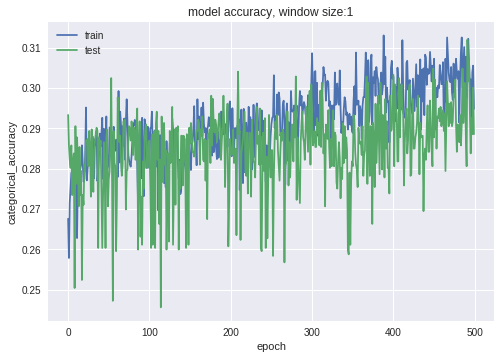

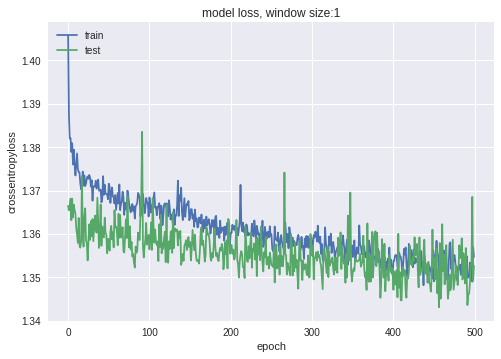

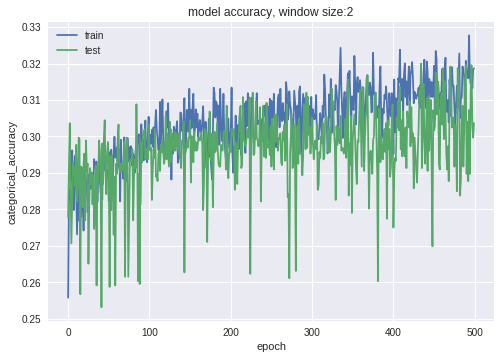

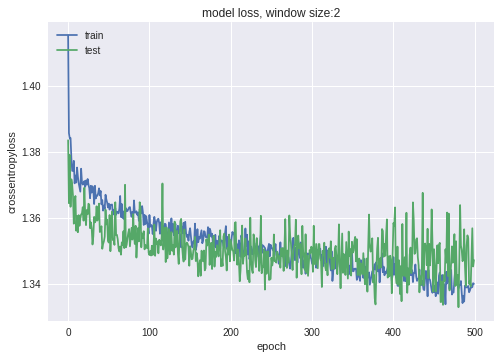

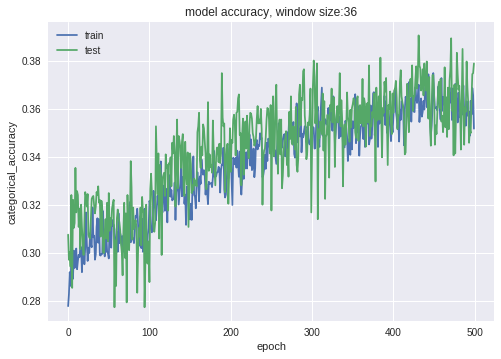

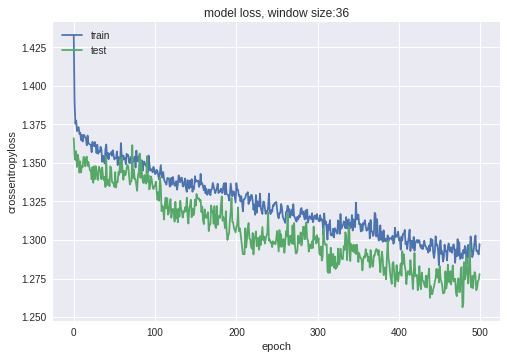

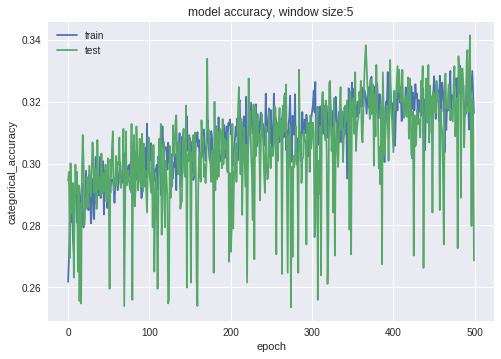

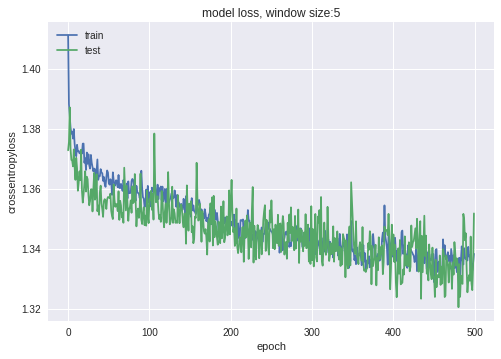

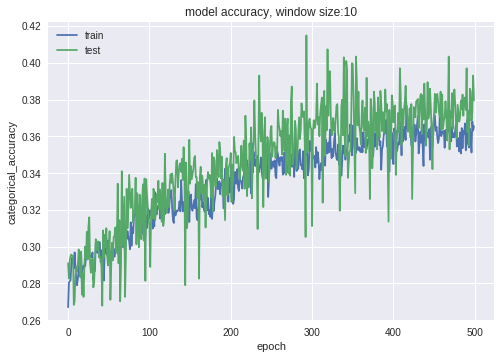

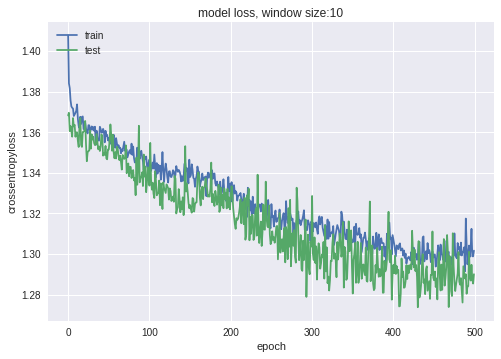

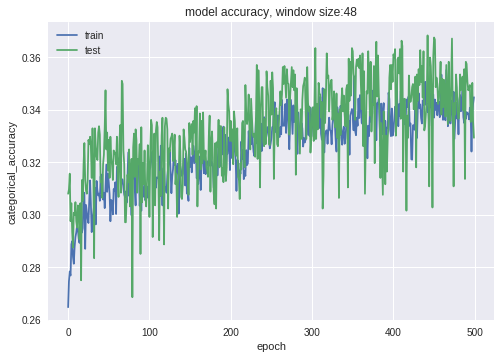

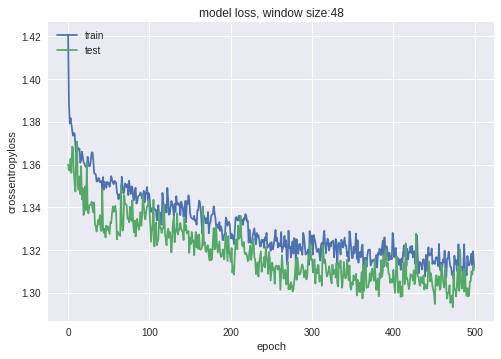

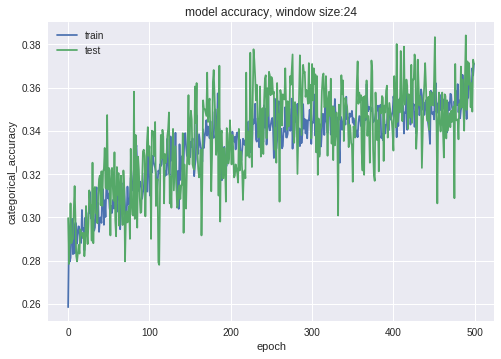

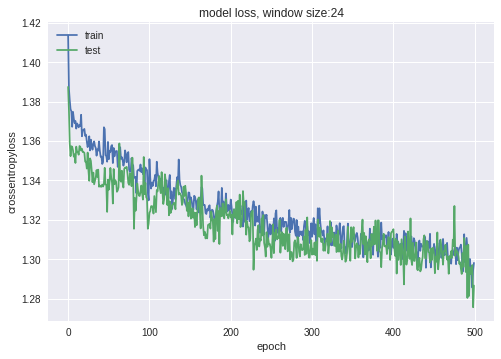

In [13]:
plot_history(result)

In [14]:
result = 

{1: {'auc': 0.5459753449916727,
  'f1_score_macro': 0.18070357432241851,
  'f1_score_micro': 0.28855325914149443,
  'history': <keras.callbacks.History at 0x7f891ad76ef0>,
  'precision_macro': 0.3627568696774138,
  'precision_micro': 0.28855325914149443,
  'recall_macro': 0.28657010162598884,
  'recall_micro': 0.28855325914149443},
 2: {'auc': 0.4937340738971174,
  'f1_score_macro': 0.2562278924887215,
  'f1_score_micro': 0.3036565977742448,
  'history': <keras.callbacks.History at 0x7f88f5ba3a58>,
  'precision_macro': 0.37160806673001795,
  'precision_micro': 0.3036565977742448,
  'recall_macro': 0.30761581951669337,
  'recall_micro': 0.3036565977742448},
 5: {'auc': 0.4850085234723315,
  'f1_score_macro': 0.180461788870343,
  'f1_score_micro': 0.2686804451510334,
  'history': <keras.callbacks.History at 0x7f88ea0c5a90>,
  'precision_macro': 0.4125927180993261,
  'precision_micro': 0.2686804451510334,
  'recall_macro': 0.2810781968125163,
  'recall_micro': 0.2686804451510334},
 10: {'

In [0]:
result = {1: {'auc': 0.5459753449916727,
  'f1_score_macro': 0.18070357432241851,
  'f1_score_micro': 0.28855325914149443,
  #'history': <keras.callbacks.History at 0x7f891ad76ef0>,
  'precision_macro': 0.3627568696774138,
  'precision_micro': 0.28855325914149443,
  'recall_macro': 0.28657010162598884,
  'recall_micro': 0.28855325914149443},
 2: {'auc': 0.4937340738971174,
  'f1_score_macro': 0.2562278924887215,
  'f1_score_micro': 0.3036565977742448,
  #'history': <keras.callbacks.History at 0x7f88f5ba3a58>,
  'precision_macro': 0.37160806673001795,
  'precision_micro': 0.3036565977742448,
  'recall_macro': 0.30761581951669337,
  'recall_micro': 0.3036565977742448},
 5: {'auc': 0.4850085234723315,
  'f1_score_macro': 0.180461788870343,
  'f1_score_micro': 0.2686804451510334,
  #'history': <keras.callbacks.History at 0x7f88ea0c5a90>,
  'precision_macro': 0.4125927180993261,
  'precision_micro': 0.2686804451510334,
  'recall_macro': 0.2810781968125163,
  'recall_micro': 0.2686804451510334},
 10: {'auc': 0.5183935587307739,
  'f1_score_macro': 0.34361857974894605,
  'f1_score_micro': 0.37957074721780604,
  #'history': <keras.callbacks.History at 0x7f88e85d7cf8>,
  'precision_macro': 0.44115257104977723,
  'precision_micro': 0.37957074721780604,
  'recall_macro': 0.3824470305660593,
  'recall_micro': 0.37957074721780604},
 24: {'auc': 0.47546763066001074,
  'f1_score_macro': 0.3611161842435631,
  'f1_score_micro': 0.3709483793517407,
  #'history': <keras.callbacks.History at 0x7f88df129978>,
  'precision_macro': 0.4469991887690965,
  'precision_micro': 0.3709483793517407,
  'recall_macro': 0.37295639130154334,
  'recall_micro': 0.3709483793517407},
 36: {'auc': 0.5097406713169935,
  'f1_score_macro': 0.36816842234685865,
  'f1_score_micro': 0.37876960193003617,
  #'history': <keras.callbacks.History at 0x7f88f37113c8>,
  'precision_macro': 0.43630876734092106,
  'precision_micro': 0.37876960193003617,
  'recall_macro': 0.3821223732091217,
  'recall_micro': 0.37876960193003617},
 48: {'auc': 0.5151558025072457,
  'f1_score_macro': 0.2821012766476277,
  'f1_score_micro': 0.3293124246079614,
  #'history': <keras.callbacks.History at 0x7f88e7db4cf8>,
  'precision_macro': 0.39658471371184173,
  'precision_micro': 0.3293124246079614,
  'recall_macro': 0.3300955059998517,
  'recall_micro': 0.3293124246079614}}

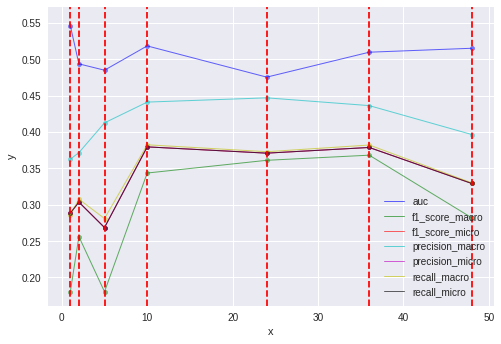

In [28]:
import matplotlib.pyplot as plt

x_list = [1,2,5,10,24,36,48]
resu = {}
for i in range(len(x_list)):
  if 'auc' not in resu:
    resu['auc']= []
  resu['auc']+= [result[x_list[i]]['auc']]
  if 'f1_score_macro' not in resu:
    resu['f1_score_macro']= []
  resu['f1_score_macro']+= [result[x_list[i]]['f1_score_macro']]
  if 'f1_score_micro' not in resu:
    resu['f1_score_micro']= []
  resu['f1_score_micro']+= [result[x_list[i]]['f1_score_micro']]
  if 'precision_macro' not in resu:
    resu['precision_macro']= []
  resu['precision_macro']+= [result[x_list[i]]['precision_macro']]
  if 'precision_micro' not in resu:
    resu['precision_micro']= []
  resu['precision_micro']+= [result[x_list[i]]['precision_micro']]
  if 'recall_macro' not in resu:
    resu['recall_macro']= []
  resu['recall_macro']+= [result[x_list[i]]['recall_macro']]
  if 'recall_micro' not in resu:
    resu['recall_micro']= []
  resu['recall_micro']+= [result[x_list[i]]['recall_micro']]



plt.figure('Result fig')
ax = plt.gca()

ax.set_xlabel('x')
ax.set_ylabel('y')
color = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

j = 0
legen = []
for item in resu:
  legen += [item]
  ax.scatter(x_list, resu[item], c=color[j], s=20, alpha=0.5)
  ax.plot(x_list, resu[item], color=color[j], linewidth=1, alpha=0.6)
  j += 1
ax.legend(legen,loc='lower right')

for xc in x_list:
    plt.axvline(x=xc,c='r',ls='dashed')
plt.show()